In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import seaborn as sns 
import json
import matplotlib.pyplot as plt
from gensim import corpora, models
import pickle
import nltk

In [7]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [8]:
def load_json_to_df(datapass):
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

In [9]:
business = load_json_to_df("../../../dataset/business.json")

In [10]:
review = load_json_to_df("../../../dataset/review.json")

In [11]:
by_city = business.groupby('city').size().reset_index(name='counts')

In [12]:
by_city.sort_values('counts',ascending=False)

city  counts
396           Las Vegas   24768
656             Phoenix   15656
909             Toronto   15483
136           Charlotte    7557
806          Scottsdale    7510
675          Pittsburgh    5688
526            Montréal    5175
491                Mesa    5146
317           Henderson    4130
900               Tempe    3949
131            Chandler    3649
226           Edinburgh    3625
153           Cleveland    2979
445             Madison    2891
286            Glendale    2841
280             Gilbert    2835
508         Mississauga    2316
880           Stuttgart    1975
647              Peoria    1527
453             Markham    1390
590     North Las Vegas    1254
128           Champaign    1084
601          North York     944
894            Surprise     934
792         Scarborough     870
709       Richmond Hill     770
159             Concord     726
292            Goodyear     703
79             Brampton     690
933             Vaughan     650
...                 ...     ...
394             Lambton       1
397      Las Vegas East       1
685          Portobello       1
711          Ridgeville       1
713             Rillton       1
741       Saint-Antoine       1
729             Russell       1
740       Saint Leonard       1
323          Hendserson       1
737          Saint Anns       1
736   Saint - Hyacinthe       1
336          Huntingdon       1
734               SLOAN       1
733       SCOTTSDALE AZ       1
732           S Concord       1
337           Huntsburg       1
730         Russell Twp       1
728         Rural Ridge       1
714    River Drive Park       1
727             Roxboro       1
341        Indian Land,       1
342        Indian Lands       1
344         Indian land       1
723              Roslin       1
345           Indianola       1
346           Inglewood       1
349              Ingram       1
718       Robinson Twp.       1
716       Robinson Town       1
1009     Île-des-Soeurs       1

[1010 rows x 2 columns]

## Overview:
Train the matrix of business subscores by minimizing a loss function for each restaurant, defined by sum((rec - rating)^2), where rec is (rating subscores dot user preference).

We obtain user preference by running an LDA on all the text reviews, that is, we are setting the preference column as a constant in the loss function. 

The weight for each topic is calculated by normalizing the sum of the probabilty that each word of one user's texts occurs in the topics generated by LDA on all reviews.

## Preprocessing:
0. Extract all the restaurant reviews.
1. tokenize
2. stop words
3. stemmize
4. get only nouns and adjs

In [13]:
is_rest = []
for i in business['categories']:
    
    if 'Restaurants' in i or 'Food' in i:
        is_rest.append(True)
    else:
        is_rest.append(False)
restaurants = business.loc[is_rest]
restaurants.shape

(65028, 15)

In [14]:
T_restaurant = restaurants.loc[restaurants['city']=='Madison']

In [15]:
T_restaurant.shape

(1231, 15)

In [16]:
rest_id = T_restaurant['business_id']
rest_review = review.loc[review['business_id'].isin(rest_id)]
rest_review.shape

(60684, 9)

In [17]:
#preprocess
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from nltk.corpus import stopwords
en_stop = stopwords.words('english')

from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

def preprocess(text):
    raw = text.lower()
    tokens = tokenizer.tokenize(raw)
    
    pospeech=[]
    tag = nltk.pos_tag(tokens)
    for j in tag:
        if j[1] == 'NN' or j[1] == 'JJ':
            pospeech.append(j[0])
    # remove stop words from tokens
    stopped_tokens = [i for i in pospeech if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    return stemmed_tokens



In [109]:
NUM_TOPICS = 20
from gensim import corpora, models
'''
def getcorpus(df):
    texts = []
    for i in df['text']:
        texts.append(preprocess(i))
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)
    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    corpora.MmCorpus.serialize('../../../dataset/corp.mm', corpus=corpus, id2word=dictionary)
    mm = corpora.MmCorpus('../../../dataset/corp.mm')
    return mm, dictionary

def getlda(dictionary):
    mm = corpora.MmCorpus('../../../dataset/corp.mm')
    # generate LDA model
    ldamodel = models.ldamulticore.LdaMulticore(mm, num_topics=NUM_TOPICS, id2word = dictionary, workers=15, passes=1, eval_every=None)
    return ldamodel
'''
def getcorpuse(df):
    texts = []
    for i in df['text']:
        texts.append(preprocess(i))
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)
    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus, dictionary
def getlda(corpus, dictionary):
    
    ldamodel = models.ldamulticore.LdaMulticore(corpus, num_topics=NUM_TOPICS, id2word = dictionary, workers=3, passes=40, eval_every=None)
    return ldamodel


## Calculate preference maxtrix
Add up the probabity that each word in the corpus in each topic, then add up for each topic and normalize.

In [33]:
def getprefer(userid, ldamodel, df):
    user_reviews = df.loc[df['user_id'] == userid]
    l = np.zeros(NUM_TOPICS)
    texts = []
    for t in user_reviews['text']:
        texts.append(preprocess(t))
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    for i in ldamodel.get_document_topics(corpus):
        for topic in i:
            l[topic[0]] += topic[1]
    topic_likelihood = []
    sum_l = sum(l)
    if sum_l > 0:
        for i in l:
            topic_likelihood.append(i/sum_l)
    else:
        topic_likelihood = np.full(NUM_TOPICS, 1/NUM_TOPICS)
    return topic_likelihood

## Minimize loss function

Since we setting the topics for each user as constant, the corpus likelihood here is a constant so we only need to deal with rating error.

We used Sequential Least SQuares Programming (SLSQP) to minize the function.

Intial guess was randomized between 1.0 and 5.0

Might need to explore bias and hyperparameters in the future.

In [577]:
from scipy.optimize import minimize
import math
def min_loss(raw_prefer, actual_rating):
    dim = NUM_TOPICS
    prefer = []
    for i in raw_prefer:
        prefer.append(np.asarray(i, dtype=np.float32))
    prefer = np.asarray(prefer)
    bound = []
    for i in range(0,dim):
        bound.append((1.0,5.0))
    bnds = tuple(bound)


    def f(x,prefer,actual_rating):
        #sd = np.std(actual_rating)
        #return sum(abs(np.dot(x,np.transpose(prefer)) - actual_rating))
        
        l = []
        err = (np.dot(x,np.transpose(prefer)) - actual_rating)
        
        for e in err:
            if e > 2.0:
                l.append(e**2)
            else:
                l.append(abs(e))
        return sum(l)
        #return sum((np.dot(x,np.transpose(prefer)) - actual_rating)**2)
        
    initial_guess = [np.random.uniform(1.0,5.0,dim)]
    #initial_guess = np.full(5,2.5)
    #try:
    result = minimize(f, initial_guess, args=(prefer,actual_rating), method='SLSQP', bounds=bnds, options={'disp': False, 'iprint': 1, 'eps': 1.4901161193847656e-08, 'maxiter': 1000, 'ftol': 1e-06})
    #except:
        #return -1
    if result.success:
        fitted_params = result.x
        '''
        print ("param")
        print(fitted_params)
        print ("fun")
        print(result.fun)
        print(result.nit)
        '''
        return result
    else:
        raise ValueError(result.message)

## Combine everything
For each restaurant, run the algorithm to get the subscores, which will take a couple days on MacBook ~~Pro~~.

In [20]:
def add_prefer_to_df(df, lda, groupbyusers):
    d = {}
    new_df = df
    for u in groupbyusers['user_id']:
        d[u] = getprefer(u,lda,new_df)
    df['preference'] = df.apply(lambda x: d[x['user_id']],axis=1)
    return new_df

In [22]:
def train_rest_subscore(bizid, df):
    biz = df.loc[df['business_id'] == bizid]
    rating = biz['stars']
    preference = biz['preference']
    result = min_loss(preference.values, rating.values)
    return (result.x, result.nit)

In [557]:
def getsubscore(df, groupbybiz):
    d = {}
    counter = 0
    for index, u in groupbybiz.iterrows():
        if u['counts'] >= 10:
            counter +=1
            if (counter %100 ==0):
                print (counter)
            d[u['business_id']] = train_rest_subscore(u['business_id'], df)
    #df['subscore'] = df.apply(lambda x: d[x['business_id']],axis=1)
    return d

In [24]:
from sklearn.model_selection import train_test_split
def split(groupbybiz, df):
    trains = []
    tests = []
    for i in groupbybiz['business_id']:
        biz = df.loc[df['business_id'] == i]
        train, test = train_test_split(biz, test_size=0.30, random_state=42)
        trains.append(train)
        tests.append(test)
    train_df = pd.concat(trains)
    test_df = pd.concat(tests)
    return train_df, test_df

In [25]:
groupby_rest = rest_review.groupby('business_id').size().reset_index(name='counts')

In [26]:
train_df, test_df = split(groupby_rest, rest_review)

In [27]:
print (train_df.shape)
print (test_df.shape)
groupby_rest_train_df = train_df.groupby('business_id').size().reset_index(name='counts')
groupby_rest_test_df = test_df.groupby('business_id').size().reset_index(name='counts')
print (groupby_rest_train_df.shape)
print (groupby_rest_test_df.shape)

(41926, 9)
(18758, 9)
(1231, 2)
(1231, 2)


In [28]:
groupby_user = train_df.groupby('user_id').size().reset_index(name='counts')

In [388]:
groupby_user.shape

(15728, 2)

In [29]:
corp, diction = getcorpuse(train_df)

2017-11-29 20:26:22,559 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-29 20:26:23,000 : INFO : adding document #10000 to Dictionary(12123 unique tokens: ['unenthusiast', 'barista', 'first', 'name', 'basi']...)
2017-11-29 20:26:23,420 : INFO : adding document #20000 to Dictionary(16600 unique tokens: ['unenthusiast', 'barista', 'first', 'name', 'basi']...)
2017-11-29 20:26:23,835 : INFO : adding document #30000 to Dictionary(19908 unique tokens: ['unenthusiast', 'barista', 'first', 'name', 'basi']...)
2017-11-29 20:26:24,237 : INFO : adding document #40000 to Dictionary(22685 unique tokens: ['unenthusiast', 'barista', 'first', 'name', 'basi']...)
2017-11-29 20:26:24,335 : INFO : built Dictionary(23342 unique tokens: ['unenthusiast', 'barista', 'first', 'name', 'basi']...) from 41926 documents (total 1338560 corpus positions)


In [110]:
lda = getlda(corp, diction)

2017-11-30 00:09:00,557 : INFO : using symmetric alpha at 0.05
2017-11-30 00:09:00,563 : INFO : using symmetric eta at 4.284123040013709e-05
2017-11-30 00:09:00,570 : INFO : using serial LDA version on this node
2017-11-30 00:09:02,758 : INFO : running online LDA training, 20 topics, 40 passes over the supplied corpus of 41926 documents, updating every 6000 documents, evaluating every ~0 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-30 00:09:02,761 : INFO : training LDA model using 3 processes
2017-11-30 00:09:02,875 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/41926, outstanding queue size 1
2017-11-30 00:09:03,170 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/41926, outstanding queue size 2
2017-11-30 00:09:03,285 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/41926, outstanding queue size 3
2017-11-30 00:09:03,316 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #80

2017-11-30 00:09:32,257 : INFO : topic #0 (0.050): 0.050*"good" + 0.035*"food" + 0.022*"great" + 0.021*"place" + 0.013*"time" + 0.009*"restaur" + 0.009*"servic" + 0.007*"night" + 0.006*"madison" + 0.006*"experi"
2017-11-30 00:09:32,258 : INFO : topic #8 (0.050): 0.019*"place" + 0.019*"good" + 0.019*"food" + 0.014*"sandwich" + 0.011*"menu" + 0.011*"time" + 0.010*"great" + 0.009*"delici" + 0.008*"chees" + 0.006*"littl"
2017-11-30 00:09:32,260 : INFO : topic #14 (0.050): 0.021*"time" + 0.019*"food" + 0.014*"madison" + 0.012*"great" + 0.010*"menu" + 0.008*"good" + 0.007*"restaur" + 0.007*"servic" + 0.007*"delici" + 0.007*"place"
2017-11-30 00:09:32,262 : INFO : topic #19 (0.050): 0.028*"place" + 0.024*"bar" + 0.022*"food" + 0.020*"great" + 0.016*"good" + 0.014*"nice" + 0.014*"servic" + 0.011*"time" + 0.009*"beer" + 0.008*"area"
2017-11-30 00:09:32,265 : INFO : topic diff=0.611808, rho=0.277350
2017-11-30 00:09:37,256 : INFO : merging changes from 6000 documents into a model of 41926 docume

2017-11-30 00:09:56,675 : INFO : topic #17 (0.050): 0.028*"food" + 0.016*"good" + 0.015*"menu" + 0.013*"place" + 0.013*"time" + 0.012*"great" + 0.012*"order" + 0.012*"servic" + 0.012*"tabl" + 0.010*"restaur"
2017-11-30 00:09:56,676 : INFO : topic #9 (0.050): 0.021*"good" + 0.020*"place" + 0.016*"great" + 0.015*"food" + 0.015*"store" + 0.010*"select" + 0.010*"time" + 0.008*"groceri" + 0.007*"madison" + 0.006*"mani"
2017-11-30 00:09:56,678 : INFO : topic #13 (0.050): 0.055*"food" + 0.033*"good" + 0.023*"servic" + 0.021*"chees" + 0.015*"place" + 0.014*"great" + 0.011*"madison" + 0.009*"chicken" + 0.009*"time" + 0.008*"menu"
2017-11-30 00:09:56,679 : INFO : topic #6 (0.050): 0.027*"food" + 0.016*"chicken" + 0.013*"beef" + 0.013*"good" + 0.012*"rice" + 0.011*"chines" + 0.011*"great" + 0.010*"sauc" + 0.009*"restaur" + 0.009*"place"
2017-11-30 00:09:56,682 : INFO : topic diff=0.252936, rho=0.208682
2017-11-30 00:09:56,685 : INFO : PROGRESS: pass 1, dispatched chunk #17 = documents up to #3600

2017-11-30 00:10:22,039 : INFO : topic #1 (0.050): 0.022*"good" + 0.018*"brunch" + 0.017*"place" + 0.013*"toast" + 0.011*"breakfast" + 0.011*"food" + 0.009*"menu" + 0.009*"french" + 0.008*"servic" + 0.007*"sweet"
2017-11-30 00:10:22,040 : INFO : topic #2 (0.050): 0.096*"pizza" + 0.020*"good" + 0.016*"chees" + 0.016*"crust" + 0.016*"place" + 0.014*"great" + 0.011*"madison" + 0.008*"time" + 0.008*"order" + 0.007*"slice"
2017-11-30 00:10:22,043 : INFO : topic diff=0.229244, rho=0.204282
2017-11-30 00:10:22,045 : INFO : PROGRESS: pass 2, dispatched chunk #10 = documents up to #22000/41926, outstanding queue size 8
2017-11-30 00:10:22,046 : INFO : PROGRESS: pass 2, dispatched chunk #11 = documents up to #24000/41926, outstanding queue size 9
2017-11-30 00:10:25,827 : INFO : PROGRESS: pass 2, dispatched chunk #12 = documents up to #26000/41926, outstanding queue size 8
2017-11-30 00:10:25,840 : INFO : PROGRESS: pass 2, dispatched chunk #13 = documents up to #28000/41926, outstanding queue si

2017-11-30 00:10:45,079 : INFO : topic #12 (0.050): 0.050*"food" + 0.028*"great" + 0.025*"good" + 0.024*"taco" + 0.023*"place" + 0.020*"mexican" + 0.015*"salsa" + 0.014*"servic" + 0.013*"madison" + 0.011*"burrito"
2017-11-30 00:10:45,080 : INFO : topic #2 (0.050): 0.107*"pizza" + 0.021*"good" + 0.018*"crust" + 0.018*"chees" + 0.016*"place" + 0.014*"great" + 0.011*"madison" + 0.009*"slice" + 0.008*"time" + 0.008*"order"
2017-11-30 00:10:45,082 : INFO : topic #16 (0.050): 0.058*"coffe" + 0.018*"place" + 0.016*"good" + 0.014*"chocol" + 0.013*"great" + 0.010*"time" + 0.009*"shop" + 0.008*"order" + 0.008*"staff" + 0.007*"food"
2017-11-30 00:10:45,083 : INFO : topic #1 (0.050): 0.020*"brunch" + 0.019*"good" + 0.016*"toast" + 0.015*"place" + 0.012*"french" + 0.011*"breakfast" + 0.009*"food" + 0.009*"menu" + 0.007*"bacon" + 0.007*"sweet"
2017-11-30 00:10:45,086 : INFO : topic diff=0.190525, rho=0.204282
2017-11-30 00:10:45,088 : INFO : PROGRESS: pass 3, dispatched chunk #0 = documents up to #2

2017-11-30 00:11:01,150 : INFO : topic diff=0.145173, rho=0.200148
2017-11-30 00:11:01,151 : INFO : PROGRESS: pass 3, dispatched chunk #20 = documents up to #41926/41926, outstanding queue size 9
2017-11-30 00:11:04,876 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:11:05,143 : INFO : topic #13 (0.050): 0.072*"food" + 0.039*"good" + 0.032*"servic" + 0.018*"chees" + 0.017*"place" + 0.016*"great" + 0.012*"chicken" + 0.011*"madison" + 0.011*"indian" + 0.010*"buffet"
2017-11-30 00:11:05,145 : INFO : topic #0 (0.050): 0.068*"good" + 0.055*"food" + 0.030*"place" + 0.027*"great" + 0.015*"time" + 0.014*"servic" + 0.013*"restaur" + 0.009*"price" + 0.008*"experi" + 0.007*"night"
2017-11-30 00:11:05,146 : INFO : topic #3 (0.050): 0.030*"order" + 0.020*"good" + 0.016*"potato" + 0.015*"sauc" + 0.014*"rib" + 0.014*"sweet" + 0.012*"deliveri" + 0.012*"great" + 0.011*"food" + 0.011*"bbq"
2017-11-30 00:11:05,147 : INFO : topic #11 (0.050): 0.041*"great" + 0.02

2017-11-30 00:11:23,555 : INFO : PROGRESS: pass 4, dispatched chunk #16 = documents up to #34000/41926, outstanding queue size 9
2017-11-30 00:11:23,639 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:11:23,940 : INFO : topic #13 (0.050): 0.075*"food" + 0.039*"good" + 0.033*"servic" + 0.018*"place" + 0.017*"great" + 0.015*"chees" + 0.013*"chicken" + 0.013*"indian" + 0.012*"buffet" + 0.011*"madison"
2017-11-30 00:11:23,942 : INFO : topic #18 (0.050): 0.018*"fish" + 0.017*"good" + 0.017*"restaur" + 0.016*"dish" + 0.013*"food" + 0.012*"great" + 0.012*"menu" + 0.010*"meal" + 0.010*"servic" + 0.010*"shrimp"
2017-11-30 00:11:23,945 : INFO : topic #9 (0.050): 0.026*"store" + 0.017*"place" + 0.014*"good" + 0.013*"select" + 0.012*"great" + 0.010*"groceri" + 0.009*"food" + 0.008*"time" + 0.008*"madison" + 0.008*"shop"
2017-11-30 00:11:23,946 : INFO : topic #4 (0.050): 0.056*"burger" + 0.037*"chees" + 0.023*"good" + 0.015*"great" + 0.013*"place" + 0.013*

2017-11-30 00:11:47,820 : INFO : topic #14 (0.050): 0.056*"sushi" + 0.022*"time" + 0.017*"madison" + 0.014*"chef" + 0.013*"food" + 0.013*"roll" + 0.012*"restaur" + 0.011*"menu" + 0.009*"first" + 0.009*"great"
2017-11-30 00:11:47,822 : INFO : topic #8 (0.050): 0.047*"sandwich" + 0.021*"salad" + 0.020*"good" + 0.014*"lunch" + 0.014*"bread" + 0.013*"place" + 0.013*"food" + 0.012*"meat" + 0.012*"chicken" + 0.012*"delici"
2017-11-30 00:11:47,825 : INFO : topic #4 (0.050): 0.053*"burger" + 0.037*"chees" + 0.023*"good" + 0.014*"great" + 0.012*"littl" + 0.012*"sauc" + 0.011*"place" + 0.011*"bacon" + 0.009*"nice" + 0.009*"delici"
2017-11-30 00:11:47,826 : INFO : topic #16 (0.050): 0.071*"coffe" + 0.019*"place" + 0.015*"good" + 0.013*"great" + 0.012*"chocol" + 0.011*"shop" + 0.009*"time" + 0.009*"cafe" + 0.008*"cup" + 0.008*"staff"
2017-11-30 00:11:47,828 : INFO : topic #1 (0.050): 0.024*"breakfast" + 0.023*"brunch" + 0.021*"toast" + 0.016*"french" + 0.016*"good" + 0.013*"place" + 0.012*"egg" + 

2017-11-30 00:12:07,236 : INFO : topic #5 (0.050): 0.051*"tea" + 0.014*"cake" + 0.013*"place" + 0.010*"bubbl" + 0.009*"madison" + 0.008*"milk" + 0.007*"cupcak" + 0.007*"staff" + 0.006*"good" + 0.006*"littl"
2017-11-30 00:12:07,239 : INFO : topic diff=0.097807, rho=0.192582
2017-11-30 00:12:09,914 : INFO : merging changes from 5926 documents into a model of 41926 documents
2017-11-30 00:12:10,072 : INFO : topic #18 (0.050): 0.018*"fish" + 0.018*"good" + 0.017*"restaur" + 0.015*"dish" + 0.013*"menu" + 0.013*"great" + 0.012*"food" + 0.011*"meal" + 0.010*"dinner" + 0.010*"servic"
2017-11-30 00:12:10,073 : INFO : topic #0 (0.050): 0.073*"good" + 0.066*"food" + 0.038*"place" + 0.029*"great" + 0.015*"servic" + 0.015*"restaur" + 0.014*"time" + 0.011*"price" + 0.009*"experi" + 0.008*"atmospher"
2017-11-30 00:12:10,074 : INFO : topic #7 (0.050): 0.031*"cream" + 0.024*"ice" + 0.018*"chees" + 0.018*"chocol" + 0.016*"good" + 0.013*"dessert" + 0.010*"flavor" + 0.009*"delici" + 0.008*"steak" + 0.007*

2017-11-30 00:12:22,907 : INFO : topic #3 (0.050): 0.029*"order" + 0.021*"good" + 0.020*"sauc" + 0.020*"bbq" + 0.018*"rib" + 0.018*"potato" + 0.016*"sweet" + 0.016*"deliveri" + 0.016*"pork" + 0.013*"chicken"
2017-11-30 00:12:22,908 : INFO : topic #8 (0.050): 0.057*"sandwich" + 0.025*"salad" + 0.020*"good" + 0.018*"lunch" + 0.016*"bread" + 0.013*"chicken" + 0.012*"meat" + 0.012*"food" + 0.012*"place" + 0.012*"vegan"
2017-11-30 00:12:22,909 : INFO : topic #7 (0.050): 0.037*"cream" + 0.029*"ice" + 0.019*"chocol" + 0.019*"chees" + 0.015*"good" + 0.012*"dessert" + 0.010*"flavor" + 0.009*"delici" + 0.007*"steak" + 0.007*"perfect"
2017-11-30 00:12:22,912 : INFO : topic diff=0.074384, rho=0.189107
2017-11-30 00:12:22,913 : INFO : PROGRESS: pass 6, dispatched chunk #20 = documents up to #41926/41926, outstanding queue size 9
2017-11-30 00:12:25,720 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:12:26,011 : INFO : topic #7 (0.050): 0.034*"cream" + 0.02

2017-11-30 00:12:38,896 : INFO : topic #17 (0.050): 0.038*"food" + 0.027*"servic" + 0.027*"time" + 0.025*"order" + 0.023*"tabl" + 0.014*"server" + 0.013*"restaur" + 0.012*"waitress" + 0.010*"experi" + 0.010*"busi"
2017-11-30 00:12:38,897 : INFO : topic #8 (0.050): 0.054*"sandwich" + 0.028*"salad" + 0.020*"good" + 0.018*"lunch" + 0.018*"bread" + 0.014*"chicken" + 0.012*"meat" + 0.012*"food" + 0.011*"delici" + 0.011*"place"
2017-11-30 00:12:38,900 : INFO : topic diff=0.079034, rho=0.185814
2017-11-30 00:12:38,902 : INFO : PROGRESS: pass 7, dispatched chunk #14 = documents up to #30000/41926, outstanding queue size 9
2017-11-30 00:12:41,719 : INFO : PROGRESS: pass 7, dispatched chunk #15 = documents up to #32000/41926, outstanding queue size 9
2017-11-30 00:12:41,843 : INFO : PROGRESS: pass 7, dispatched chunk #16 = documents up to #34000/41926, outstanding queue size 9
2017-11-30 00:12:41,969 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:12:42

2017-11-30 00:12:54,495 : INFO : PROGRESS: pass 8, dispatched chunk #6 = documents up to #14000/41926, outstanding queue size 7
2017-11-30 00:12:54,569 : INFO : PROGRESS: pass 8, dispatched chunk #7 = documents up to #16000/41926, outstanding queue size 8
2017-11-30 00:12:54,629 : INFO : PROGRESS: pass 8, dispatched chunk #8 = documents up to #18000/41926, outstanding queue size 9
2017-11-30 00:12:57,757 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:12:58,041 : INFO : topic #3 (0.050): 0.028*"order" + 0.023*"bbq" + 0.021*"good" + 0.021*"sauc" + 0.019*"rib" + 0.019*"pork" + 0.019*"sweet" + 0.018*"potato" + 0.018*"deliveri" + 0.015*"meat"
2017-11-30 00:12:58,043 : INFO : topic #1 (0.050): 0.041*"breakfast" + 0.028*"brunch" + 0.022*"toast" + 0.017*"french" + 0.017*"egg" + 0.015*"good" + 0.013*"bacon" + 0.011*"hash" + 0.011*"sweet" + 0.010*"place"
2017-11-30 00:12:58,044 : INFO : topic #16 (0.050): 0.081*"coffe" + 0.019*"place" + 0.016*"good" + 

2017-11-30 00:13:13,961 : INFO : topic #6 (0.050): 0.024*"food" + 0.022*"rice" + 0.021*"chicken" + 0.021*"good" + 0.017*"spici" + 0.016*"chines" + 0.014*"sauc" + 0.014*"soup" + 0.014*"place" + 0.011*"dish"
2017-11-30 00:13:13,963 : INFO : topic #7 (0.050): 0.037*"cream" + 0.029*"ice" + 0.024*"chocol" + 0.015*"chees" + 0.014*"dessert" + 0.013*"good" + 0.011*"steak" + 0.010*"flavor" + 0.009*"delici" + 0.008*"cake"
2017-11-30 00:13:13,964 : INFO : topic #9 (0.050): 0.027*"store" + 0.014*"place" + 0.013*"select" + 0.010*"locat" + 0.010*"groceri" + 0.009*"good" + 0.009*"shop" + 0.009*"madison" + 0.009*"great" + 0.008*"local"
2017-11-30 00:13:13,967 : INFO : topic #2 (0.050): 0.134*"pizza" + 0.023*"crust" + 0.021*"good" + 0.019*"chees" + 0.016*"italian" + 0.015*"place" + 0.011*"slice" + 0.011*"madison" + 0.010*"sauc" + 0.009*"great"
2017-11-30 00:13:13,971 : INFO : topic diff=0.076764, rho=0.182687
2017-11-30 00:13:17,077 : INFO : merging changes from 5926 documents into a model of 41926 doc

2017-11-30 00:13:30,204 : INFO : PROGRESS: pass 9, dispatched chunk #19 = documents up to #40000/41926, outstanding queue size 9
2017-11-30 00:13:30,437 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:13:30,661 : INFO : topic #4 (0.050): 0.072*"chees" + 0.066*"burger" + 0.025*"good" + 0.013*"bacon" + 0.011*"great" + 0.011*"littl" + 0.010*"sauc" + 0.009*"delici" + 0.008*"place" + 0.008*"bun"
2017-11-30 00:13:30,663 : INFO : topic #17 (0.050): 0.038*"food" + 0.028*"time" + 0.027*"servic" + 0.025*"order" + 0.023*"tabl" + 0.014*"server" + 0.012*"waitress" + 0.012*"restaur" + 0.010*"experi" + 0.010*"busi"
2017-11-30 00:13:30,664 : INFO : topic #2 (0.050): 0.130*"pizza" + 0.025*"crust" + 0.020*"good" + 0.018*"chees" + 0.017*"italian" + 0.014*"place" + 0.011*"thin" + 0.011*"madison" + 0.010*"sauc" + 0.009*"slice"
2017-11-30 00:13:30,666 : INFO : topic #10 (0.050): 0.096*"beer" + 0.026*"select" + 0.025*"great" + 0.024*"good" + 0.024*"old" + 0.021*"pla

2017-11-30 00:13:46,892 : INFO : topic #12 (0.050): 0.044*"taco" + 0.034*"food" + 0.031*"mexican" + 0.023*"salsa" + 0.022*"burrito" + 0.022*"good" + 0.017*"place" + 0.015*"authent" + 0.012*"great" + 0.011*"chicken"
2017-11-30 00:13:46,893 : INFO : topic #15 (0.050): 0.066*"thai" + 0.046*"curri" + 0.028*"pad" + 0.020*"sub" + 0.020*"place" + 0.014*"squash" + 0.012*"madison" + 0.011*"bay" + 0.010*"good" + 0.009*"food"
2017-11-30 00:13:46,894 : INFO : topic #7 (0.050): 0.042*"cream" + 0.030*"ice" + 0.028*"chocol" + 0.014*"dessert" + 0.014*"chees" + 0.012*"good" + 0.010*"flavor" + 0.010*"steak" + 0.009*"delici" + 0.009*"butter"
2017-11-30 00:13:46,896 : INFO : topic #8 (0.050): 0.056*"sandwich" + 0.035*"salad" + 0.021*"lunch" + 0.020*"bread" + 0.020*"good" + 0.016*"chicken" + 0.012*"meat" + 0.011*"vegan" + 0.011*"delici" + 0.011*"soup"
2017-11-30 00:13:46,899 : INFO : topic diff=0.063189, rho=0.176879
2017-11-30 00:13:46,902 : INFO : PROGRESS: pass 10, dispatched chunk #13 = documents up to

2017-11-30 00:14:05,809 : INFO : PROGRESS: pass 11, dispatched chunk #2 = documents up to #6000/41926, outstanding queue size 3
2017-11-30 00:14:05,810 : INFO : PROGRESS: pass 11, dispatched chunk #3 = documents up to #8000/41926, outstanding queue size 4
2017-11-30 00:14:05,812 : INFO : PROGRESS: pass 11, dispatched chunk #4 = documents up to #10000/41926, outstanding queue size 5
2017-11-30 00:14:05,814 : INFO : PROGRESS: pass 11, dispatched chunk #5 = documents up to #12000/41926, outstanding queue size 6
2017-11-30 00:14:05,873 : INFO : PROGRESS: pass 11, dispatched chunk #6 = documents up to #14000/41926, outstanding queue size 7
2017-11-30 00:14:05,944 : INFO : PROGRESS: pass 11, dispatched chunk #7 = documents up to #16000/41926, outstanding queue size 8
2017-11-30 00:14:06,036 : INFO : PROGRESS: pass 11, dispatched chunk #8 = documents up to #18000/41926, outstanding queue size 9
2017-11-30 00:14:09,452 : INFO : PROGRESS: pass 11, dispatched chunk #9 = documents up to #20000/41

2017-11-30 00:14:23,797 : INFO : topic #12 (0.050): 0.047*"taco" + 0.033*"food" + 0.032*"mexican" + 0.025*"salsa" + 0.021*"good" + 0.019*"burrito" + 0.016*"place" + 0.014*"authent" + 0.011*"chicken" + 0.011*"great"
2017-11-30 00:14:23,800 : INFO : topic diff=0.061342, rho=0.174175
2017-11-30 00:14:28,257 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:14:28,502 : INFO : topic #7 (0.050): 0.040*"cream" + 0.031*"ice" + 0.029*"chocol" + 0.015*"dessert" + 0.012*"chees" + 0.011*"steak" + 0.011*"flavor" + 0.011*"good" + 0.010*"delici" + 0.009*"cake"
2017-11-30 00:14:28,503 : INFO : topic #16 (0.050): 0.085*"coffe" + 0.018*"place" + 0.015*"good" + 0.014*"shop" + 0.013*"cafe" + 0.011*"great" + 0.010*"cup" + 0.009*"nice" + 0.009*"bakeri" + 0.008*"littl"
2017-11-30 00:14:28,505 : INFO : topic #12 (0.050): 0.046*"taco" + 0.032*"food" + 0.032*"mexican" + 0.024*"salsa" + 0.022*"burrito" + 0.021*"good" + 0.016*"place" + 0.015*"authent" + 0.011*"chicken" + 0

2017-11-30 00:14:40,959 : INFO : topic #3 (0.050): 0.028*"order" + 0.023*"pork" + 0.023*"sauc" + 0.022*"good" + 0.021*"bbq" + 0.020*"meat" + 0.019*"deliveri" + 0.019*"sweet" + 0.019*"potato" + 0.018*"rib"
2017-11-30 00:14:40,962 : INFO : topic diff=0.064951, rho=0.171592
2017-11-30 00:14:40,964 : INFO : PROGRESS: pass 12, dispatched chunk #17 = documents up to #36000/41926, outstanding queue size 9
2017-11-30 00:14:43,399 : INFO : PROGRESS: pass 12, dispatched chunk #18 = documents up to #38000/41926, outstanding queue size 9
2017-11-30 00:14:43,638 : INFO : PROGRESS: pass 12, dispatched chunk #19 = documents up to #40000/41926, outstanding queue size 9
2017-11-30 00:14:43,797 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:14:44,044 : INFO : topic #16 (0.050): 0.088*"coffe" + 0.018*"place" + 0.016*"good" + 0.015*"shop" + 0.012*"cafe" + 0.011*"great" + 0.010*"cup" + 0.009*"nice" + 0.009*"littl" + 0.008*"bakeri"
2017-11-30 00:14:44,045 : INFO :

2017-11-30 00:14:56,017 : INFO : PROGRESS: pass 13, dispatched chunk #11 = documents up to #24000/41926, outstanding queue size 9
2017-11-30 00:14:59,010 : INFO : PROGRESS: pass 13, dispatched chunk #12 = documents up to #26000/41926, outstanding queue size 8
2017-11-30 00:14:59,057 : INFO : PROGRESS: pass 13, dispatched chunk #13 = documents up to #28000/41926, outstanding queue size 9
2017-11-30 00:14:59,122 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:14:59,347 : INFO : topic #5 (0.050): 0.060*"tea" + 0.015*"cake" + 0.009*"cupcak" + 0.009*"place" + 0.009*"bubbl" + 0.008*"madison" + 0.007*"milk" + 0.007*"wed" + 0.006*"flavor" + 0.006*"frost"
2017-11-30 00:14:59,348 : INFO : topic #0 (0.050): 0.079*"good" + 0.069*"food" + 0.053*"place" + 0.023*"great" + 0.013*"servic" + 0.013*"time" + 0.013*"noth" + 0.013*"price" + 0.013*"restaur" + 0.011*"bad"
2017-11-30 00:14:59,349 : INFO : topic #1 (0.050): 0.055*"breakfast" + 0.038*"brunch" + 0.020*"t

2017-11-30 00:15:14,335 : INFO : topic #1 (0.050): 0.052*"breakfast" + 0.041*"brunch" + 0.021*"toast" + 0.020*"egg" + 0.017*"french" + 0.015*"bloodi" + 0.014*"good" + 0.013*"bacon" + 0.012*"hash" + 0.012*"mari"
2017-11-30 00:15:14,337 : INFO : topic diff=0.053933, rho=0.169120
2017-11-30 00:15:14,340 : INFO : PROGRESS: pass 14, dispatched chunk #0 = documents up to #2000/41926, outstanding queue size 1
2017-11-30 00:15:14,383 : INFO : PROGRESS: pass 14, dispatched chunk #1 = documents up to #4000/41926, outstanding queue size 2
2017-11-30 00:15:14,384 : INFO : PROGRESS: pass 14, dispatched chunk #2 = documents up to #6000/41926, outstanding queue size 3
2017-11-30 00:15:14,386 : INFO : PROGRESS: pass 14, dispatched chunk #3 = documents up to #8000/41926, outstanding queue size 4
2017-11-30 00:15:14,387 : INFO : PROGRESS: pass 14, dispatched chunk #4 = documents up to #10000/41926, outstanding queue size 5
2017-11-30 00:15:14,388 : INFO : PROGRESS: pass 14, dispatched chunk #5 = documen

2017-11-30 00:15:30,752 : INFO : topic #16 (0.050): 0.089*"coffe" + 0.018*"place" + 0.016*"good" + 0.015*"shop" + 0.013*"cafe" + 0.011*"cup" + 0.010*"great" + 0.010*"nice" + 0.009*"littl" + 0.008*"bakeri"
2017-11-30 00:15:30,753 : INFO : topic #3 (0.050): 0.029*"pork" + 0.027*"bbq" + 0.025*"order" + 0.024*"sauc" + 0.022*"good" + 0.021*"sweet" + 0.020*"meat" + 0.020*"rib" + 0.019*"potato" + 0.017*"chicken"
2017-11-30 00:15:30,754 : INFO : topic #7 (0.050): 0.044*"cream" + 0.034*"ice" + 0.030*"chocol" + 0.016*"dessert" + 0.011*"flavor" + 0.011*"cake" + 0.010*"chees" + 0.010*"good" + 0.010*"delici" + 0.010*"steak"
2017-11-30 00:15:30,757 : INFO : topic diff=0.055214, rho=0.166752
2017-11-30 00:15:33,407 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:15:33,632 : INFO : topic #10 (0.050): 0.106*"beer" + 0.031*"select" + 0.028*"great" + 0.027*"good" + 0.025*"old" + 0.019*"wisconsin" + 0.018*"food" + 0.018*"place" + 0.015*"madison" + 0.015*"fish"
20

2017-11-30 00:15:46,888 : INFO : topic #0 (0.050): 0.079*"good" + 0.068*"food" + 0.057*"place" + 0.021*"great" + 0.015*"noth" + 0.013*"bad" + 0.012*"price" + 0.012*"time" + 0.012*"servic" + 0.011*"restaur"
2017-11-30 00:15:46,890 : INFO : topic #3 (0.050): 0.026*"order" + 0.026*"pork" + 0.024*"sauc" + 0.022*"good" + 0.022*"bbq" + 0.022*"meat" + 0.020*"sweet" + 0.019*"deliveri" + 0.019*"potato" + 0.019*"rib"
2017-11-30 00:15:46,891 : INFO : topic #18 (0.050): 0.017*"good" + 0.015*"restaur" + 0.015*"menu" + 0.014*"dish" + 0.014*"wine" + 0.013*"fish" + 0.013*"dinner" + 0.012*"meal" + 0.011*"night" + 0.010*"great"
2017-11-30 00:15:46,896 : INFO : topic diff=0.059657, rho=0.164481
2017-11-30 00:15:46,898 : INFO : PROGRESS: pass 15, dispatched chunk #17 = documents up to #36000/41926, outstanding queue size 9
2017-11-30 00:15:49,712 : INFO : PROGRESS: pass 15, dispatched chunk #18 = documents up to #38000/41926, outstanding queue size 9
2017-11-30 00:15:49,809 : INFO : PROGRESS: pass 15, dis

2017-11-30 00:16:01,921 : INFO : topic #8 (0.050): 0.055*"sandwich" + 0.043*"salad" + 0.023*"lunch" + 0.021*"bread" + 0.019*"chicken" + 0.019*"good" + 0.013*"vegan" + 0.012*"soup" + 0.012*"delici" + 0.011*"meat"
2017-11-30 00:16:01,923 : INFO : topic #5 (0.050): 0.062*"tea" + 0.016*"cake" + 0.012*"cupcak" + 0.010*"bubbl" + 0.008*"wed" + 0.008*"place" + 0.008*"milk" + 0.008*"madison" + 0.007*"frost" + 0.006*"flavor"
2017-11-30 00:16:01,926 : INFO : topic diff=0.049590, rho=0.162300
2017-11-30 00:16:01,928 : INFO : PROGRESS: pass 16, dispatched chunk #11 = documents up to #24000/41926, outstanding queue size 9
2017-11-30 00:16:04,977 : INFO : PROGRESS: pass 16, dispatched chunk #12 = documents up to #26000/41926, outstanding queue size 9
2017-11-30 00:16:05,172 : INFO : PROGRESS: pass 16, dispatched chunk #13 = documents up to #28000/41926, outstanding queue size 9
2017-11-30 00:16:05,339 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:16:05,957

2017-11-30 00:16:21,260 : INFO : topic #9 (0.050): 0.025*"store" + 0.013*"select" + 0.012*"place" + 0.011*"locat" + 0.010*"madison" + 0.010*"local" + 0.009*"groceri" + 0.009*"market" + 0.009*"shop" + 0.008*"qualiti"
2017-11-30 00:16:21,261 : INFO : topic #13 (0.050): 0.092*"food" + 0.055*"good" + 0.044*"servic" + 0.023*"place" + 0.019*"great" + 0.016*"restaur" + 0.013*"lunch" + 0.013*"qualiti" + 0.012*"buffet" + 0.012*"price"
2017-11-30 00:16:21,263 : INFO : topic #11 (0.050): 0.081*"great" + 0.049*"food" + 0.043*"place" + 0.029*"servic" + 0.026*"madison" + 0.024*"staff" + 0.023*"delici" + 0.023*"friendli" + 0.017*"menu" + 0.017*"time"
2017-11-30 00:16:21,266 : INFO : topic diff=0.049216, rho=0.162300
2017-11-30 00:16:21,269 : INFO : PROGRESS: pass 17, dispatched chunk #0 = documents up to #2000/41926, outstanding queue size 1
2017-11-30 00:16:21,311 : INFO : PROGRESS: pass 17, dispatched chunk #1 = documents up to #4000/41926, outstanding queue size 2
2017-11-30 00:16:21,313 : INFO : 

2017-11-30 00:16:38,987 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:16:39,476 : INFO : topic #8 (0.050): 0.060*"sandwich" + 0.045*"salad" + 0.024*"lunch" + 0.021*"bread" + 0.019*"chicken" + 0.019*"good" + 0.016*"vegan" + 0.013*"soup" + 0.012*"vegetarian" + 0.011*"delici"
2017-11-30 00:16:39,478 : INFO : topic #4 (0.050): 0.096*"chees" + 0.067*"burger" + 0.025*"good" + 0.015*"bacon" + 0.013*"mac" + 0.010*"sauc" + 0.010*"onion" + 0.009*"littl" + 0.008*"delici" + 0.008*"bun"
2017-11-30 00:16:39,480 : INFO : topic #13 (0.050): 0.091*"food" + 0.056*"good" + 0.044*"servic" + 0.023*"place" + 0.019*"great" + 0.016*"restaur" + 0.013*"lunch" + 0.013*"qualiti" + 0.012*"buffet" + 0.012*"price"
2017-11-30 00:16:39,481 : INFO : topic #9 (0.050): 0.026*"store" + 0.013*"select" + 0.012*"place" + 0.011*"locat" + 0.011*"market" + 0.010*"madison" + 0.010*"groceri" + 0.010*"local" + 0.009*"shop" + 0.008*"qualiti"
2017-11-30 00:16:39,483 : INFO : topic #11 (0.

2017-11-30 00:16:56,361 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:16:56,594 : INFO : topic #1 (0.050): 0.062*"breakfast" + 0.042*"brunch" + 0.022*"egg" + 0.021*"toast" + 0.017*"french" + 0.016*"bloodi" + 0.014*"good" + 0.014*"morn" + 0.013*"bacon" + 0.013*"mari"
2017-11-30 00:16:56,596 : INFO : topic #11 (0.050): 0.083*"great" + 0.049*"food" + 0.044*"place" + 0.028*"servic" + 0.027*"madison" + 0.023*"staff" + 0.023*"delici" + 0.023*"friendli" + 0.017*"time" + 0.017*"good"
2017-11-30 00:16:56,598 : INFO : topic #14 (0.050): 0.105*"sushi" + 0.047*"roll" + 0.020*"madison" + 0.017*"tuna" + 0.016*"chef" + 0.014*"fish" + 0.014*"salmon" + 0.013*"japanes" + 0.012*"birthday" + 0.011*"fresh"
2017-11-30 00:16:56,599 : INFO : topic #13 (0.050): 0.090*"food" + 0.056*"good" + 0.043*"servic" + 0.023*"place" + 0.019*"great" + 0.015*"restaur" + 0.014*"lunch" + 0.013*"qualiti" + 0.012*"buffet" + 0.012*"chicken"
2017-11-30 00:16:56,601 : INFO : topic #3 (0

2017-11-30 00:17:12,940 : INFO : topic #5 (0.050): 0.063*"tea" + 0.016*"cake" + 0.012*"cupcak" + 0.010*"bubbl" + 0.008*"wed" + 0.008*"milk" + 0.008*"frost" + 0.007*"madison" + 0.007*"place" + 0.006*"flavor"
2017-11-30 00:17:12,941 : INFO : topic #0 (0.050): 0.075*"good" + 0.067*"food" + 0.058*"place" + 0.018*"great" + 0.018*"noth" + 0.015*"bad" + 0.012*"price" + 0.012*"time" + 0.012*"servic" + 0.010*"restaur"
2017-11-30 00:17:12,942 : INFO : topic #8 (0.050): 0.055*"sandwich" + 0.045*"salad" + 0.024*"lunch" + 0.021*"bread" + 0.020*"chicken" + 0.018*"good" + 0.013*"vegan" + 0.013*"soup" + 0.012*"delici" + 0.011*"meat"
2017-11-30 00:17:12,944 : INFO : topic #16 (0.050): 0.093*"coffe" + 0.018*"place" + 0.016*"good" + 0.015*"shop" + 0.015*"cafe" + 0.011*"cup" + 0.010*"great" + 0.010*"nice" + 0.009*"littl" + 0.008*"bakeri"
2017-11-30 00:17:12,947 : INFO : topic diff=0.046513, rho=0.156244
2017-11-30 00:17:12,949 : INFO : PROGRESS: pass 19, dispatched chunk #11 = documents up to #24000/41926

2017-11-30 00:17:29,004 : INFO : topic diff=0.055992, rho=0.156244
2017-11-30 00:17:31,650 : INFO : merging changes from 5926 documents into a model of 41926 documents
2017-11-30 00:17:31,811 : INFO : topic #16 (0.050): 0.091*"coffe" + 0.018*"place" + 0.016*"good" + 0.016*"cafe" + 0.015*"shop" + 0.010*"cup" + 0.010*"great" + 0.010*"nice" + 0.009*"bakeri" + 0.009*"littl"
2017-11-30 00:17:31,812 : INFO : topic #3 (0.050): 0.028*"pork" + 0.025*"bbq" + 0.025*"sauc" + 0.024*"order" + 0.022*"good" + 0.022*"sweet" + 0.022*"meat" + 0.021*"rib" + 0.019*"chicken" + 0.019*"deliveri"
2017-11-30 00:17:31,813 : INFO : topic #12 (0.050): 0.047*"taco" + 0.036*"mexican" + 0.028*"salsa" + 0.027*"food" + 0.023*"burrito" + 0.018*"good" + 0.016*"authent" + 0.013*"chicken" + 0.012*"place" + 0.011*"flavor"
2017-11-30 00:17:31,815 : INFO : topic #8 (0.050): 0.054*"sandwich" + 0.045*"salad" + 0.025*"lunch" + 0.022*"bread" + 0.020*"chicken" + 0.019*"good" + 0.014*"vegan" + 0.013*"soup" + 0.012*"delici" + 0.011*

2017-11-30 00:17:44,851 : INFO : topic #18 (0.050): 0.017*"good" + 0.015*"menu" + 0.015*"restaur" + 0.014*"wine" + 0.014*"dish" + 0.013*"dinner" + 0.012*"meal" + 0.011*"steak" + 0.011*"night" + 0.011*"fish"
2017-11-30 00:17:44,853 : INFO : topic #6 (0.050): 0.024*"rice" + 0.022*"chicken" + 0.021*"food" + 0.019*"good" + 0.017*"spici" + 0.016*"sauc" + 0.016*"chines" + 0.014*"soup" + 0.013*"bowl" + 0.013*"dish"
2017-11-30 00:17:44,858 : INFO : topic diff=0.038520, rho=0.154371
2017-11-30 00:17:44,860 : INFO : PROGRESS: pass 20, dispatched chunk #20 = documents up to #41926/41926, outstanding queue size 9
2017-11-30 00:17:47,852 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:17:48,067 : INFO : topic #15 (0.050): 0.069*"thai" + 0.056*"curri" + 0.028*"pad" + 0.023*"sub" + 0.016*"squash" + 0.011*"lao" + 0.011*"place" + 0.011*"bay" + 0.010*"madison" + 0.008*"spring"
2017-11-30 00:17:48,068 : INFO : topic #13 (0.050): 0.091*"food" + 0.058*"good" + 0.0

2017-11-30 00:18:01,603 : INFO : topic diff=0.044873, rho=0.152564
2017-11-30 00:18:01,605 : INFO : PROGRESS: pass 21, dispatched chunk #14 = documents up to #30000/41926, outstanding queue size 9
2017-11-30 00:18:05,425 : INFO : PROGRESS: pass 21, dispatched chunk #15 = documents up to #32000/41926, outstanding queue size 9
2017-11-30 00:18:05,824 : INFO : PROGRESS: pass 21, dispatched chunk #16 = documents up to #34000/41926, outstanding queue size 9
2017-11-30 00:18:05,897 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:18:06,174 : INFO : topic #2 (0.050): 0.138*"pizza" + 0.025*"crust" + 0.023*"italian" + 0.020*"good" + 0.018*"chees" + 0.012*"place" + 0.012*"sauc" + 0.011*"pasta" + 0.011*"madison" + 0.011*"thin"
2017-11-30 00:18:06,175 : INFO : topic #7 (0.050): 0.052*"cream" + 0.039*"ice" + 0.038*"chocol" + 0.015*"dessert" + 0.012*"flavor" + 0.012*"sweet" + 0.011*"cake" + 0.011*"butter" + 0.011*"delici" + 0.008*"good"
2017-11-30 00:18:06,1

2017-11-30 00:18:24,568 : INFO : PROGRESS: pass 22, dispatched chunk #9 = documents up to #20000/41926, outstanding queue size 8
2017-11-30 00:18:24,638 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:18:24,865 : INFO : topic #18 (0.050): 0.016*"good" + 0.016*"restaur" + 0.015*"menu" + 0.014*"wine" + 0.014*"dish" + 0.013*"dinner" + 0.013*"meal" + 0.013*"steak" + 0.011*"night" + 0.010*"salad"
2017-11-30 00:18:24,868 : INFO : topic #15 (0.050): 0.078*"thai" + 0.056*"curri" + 0.032*"pad" + 0.024*"sub" + 0.016*"squash" + 0.014*"bay" + 0.010*"madison" + 0.010*"place" + 0.009*"lao" + 0.009*"ha"
2017-11-30 00:18:24,873 : INFO : topic #19 (0.050): 0.051*"bar" + 0.028*"place" + 0.017*"nice" + 0.015*"good" + 0.014*"night" + 0.012*"great" + 0.012*"area" + 0.010*"street" + 0.010*"drink" + 0.009*"room"
2017-11-30 00:18:24,874 : INFO : topic #16 (0.050): 0.094*"coffe" + 0.018*"place" + 0.017*"good" + 0.016*"cafe" + 0.016*"shop" + 0.011*"cup" + 0.010*"great"

2017-11-30 00:18:42,465 : INFO : topic #10 (0.050): 0.116*"beer" + 0.032*"select" + 0.030*"great" + 0.029*"good" + 0.025*"old" + 0.023*"fish" + 0.018*"wisconsin" + 0.017*"fri" + 0.016*"food" + 0.016*"tap"
2017-11-30 00:18:42,467 : INFO : topic #6 (0.050): 0.024*"rice" + 0.022*"chicken" + 0.021*"food" + 0.019*"good" + 0.017*"spici" + 0.017*"chines" + 0.016*"sauc" + 0.014*"soup" + 0.013*"dish" + 0.012*"bowl"
2017-11-30 00:18:42,470 : INFO : topic diff=0.053103, rho=0.150819
2017-11-30 00:18:45,314 : INFO : merging changes from 5926 documents into a model of 41926 documents
2017-11-30 00:18:45,475 : INFO : topic #16 (0.050): 0.092*"coffe" + 0.018*"place" + 0.017*"good" + 0.017*"cafe" + 0.016*"shop" + 0.011*"cup" + 0.010*"great" + 0.010*"nice" + 0.009*"bakeri" + 0.009*"littl"
2017-11-30 00:18:45,476 : INFO : topic #15 (0.050): 0.079*"thai" + 0.059*"curri" + 0.033*"pad" + 0.022*"sub" + 0.017*"squash" + 0.015*"bay" + 0.010*"madison" + 0.009*"place" + 0.009*"lao" + 0.009*"ha"
2017-11-30 00:18

2017-11-30 00:18:59,072 : INFO : topic #9 (0.050): 0.025*"store" + 0.013*"select" + 0.013*"market" + 0.011*"place" + 0.011*"locat" + 0.010*"madison" + 0.010*"local" + 0.010*"groceri" + 0.009*"shop" + 0.008*"fresh"
2017-11-30 00:18:59,075 : INFO : topic #7 (0.050): 0.051*"cream" + 0.040*"ice" + 0.037*"chocol" + 0.015*"dessert" + 0.012*"cake" + 0.012*"sweet" + 0.012*"flavor" + 0.011*"butter" + 0.011*"delici" + 0.008*"good"
2017-11-30 00:18:59,078 : INFO : topic #19 (0.050): 0.051*"bar" + 0.027*"place" + 0.017*"nice" + 0.015*"night" + 0.015*"good" + 0.012*"area" + 0.012*"great" + 0.010*"drink" + 0.010*"street" + 0.009*"space"
2017-11-30 00:18:59,079 : INFO : topic #0 (0.050): 0.073*"good" + 0.065*"food" + 0.061*"place" + 0.020*"noth" + 0.017*"bad" + 0.016*"great" + 0.012*"price" + 0.012*"time" + 0.011*"servic" + 0.011*"star"
2017-11-30 00:18:59,082 : INFO : topic diff=0.036288, rho=0.149133
2017-11-30 00:18:59,085 : INFO : PROGRESS: pass 23, dispatched chunk #20 = documents up to #41926/4

2017-11-30 00:19:14,599 : INFO : topic #15 (0.050): 0.079*"thai" + 0.060*"curri" + 0.032*"pad" + 0.025*"sub" + 0.017*"squash" + 0.014*"bay" + 0.010*"lao" + 0.010*"madison" + 0.009*"spring" + 0.009*"place"
2017-11-30 00:19:14,602 : INFO : topic #19 (0.050): 0.051*"bar" + 0.027*"place" + 0.017*"nice" + 0.015*"night" + 0.014*"good" + 0.012*"area" + 0.012*"great" + 0.010*"street" + 0.010*"drink" + 0.009*"room"
2017-11-30 00:19:14,606 : INFO : topic diff=0.042538, rho=0.147501
2017-11-30 00:19:14,610 : INFO : PROGRESS: pass 24, dispatched chunk #13 = documents up to #28000/41926, outstanding queue size 8
2017-11-30 00:19:14,613 : INFO : PROGRESS: pass 24, dispatched chunk #14 = documents up to #30000/41926, outstanding queue size 9
2017-11-30 00:19:17,249 : INFO : PROGRESS: pass 24, dispatched chunk #15 = documents up to #32000/41926, outstanding queue size 9
2017-11-30 00:19:17,687 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:19:17,907 : INFO :

2017-11-30 00:19:29,639 : INFO : PROGRESS: pass 25, dispatched chunk #5 = documents up to #12000/41926, outstanding queue size 6
2017-11-30 00:19:29,714 : INFO : PROGRESS: pass 25, dispatched chunk #6 = documents up to #14000/41926, outstanding queue size 7
2017-11-30 00:19:29,784 : INFO : PROGRESS: pass 25, dispatched chunk #7 = documents up to #16000/41926, outstanding queue size 8
2017-11-30 00:19:29,876 : INFO : PROGRESS: pass 25, dispatched chunk #8 = documents up to #18000/41926, outstanding queue size 9
2017-11-30 00:19:32,824 : INFO : PROGRESS: pass 25, dispatched chunk #9 = documents up to #20000/41926, outstanding queue size 9
2017-11-30 00:19:32,948 : INFO : PROGRESS: pass 25, dispatched chunk #10 = documents up to #22000/41926, outstanding queue size 9
2017-11-30 00:19:33,017 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:19:33,286 : INFO : topic #11 (0.050): 0.084*"great" + 0.052*"food" + 0.046*"place" + 0.031*"servic" + 0.026*"m

2017-11-30 00:19:49,071 : INFO : topic #5 (0.050): 0.070*"tea" + 0.015*"cake" + 0.012*"bubbl" + 0.010*"milk" + 0.010*"cupcak" + 0.009*"wed" + 0.007*"madison" + 0.007*"green" + 0.007*"flavor" + 0.006*"frost"
2017-11-30 00:19:49,074 : INFO : topic #8 (0.050): 0.059*"sandwich" + 0.049*"salad" + 0.027*"lunch" + 0.023*"bread" + 0.020*"chicken" + 0.018*"good" + 0.015*"vegan" + 0.014*"soup" + 0.012*"delici" + 0.012*"vegetarian"
2017-11-30 00:19:49,075 : INFO : topic #12 (0.050): 0.052*"taco" + 0.036*"mexican" + 0.027*"salsa" + 0.025*"food" + 0.024*"burrito" + 0.018*"good" + 0.016*"authent" + 0.013*"chicken" + 0.011*"flavor" + 0.010*"place"
2017-11-30 00:19:49,077 : INFO : topic #17 (0.050): 0.038*"food" + 0.032*"time" + 0.028*"servic" + 0.028*"order" + 0.021*"tabl" + 0.014*"server" + 0.013*"restaur" + 0.012*"waitress" + 0.011*"busi" + 0.010*"experi"
2017-11-30 00:19:49,079 : INFO : topic #13 (0.050): 0.090*"food" + 0.060*"good" + 0.044*"servic" + 0.022*"place" + 0.018*"great" + 0.016*"restaur

2017-11-30 00:20:04,419 : INFO : PROGRESS: pass 26, dispatched chunk #18 = documents up to #38000/41926, outstanding queue size 8
2017-11-30 00:20:04,483 : INFO : PROGRESS: pass 26, dispatched chunk #19 = documents up to #40000/41926, outstanding queue size 9
2017-11-30 00:20:04,639 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:20:04,846 : INFO : topic #4 (0.050): 0.110*"chees" + 0.071*"burger" + 0.023*"good" + 0.016*"bacon" + 0.012*"mac" + 0.010*"sauc" + 0.009*"onion" + 0.009*"littl" + 0.008*"bun" + 0.008*"delici"
2017-11-30 00:20:04,848 : INFO : topic #14 (0.050): 0.110*"sushi" + 0.050*"roll" + 0.021*"tuna" + 0.020*"madison" + 0.017*"salmon" + 0.016*"fish" + 0.015*"chef" + 0.013*"japanes" + 0.013*"fresh" + 0.012*"birthday"
2017-11-30 00:20:04,850 : INFO : topic #3 (0.050): 0.030*"pork" + 0.025*"sauc" + 0.025*"bbq" + 0.023*"order" + 0.023*"meat" + 0.023*"sweet" + 0.022*"good" + 0.021*"rib" + 0.020*"potato" + 0.019*"chicken"
2017-11-30 00:20

2017-11-30 00:20:18,822 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:20:19,087 : INFO : topic #19 (0.050): 0.051*"bar" + 0.027*"place" + 0.017*"nice" + 0.015*"night" + 0.014*"good" + 0.012*"area" + 0.011*"great" + 0.010*"street" + 0.010*"drink" + 0.009*"room"
2017-11-30 00:20:19,088 : INFO : topic #12 (0.050): 0.052*"taco" + 0.036*"mexican" + 0.027*"salsa" + 0.025*"food" + 0.024*"burrito" + 0.018*"good" + 0.017*"authent" + 0.014*"chicken" + 0.011*"flavor" + 0.011*"fresh"
2017-11-30 00:20:19,090 : INFO : topic #16 (0.050): 0.095*"coffe" + 0.018*"place" + 0.017*"good" + 0.016*"cafe" + 0.016*"shop" + 0.011*"cup" + 0.011*"nice" + 0.010*"great" + 0.009*"littl" + 0.009*"bakeri"
2017-11-30 00:20:19,091 : INFO : topic #18 (0.050): 0.016*"good" + 0.016*"menu" + 0.016*"restaur" + 0.015*"wine" + 0.014*"dish" + 0.013*"dinner" + 0.013*"steak" + 0.013*"meal" + 0.011*"night" + 0.010*"salad"
2017-11-30 00:20:19,094 : INFO : topic #5 (0.050): 0.067*"tea" + 

2017-11-30 00:20:35,257 : INFO : PROGRESS: pass 28, dispatched chunk #0 = documents up to #2000/41926, outstanding queue size 1
2017-11-30 00:20:35,294 : INFO : PROGRESS: pass 28, dispatched chunk #1 = documents up to #4000/41926, outstanding queue size 2
2017-11-30 00:20:35,296 : INFO : PROGRESS: pass 28, dispatched chunk #2 = documents up to #6000/41926, outstanding queue size 3
2017-11-30 00:20:35,298 : INFO : PROGRESS: pass 28, dispatched chunk #3 = documents up to #8000/41926, outstanding queue size 4
2017-11-30 00:20:35,300 : INFO : PROGRESS: pass 28, dispatched chunk #4 = documents up to #10000/41926, outstanding queue size 5
2017-11-30 00:20:35,301 : INFO : PROGRESS: pass 28, dispatched chunk #5 = documents up to #12000/41926, outstanding queue size 6
2017-11-30 00:20:35,363 : INFO : PROGRESS: pass 28, dispatched chunk #6 = documents up to #14000/41926, outstanding queue size 7
2017-11-30 00:20:35,423 : INFO : PROGRESS: pass 28, dispatched chunk #7 = documents up to #16000/4192

2017-11-30 00:20:54,366 : INFO : topic #15 (0.050): 0.073*"thai" + 0.060*"curri" + 0.030*"pad" + 0.024*"sub" + 0.016*"squash" + 0.012*"bay" + 0.012*"lao" + 0.009*"madison" + 0.009*"spring" + 0.009*"hair"
2017-11-30 00:20:54,369 : INFO : topic #18 (0.050): 0.016*"restaur" + 0.016*"good" + 0.016*"menu" + 0.015*"steak" + 0.015*"wine" + 0.013*"dish" + 0.013*"dinner" + 0.013*"meal" + 0.011*"night" + 0.010*"salad"
2017-11-30 00:20:54,373 : INFO : topic diff=0.041349, rho=0.141474
2017-11-30 00:20:57,295 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:20:57,521 : INFO : topic #18 (0.050): 0.016*"restaur" + 0.016*"good" + 0.016*"menu" + 0.014*"wine" + 0.014*"steak" + 0.013*"dish" + 0.013*"dinner" + 0.013*"meal" + 0.011*"night" + 0.011*"salad"
2017-11-30 00:20:57,522 : INFO : topic #8 (0.050): 0.059*"sandwich" + 0.050*"salad" + 0.027*"lunch" + 0.024*"bread" + 0.021*"chicken" + 0.018*"good" + 0.015*"vegan" + 0.014*"soup" + 0.012*"delici" + 0.012*"vegeta

2017-11-30 00:21:09,123 : INFO : topic #5 (0.050): 0.065*"tea" + 0.013*"cake" + 0.010*"cupcak" + 0.009*"bubbl" + 0.008*"wed" + 0.008*"milk" + 0.007*"madison" + 0.007*"smoothi" + 0.006*"sugar" + 0.006*"frost"
2017-11-30 00:21:09,124 : INFO : topic #10 (0.050): 0.120*"beer" + 0.031*"select" + 0.031*"great" + 0.030*"good" + 0.028*"old" + 0.026*"fish" + 0.019*"wisconsin" + 0.018*"fri" + 0.015*"food" + 0.015*"bar"
2017-11-30 00:21:09,127 : INFO : topic diff=0.046486, rho=0.140079
2017-11-30 00:21:09,129 : INFO : PROGRESS: pass 29, dispatched chunk #17 = documents up to #36000/41926, outstanding queue size 9
2017-11-30 00:21:12,431 : INFO : PROGRESS: pass 29, dispatched chunk #18 = documents up to #38000/41926, outstanding queue size 9
2017-11-30 00:21:12,754 : INFO : PROGRESS: pass 29, dispatched chunk #19 = documents up to #40000/41926, outstanding queue size 9
2017-11-30 00:21:12,914 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:21:13,137 : INF

2017-11-30 00:21:24,720 : INFO : topic #19 (0.050): 0.052*"bar" + 0.027*"place" + 0.017*"nice" + 0.015*"night" + 0.014*"good" + 0.012*"area" + 0.010*"great" + 0.010*"street" + 0.010*"drink" + 0.009*"room"
2017-11-30 00:21:24,724 : INFO : topic diff=0.039522, rho=0.138724
2017-11-30 00:21:24,726 : INFO : PROGRESS: pass 30, dispatched chunk #11 = documents up to #24000/41926, outstanding queue size 9
2017-11-30 00:21:27,263 : INFO : PROGRESS: pass 30, dispatched chunk #12 = documents up to #26000/41926, outstanding queue size 9
2017-11-30 00:21:27,294 : INFO : PROGRESS: pass 30, dispatched chunk #13 = documents up to #28000/41926, outstanding queue size 9
2017-11-30 00:21:27,436 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:21:27,643 : INFO : topic #13 (0.050): 0.087*"food" + 0.061*"good" + 0.043*"servic" + 0.021*"place" + 0.019*"great" + 0.016*"restaur" + 0.015*"lunch" + 0.014*"qualiti" + 0.014*"price" + 0.012*"buffet"
2017-11-30 00:21:27,645

2017-11-30 00:21:43,622 : INFO : topic #7 (0.050): 0.047*"cream" + 0.040*"chocol" + 0.038*"ice" + 0.016*"dessert" + 0.014*"cake" + 0.014*"sweet" + 0.013*"flavor" + 0.011*"delici" + 0.011*"butter" + 0.008*"pie"
2017-11-30 00:21:43,624 : INFO : topic #5 (0.050): 0.070*"tea" + 0.014*"cake" + 0.011*"bubbl" + 0.011*"cupcak" + 0.010*"wed" + 0.009*"milk" + 0.007*"frost" + 0.007*"green" + 0.007*"madison" + 0.006*"flavor"
2017-11-30 00:21:43,626 : INFO : topic diff=0.038358, rho=0.138724
2017-11-30 00:21:43,629 : INFO : PROGRESS: pass 31, dispatched chunk #0 = documents up to #2000/41926, outstanding queue size 1
2017-11-30 00:21:43,664 : INFO : PROGRESS: pass 31, dispatched chunk #1 = documents up to #4000/41926, outstanding queue size 2
2017-11-30 00:21:43,666 : INFO : PROGRESS: pass 31, dispatched chunk #2 = documents up to #6000/41926, outstanding queue size 3
2017-11-30 00:21:43,667 : INFO : PROGRESS: pass 31, dispatched chunk #3 = documents up to #8000/41926, outstanding queue size 4
2017

2017-11-30 00:22:02,917 : INFO : topic #6 (0.050): 0.025*"rice" + 0.022*"chicken" + 0.020*"food" + 0.019*"good" + 0.017*"spici" + 0.017*"chines" + 0.016*"sauc" + 0.014*"soup" + 0.013*"bowl" + 0.013*"dish"
2017-11-30 00:22:02,918 : INFO : topic #0 (0.050): 0.070*"good" + 0.065*"food" + 0.062*"place" + 0.021*"noth" + 0.019*"bad" + 0.014*"great" + 0.011*"special" + 0.011*"time" + 0.011*"price" + 0.011*"star"
2017-11-30 00:22:02,920 : INFO : topic #17 (0.050): 0.038*"food" + 0.031*"time" + 0.028*"servic" + 0.027*"order" + 0.022*"tabl" + 0.014*"server" + 0.012*"restaur" + 0.012*"waitress" + 0.011*"busi" + 0.010*"experi"
2017-11-30 00:22:02,921 : INFO : topic #9 (0.050): 0.025*"store" + 0.013*"select" + 0.012*"market" + 0.011*"locat" + 0.011*"madison" + 0.010*"local" + 0.010*"place" + 0.010*"groceri" + 0.009*"shop" + 0.008*"fresh"
2017-11-30 00:22:02,929 : INFO : topic diff=0.039713, rho=0.137409
2017-11-30 00:22:05,698 : INFO : merging changes from 6000 documents into a model of 41926 docum

2017-11-30 00:22:18,501 : INFO : topic #5 (0.050): 0.066*"tea" + 0.013*"cake" + 0.010*"cupcak" + 0.009*"bubbl" + 0.008*"wed" + 0.008*"milk" + 0.007*"smoothi" + 0.007*"madison" + 0.007*"sugar" + 0.006*"frost"
2017-11-30 00:22:18,502 : INFO : topic #11 (0.050): 0.086*"great" + 0.054*"food" + 0.047*"place" + 0.031*"servic" + 0.027*"madison" + 0.024*"staff" + 0.024*"friendli" + 0.024*"delici" + 0.019*"good" + 0.019*"time"
2017-11-30 00:22:18,504 : INFO : topic #14 (0.050): 0.119*"sushi" + 0.054*"roll" + 0.022*"tuna" + 0.019*"madison" + 0.018*"salmon" + 0.017*"fish" + 0.016*"chef" + 0.014*"japanes" + 0.014*"fresh" + 0.013*"birthday"
2017-11-30 00:22:18,507 : INFO : topic diff=0.044795, rho=0.136129
2017-11-30 00:22:18,509 : INFO : PROGRESS: pass 32, dispatched chunk #16 = documents up to #34000/41926, outstanding queue size 8
2017-11-30 00:22:18,510 : INFO : PROGRESS: pass 32, dispatched chunk #17 = documents up to #36000/41926, outstanding queue size 9
2017-11-30 00:22:21,150 : INFO : PROG

2017-11-30 00:22:34,788 : INFO : topic #11 (0.050): 0.085*"great" + 0.054*"food" + 0.047*"place" + 0.031*"servic" + 0.026*"madison" + 0.025*"staff" + 0.024*"friendli" + 0.023*"delici" + 0.019*"good" + 0.019*"time"
2017-11-30 00:22:34,790 : INFO : topic #2 (0.050): 0.145*"pizza" + 0.025*"crust" + 0.024*"italian" + 0.019*"chees" + 0.019*"good" + 0.012*"pasta" + 0.012*"sauc" + 0.011*"slice" + 0.011*"place" + 0.011*"madison"
2017-11-30 00:22:34,800 : INFO : topic diff=0.038047, rho=0.134885
2017-11-30 00:22:34,804 : INFO : PROGRESS: pass 33, dispatched chunk #11 = documents up to #24000/41926, outstanding queue size 9
2017-11-30 00:22:37,704 : INFO : PROGRESS: pass 33, dispatched chunk #12 = documents up to #26000/41926, outstanding queue size 9
2017-11-30 00:22:37,791 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:22:38,017 : INFO : topic #12 (0.050): 0.053*"taco" + 0.037*"mexican" + 0.027*"salsa" + 0.025*"burrito" + 0.024*"food" + 0.017*"good" 

2017-11-30 00:22:53,585 : INFO : topic #3 (0.050): 0.030*"pork" + 0.026*"sauc" + 0.026*"bbq" + 0.025*"sweet" + 0.023*"meat" + 0.023*"good" + 0.022*"order" + 0.021*"rib" + 0.021*"chicken" + 0.020*"potato"
2017-11-30 00:22:53,586 : INFO : topic #1 (0.050): 0.063*"breakfast" + 0.053*"brunch" + 0.022*"toast" + 0.021*"egg" + 0.017*"bloodi" + 0.017*"french" + 0.016*"morn" + 0.013*"mari" + 0.013*"bacon" + 0.013*"sunday"
2017-11-30 00:22:53,588 : INFO : topic #15 (0.050): 0.083*"thai" + 0.062*"curri" + 0.034*"pad" + 0.023*"sub" + 0.017*"squash" + 0.016*"bay" + 0.010*"lao" + 0.010*"ha" + 0.009*"spring" + 0.009*"long"
2017-11-30 00:22:53,591 : INFO : topic diff=0.036797, rho=0.134885
2017-11-30 00:22:53,594 : INFO : PROGRESS: pass 34, dispatched chunk #0 = documents up to #2000/41926, outstanding queue size 1
2017-11-30 00:22:53,629 : INFO : PROGRESS: pass 34, dispatched chunk #1 = documents up to #4000/41926, outstanding queue size 2
2017-11-30 00:22:53,630 : INFO : PROGRESS: pass 34, dispatche

2017-11-30 00:23:07,823 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:23:08,023 : INFO : topic #5 (0.050): 0.064*"tea" + 0.015*"cake" + 0.009*"wed" + 0.009*"bubbl" + 0.009*"cupcak" + 0.008*"milk" + 0.007*"green" + 0.007*"frost" + 0.007*"cat" + 0.006*"madison"
2017-11-30 00:23:08,025 : INFO : topic #4 (0.050): 0.116*"chees" + 0.070*"burger" + 0.022*"good" + 0.016*"bacon" + 0.014*"mac" + 0.011*"onion" + 0.010*"sauc" + 0.009*"littl" + 0.008*"bun" + 0.008*"delici"
2017-11-30 00:23:08,026 : INFO : topic #7 (0.050): 0.051*"cream" + 0.041*"ice" + 0.038*"chocol" + 0.016*"dessert" + 0.015*"cake" + 0.014*"sweet" + 0.012*"flavor" + 0.011*"delici" + 0.011*"butter" + 0.009*"cheesecak"
2017-11-30 00:23:08,028 : INFO : topic #8 (0.050): 0.062*"sandwich" + 0.051*"salad" + 0.028*"lunch" + 0.023*"bread" + 0.021*"chicken" + 0.017*"good" + 0.016*"vegan" + 0.014*"soup" + 0.013*"delici" + 0.012*"vegetarian"
2017-11-30 00:23:08,029 : INFO : topic #16 (0.050): 0.09

2017-11-30 00:23:24,810 : INFO : topic #16 (0.050): 0.096*"coffe" + 0.018*"place" + 0.017*"good" + 0.016*"cafe" + 0.016*"shop" + 0.011*"nice" + 0.011*"cup" + 0.010*"great" + 0.009*"bakeri" + 0.009*"littl"
2017-11-30 00:23:24,812 : INFO : topic #11 (0.050): 0.086*"great" + 0.054*"food" + 0.047*"place" + 0.031*"servic" + 0.027*"madison" + 0.024*"staff" + 0.024*"delici" + 0.024*"friendli" + 0.019*"good" + 0.019*"time"
2017-11-30 00:23:24,813 : INFO : topic #17 (0.050): 0.038*"food" + 0.032*"time" + 0.028*"order" + 0.028*"servic" + 0.022*"tabl" + 0.014*"server" + 0.012*"waitress" + 0.012*"restaur" + 0.012*"busi" + 0.010*"experi"
2017-11-30 00:23:24,815 : INFO : topic #10 (0.050): 0.122*"beer" + 0.032*"select" + 0.031*"great" + 0.030*"good" + 0.028*"old" + 0.028*"fish" + 0.019*"wisconsin" + 0.019*"fri" + 0.016*"bar" + 0.015*"food"
2017-11-30 00:23:24,816 : INFO : topic #0 (0.050): 0.069*"good" + 0.065*"food" + 0.062*"place" + 0.021*"noth" + 0.019*"bad" + 0.013*"great" + 0.012*"special" + 0.

2017-11-30 00:23:39,333 : INFO : topic #3 (0.050): 0.030*"pork" + 0.026*"bbq" + 0.026*"sauc" + 0.025*"sweet" + 0.024*"meat" + 0.022*"good" + 0.022*"order" + 0.022*"rib" + 0.021*"chicken" + 0.020*"potato"
2017-11-30 00:23:39,334 : INFO : topic #12 (0.050): 0.053*"taco" + 0.038*"mexican" + 0.028*"salsa" + 0.025*"burrito" + 0.024*"food" + 0.017*"good" + 0.017*"authent" + 0.014*"chicken" + 0.012*"flavor" + 0.011*"rice"
2017-11-30 00:23:39,336 : INFO : topic #9 (0.050): 0.025*"store" + 0.013*"select" + 0.012*"locat" + 0.011*"market" + 0.011*"madison" + 0.010*"local" + 0.010*"place" + 0.009*"groceri" + 0.008*"shop" + 0.008*"qualiti"
2017-11-30 00:23:39,339 : INFO : topic diff=0.036903, rho=0.131348
2017-11-30 00:23:39,342 : INFO : PROGRESS: pass 36, dispatched chunk #9 = documents up to #20000/41926, outstanding queue size 7
2017-11-30 00:23:39,343 : INFO : PROGRESS: pass 36, dispatched chunk #10 = documents up to #22000/41926, outstanding queue size 8
2017-11-30 00:23:39,344 : INFO : PROGRE

2017-11-30 00:23:56,136 : INFO : topic diff=0.044813, rho=0.131348
2017-11-30 00:23:59,375 : INFO : merging changes from 5926 documents into a model of 41926 documents
2017-11-30 00:23:59,560 : INFO : topic #4 (0.050): 0.116*"chees" + 0.067*"burger" + 0.022*"good" + 0.017*"bacon" + 0.014*"mac" + 0.011*"onion" + 0.011*"sauc" + 0.009*"littl" + 0.008*"bun" + 0.008*"delici"
2017-11-30 00:23:59,561 : INFO : topic #10 (0.050): 0.120*"beer" + 0.032*"select" + 0.031*"great" + 0.031*"good" + 0.030*"fish" + 0.025*"old" + 0.021*"fri" + 0.018*"wisconsin" + 0.016*"bar" + 0.016*"tap"
2017-11-30 00:23:59,567 : INFO : topic #17 (0.050): 0.039*"food" + 0.032*"time" + 0.028*"servic" + 0.028*"order" + 0.022*"tabl" + 0.014*"server" + 0.013*"restaur" + 0.013*"waitress" + 0.012*"busi" + 0.010*"experi"
2017-11-30 00:23:59,569 : INFO : topic #1 (0.050): 0.063*"breakfast" + 0.054*"brunch" + 0.022*"toast" + 0.021*"egg" + 0.017*"bloodi" + 0.017*"french" + 0.016*"morn" + 0.013*"mari" + 0.013*"bacon" + 0.013*"sund

2017-11-30 00:24:13,776 : INFO : topic #5 (0.050): 0.066*"tea" + 0.014*"cake" + 0.011*"cupcak" + 0.010*"bubbl" + 0.009*"wed" + 0.008*"milk" + 0.007*"frost" + 0.007*"sugar" + 0.007*"madison" + 0.007*"green"
2017-11-30 00:24:13,778 : INFO : topic #0 (0.050): 0.068*"good" + 0.064*"food" + 0.062*"place" + 0.021*"noth" + 0.019*"bad" + 0.013*"great" + 0.012*"special" + 0.011*"time" + 0.011*"price" + 0.011*"star"
2017-11-30 00:24:13,781 : INFO : topic diff=0.029813, rho=0.130230
2017-11-30 00:24:13,783 : INFO : PROGRESS: pass 37, dispatched chunk #20 = documents up to #41926/41926, outstanding queue size 9
2017-11-30 00:24:16,701 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:24:16,913 : INFO : topic #17 (0.050): 0.038*"food" + 0.032*"time" + 0.028*"servic" + 0.028*"order" + 0.022*"tabl" + 0.014*"server" + 0.013*"restaur" + 0.012*"waitress" + 0.011*"busi" + 0.010*"experi"
2017-11-30 00:24:16,914 : INFO : topic #8 (0.050): 0.062*"sandwich" + 0.051*"s

2017-11-30 00:24:29,461 : INFO : topic #6 (0.050): 0.026*"rice" + 0.023*"chicken" + 0.020*"food" + 0.019*"good" + 0.018*"chines" + 0.017*"spici" + 0.017*"sauc" + 0.014*"soup" + 0.013*"dish" + 0.013*"bowl"
2017-11-30 00:24:29,464 : INFO : topic diff=0.035833, rho=0.129139
2017-11-30 00:24:29,466 : INFO : PROGRESS: pass 38, dispatched chunk #14 = documents up to #30000/41926, outstanding queue size 9
2017-11-30 00:24:31,902 : INFO : PROGRESS: pass 38, dispatched chunk #15 = documents up to #32000/41926, outstanding queue size 9
2017-11-30 00:24:32,302 : INFO : PROGRESS: pass 38, dispatched chunk #16 = documents up to #34000/41926, outstanding queue size 9
2017-11-30 00:24:32,370 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:24:32,574 : INFO : topic #2 (0.050): 0.143*"pizza" + 0.026*"crust" + 0.024*"italian" + 0.019*"good" + 0.019*"chees" + 0.012*"pasta" + 0.012*"sauc" + 0.011*"place" + 0.011*"thin" + 0.010*"madison"
2017-11-30 00:24:32,575 : I

2017-11-30 00:24:45,342 : INFO : PROGRESS: pass 39, dispatched chunk #8 = documents up to #18000/41926, outstanding queue size 9
2017-11-30 00:24:48,395 : INFO : PROGRESS: pass 39, dispatched chunk #9 = documents up to #20000/41926, outstanding queue size 9
2017-11-30 00:24:48,589 : INFO : merging changes from 6000 documents into a model of 41926 documents
2017-11-30 00:24:48,798 : INFO : topic #14 (0.050): 0.126*"sushi" + 0.053*"roll" + 0.023*"tuna" + 0.019*"salmon" + 0.019*"madison" + 0.017*"fish" + 0.017*"chef" + 0.015*"japanes" + 0.014*"fresh" + 0.013*"tempura"
2017-11-30 00:24:48,799 : INFO : topic #5 (0.050): 0.069*"tea" + 0.014*"cake" + 0.012*"cupcak" + 0.011*"bubbl" + 0.009*"wed" + 0.009*"milk" + 0.008*"frost" + 0.007*"sugar" + 0.007*"smoothi" + 0.007*"green"
2017-11-30 00:24:48,801 : INFO : topic #17 (0.050): 0.039*"food" + 0.032*"time" + 0.028*"servic" + 0.028*"order" + 0.022*"tabl" + 0.013*"server" + 0.013*"restaur" + 0.012*"waitress" + 0.012*"busi" + 0.010*"experi"
2017-11-

2017-11-30 00:25:05,095 : INFO : topic #6 (0.050): 0.025*"rice" + 0.023*"chicken" + 0.020*"food" + 0.018*"good" + 0.018*"spici" + 0.017*"chines" + 0.016*"sauc" + 0.014*"soup" + 0.013*"dish" + 0.013*"bowl"
2017-11-30 00:25:05,097 : INFO : topic #17 (0.050): 0.038*"food" + 0.032*"time" + 0.028*"servic" + 0.028*"order" + 0.022*"tabl" + 0.014*"server" + 0.013*"restaur" + 0.012*"waitress" + 0.012*"busi" + 0.010*"experi"
2017-11-30 00:25:05,099 : INFO : topic #4 (0.050): 0.118*"chees" + 0.069*"burger" + 0.022*"good" + 0.016*"bacon" + 0.014*"mac" + 0.011*"onion" + 0.010*"sauc" + 0.009*"littl" + 0.009*"bun" + 0.008*"delici"
2017-11-30 00:25:05,102 : INFO : topic diff=0.043460, rho=0.128076
2017-11-30 00:25:08,468 : INFO : merging changes from 5926 documents into a model of 41926 documents
2017-11-30 00:25:08,630 : INFO : topic #19 (0.050): 0.052*"bar" + 0.027*"place" + 0.016*"nice" + 0.016*"night" + 0.013*"good" + 0.012*"area" + 0.011*"street" + 0.010*"room" + 0.010*"drink" + 0.009*"space"
201

In [111]:
prefer_added = add_prefer_to_df(train_df, lda, groupby_user)

2017-11-30 00:25:09,436 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:09,437 : INFO : built Dictionary(17 unique tokens: ['parti', 'eat', 'rooftop', 'accommod', 'back']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:25:09,617 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:09,619 : INFO : built Dictionary(38 unique tokens: ['kj', 'typic', 'indian', 'food', 'restaur']...) from 2 documents (total 53 corpus positions)
2017-11-30 00:25:09,708 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:09,709 : INFO : built Dictionary(30 unique tokens: ['authent', 'chines', 'flavor', 'portion', 'littl']...) from 4 documents (total 36 corpus positions)
2017-11-30 00:25:09,754 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:09,755 : INFO : built Dictionary(15 unique tokens: ['busi', 'place', 'loud', 'space', 'great']...) from 1 documents (total 18 corpus positi

2017-11-30 00:25:11,187 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:11,187 : INFO : built Dictionary(11 unique tokens: ['low', 'carb', 'option', 'keto', 'diet']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:25:11,202 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:11,203 : INFO : built Dictionary(9 unique tokens: ['atmospher', 'dinner', 'meet', 'menu', 'great']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:25:11,245 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:11,246 : INFO : built Dictionary(73 unique tokens: ['long', 'decent', 'food', 'someth', 'toast']...) from 5 documents (total 95 corpus positions)
2017-11-30 00:25:11,276 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:11,277 : INFO : built Dictionary(31 unique tokens: ['last', 'visit', 'uw', 'pleasur', 'ian']...) from 1 documents (total 40 corpus positions)
2017-11

2017-11-30 00:25:12,279 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:12,279 : INFO : built Dictionary(25 unique tokens: ['mediocr', 'american', 'asian', 'food', 'littl']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:25:12,307 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:12,308 : INFO : built Dictionary(40 unique tokens: ['food', 'delici', 'staff', 'friendli', 'reason']...) from 4 documents (total 51 corpus positions)
2017-11-30 00:25:12,344 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:12,345 : INFO : built Dictionary(52 unique tokens: ['earnest', 'good', 'place', 'area', 'limit']...) from 1 documents (total 58 corpus positions)
2017-11-30 00:25:12,368 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:12,369 : INFO : built Dictionary(31 unique tokens: ['coupl', 'safe', 'place', 'phenomen', 'ambianc']...) from 2 documents (total 36 corpus

2017-11-30 00:25:13,411 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:13,412 : INFO : built Dictionary(14 unique tokens: ['dlux', 'great', 'number', 'bad', 'time']...) from 2 documents (total 18 corpus positions)
2017-11-30 00:25:13,454 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:13,455 : INFO : built Dictionary(97 unique tokens: ['littl', 'cramp', 'work', 'bradburi', 'cool']...) from 2 documents (total 116 corpus positions)
2017-11-30 00:25:13,475 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:13,477 : INFO : built Dictionary(27 unique tokens: ['food', 'noth', 'persian', 'good', 'place']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:25:13,490 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:13,491 : INFO : built Dictionary(6 unique tokens: ['cool', 'view', 'capitol', 'build', 'thing']...) from 1 documents (total 6 corpus positions)
2017

2017-11-30 00:25:14,842 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:14,843 : INFO : built Dictionary(46 unique tokens: ['ian', 'pizza', 'creativ', 'masterpiec', 'palat']...) from 1 documents (total 52 corpus positions)
2017-11-30 00:25:15,085 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:15,088 : INFO : built Dictionary(516 unique tokens: ['aioli', 'southwestern', 'caesar', 'guacamol', 'salad']...) from 24 documents (total 1013 corpus positions)
2017-11-30 00:25:15,130 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:15,131 : INFO : built Dictionary(30 unique tokens: ['great', 'food', 'reason', 'neighborhood', 'good']...) from 2 documents (total 30 corpus positions)
2017-11-30 00:25:15,147 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:15,148 : INFO : built Dictionary(22 unique tokens: ['restur', 'week', 'excel', 'meal', 'servic']...) from 1 documents (t

2017-11-30 00:25:16,024 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:16,024 : INFO : built Dictionary(42 unique tokens: ['delici', 'unusu', 'food', 'cozi', 'interior']...) from 1 documents (total 45 corpus positions)
2017-11-30 00:25:16,041 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:16,042 : INFO : built Dictionary(20 unique tokens: ['great', 'neighborhood', 'café', 'mani', 'first']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:25:16,068 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:16,070 : INFO : built Dictionary(45 unique tokens: ['place', 'beer', 'expens', 'select', 'sq']...) from 1 documents (total 55 corpus positions)
2017-11-30 00:25:16,086 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:16,087 : INFO : built Dictionary(7 unique tokens: ['chicago', 'italian', 'beef', 'noon', 'extra']...) from 1 documents (total 8 corpus positi

2017-11-30 00:25:16,745 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:16,746 : INFO : built Dictionary(16 unique tokens: ['fanci', 'restaur', 'food', 'fantast', 'guacamol']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:25:16,760 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:16,761 : INFO : built Dictionary(21 unique tokens: ['atwood', 'area', 'year', 'sever', 'ambianc']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:25:16,779 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:16,779 : INFO : built Dictionary(27 unique tokens: ['servic', 'locat', 'good', 'food', 'matter']...) from 1 documents (total 31 corpus positions)
2017-11-30 00:25:16,814 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:16,815 : INFO : built Dictionary(84 unique tokens: ['friend', 'place', 'true', 'madison', 'impress']...) from 3 documents (total 104 corpus

2017-11-30 00:25:17,557 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:17,558 : INFO : built Dictionary(15 unique tokens: ['food', 'mediocr', 'hilldal', 'locat', 'opinion']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:25:17,573 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:17,574 : INFO : built Dictionary(8 unique tokens: ['review', 'place', 'advertis', 'good', 'grandma']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:25:17,590 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:17,591 : INFO : built Dictionary(21 unique tokens: ['last', 'sunday', 'night', 'boyfriend', 'food']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:25:17,619 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:17,620 : INFO : built Dictionary(78 unique tokens: ['sushi', 'place', 'decor', 'atmospher', 'excel']...) from 2 documents (total 107 co

2017-11-30 00:25:18,370 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:18,371 : INFO : built Dictionary(22 unique tokens: ['order', 'food', 'onlin', 'pick', 'counter']...) from 1 documents (total 31 corpus positions)
2017-11-30 00:25:18,386 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:18,387 : INFO : built Dictionary(15 unique tokens: ['mac', 'chees', 'pizza', 'man', 'tasti']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:25:18,400 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:18,401 : INFO : built Dictionary(14 unique tokens: ['bad', 'wonton', 'soup', 'bland', 'chicken']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:25:18,417 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:18,418 : INFO : built Dictionary(16 unique tokens: ['anton', 'quick', 'friendli', 'order', 'food']...) from 2 documents (total 21 corpus positions)
20

2017-11-30 00:25:19,432 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:19,433 : INFO : built Dictionary(23 unique tokens: ['capitol', 'build', 'breakfast', 'lunch', 'sushi']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:25:19,449 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:19,450 : INFO : built Dictionary(24 unique tokens: ['favorit', 'bar', 'madison', 'cours', 'outdoor']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:25:19,473 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:19,474 : INFO : built Dictionary(58 unique tokens: ['restaur', 'date', 'cowork', 'italian', 'citi']...) from 1 documents (total 69 corpus positions)
2017-11-30 00:25:19,507 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:19,508 : INFO : built Dictionary(59 unique tokens: ['order', 'deliveri', 'servic', 'forti', 'call']...) from 4 documents (total 69 co

2017-11-30 00:25:20,136 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:20,137 : INFO : built Dictionary(11 unique tokens: ['comfort', 'inn', 'clerk', 'late', 'night']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:25:20,149 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:20,150 : INFO : built Dictionary(11 unique tokens: ['simpl', 'tri', 'place', 'indian', 'food']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:25:20,170 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:20,171 : INFO : built Dictionary(50 unique tokens: ['dinner', 'fantast', 'spanakopita', 'chocol', 'mouss']...) from 3 documents (total 63 corpus positions)
2017-11-30 00:25:20,188 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:20,189 : INFO : built Dictionary(13 unique tokens: ['beer', 'great', 'custom', 'servic', 'wisconsin']...) from 2 documents (total 16 corpus

2017-11-30 00:25:21,467 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:21,468 : INFO : built Dictionary(27 unique tokens: ['buffalo', 'wild', 'hundr', 'littl', 'tire']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:25:21,478 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:21,479 : INFO : built Dictionary(4 unique tokens: ['regular', 'menu', 'flavor', 'europ']) from 1 documents (total 4 corpus positions)
2017-11-30 00:25:21,506 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:21,507 : INFO : built Dictionary(61 unique tokens: ['old', 'coupl', 'market', 'capitol', 'last']...) from 1 documents (total 71 corpus positions)
2017-11-30 00:25:21,525 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:21,526 : INFO : built Dictionary(25 unique tokens: ['tie', 'breaker', 'diverg', 'place', 'b']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:2

2017-11-30 00:25:22,098 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:22,099 : INFO : built Dictionary(23 unique tokens: ['place', 'accid', 'hot', 'dog', 'anyth']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:25:22,117 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:22,118 : INFO : built Dictionary(52 unique tokens: ['origin', 'pancak', 'hous', 'madison', 'middleton']...) from 2 documents (total 69 corpus positions)
2017-11-30 00:25:22,152 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:22,153 : INFO : built Dictionary(63 unique tokens: ['tasteless', 'shrimp', 'fri', 'rice', 'hot']...) from 6 documents (total 90 corpus positions)
2017-11-30 00:25:22,169 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:22,170 : INFO : built Dictionary(21 unique tokens: ['wife', 'son', 'dinner', 'courtney', 'server']...) from 1 documents (total 22 corpus positi

2017-11-30 00:25:22,736 : INFO : built Dictionary(20 unique tokens: ['new', 'dinner', 'reserv', 'one', 'hotess']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:25:22,752 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:22,753 : INFO : built Dictionary(32 unique tokens: ['normal', 'place', 'kind', 'expens', 'good']...) from 2 documents (total 39 corpus positions)
2017-11-30 00:25:22,794 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:22,795 : INFO : built Dictionary(83 unique tokens: ['wonder', 'meal', 'servic', 'great', 'menu']...) from 8 documents (total 118 corpus positions)
2017-11-30 00:25:22,822 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:22,822 : INFO : built Dictionary(46 unique tokens: ['place', 'pho', 'nam', 'hot', 'spici']...) from 1 documents (total 55 corpus positions)
2017-11-30 00:25:22,834 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-1

2017-11-30 00:25:23,546 : INFO : built Dictionary(53 unique tokens: ['cafe', 'maya', 'articl', 'review', 'store']...) from 1 documents (total 64 corpus positions)
2017-11-30 00:25:23,562 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:23,563 : INFO : built Dictionary(27 unique tokens: ['work', 'trip', 'hilton', 'someth', 'close']...) from 1 documents (total 33 corpus positions)
2017-11-30 00:25:23,589 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:23,590 : INFO : built Dictionary(55 unique tokens: ['wife', 'neat', 'part', 'madison', 'littl']...) from 1 documents (total 62 corpus positions)
2017-11-30 00:25:23,609 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:23,610 : INFO : built Dictionary(36 unique tokens: ['sloppi', 'place', 'counter', 'lot', 'variou']...) from 2 documents (total 51 corpus positions)
2017-11-30 00:25:23,622 : INFO : adding document #0 to Dictionary(0 unique tokens: [])

2017-11-30 00:25:24,219 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:24,220 : INFO : built Dictionary(46 unique tokens: ['goulash', 'place', 'weari', 'yelp', 'search']...) from 1 documents (total 49 corpus positions)
2017-11-30 00:25:24,241 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:24,242 : INFO : built Dictionary(32 unique tokens: ['gift', 'certif', 'today', 'nye', 'store']...) from 1 documents (total 41 corpus positions)
2017-11-30 00:25:24,261 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:24,261 : INFO : built Dictionary(55 unique tokens: ['upscal', 'supper', 'club', 'concept', 'skeptic']...) from 1 documents (total 61 corpus positions)
2017-11-30 00:25:24,279 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:24,280 : INFO : built Dictionary(40 unique tokens: ['wisconsin', 'terribl', 'ton', 'spot', 'girlfriend']...) from 1 documents (total 44 corpu

2017-11-30 00:25:24,956 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:24,956 : INFO : built Dictionary(15 unique tokens: ['marigold', 'favorit', 'spot', 'lunch', 'madison']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:25:25,022 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:25,023 : INFO : built Dictionary(156 unique tokens: ['food', 'great', 'backyard', 'bbq', 'burger']...) from 7 documents (total 225 corpus positions)
2017-11-30 00:25:25,050 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:25,052 : INFO : built Dictionary(22 unique tokens: ['red', 'weekend', 'great', 'drink', 'monday']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:25:25,166 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:25,167 : INFO : built Dictionary(307 unique tokens: ['shamrock', 'much', 'old', 'hard', 'rock']...) from 8 documents (total 449 corpus p

2017-11-30 00:25:26,472 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:26,473 : INFO : built Dictionary(103 unique tokens: ['thursday', 'even', 'happi', 'hour', 'meal']...) from 1 documents (total 144 corpus positions)
2017-11-30 00:25:26,486 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:26,487 : INFO : built Dictionary(8 unique tokens: ['food', 'fantast', 'wonder', 'creativ', 'menu']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:25:26,500 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:26,501 : INFO : built Dictionary(14 unique tokens: ['place', 'great', 'spot', 'slice', 'pizza']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:25:26,511 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:26,512 : INFO : built Dictionary(7 unique tokens: ['great', 'servic', 'food', 'pastrami', 'sauerkraut']...) from 1 documents (total 8 corpus pos

2017-11-30 00:25:27,276 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:27,277 : INFO : built Dictionary(239 unique tokens: ['simpl', 'place', 'cold', 'banzo', 'truck']...) from 15 documents (total 374 corpus positions)
2017-11-30 00:25:27,302 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:27,303 : INFO : built Dictionary(11 unique tokens: ['experi', 'daughter', 'graduat', 'waiter', 'lee']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:25:27,313 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:27,314 : INFO : built Dictionary(15 unique tokens: ['crispi', 'vegetarian', 'taco', 'guac', 'food']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:25:27,331 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:27,332 : INFO : built Dictionary(43 unique tokens: ['first', 'time', 'past', 'weekend', 'boyfriend']...) from 2 documents (total 46 corp

2017-11-30 00:25:27,916 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:27,917 : INFO : built Dictionary(65 unique tokens: ['friend', 'madison', 'sunday', 'brunch', 'pretti']...) from 3 documents (total 84 corpus positions)
2017-11-30 00:25:27,936 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:27,937 : INFO : built Dictionary(37 unique tokens: ['great', 'restaur', 'week', 'experi', 'qualiti']...) from 3 documents (total 40 corpus positions)
2017-11-30 00:25:27,951 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:27,951 : INFO : built Dictionary(17 unique tokens: ['lot', 'time', 'coffe', 'last', 'coupl']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:25:27,965 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:27,965 : INFO : built Dictionary(12 unique tokens: ['wish', 'neg', 'worst', 'place', 'year']...) from 1 documents (total 14 corpus positions

2017-11-30 00:25:28,788 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:28,789 : INFO : built Dictionary(11 unique tokens: ['pork', 'app', 'great', 'good', 'esp']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:25:28,823 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:28,824 : INFO : built Dictionary(61 unique tokens: ['fact', 'deplor', 'wi', 'fish', 'joint']...) from 2 documents (total 72 corpus positions)
2017-11-30 00:25:28,838 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:28,839 : INFO : built Dictionary(17 unique tokens: ['ate', 'tonight', 'indian', 'food', 'madison']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:25:28,860 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:28,861 : INFO : built Dictionary(43 unique tokens: ['everyth', 'staff', 'friendli', 'avail', 'help']...) from 2 documents (total 51 corpus positions)
2017

2017-11-30 00:25:29,642 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:29,643 : INFO : built Dictionary(17 unique tokens: ['burger', 'madison', 'bread', 'brioch', 'bun']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:25:29,655 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:29,656 : INFO : built Dictionary(13 unique tokens: ['drank', 'bar', 'warm', 'lobster', 'roll']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:25:29,675 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:29,676 : INFO : built Dictionary(25 unique tokens: ['min', 'whole', 'reserv', 'time', 'rare']...) from 2 documents (total 34 corpus positions)
2017-11-30 00:25:29,724 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:29,725 : INFO : built Dictionary(148 unique tokens: ['thum', 'som', 'hous', 'mortar', 'fresh']...) from 7 documents (total 199 corpus positions)
2017

2017-11-30 00:25:30,969 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:30,970 : INFO : built Dictionary(59 unique tokens: ['birthday', 'dinner', 'impress', 'decor', 'crowd']...) from 2 documents (total 72 corpus positions)
2017-11-30 00:25:30,990 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:30,990 : INFO : built Dictionary(27 unique tokens: ['seattl', 'madison', 'weekend', 'big', 'fan']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:25:31,025 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:31,026 : INFO : built Dictionary(104 unique tokens: ['recent', 'first', 'visit', 'papavero', 'arriv']...) from 2 documents (total 130 corpus positions)
2017-11-30 00:25:31,050 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:31,051 : INFO : built Dictionary(64 unique tokens: ['great', 'view', 'tasti', 'lamb', 'ok']...) from 4 documents (total 80 corpus pos

2017-11-30 00:25:31,838 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:31,839 : INFO : built Dictionary(42 unique tokens: ['french', 'onion', 'sure', 'larg', 'cream']...) from 3 documents (total 49 corpus positions)
2017-11-30 00:25:31,851 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:31,852 : INFO : built Dictionary(7 unique tokens: ['great', 'food', 'excel', 'wait', 'staff']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:25:31,877 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:31,878 : INFO : built Dictionary(57 unique tokens: ['review', 'area', 'afternoon', 'coffe', 'nice']...) from 2 documents (total 65 corpus positions)
2017-11-30 00:25:31,895 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:31,896 : INFO : built Dictionary(21 unique tokens: ['littl', 'sweet', 'potato', 'good', 'dip']...) from 1 documents (total 25 corpus positions)
2017

2017-11-30 00:25:33,297 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:33,298 : INFO : built Dictionary(67 unique tokens: ['life', 'unhappi', 'restaur', 'awhil', 'coupl']...) from 1 documents (total 79 corpus positions)
2017-11-30 00:25:33,312 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:33,313 : INFO : built Dictionary(24 unique tokens: ['great', 'royalti', 'card', 'free', 'burger']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:25:33,333 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:33,334 : INFO : built Dictionary(22 unique tokens: ['time', 'husband', 'son', 'pleasant', 'help']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:25:33,363 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:33,364 : INFO : built Dictionary(73 unique tokens: ['place', 'favorit', 'time', 'burger', 'v']...) from 3 documents (total 85 corpus position

2017-11-30 00:25:34,119 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:34,119 : INFO : built Dictionary(23 unique tokens: ['husband', 'wisconsin', 'one', 'place', 'town']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:25:34,129 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:34,130 : INFO : built Dictionary(5 unique tokens: ['road', 'trip', 'madison', 'multipl', 'spectacular']) from 1 documents (total 5 corpus positions)
2017-11-30 00:25:34,254 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:34,255 : INFO : built Dictionary(354 unique tokens: ['cafe', 'momo', 'great', 'atmopher', 'food']...) from 19 documents (total 568 corpus positions)
2017-11-30 00:25:34,287 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:34,288 : INFO : built Dictionary(16 unique tokens: ['wow', 'sister', 'wisconsin', 'time', 'great']...) from 2 documents (total 22 corpus 

2017-11-30 00:25:35,226 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:35,227 : INFO : built Dictionary(38 unique tokens: ['sunday', 'night', 'karaok', 'guy', 'scari']...) from 1 documents (total 46 corpus positions)
2017-11-30 00:25:35,239 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:35,240 : INFO : built Dictionary(7 unique tokens: ['good', 'outsid', 'trio', 'delici', 'averag']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:25:35,256 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:35,257 : INFO : built Dictionary(30 unique tokens: ['campu', 'candi', 'child', 'dream', 'world']...) from 1 documents (total 37 corpus positions)
2017-11-30 00:25:35,279 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:35,281 : INFO : built Dictionary(19 unique tokens: ['lunch', 'madison', 'good', 'food', 'yelp']...) from 1 documents (total 23 corpus positions)
20

2017-11-30 00:25:36,347 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:36,348 : INFO : built Dictionary(6 unique tokens: ['place', 'cool', 'food', 'great', 'stuf']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:25:36,361 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:36,362 : INFO : built Dictionary(17 unique tokens: ['food', 'delici', 'philippin', 'everyth', 'tast']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:25:36,375 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:36,376 : INFO : built Dictionary(17 unique tokens: ['place', 'afford', 'regular', 'basi', 'anniversari']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:25:36,388 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:36,389 : INFO : built Dictionary(10 unique tokens: ['food', 'enjoy', 'someth', 'place', 'special']...) from 1 documents (total 10 corpus p

2017-11-30 00:25:37,032 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:37,033 : INFO : built Dictionary(11 unique tokens: ['induct', 'heat', 'tabl', 'good', 'amount']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:25:37,066 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:37,067 : INFO : built Dictionary(91 unique tokens: ['great', 'dj', 'lot', 'fun', 'back']...) from 2 documents (total 125 corpus positions)
2017-11-30 00:25:37,094 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:37,096 : INFO : built Dictionary(54 unique tokens: ['order', 'food', 'w8', 'ur', 'tabl']...) from 1 documents (total 75 corpus positions)
2017-11-30 00:25:37,115 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:37,116 : INFO : built Dictionary(10 unique tokens: ['rocki', 'good', 'hit', 'miss', 'today']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:25:37,

2017-11-30 00:25:37,962 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:37,963 : INFO : built Dictionary(11 unique tokens: ['sushi', 'mani', 'good', 'staff', 'friendli']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:25:37,977 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:37,978 : INFO : built Dictionary(19 unique tokens: ['madison', 'dinner', 'recommend', 'innkeep', 'servic']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:25:37,988 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:37,989 : INFO : built Dictionary(4 unique tokens: ['bad', 'taco', 'flavor', 'pork']) from 1 documents (total 5 corpus positions)
2017-11-30 00:25:38,004 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:38,005 : INFO : built Dictionary(22 unique tokens: ['delici', 'uniqu', 'matcha', 'tea', 'cake']...) from 2 documents (total 26 corpus positions)
2017-11

2017-11-30 00:25:38,992 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:38,993 : INFO : built Dictionary(27 unique tokens: ['lunch', 'first', 'time', 'ditto', 'great']...) from 1 documents (total 31 corpus positions)
2017-11-30 00:25:39,034 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:39,035 : INFO : built Dictionary(106 unique tokens: ['simpl', 'concept', 'differ', 'breakfast', 'gourmet']...) from 4 documents (total 165 corpus positions)
2017-11-30 00:25:39,062 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:39,063 : INFO : built Dictionary(58 unique tokens: ['histori', 'posit', 'popular', 'restaur', 'busi']...) from 1 documents (total 68 corpus positions)
2017-11-30 00:25:39,078 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:39,079 : INFO : built Dictionary(20 unique tokens: ['littl', 'skeptic', 'place', 'small', 'nowher']...) from 1 documents (total 20 

2017-11-30 00:25:39,718 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:39,719 : INFO : built Dictionary(27 unique tokens: ['shop', 'addit', 'nobodi', 'theori', 'summer']...) from 2 documents (total 30 corpus positions)
2017-11-30 00:25:39,735 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:39,736 : INFO : built Dictionary(32 unique tokens: ['spectacular', 'meal', 'partner', 'birthday', 'week']...) from 1 documents (total 37 corpus positions)
2017-11-30 00:25:39,748 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:39,748 : INFO : built Dictionary(8 unique tokens: ['breakfast', 'basketbal', 'tournament', 'great', 'staff']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:25:39,758 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:39,759 : INFO : built Dictionary(5 unique tokens: ['small', 'order', 'cheesi', 'excel', 'full']) from 1 documents (total 6 c

2017-11-30 00:25:41,152 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:41,153 : INFO : built Dictionary(11 unique tokens: ['non', 'hoyte', 'toyte', 'type', 'place']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:25:41,167 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:41,168 : INFO : built Dictionary(16 unique tokens: ['place', 'amaz', 'appet', 'chicken', 'boyfriend']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:25:41,180 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:41,181 : INFO : built Dictionary(7 unique tokens: ['famili', 'friday', 'nite', 'great', 'food']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:25:41,199 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:41,200 : INFO : built Dictionary(35 unique tokens: ['inexpens', 'delici', 'full', 'order', 'beef']...) from 3 documents (total 39 corpus positions

2017-11-30 00:25:43,007 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:43,007 : INFO : built Dictionary(35 unique tokens: ['tandoori', 'hous', 'exquisit', 'burst', 'flavor']...) from 1 documents (total 39 corpus positions)
2017-11-30 00:25:43,023 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:43,024 : INFO : built Dictionary(18 unique tokens: ['account', 'impress', 'lot', 'restaur', 'meal']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:25:43,034 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:43,035 : INFO : built Dictionary(4 unique tokens: ['sconni', 'burger', 'atmospher', 'great']) from 1 documents (total 4 corpus positions)
2017-11-30 00:25:43,046 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:43,047 : INFO : built Dictionary(12 unique tokens: ['dlux', 'close', 'capit', 'good', 'food']...) from 1 documents (total 12 corpus positions)
20

2017-11-30 00:25:43,775 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:43,776 : INFO : built Dictionary(24 unique tokens: ['impress', 'qualiti', 'chocol', 'dark', 'season']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:25:43,802 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:43,803 : INFO : built Dictionary(66 unique tokens: ['place', 'experi', 'cozi', 'feel', 'french']...) from 1 documents (total 76 corpus positions)
2017-11-30 00:25:43,840 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:43,842 : INFO : built Dictionary(116 unique tokens: ['midwest', 'hous', 'singl', 'malt', 'dane']...) from 5 documents (total 154 corpus positions)
2017-11-30 00:25:43,873 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:43,874 : INFO : built Dictionary(62 unique tokens: ['holi', 'mother', 'siracha', 'shrimp', 'mouth']...) from 3 documents (total 70 corpus po

2017-11-30 00:25:44,837 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:44,837 : INFO : built Dictionary(8 unique tokens: ['food', 'good', 'servic', 'anyth', 'averag']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:25:44,854 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:44,855 : INFO : built Dictionary(32 unique tokens: ['sardin', 'excel', 'dine', 'experi', 'bit']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:25:44,876 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:44,877 : INFO : built Dictionary(57 unique tokens: ['canada', 'last', 'winter', 'abl', 'vietnames']...) from 1 documents (total 71 corpus positions)
2017-11-30 00:25:44,911 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:44,912 : INFO : built Dictionary(72 unique tokens: ['glad', 'parti', 'locat', 'brunch', 'weekend']...) from 1 documents (total 90 corpus positions

2017-11-30 00:25:46,132 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:46,132 : INFO : built Dictionary(6 unique tokens: ['good', 'wonder', 'food', 'ok', 'servic']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:25:46,144 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:46,145 : INFO : built Dictionary(8 unique tokens: ['sushi', 'madison', 'mermaid', 'roll', 'special']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:25:46,160 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:46,161 : INFO : built Dictionary(20 unique tokens: ['chicago', 'colleg', 'buddi', 'housewarm', 'saturday']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:25:46,180 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:46,181 : INFO : built Dictionary(25 unique tokens: ['bbq', 'focu', 'joint', 'plate', 'meat']...) from 2 documents (total 31 corpus positio

2017-11-30 00:25:46,872 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:46,873 : INFO : built Dictionary(39 unique tokens: ['bonefish', 'madison', 'excit', 'shrimp', 'lukewarm']...) from 2 documents (total 44 corpus positions)
2017-11-30 00:25:46,887 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:46,888 : INFO : built Dictionary(6 unique tokens: ['great', 'bar', 'funki', 'homey', 'vibe']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:25:46,914 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:46,915 : INFO : built Dictionary(34 unique tokens: ['today', 'group', 'bbq', 'waukesha', 'area']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:25:46,929 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:46,930 : INFO : built Dictionary(25 unique tokens: ['place', 'great', 'atmospher', 'select', 'beer']...) from 1 documents (total 28 corpus pos

2017-11-30 00:25:47,585 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:47,586 : INFO : built Dictionary(25 unique tokens: ['aw', 'experi', 'whiskey', 'jack', 'canadian']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:25:47,597 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:47,598 : INFO : built Dictionary(5 unique tokens: ['place', 'french', 'onion', 'dip', 'day']) from 1 documents (total 5 corpus positions)
2017-11-30 00:25:47,609 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:47,610 : INFO : built Dictionary(6 unique tokens: ['great', 'beer', 'select', 'good', 'food']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:25:47,628 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:47,629 : INFO : built Dictionary(32 unique tokens: ['first', 'place', 'shock', 'awe', 'antiqu']...) from 1 documents (total 33 corpus positions)
2017-11-30 

2017-11-30 00:25:48,579 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:48,580 : INFO : built Dictionary(6 unique tokens: ['servic', 'food', 'issu', 'size', 'booth']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:25:48,595 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:48,596 : INFO : built Dictionary(21 unique tokens: ['last', 'night', 'larg', 'group', 'moment']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:25:48,609 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:48,609 : INFO : built Dictionary(14 unique tokens: ['good', 'madison', 'time', 'amaz', 'colleg']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:25:48,629 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:48,630 : INFO : built Dictionary(47 unique tokens: ['loud', 'imposs', 'park', 'monkfish', 'dish']...) from 3 documents (total 53 corpus positions)
2017

2017-11-30 00:25:49,798 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:49,799 : INFO : built Dictionary(39 unique tokens: ['time', 'underwhelm', 'bit', 'expens', 'side']...) from 2 documents (total 51 corpus positions)
2017-11-30 00:25:49,812 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:49,813 : INFO : built Dictionary(25 unique tokens: ['great', 'option', 'meat', 'group', 'nut']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:25:49,824 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:49,825 : INFO : built Dictionary(12 unique tokens: ['first', 'madison', 'food', 'cart', 'experi']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:25:49,840 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:49,841 : INFO : built Dictionary(31 unique tokens: ['mani', 'peke', 'duck', 'portion', 'entir']...) from 3 documents (total 37 corpus positions)


2017-11-30 00:25:50,651 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:50,652 : INFO : built Dictionary(65 unique tokens: ['wife', 'anniversari', 'wed', 'honeymoon', 'famou']...) from 1 documents (total 80 corpus positions)
2017-11-30 00:25:50,673 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:50,674 : INFO : built Dictionary(48 unique tokens: ['famili', 'breakfast', 'appet', 'standard', 'menu']...) from 1 documents (total 59 corpus positions)
2017-11-30 00:25:50,690 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:50,690 : INFO : built Dictionary(30 unique tokens: ['appet', 'cook', 'salad', 'mix', 'shred']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:25:50,702 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:50,703 : INFO : built Dictionary(10 unique tokens: ['delici', 'food', 'incred', 'nice', 'vibe']...) from 1 documents (total 10 corpus p

2017-11-30 00:25:51,913 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:51,914 : INFO : built Dictionary(22 unique tokens: ['great', 'old', 'fyfe', 'bar', 'area']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:25:51,931 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:51,932 : INFO : built Dictionary(24 unique tokens: ['ok', 'rude', 'servic', 'issu', 'point']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:25:51,949 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:51,950 : INFO : built Dictionary(40 unique tokens: ['new', 'favorit', 'place', 'south', 'american']...) from 2 documents (total 42 corpus positions)
2017-11-30 00:25:52,007 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:52,008 : INFO : built Dictionary(180 unique tokens: ['first', 'time', 'unimpress', 'big', 'giant']...) from 6 documents (total 252 corpus positions)
2017

2017-11-30 00:25:52,721 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:52,722 : INFO : built Dictionary(39 unique tokens: ['frequent', 'travel', 'pizza', 'fan', 'big']...) from 3 documents (total 49 corpus positions)
2017-11-30 00:25:52,861 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:52,863 : INFO : built Dictionary(384 unique tokens: ['bad', 'meal', 'mind', 'great', 'everyth']...) from 6 documents (total 639 corpus positions)
2017-11-30 00:25:52,882 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:52,883 : INFO : built Dictionary(7 unique tokens: ['bad', 'servic', 'food', 'shrimp', 'mexicana']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:25:52,960 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:52,961 : INFO : built Dictionary(183 unique tokens: ['coupl', 'saturday', 'fianc', 'late', 'lunch']...) from 3 documents (total 300 corpus positio

2017-11-30 00:25:53,564 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:53,565 : INFO : built Dictionary(6 unique tokens: ['great', 'food', 'price', 'lamb', 'kabob']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:25:53,585 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:53,586 : INFO : built Dictionary(62 unique tokens: ['bakeri', 'excel', 'la', 'brioch', 'chees']...) from 2 documents (total 75 corpus positions)
2017-11-30 00:25:53,613 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:53,614 : INFO : built Dictionary(70 unique tokens: ['weari', 'travel', 'st', 'tonight', 'special']...) from 2 documents (total 77 corpus positions)
2017-11-30 00:25:53,670 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:53,671 : INFO : built Dictionary(146 unique tokens: ['texa', 'style', 'bbq', 'bit', 'disappoint']...) from 4 documents (total 220 corpus positions)
2

2017-11-30 00:25:54,761 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:54,762 : INFO : built Dictionary(24 unique tokens: ['jac', 'food', 'step', 'averag', 'restaur']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:25:54,788 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:54,789 : INFO : built Dictionary(78 unique tokens: ['good', 'buffet', 'servic', 'food', 'favorit']...) from 5 documents (total 103 corpus positions)
2017-11-30 00:25:54,801 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:54,802 : INFO : built Dictionary(6 unique tokens: ['nice', 'chines', 'food', 'price', 'great']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:25:54,815 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:54,816 : INFO : built Dictionary(21 unique tokens: ['bite', 'queso', 'guac', 'corn', 'tortilla']...) from 1 documents (total 23 corpus positions)
2

2017-11-30 00:25:55,506 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:55,507 : INFO : built Dictionary(10 unique tokens: ['great', 'healthi', 'food', 'tasti', 'object']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:25:55,573 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:55,574 : INFO : built Dictionary(156 unique tokens: ['wisconsin', 'beer', 'dad', 'heilman', 'breweri']...) from 3 documents (total 232 corpus positions)
2017-11-30 00:25:55,607 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:55,608 : INFO : built Dictionary(100 unique tokens: ['lunch', 'taco', 'chicken', 'pastor', 'barbacoa']...) from 9 documents (total 125 corpus positions)
2017-11-30 00:25:55,637 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:55,638 : INFO : built Dictionary(31 unique tokens: ['place', 'awesom', 'time', 'stellar', 'servic']...) from 2 documents (total 34

2017-11-30 00:25:56,557 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:56,558 : INFO : built Dictionary(179 unique tokens: ['place', 'cool', 'vibe', 'tremend', 'draft']...) from 9 documents (total 234 corpus positions)
2017-11-30 00:25:56,578 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:56,579 : INFO : built Dictionary(24 unique tokens: ['wonder', 'mr', 'fox', 'multipl', 'finalist']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:25:56,602 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:56,602 : INFO : built Dictionary(62 unique tokens: ['first', 'time', 'nepales', 'himalayan', 'restaur']...) from 1 documents (total 94 corpus positions)
2017-11-30 00:25:56,615 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:56,616 : INFO : built Dictionary(16 unique tokens: ['trip', 'order', 'drink', 'neat', 'ice']...) from 1 documents (total 17 corpus posit

2017-11-30 00:25:57,701 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:57,702 : INFO : built Dictionary(23 unique tokens: ['manag', 'anyon', 'shift', 'brief', 'meet']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:25:57,717 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:57,718 : INFO : built Dictionary(18 unique tokens: ['chines', 'food', 'town', 'madison', 'good']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:25:57,731 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:57,732 : INFO : built Dictionary(23 unique tokens: ['daughter', 'breakfast', 'today', 'french', 'toast']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:25:57,747 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:57,748 : INFO : built Dictionary(22 unique tokens: ['mani', 'small', 'plate', 'sugar', 'snap']...) from 1 documents (total 22 corpus positi

2017-11-30 00:25:58,373 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:58,374 : INFO : built Dictionary(10 unique tokens: ['onlin', 'boyfriend', 'madison', 'pub', 'cozi']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:25:58,386 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:58,387 : INFO : built Dictionary(14 unique tokens: ['servic', 'prompt', 'lamb', 'burger', 'outstand']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:25:58,404 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:58,405 : INFO : built Dictionary(21 unique tokens: ['husband', 'movi', 'date', 'gil', 'lunch']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:25:58,428 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:58,429 : INFO : built Dictionary(11 unique tokens: ['chines', 'restaur', 'madison', 'bad', 'tast']...) from 1 documents (total 12 corpus pos

2017-11-30 00:25:59,235 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:59,236 : INFO : built Dictionary(56 unique tokens: ['star', 'waitress', 'sweet', 'chees', 'everyon']...) from 1 documents (total 63 corpus positions)
2017-11-30 00:25:59,256 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:59,257 : INFO : built Dictionary(13 unique tokens: ['great', 'organ', 'bodi', 'inch', 'side']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:25:59,272 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:59,273 : INFO : built Dictionary(12 unique tokens: ['great', 'dane', 'coupl', 'pool', 'food']...) from 2 documents (total 14 corpus positions)
2017-11-30 00:25:59,296 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:25:59,297 : INFO : built Dictionary(47 unique tokens: ['market', 'reason', 'varieti', 'full', 'week']...) from 2 documents (total 61 corpus positions)


2017-11-30 00:26:00,455 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:00,456 : INFO : built Dictionary(28 unique tokens: ['thai', 'laotian', 'madison', 'wi', 'dinner']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:26:00,467 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:00,468 : INFO : built Dictionary(8 unique tokens: ['chimichanga', 'burrito', 'everyth', 'tasti', 'hot']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:26:00,479 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:00,480 : INFO : built Dictionary(17 unique tokens: ['delici', 'pricey', 'salad', 'great', 'select']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:26:00,527 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:00,528 : INFO : built Dictionary(104 unique tokens: ['money', 'toilet', 'satisfi', 'fresco', 'uw']...) from 1 documents (total 124 corpu

2017-11-30 00:26:01,593 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:01,594 : INFO : built Dictionary(40 unique tokens: ['first', 'time', 'trip', 'restaur', 'food']...) from 3 documents (total 52 corpus positions)
2017-11-30 00:26:01,608 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:01,609 : INFO : built Dictionary(25 unique tokens: ['fiancé', 'last', 'night', 'full', 'cours']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:26:01,629 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:01,630 : INFO : built Dictionary(36 unique tokens: ['great', 'food', 'squash', 'shrimp', 'place']...) from 2 documents (total 45 corpus positions)
2017-11-30 00:26:01,651 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:01,652 : INFO : built Dictionary(51 unique tokens: ['crust', 'flaki', 'crisp', 'delici', 'addict']...) from 3 documents (total 66 corpus positions)

2017-11-30 00:26:02,337 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:02,338 : INFO : built Dictionary(40 unique tokens: ['accept', 'open', 'sunday', 'fault', 'time']...) from 2 documents (total 46 corpus positions)
2017-11-30 00:26:02,352 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:02,353 : INFO : built Dictionary(37 unique tokens: ['fujianes', 'shanghaines', 'waitress', 'hongkonges', 'chef']...) from 1 documents (total 39 corpus positions)
2017-11-30 00:26:02,374 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:02,375 : INFO : built Dictionary(15 unique tokens: ['excel', 'servic', 'food', 'waiter', 'past']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:26:02,391 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:02,392 : INFO : built Dictionary(24 unique tokens: ['great', 'dinner', 'wife', 'yo', 'son']...) from 2 documents (total 26 corpus 

2017-11-30 00:26:03,182 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:03,183 : INFO : built Dictionary(29 unique tokens: ['corner', 'store', 'interest', 'conveni', 'curri']...) from 1 documents (total 31 corpus positions)
2017-11-30 00:26:03,215 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:03,217 : INFO : built Dictionary(96 unique tokens: ['em', 'gee', 'farmer', 'market', 'heaven']...) from 4 documents (total 109 corpus positions)
2017-11-30 00:26:03,244 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:03,245 : INFO : built Dictionary(39 unique tokens: ['restaur', 'place', 'first', 'pride', 'incompet']...) from 1 documents (total 41 corpus positions)
2017-11-30 00:26:03,257 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:03,258 : INFO : built Dictionary(13 unique tokens: ['excel', 'juli', 'server', 'person', 'attent']...) from 1 documents (total 13 corpus

2017-11-30 00:26:04,046 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:04,046 : INFO : built Dictionary(19 unique tokens: ['servic', 'solid', 'food', 'spinach', 'dip']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:26:04,067 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:04,068 : INFO : built Dictionary(50 unique tokens: ['design', 'place', 'great', 'small', 'izakaya']...) from 3 documents (total 76 corpus positions)
2017-11-30 00:26:04,083 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:04,084 : INFO : built Dictionary(16 unique tokens: ['avocado', 'chicken', 'spring', 'day', 'monday']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:26:04,112 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:04,113 : INFO : built Dictionary(75 unique tokens: ['lunch', 'restaur', 'week', 'disappoint', 'surround']...) from 3 documents (total 89 co

2017-11-30 00:26:04,860 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:04,861 : INFO : built Dictionary(27 unique tokens: ['origin', 'review', 'tabl', 'go', 'boyfriend']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:26:04,880 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:04,881 : INFO : built Dictionary(54 unique tokens: ['note', 'credit', 'debit', 'cash', 'food']...) from 1 documents (total 65 corpus positions)
2017-11-30 00:26:04,960 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:04,962 : INFO : built Dictionary(211 unique tokens: ['great', 'meat', 'select', 'madison', 'high']...) from 6 documents (total 350 corpus positions)
2017-11-30 00:26:04,996 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:04,997 : INFO : built Dictionary(72 unique tokens: ['madison', 'last', 'week', 'yelp', 'vietnames']...) from 1 documents (total 100 corpus posi

2017-11-30 00:26:05,764 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:05,765 : INFO : built Dictionary(18 unique tokens: ['wife', 'ate', 'new', 'fantast', 'tri']...) from 2 documents (total 18 corpus positions)
2017-11-30 00:26:05,780 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:05,781 : INFO : built Dictionary(19 unique tokens: ['chocol', 'state', 'wi', 'good', 'high']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:26:05,796 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:05,798 : INFO : built Dictionary(16 unique tokens: ['numer', 'state', 'basketbal', 'experi', 'good']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:26:05,822 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:05,823 : INFO : built Dictionary(40 unique tokens: ['excel', 'chees', 'wife', 'beet', 'salad']...) from 3 documents (total 51 corpus positions)
2017-11

2017-11-30 00:26:06,559 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:06,559 : INFO : built Dictionary(16 unique tokens: ['saturday', 'afternoon', 'pack', 'sat', 'bar']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:26:06,570 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:06,571 : INFO : built Dictionary(22 unique tokens: ['breakfast', 'egg', 'cheddar', 'ham', 'kale']...) from 2 documents (total 23 corpus positions)
2017-11-30 00:26:06,582 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:06,583 : INFO : built Dictionary(14 unique tokens: ['place', 'like', 'famili', 'everyth', 'madison']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:26:06,595 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:06,596 : INFO : built Dictionary(21 unique tokens: ['multipl', 'jac', 'signific', 'gluten', 'free']...) from 1 documents (total 27 corpus p

2017-11-30 00:26:07,147 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:07,148 : INFO : built Dictionary(23 unique tokens: ['place', 'aa', 'advantag', 'websit', 'diner']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:26:07,184 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:07,185 : INFO : built Dictionary(76 unique tokens: ['long', 'time', 'custom', 'shinji', 'muramoto']...) from 2 documents (total 92 corpus positions)
2017-11-30 00:26:07,197 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:07,198 : INFO : built Dictionary(14 unique tokens: ['ate', 'lunch', 'yesterday', 'pizza', 'fantast']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:26:07,211 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:07,211 : INFO : built Dictionary(29 unique tokens: ['hipster', 'bar', 'food', 'decent', 'terribl']...) from 3 documents (total 33 corpus p

2017-11-30 00:26:08,235 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:08,236 : INFO : built Dictionary(40 unique tokens: ['coupl', 'thing', 'inconsist', 'room', 'time']...) from 1 documents (total 51 corpus positions)
2017-11-30 00:26:08,249 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:08,249 : INFO : built Dictionary(11 unique tokens: ['servic', 'staff', 'member', 'super', 'nice']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:26:08,264 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:08,265 : INFO : built Dictionary(24 unique tokens: ['bartend', 'aw', 'sarah', 'winslow', 'name']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:26:08,285 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:08,286 : INFO : built Dictionary(43 unique tokens: ['thank', 'citi', 'bar', 'husband', 'birthday']...) from 1 documents (total 53 corpus positi

2017-11-30 00:26:09,204 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:09,204 : INFO : built Dictionary(12 unique tokens: ['pleasur', 'anniversari', 'saturday', 'night', 'food']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:26:09,213 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:09,214 : INFO : built Dictionary(10 unique tokens: ['chicken', 'pot', 'pie', 'small', 'bowl']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:26:09,225 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:09,226 : INFO : built Dictionary(16 unique tokens: ['madison', 'carib', 'burger', 'cheddar', 'side']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:26:09,238 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:09,238 : INFO : built Dictionary(17 unique tokens: ['madison', 'way', 'baraboo', 'time', 'cow']...) from 1 documents (total 17 corpus p

2017-11-30 00:26:10,095 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:10,096 : INFO : built Dictionary(13 unique tokens: ['excel', 'authent', 'mexican', 'food', 'pico']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:26:10,107 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:10,108 : INFO : built Dictionary(11 unique tokens: ['restaur', 'amaz', 'great', 'bar', 'creativ']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:26:10,131 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:10,133 : INFO : built Dictionary(55 unique tokens: ['restaur', 'new', 'ownership', 'last', 'coupl']...) from 2 documents (total 76 corpus positions)
2017-11-30 00:26:10,149 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:10,150 : INFO : built Dictionary(12 unique tokens: ['mocha', 'thing', 'place', 'great', 'eye']...) from 1 documents (total 13 corpus positio

2017-11-30 00:26:11,364 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:11,366 : INFO : built Dictionary(7 unique tokens: ['airport', 'coffe', 'unit', 'white', 'zombi']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:26:11,431 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:11,432 : INFO : built Dictionary(115 unique tokens: ['subway', 'street', 'work', 'offic', 'conveni']...) from 7 documents (total 164 corpus positions)
2017-11-30 00:26:11,463 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:11,464 : INFO : built Dictionary(12 unique tokens: ['favorit', 'great', 'food', 'season', 'creativ']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:26:11,482 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:11,483 : INFO : built Dictionary(14 unique tokens: ['friday', 'night', 'bad', 'oz', 'filet']...) from 1 documents (total 16 corpus positio

2017-11-30 00:26:13,291 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:13,292 : INFO : built Dictionary(17 unique tokens: ['outsid', 'beverag', 'hostess', 'food', 'hungri']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:26:13,305 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:13,306 : INFO : built Dictionary(17 unique tokens: ['bassett', 'home', 'co', 'breakfast', 'brunch']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:26:13,331 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:13,332 : INFO : built Dictionary(53 unique tokens: ['mind', 'blow', 'notic', 'comfort', 'good']...) from 3 documents (total 61 corpus positions)
2017-11-30 00:26:13,350 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:13,351 : INFO : built Dictionary(14 unique tokens: ['first', 'time', 'food', 'amaz', 'sikar']...) from 1 documents (total 17 corpus positio

2017-11-30 00:26:14,050 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:14,052 : INFO : built Dictionary(15 unique tokens: ['town', 'everyth', 'amaz', 'liquor', 'depart']...) from 3 documents (total 16 corpus positions)
2017-11-30 00:26:14,126 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:14,128 : INFO : built Dictionary(146 unique tokens: ['place', 'rubi', 'orient', 'kind', 'chines']...) from 8 documents (total 222 corpus positions)
2017-11-30 00:26:14,169 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:14,170 : INFO : built Dictionary(67 unique tokens: ['countri', 'girlfriend', 'well', 'high', 'restaur']...) from 2 documents (total 81 corpus positions)
2017-11-30 00:26:14,192 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:14,194 : INFO : built Dictionary(15 unique tokens: ['date', 'night', 'pel', 'meni', 'capitol']...) from 1 documents (total 15 corpus po

2017-11-30 00:26:14,945 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:14,946 : INFO : built Dictionary(120 unique tokens: ['old', 'favorit', 'wisconsin', 'brandi', 'chees']...) from 4 documents (total 152 corpus positions)
2017-11-30 00:26:14,962 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:14,963 : INFO : built Dictionary(12 unique tokens: ['food', 'delici', 'pabellon', 'chees', 'appet']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:26:14,977 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:14,978 : INFO : built Dictionary(22 unique tokens: ['first', 'time', 'restaur', 'eggplant', 'garlic']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:26:14,998 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:14,999 : INFO : built Dictionary(20 unique tokens: ['ian', 'unconvent', 'pizza', 'actual', 'qualiti']...) from 1 documents (total 2

2017-11-30 00:26:15,856 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:15,857 : INFO : built Dictionary(38 unique tokens: ['great', 'hou', 'bao', 'zi', 'korean']...) from 5 documents (total 52 corpus positions)
2017-11-30 00:26:15,875 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:15,876 : INFO : built Dictionary(16 unique tokens: ['daaaaang', 'place', 'good', 'tonight', 'total']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:26:15,895 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:15,896 : INFO : built Dictionary(16 unique tokens: ['great', 'place', 'game', 'sever', 'town']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:26:15,907 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:15,908 : INFO : built Dictionary(8 unique tokens: ['deliveri', 'driver', 'calzon', 'small', 'size']...) from 1 documents (total 8 corpus positions)
20

2017-11-30 00:26:16,810 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:16,811 : INFO : built Dictionary(27 unique tokens: ['madison', 'hq', 'justcoffe', 'coop', 'maron']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:26:16,839 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:16,842 : INFO : built Dictionary(33 unique tokens: ['updat', 'today', 'second', 'time', 'estrellon']...) from 3 documents (total 40 corpus positions)
2017-11-30 00:26:16,874 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:16,876 : INFO : built Dictionary(24 unique tokens: ['place', 'disappoint', 'staff', 'rest', 'food']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:26:16,902 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:16,904 : INFO : built Dictionary(10 unique tokens: ['town', 'good', 'great', 'mix', 'sophist']...) from 1 documents (total 11 corpus posi

2017-11-30 00:26:18,631 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:18,633 : INFO : built Dictionary(22 unique tokens: ['today', 'mother', 'lunch', 'tabl', 'food']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:26:18,653 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:18,654 : INFO : built Dictionary(22 unique tokens: ['madison', 'way', 'home', 'treat', 'salsa']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:26:18,669 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:18,670 : INFO : built Dictionary(8 unique tokens: ['servic', 'soccer', 'team', 'server', 'middl']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:26:18,704 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:18,705 : INFO : built Dictionary(55 unique tokens: ['unusu', 'madison', 'restaur', 'scene', 'pretti']...) from 1 documents (total 59 corpus position

2017-11-30 00:26:20,398 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:20,399 : INFO : built Dictionary(8 unique tokens: ['delici', 'burger', 'great', 'beer', 'select']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:26:20,421 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:20,421 : INFO : built Dictionary(15 unique tokens: ['food', 'good', 'mom', 'servic', 'way']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:26:20,454 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:20,455 : INFO : built Dictionary(40 unique tokens: ['luxuri', 'madison', 'mani', 'italian', 'mediterranean']...) from 2 documents (total 49 corpus positions)
2017-11-30 00:26:20,485 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:20,486 : INFO : built Dictionary(28 unique tokens: ['coffe', 'madison', 'healthi', 'serv', 'excel']...) from 1 documents (total 30 corpus p

2017-11-30 00:26:21,681 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:21,682 : INFO : built Dictionary(15 unique tokens: ['friend', 'hard', 'tabl', 'busi', 'food']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:26:21,745 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:21,746 : INFO : built Dictionary(103 unique tokens: ['food', 'good', 'long', 'line', 'front']...) from 6 documents (total 133 corpus positions)
2017-11-30 00:26:21,769 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:21,771 : INFO : built Dictionary(17 unique tokens: ['morn', 'dad', 'brother', 'coffe', 'shop']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:26:21,794 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:21,795 : INFO : built Dictionary(8 unique tokens: ['delici', 'food', 'great', 'servic', 'doubletre']...) from 1 documents (total 8 corpus positions)
2017

2017-11-30 00:26:22,769 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:22,770 : INFO : built Dictionary(6 unique tokens: ['bad', 'mani', 'restaur', 'manag', 'madison']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:26:22,821 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:22,823 : INFO : built Dictionary(103 unique tokens: ['favorit', 'qualiti', 'food', 'lot', 'rice']...) from 6 documents (total 149 corpus positions)
2017-11-30 00:26:22,875 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:22,876 : INFO : built Dictionary(102 unique tokens: ['new', 'favorit', 'place', 'wife', 'prime']...) from 4 documents (total 130 corpus positions)
2017-11-30 00:26:22,892 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:22,893 : INFO : built Dictionary(18 unique tokens: ['thank', 'grecian', 'goddess', 'car', 'awesom']...) from 1 documents (total 18 corpus positi

2017-11-30 00:26:24,987 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:24,987 : INFO : built Dictionary(11 unique tokens: ['case', 'fast', 'servic', 'sloppi', 'qualiti']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:26:25,006 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:25,007 : INFO : built Dictionary(31 unique tokens: ['glad', 'place', 'food', 'wonder', 'great']...) from 1 documents (total 33 corpus positions)
2017-11-30 00:26:25,031 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:25,032 : INFO : built Dictionary(49 unique tokens: ['chipotl', 'cousin', 'qdoba', 'man', 'qualiti']...) from 1 documents (total 57 corpus positions)
2017-11-30 00:26:25,060 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:25,061 : INFO : built Dictionary(29 unique tokens: ['husband', 'great', 'steak', 'hous', 'wonder']...) from 1 documents (total 29 corpus posit

2017-11-30 00:26:25,955 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:25,956 : INFO : built Dictionary(26 unique tokens: ['next', 'hotel', 'good', 'yelp', 'nice']...) from 2 documents (total 28 corpus positions)
2017-11-30 00:26:25,975 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:25,976 : INFO : built Dictionary(8 unique tokens: ['need', 'cheesi', 'comfort', 'food', 'pasta']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:26:26,003 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:26,004 : INFO : built Dictionary(15 unique tokens: ['start', 'bar', 'bunch', 'game', 'dine']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:26:26,030 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:26,031 : INFO : built Dictionary(19 unique tokens: ['plan', 'everyth', 'good', 'mani', 'standard']...) from 1 documents (total 29 corpus positions)
2017-11

2017-11-30 00:26:28,276 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:28,277 : INFO : built Dictionary(38 unique tokens: ['origin', 'hilldal', 'wausau', 'fitchburg', 'mani']...) from 3 documents (total 49 corpus positions)
2017-11-30 00:26:28,300 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:28,301 : INFO : built Dictionary(13 unique tokens: ['great', 'servic', 'menu', 'good', 'atmospher']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:26:28,338 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:28,340 : INFO : built Dictionary(55 unique tokens: ['earli', 'mani', 'tini', 'everyday', 'menu']...) from 2 documents (total 66 corpus positions)
2017-11-30 00:26:28,383 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:28,384 : INFO : built Dictionary(81 unique tokens: ['burger', 'vibrant', 'blend', 'turkey', 'sage']...) from 2 documents (total 94 corpu

2017-11-30 00:26:29,497 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:29,498 : INFO : built Dictionary(17 unique tokens: ['past', 'act', 'place', 'size', 'madison']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:26:29,522 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:29,523 : INFO : built Dictionary(35 unique tokens: ['vintag', 'cook', 'brew', 'rate', 'actual']...) from 1 documents (total 49 corpus positions)
2017-11-30 00:26:29,558 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:29,559 : INFO : built Dictionary(46 unique tokens: ['brew', 'pub', 'burger', 'great', 'beer']...) from 4 documents (total 66 corpus positions)
2017-11-30 00:26:29,576 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:29,577 : INFO : built Dictionary(9 unique tokens: ['cappuccino', 'great', 'care', 'coffe', 'strong']...) from 1 documents (total 10 corpus positions)
20

2017-11-30 00:26:30,553 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:30,553 : INFO : built Dictionary(12 unique tokens: ['chick', 'platter', 'grill', 'chicken', 'bed']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:26:30,572 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:30,573 : INFO : built Dictionary(25 unique tokens: ['frida', 'understat', 'jazz', 'squar', 'sangria']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:26:30,588 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:30,589 : INFO : built Dictionary(16 unique tokens: ['wonton', 'soup', 'life', 'fresh', 'homemad']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:26:30,660 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:30,661 : INFO : built Dictionary(100 unique tokens: ['disappoint', 'servic', 'lao', 'laan', 'xang']...) from 2 documents (total 162 corpus

2017-11-30 00:26:31,801 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:31,802 : INFO : built Dictionary(22 unique tokens: ['live', 'north', 'side', 'food', 'desert']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:26:32,909 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:32,916 : INFO : built Dictionary(1383 unique tokens: ['chaser', 'favorit', 'madison', 'tini', 'plastic']...) from 74 documents (total 4192 corpus positions)
2017-11-30 00:26:33,032 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:33,033 : INFO : built Dictionary(10 unique tokens: ['pad', 'thai', 'town', 'beer', 'tap']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:26:33,056 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:33,057 : INFO : built Dictionary(30 unique tokens: ['great', 'delici', 'complaint', 'salad', 'side']...) from 2 documents (total 36 corpus posit

2017-11-30 00:26:34,474 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:34,475 : INFO : built Dictionary(21 unique tokens: ['go', 'breakfast', 'downtown', 'good', 'coffe']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:26:34,506 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:34,507 : INFO : built Dictionary(61 unique tokens: ['full', 'disclosur', 'jonni', 'ben', 'hunter']...) from 1 documents (total 70 corpus positions)
2017-11-30 00:26:34,526 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:34,528 : INFO : built Dictionary(16 unique tokens: ['small', 'uniqu', 'place', 'outstand', 'pizza']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:26:34,544 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:34,546 : INFO : built Dictionary(13 unique tokens: ['bloodi', 'mari', 'good', 'bison', 'burger']...) from 1 documents (total 15 corpus pos

2017-11-30 00:26:35,881 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:35,882 : INFO : built Dictionary(11 unique tokens: ['put', 'yelp', 'place', 'owner', 'think']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:26:35,897 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:35,898 : INFO : built Dictionary(8 unique tokens: ['time', 'coffe', 'cup', 'dark', 'roast']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:26:35,916 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:35,917 : INFO : built Dictionary(20 unique tokens: ['great', 'coffe', 'servic', 'afternoon', 'poor']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:26:35,969 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:35,970 : INFO : built Dictionary(115 unique tokens: ['good', 'select', 'hand', 'privat', 'barrel']...) from 5 documents (total 141 corpus positions)
20

2017-11-30 00:26:36,987 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:36,988 : INFO : built Dictionary(44 unique tokens: ['cheap', 'yummi', 'mexican', 'food', 'salsa']...) from 2 documents (total 53 corpus positions)
2017-11-30 00:26:37,015 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:37,017 : INFO : built Dictionary(36 unique tokens: ['long', 'time', 'einstein', 'bagel', 'earli']...) from 2 documents (total 41 corpus positions)
2017-11-30 00:26:37,167 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:37,169 : INFO : built Dictionary(240 unique tokens: ['overal', 'good', 'experi', 'decor', 'nice']...) from 14 documents (total 453 corpus positions)
2017-11-30 00:26:37,226 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:37,227 : INFO : built Dictionary(47 unique tokens: ['terribl', 'servic', 'week', 'horribl', 'experi']...) from 2 documents (total 56 corpus p

2017-11-30 00:26:38,196 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:38,197 : INFO : built Dictionary(17 unique tokens: ['burger', 'toast', 'marshmallow', 'shake', 'dreami']...) from 2 documents (total 17 corpus positions)
2017-11-30 00:26:38,239 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:38,240 : INFO : built Dictionary(116 unique tokens: ['sunday', 'afternoon', 'oatmeal', 'cooki', 'love']...) from 3 documents (total 146 corpus positions)
2017-11-30 00:26:38,271 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:38,272 : INFO : built Dictionary(51 unique tokens: ['sever', 'restaur', 'nice', 'varieti', 'vegetarian']...) from 4 documents (total 57 corpus positions)
2017-11-30 00:26:38,364 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:38,365 : INFO : built Dictionary(190 unique tokens: ['place', 'restaur', 'madison', 'mexican', 'work']...) from 3 document

2017-11-30 00:26:39,230 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:39,231 : INFO : built Dictionary(16 unique tokens: ['excel', 'pizza', 'restaur', 'bar', 'fun']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:26:39,280 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:39,281 : INFO : built Dictionary(92 unique tokens: ['great', 'littl', 'spot', 'busi', 'day']...) from 8 documents (total 129 corpus positions)
2017-11-30 00:26:39,304 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:39,304 : INFO : built Dictionary(10 unique tokens: ['thursday', 'night', 'meat', 'good', 'staff']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:26:39,322 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:39,323 : INFO : built Dictionary(9 unique tokens: ['place', 'burger', 'monthli', 'beer', 'list']...) from 1 documents (total 10 corpus positions)
2017

2017-11-30 00:26:40,404 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:40,405 : INFO : built Dictionary(35 unique tokens: ['great', 'food', 'servic', 'restaur', 'sever']...) from 1 documents (total 39 corpus positions)
2017-11-30 00:26:40,421 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:40,422 : INFO : built Dictionary(12 unique tokens: ['fine', 'great', 'locat', 'hot', 'guac']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:26:40,436 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:40,437 : INFO : built Dictionary(9 unique tokens: ['spici', 'pork', 'taco', 'nacho', 'bd']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:26:40,455 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:40,456 : INFO : built Dictionary(26 unique tokens: ['fish', 'stew', 'delici', 'first', 'nose']...) from 1 documents (total 30 corpus positions)
2017-11-30 

2017-11-30 00:26:43,109 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:43,110 : INFO : built Dictionary(20 unique tokens: ['judg', 'book', 'cover', 'insid', 'clean']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:26:43,133 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:43,134 : INFO : built Dictionary(26 unique tokens: ['disappoint', 'pizza', 'bland', 'tast', 'nyc']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:26:43,168 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:43,170 : INFO : built Dictionary(49 unique tokens: ['place', 'delawar', 'mani', 'wi', 'turkey']...) from 2 documents (total 67 corpus positions)
2017-11-30 00:26:43,190 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:43,191 : INFO : built Dictionary(13 unique tokens: ['great', 'premium', 'experi', 'servic', 'venu']...) from 1 documents (total 13 corpus positions

2017-11-30 00:26:44,274 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:44,275 : INFO : built Dictionary(30 unique tokens: ['madison', 'appl', 'crisp', 'cupcak', 'cream']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:26:44,294 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:44,295 : INFO : built Dictionary(29 unique tokens: ['quick', 'lunch', 'long', 'drive', 'restaur']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:26:44,310 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:44,311 : INFO : built Dictionary(8 unique tokens: ['servic', 'food', 'excel', 'sandwich', 'chees']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:26:44,328 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:44,330 : INFO : built Dictionary(14 unique tokens: ['indi', 'awesom', 'ice', 'coffe', 'mind']...) from 1 documents (total 14 corpus positions)

2017-11-30 00:26:45,340 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:45,341 : INFO : built Dictionary(45 unique tokens: ['cool', 'hip', 'littl', 'place', 'wall']...) from 1 documents (total 53 corpus positions)
2017-11-30 00:26:45,371 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:45,372 : INFO : built Dictionary(29 unique tokens: ['graze', 'weekend', 'brunch', 'lunch', 'dinner']...) from 1 documents (total 36 corpus positions)
2017-11-30 00:26:45,399 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:45,402 : INFO : built Dictionary(20 unique tokens: ['restaur', 'way', 'set', 'wonder', 'food']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:26:45,421 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:45,424 : INFO : built Dictionary(23 unique tokens: ['ice', 'hibiscu', 'tea', 'soooo', 'good']...) from 1 documents (total 26 corpus positions)
2017-

2017-11-30 00:26:46,811 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:46,812 : INFO : built Dictionary(30 unique tokens: ['chicken', 'kothu', 'roti', 'excel', 'interest']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:26:46,840 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:46,841 : INFO : built Dictionary(42 unique tokens: ['restaur', 'loud', 'cold', 'waitress', 'wonder']...) from 4 documents (total 51 corpus positions)
2017-11-30 00:26:46,864 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:46,866 : INFO : built Dictionary(28 unique tokens: ['great', 'vegan', 'tasti', 'beer', 'place']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:26:46,899 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:46,900 : INFO : built Dictionary(52 unique tokens: ['ahhh', 'home', 'chees', 'beer', 'good']...) from 1 documents (total 62 corpus position

2017-11-30 00:26:47,754 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:47,755 : INFO : built Dictionary(63 unique tokens: ['capit', 'squar', 'gem', 'sure', 'small']...) from 2 documents (total 69 corpus positions)
2017-11-30 00:26:47,858 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:47,860 : INFO : built Dictionary(206 unique tokens: ['badger', 'game', 'day', 'bu', 'great']...) from 6 documents (total 351 corpus positions)
2017-11-30 00:26:47,885 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:47,886 : INFO : built Dictionary(28 unique tokens: ['helbach', 'new', 'coffe', 'hous', 'varieti']...) from 1 documents (total 31 corpus positions)
2017-11-30 00:26:47,907 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:47,909 : INFO : built Dictionary(21 unique tokens: ['wish', 'awesom', 'yummm', 'poato', 'w']...) from 2 documents (total 22 corpus positions)
2017-11-3

2017-11-30 00:26:48,986 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:48,987 : INFO : built Dictionary(22 unique tokens: ['bucki', 'book', 'coupon', 'new', 'restaur']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:26:49,005 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:49,009 : INFO : built Dictionary(22 unique tokens: ['beer', 'bite', 'wow', 'burger', 'bacon']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:26:49,034 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:49,035 : INFO : built Dictionary(33 unique tokens: ['market', 'happi', 'drive', 'mke', 'summer']...) from 2 documents (total 38 corpus positions)
2017-11-30 00:26:49,056 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:49,057 : INFO : built Dictionary(13 unique tokens: ['live', 'chipotl', 'usual', 'burrito', 'bowl']...) from 1 documents (total 13 corpus positions)
2

2017-11-30 00:26:50,093 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:50,094 : INFO : built Dictionary(20 unique tokens: ['favorit', 'madison', 'gem', 'thought', 'delici']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:26:50,112 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:50,113 : INFO : built Dictionary(8 unique tokens: ['delici', 'food', 'great', 'beer', 'select']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:26:50,149 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:50,151 : INFO : built Dictionary(61 unique tokens: ['excel', 'food', 'goat', 'chees', 'great']...) from 5 documents (total 79 corpus positions)
2017-11-30 00:26:50,174 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:50,174 : INFO : built Dictionary(12 unique tokens: ['good', 'clean', 'fun', 'environ', 'great']...) from 1 documents (total 13 corpus positions)


2017-11-30 00:26:51,015 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:51,016 : INFO : built Dictionary(9 unique tokens: ['favorit', 'place', 'friday', 'fish', 'fri']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:26:51,033 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:51,035 : INFO : built Dictionary(14 unique tokens: ['skeptic', 'restaur', 'bite', 'chicken', 'mushroom']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:26:51,059 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:51,060 : INFO : built Dictionary(20 unique tokens: ['staff', 'food', 'much', 'buzz', 'time']...) from 2 documents (total 23 corpus positions)
2017-11-30 00:26:51,114 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:51,115 : INFO : built Dictionary(11 unique tokens: ['great', 'food', 'plenti', 'unbeat', 'price']...) from 1 documents (total 12 corpus position

2017-11-30 00:26:52,069 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:52,070 : INFO : built Dictionary(13 unique tokens: ['breakfast', 'weekday', 'place', 'email', 'good']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:26:52,095 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:52,096 : INFO : built Dictionary(54 unique tokens: ['rice', 'warm', 'soft', 'chewi', 'umami']...) from 1 documents (total 69 corpus positions)
2017-11-30 00:26:52,113 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:52,114 : INFO : built Dictionary(7 unique tokens: ['differ', 'light', 'food', 'l', 'etoil']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:26:52,384 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:52,386 : INFO : built Dictionary(501 unique tokens: ['execut', 'summari', 'salad', 'fantast', 'vegan']...) from 15 documents (total 1030 corpus positi

2017-11-30 00:26:53,495 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:53,496 : INFO : built Dictionary(29 unique tokens: ['reason', 'staff', 'friendli', 'attent', 'place']...) from 2 documents (total 35 corpus positions)
2017-11-30 00:26:53,640 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:53,641 : INFO : built Dictionary(255 unique tokens: ['lazi', 'first', 'time', 'weekend', 'breakfast']...) from 14 documents (total 486 corpus positions)
2017-11-30 00:26:53,667 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:53,669 : INFO : built Dictionary(7 unique tokens: ['great', 'snack', 'staff', 'wonder', 'anyon']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:26:53,683 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:53,686 : INFO : built Dictionary(7 unique tokens: ['burger', 'state', 'abl', 'son', 'peanut']...) from 1 documents (total 7 corpus posi

2017-11-30 00:26:55,409 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:55,410 : INFO : built Dictionary(80 unique tokens: ['opportun', 'stalzi', 'local', 'review', 'qualiti']...) from 3 documents (total 98 corpus positions)
2017-11-30 00:26:55,435 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:55,436 : INFO : built Dictionary(25 unique tokens: ['husband', 'short', 'visit', 'alabama', 'dotti']...) from 2 documents (total 27 corpus positions)
2017-11-30 00:26:55,462 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:55,463 : INFO : built Dictionary(41 unique tokens: ['great', 'food', 'sweet', 'manna', 'omelett']...) from 5 documents (total 59 corpus positions)
2017-11-30 00:26:55,490 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:55,491 : INFO : built Dictionary(36 unique tokens: ['tavern', 'servic', 'bartend', 'attent', 'help']...) from 1 documents (total 39 co

2017-11-30 00:26:56,780 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:56,782 : INFO : built Dictionary(238 unique tokens: ['great', 'beer', 'select', 'bad', 'servic']...) from 3 documents (total 423 corpus positions)
2017-11-30 00:26:56,798 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:56,799 : INFO : built Dictionary(4 unique tokens: ['good', 'open', 'order', 'carri']) from 1 documents (total 5 corpus positions)
2017-11-30 00:26:56,817 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:56,818 : INFO : built Dictionary(18 unique tokens: ['batch', 'bakehous', 'boulangeri', 'st', 'food']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:26:56,844 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:56,846 : INFO : built Dictionary(20 unique tokens: ['famili', 'first', 'time', 'capitol', 'chees']...) from 1 documents (total 25 corpus positions)
2017-11-3

2017-11-30 00:26:58,014 : INFO : built Dictionary(21 unique tokens: ['great', 'coffe', 'cafe', 'au', 'lait']...) from 2 documents (total 24 corpus positions)
2017-11-30 00:26:58,048 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:58,049 : INFO : built Dictionary(40 unique tokens: ['atmospher', 'north', 'bar', 'northern', 'wisconsin']...) from 1 documents (total 47 corpus positions)
2017-11-30 00:26:58,071 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:58,072 : INFO : built Dictionary(23 unique tokens: ['gorgeou', 'saturday', 'morn', 'lombard', 'il']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:26:58,093 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:58,094 : INFO : built Dictionary(21 unique tokens: ['steak', 'footbal', 'game', 'saturday', 'rare']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:26:58,110 : INFO : adding document #0 to Dictionary(0 unique to

2017-11-30 00:26:59,271 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:59,272 : INFO : built Dictionary(11 unique tokens: ['delici', 'great', 'bit', 'order', 'front']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:26:59,298 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:59,299 : INFO : built Dictionary(36 unique tokens: ['merchant', 'delici', 'pricey', 'desert', 'tasti']...) from 1 documents (total 39 corpus positions)
2017-11-30 00:26:59,316 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:59,317 : INFO : built Dictionary(13 unique tokens: ['piec', 'pre', 'quich', 'order', 'mine']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:26:59,334 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:26:59,336 : INFO : built Dictionary(7 unique tokens: ['awesom', 'decent', 'food', 'great', 'skip']...) from 1 documents (total 7 corpus positions)
2

2017-11-30 00:27:01,245 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:01,245 : INFO : built Dictionary(26 unique tokens: ['experi', 'tipsi', 'cow', 'reason', 'main']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:27:01,269 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:01,270 : INFO : built Dictionary(8 unique tokens: ['soooooo', 'delish', 'authent', 'look', 'super']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:27:01,291 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:01,292 : INFO : built Dictionary(16 unique tokens: ['place', 'today', 'lunch', 'cannot', 'price']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:27:01,313 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:01,315 : INFO : built Dictionary(14 unique tokens: ['confus', 'big', 'nyc', 'thing', 'bagel']...) from 1 documents (total 18 corpus positions)
2

2017-11-30 00:27:02,867 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:02,869 : INFO : built Dictionary(87 unique tokens: ['delici', 'savori', 'sweet', 'super', 'flavor']...) from 7 documents (total 128 corpus positions)
2017-11-30 00:27:02,890 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:02,892 : INFO : built Dictionary(22 unique tokens: ['dude', 'colleg', 'aunt', 'uncl', 'stoughton']...) from 2 documents (total 26 corpus positions)
2017-11-30 00:27:02,924 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:02,926 : INFO : built Dictionary(43 unique tokens: ['quirki', 'coffe', 'shop', 'nice', 'commun']...) from 2 documents (total 48 corpus positions)
2017-11-30 00:27:03,060 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:03,061 : INFO : built Dictionary(324 unique tokens: ['impress', 'tast', 'food', 'last', 'time']...) from 21 documents (total 553 corpus posi

2017-11-30 00:27:04,109 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:04,110 : INFO : built Dictionary(29 unique tokens: ['weekli', 'tgif', 'breakfast', 'delight', 'come']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:27:04,123 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:04,124 : INFO : built Dictionary(5 unique tokens: ['honey', 'teriyaki', 'great', 'atmospher', 'cool']) from 1 documents (total 5 corpus positions)
2017-11-30 00:27:04,145 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:04,147 : INFO : built Dictionary(15 unique tokens: ['servic', 'bad', 'stuff', 'togo', 'waiter']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:27:04,211 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:04,214 : INFO : built Dictionary(132 unique tokens: ['everyth', 'whiskey', 'smash', 'delici', 'sweet']...) from 10 documents (total 188 corpu

2017-11-30 00:27:05,186 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:05,188 : INFO : built Dictionary(37 unique tokens: ['privat', 'dinner', 'noth', 'ordinari', 'everyth']...) from 1 documents (total 43 corpus positions)
2017-11-30 00:27:05,210 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:05,211 : INFO : built Dictionary(40 unique tokens: ['food', 'fantast', 'year', 'review', 'khoresh']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:27:05,320 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:05,322 : INFO : built Dictionary(203 unique tokens: ['event', 'happi', 'experi', 'brazilian', 'place']...) from 4 documents (total 346 corpus positions)
2017-11-30 00:27:05,343 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:05,345 : INFO : built Dictionary(18 unique tokens: ['favorit', 'hard', 'time', 'doubt', 'vintag']...) from 1 documents (total 22 c

2017-11-30 00:27:07,430 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:07,432 : INFO : built Dictionary(304 unique tokens: ['mmm', 'favorit', 'downtown', 'farmer', 'market']...) from 6 documents (total 484 corpus positions)
2017-11-30 00:27:07,453 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:07,453 : INFO : built Dictionary(9 unique tokens: ['food', 'poison', 'second', 'time', 'restaur']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:27:07,476 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:07,477 : INFO : built Dictionary(27 unique tokens: ['differ', 'experi', 'trip', 'new', 'concept']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:27:07,492 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:07,493 : INFO : built Dictionary(8 unique tokens: ['hubbi', 'everyth', 'wrong', 'beer', 'steak']...) from 1 documents (total 9 corpus posi

2017-11-30 00:27:08,753 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:08,754 : INFO : built Dictionary(202 unique tokens: ['guy', 'restaur', 'euphor', 'feel', 'someth']...) from 9 documents (total 325 corpus positions)
2017-11-30 00:27:08,779 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:08,780 : INFO : built Dictionary(15 unique tokens: ['wife', 'chicken', 'tikka', 'shawerma', 'somosa']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:27:08,794 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:08,795 : INFO : built Dictionary(22 unique tokens: ['wonder', 'mani', 'madison', 'overal', 'first']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:27:08,818 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:08,819 : INFO : built Dictionary(37 unique tokens: ['atmospher', 'waiter', 'cours', 'food', 'place']...) from 1 documents (total 42 cor

2017-11-30 00:27:09,863 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:09,864 : INFO : built Dictionary(26 unique tokens: ['pain', 'ass', 'popular', 'mpd', 'time']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:27:09,939 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:09,940 : INFO : built Dictionary(157 unique tokens: ['yelp', 'restaur', 'establish', 'open', 'pm']...) from 12 documents (total 236 corpus positions)
2017-11-30 00:27:09,983 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:09,985 : INFO : built Dictionary(58 unique tokens: ['impress', 'averag', 'beer', 'advoc', 'potter']...) from 2 documents (total 66 corpus positions)
2017-11-30 00:27:10,004 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:10,005 : INFO : built Dictionary(21 unique tokens: ['tipsi', 'cow', 'time', 'food', 'great']...) from 1 documents (total 25 corpus positions)
2

2017-11-30 00:27:10,985 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:10,986 : INFO : built Dictionary(82 unique tokens: ['meal', 'woman', 'nearbi', 'tabl', 'yell']...) from 1 documents (total 119 corpus positions)
2017-11-30 00:27:11,018 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:11,019 : INFO : built Dictionary(66 unique tokens: ['renov', 'food', 'great', 'spot', 'famili']...) from 3 documents (total 84 corpus positions)
2017-11-30 00:27:11,069 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:11,070 : INFO : built Dictionary(97 unique tokens: ['chees', 'town', 'tast', 'graze', 'heavi']...) from 3 documents (total 124 corpus positions)
2017-11-30 00:27:11,104 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:11,105 : INFO : built Dictionary(61 unique tokens: ['littl', 'weather', 'madison', 'mini', 'marathon']...) from 1 documents (total 73 corpus position

2017-11-30 00:27:12,303 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:12,304 : INFO : built Dictionary(270 unique tokens: ['stellar', 'book', 'pump', 'ice', 'cream']...) from 11 documents (total 354 corpus positions)
2017-11-30 00:27:12,332 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:12,333 : INFO : built Dictionary(25 unique tokens: ['place', 'littl', 'blond', 'server', 'convers']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:27:12,376 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:12,378 : INFO : built Dictionary(84 unique tokens: ['excel', 'time', 'super', 'fresh', 'crust']...) from 5 documents (total 95 corpus positions)
2017-11-30 00:27:12,404 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:12,405 : INFO : built Dictionary(16 unique tokens: ['place', 'delici', 'coffe', 'food', 'nice']...) from 1 documents (total 19 corpus positions

2017-11-30 00:27:13,493 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:13,494 : INFO : built Dictionary(43 unique tokens: ['bad', 'food', 'aw', 'servic', 'birthday']...) from 1 documents (total 48 corpus positions)
2017-11-30 00:27:13,615 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:13,616 : INFO : built Dictionary(284 unique tokens: ['continent', 'nouveau', 'menu', 'american', 'style']...) from 16 documents (total 375 corpus positions)
2017-11-30 00:27:13,650 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:13,651 : INFO : built Dictionary(7 unique tokens: ['steak', 'new', 'everyon', 'bill', 'correct']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:27:13,682 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:13,685 : INFO : built Dictionary(41 unique tokens: ['call', 'larg', 'parti', 'wait', 'bar']...) from 2 documents (total 52 corpus position

2017-11-30 00:27:14,714 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:14,715 : INFO : built Dictionary(36 unique tokens: ['coffe', 'everyth', 'delici', 'groceri', 'store']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:27:14,746 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:14,747 : INFO : built Dictionary(62 unique tokens: ['uniqu', 'menu', 'lot', 'box', 'breakfast']...) from 2 documents (total 73 corpus positions)
2017-11-30 00:27:14,790 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:14,791 : INFO : built Dictionary(70 unique tokens: ['uw', 'alum', 'birthday', 'worth', 'limitless']...) from 3 documents (total 88 corpus positions)
2017-11-30 00:27:14,814 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:14,814 : INFO : built Dictionary(14 unique tokens: ['food', 'portion', 'littl', 'big', 'opinion']...) from 2 documents (total 15 corpus pos

2017-11-30 00:27:15,805 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:15,808 : INFO : built Dictionary(23 unique tokens: ['tipsi', 'cow', 'name', 'food', 'drink']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:27:15,833 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:15,834 : INFO : built Dictionary(24 unique tokens: ['live', 'japan', 'week', 'ramen', 'place']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:27:16,114 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:16,117 : INFO : built Dictionary(556 unique tokens: ['dinner', 'great', 'select', 'bay', 'area']...) from 29 documents (total 1195 corpus positions)
2017-11-30 00:27:16,167 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:16,168 : INFO : built Dictionary(9 unique tokens: ['local', 'chocol', 'gail', 'ambrosi', 'wow']...) from 1 documents (total 11 corpus positions)
2017

2017-11-30 00:27:17,178 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:17,179 : INFO : built Dictionary(23 unique tokens: ['son', 'place', 'yesterday', 'lunch', 'great']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:27:17,208 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:17,209 : INFO : built Dictionary(49 unique tokens: ['month', 'food', 'decent', 'front', 'hous']...) from 1 documents (total 54 corpus positions)
2017-11-30 00:27:17,226 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:17,227 : INFO : built Dictionary(16 unique tokens: ['great', 'lunch', 'plenti', 'varieti', 'nice']...) from 2 documents (total 18 corpus positions)
2017-11-30 00:27:17,258 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:17,259 : INFO : built Dictionary(40 unique tokens: ['hidden', 'gem', 'right', 'open', 'friendli']...) from 2 documents (total 50 corpus positio

2017-11-30 00:27:18,268 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:18,268 : INFO : built Dictionary(48 unique tokens: ['place', 'crazi', 'busi', 'clear', 'help']...) from 2 documents (total 52 corpus positions)
2017-11-30 00:27:18,285 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:18,286 : INFO : built Dictionary(11 unique tokens: ['great', 'lunch', 'dinner', 'salmon', 'delici']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:27:18,304 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:18,305 : INFO : built Dictionary(13 unique tokens: ['food', 'fantast', 'tast', 'dukboki', 'town']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:27:18,318 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:18,319 : INFO : built Dictionary(15 unique tokens: ['nice', 'dim', 'sum', 'madison', 'xiao']...) from 1 documents (total 15 corpus positions)
20

2017-11-30 00:27:19,218 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:19,220 : INFO : built Dictionary(99 unique tokens: ['relax', 'food', 'wife', 'starter', 'ginger']...) from 2 documents (total 123 corpus positions)
2017-11-30 00:27:19,240 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:19,241 : INFO : built Dictionary(22 unique tokens: ['day', 'devil', 'head', 'madison', 'wi']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:27:19,277 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:19,279 : INFO : built Dictionary(52 unique tokens: ['asain', 'groceri', 'store', 'month', 'time']...) from 5 documents (total 69 corpus positions)
2017-11-30 00:27:19,309 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:19,311 : INFO : built Dictionary(20 unique tokens: ['order', 'takeout', 'great', 'china', 'time']...) from 1 documents (total 23 corpus positions)


2017-11-30 00:27:20,487 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:20,488 : INFO : built Dictionary(78 unique tokens: ['think', 'insid', 'state', 'booth', 'tight']...) from 3 documents (total 111 corpus positions)
2017-11-30 00:27:20,507 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:20,508 : INFO : built Dictionary(21 unique tokens: ['favorit', 'neighborhood', 'spot', 'hilldal', 'littl']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:27:20,542 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:20,544 : INFO : built Dictionary(62 unique tokens: ['store', 'big', 'signag', 'someon', 'bakeri']...) from 4 documents (total 71 corpus positions)
2017-11-30 00:27:20,566 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:20,567 : INFO : built Dictionary(25 unique tokens: ['authent', 'chines', 'food', 'place', 'mani']...) from 1 documents (total 31 corpu

2017-11-30 00:27:21,567 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:21,568 : INFO : built Dictionary(38 unique tokens: ['brunch', 'nice', 'solid', 'omelet', 'frittata']...) from 2 documents (total 51 corpus positions)
2017-11-30 00:27:21,592 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:21,593 : INFO : built Dictionary(29 unique tokens: ['decent', 'good', 'syrup', 'sunday', 'night']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:27:21,605 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:21,607 : INFO : built Dictionary(9 unique tokens: ['excel', 'food', 'averag', 'servic', 'outstand']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:27:21,624 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:21,625 : INFO : built Dictionary(10 unique tokens: ['place', 'fantast', 'close', 'multipl', 'everyth']...) from 1 documents (total 10 corpu

2017-11-30 00:27:22,730 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:22,730 : INFO : built Dictionary(24 unique tokens: ['favorit', 'restaur', 'madison', 'brilliant', 'invent']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:27:22,745 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:22,746 : INFO : built Dictionary(9 unique tokens: ['whiskey', 'food', 'great', 'servic', 'stellar']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:27:22,819 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:22,820 : INFO : built Dictionary(179 unique tokens: ['experi', 'bradburi', 'snowi', 'day', 'cozi']...) from 7 documents (total 252 corpus positions)
2017-11-30 00:27:22,872 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:22,876 : INFO : built Dictionary(96 unique tokens: ['number', 'madison', 'glass', 'nickel', 'snappi']...) from 4 documents (total 

2017-11-30 00:27:23,624 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:23,626 : INFO : built Dictionary(25 unique tokens: ['servic', 'horribl', 'lot', 'time', 'minut']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:27:23,644 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:23,646 : INFO : built Dictionary(20 unique tokens: ['town', 'univers', 'wisconsin', 'madistan', 'right']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:27:23,661 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:23,661 : INFO : built Dictionary(13 unique tokens: ['slow', 'servic', 'waitstaff', 'tuna', 'melt']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:27:23,686 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:23,687 : INFO : built Dictionary(38 unique tokens: ['famili', 'reserv', 'recent', 'friday', 'night']...) from 1 documents (total 44 corp

2017-11-30 00:27:24,491 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:24,492 : INFO : built Dictionary(12 unique tokens: ['amaz', 'place', 'great', 'atmospher', 'comfort']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:27:24,510 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:24,511 : INFO : built Dictionary(25 unique tokens: ['food', 'good', 'emphasi', 'local', 'servic']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:27:24,554 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:24,555 : INFO : built Dictionary(99 unique tokens: ['breakfast', 'chose', 'bradburi', 'effort', 'decent']...) from 2 documents (total 121 corpus positions)
2017-11-30 00:27:24,581 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:24,582 : INFO : built Dictionary(25 unique tokens: ['day', 'lunch', 'buffet', 'first', 'time']...) from 2 documents (total 31 corp

2017-11-30 00:27:25,331 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:25,333 : INFO : built Dictionary(10 unique tokens: ['food', 'delici', 'rice', 'qualiti', 'good']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:27:25,358 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:25,359 : INFO : built Dictionary(28 unique tokens: ['big', 'fan', 'dane', 'great', 'favorit']...) from 2 documents (total 29 corpus positions)
2017-11-30 00:27:25,380 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:25,381 : INFO : built Dictionary(20 unique tokens: ['son', 'husband', 'picki', 'mil', 'food']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:27:25,398 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:25,399 : INFO : built Dictionary(4 unique tokens: ['staff', 'friendli', 'point', 'order']) from 1 documents (total 4 corpus positions)
2017-11-30 00:27:

2017-11-30 00:27:26,270 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:26,271 : INFO : built Dictionary(87 unique tokens: ['deep', 'shrimp', 'lot', 'villa', 'southern']...) from 5 documents (total 118 corpus positions)
2017-11-30 00:27:26,297 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:26,298 : INFO : built Dictionary(35 unique tokens: ['favorit', 'delici', 'healthi', 'lunch', 'visit']...) from 4 documents (total 42 corpus positions)
2017-11-30 00:27:26,326 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:26,327 : INFO : built Dictionary(36 unique tokens: ['review', 'deliveri', 'grubhub', 'solid', 'pizza']...) from 1 documents (total 44 corpus positions)
2017-11-30 00:27:26,344 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:26,345 : INFO : built Dictionary(16 unique tokens: ['go', 'time', 'madison', 'excel', 'menu']...) from 1 documents (total 17 corpus p

2017-11-30 00:27:27,518 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:27,519 : INFO : built Dictionary(10 unique tokens: ['pleasant', 'spaciou', 'good', 'servic', 'food']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:27:27,538 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:27,539 : INFO : built Dictionary(19 unique tokens: ['wi', 'wed', 'occas', 'bite', 'good']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:27:27,561 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:27,562 : INFO : built Dictionary(52 unique tokens: ['froth', 'hous', 'boy', 'menu', 'simpl']...) from 1 documents (total 60 corpus positions)
2017-11-30 00:27:27,581 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:27,582 : INFO : built Dictionary(29 unique tokens: ['place', 'menu', 'innov', 'familiar', 'time']...) from 1 documents (total 30 corpus positions)
2017-1

2017-11-30 00:27:28,518 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:28,519 : INFO : built Dictionary(23 unique tokens: ['yelp', 'uniqu', 'madison', 'anyth', 'differ']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:27:28,588 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:28,590 : INFO : built Dictionary(123 unique tokens: ['photo', 'delici', 'yelp', 'place', 'tri']...) from 3 documents (total 189 corpus positions)
2017-11-30 00:27:28,618 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:28,619 : INFO : built Dictionary(24 unique tokens: ['madison', 'sandwich', 'expens', 'gener', 'portion']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:27:28,658 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:28,659 : INFO : built Dictionary(36 unique tokens: ['star', 'experi', 'amaz', 'qualiti', 'food']...) from 1 documents (total 43 corpus p

2017-11-30 00:27:29,620 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:29,620 : INFO : built Dictionary(6 unique tokens: ['sauc', 'closer', 'locat', 'mine', 'minut']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:27:29,637 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:29,639 : INFO : built Dictionary(15 unique tokens: ['atmospher', 'classi', 'subtl', 'eleg', 'dark']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:27:29,747 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:29,749 : INFO : built Dictionary(240 unique tokens: ['happi', 'lazi', 'jane', 'walkabl', 'famili']...) from 9 documents (total 342 corpus positions)
2017-11-30 00:27:29,807 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:29,808 : INFO : built Dictionary(83 unique tokens: ['chicago', 'meal', 'restaur', 'chocolaterian', 'tasti']...) from 2 documents (total 111 cor

2017-11-30 00:27:32,641 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:32,642 : INFO : built Dictionary(20 unique tokens: ['beer', 'delici', 'pretzel', 'experi', 'tri']...) from 2 documents (total 21 corpus positions)
2017-11-30 00:27:32,786 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:32,788 : INFO : built Dictionary(317 unique tokens: ['shea', 'f', 'star', 'sushi', 'select']...) from 8 documents (total 590 corpus positions)
2017-11-30 00:27:32,826 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:32,827 : INFO : built Dictionary(66 unique tokens: ['everyth', 'tradit', 'sake', 'sashimi', 'spici']...) from 2 documents (total 78 corpus positions)
2017-11-30 00:27:32,899 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:32,900 : INFO : built Dictionary(183 unique tokens: ['servic', 'food', 'happi', 'everytim', 'friendli']...) from 10 documents (total 237 corpus 

2017-11-30 00:27:33,698 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:33,699 : INFO : built Dictionary(91 unique tokens: ['hi', 'first', 'time', 'new', 'restaur']...) from 3 documents (total 112 corpus positions)
2017-11-30 00:27:33,751 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:33,753 : INFO : built Dictionary(116 unique tokens: ['nba', 'place', 'volum', 'game', 'perfect']...) from 5 documents (total 165 corpus positions)
2017-11-30 00:27:33,781 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:33,783 : INFO : built Dictionary(38 unique tokens: ['place', 'terribl', 'experi', 'previou', 'monro']...) from 1 documents (total 46 corpus positions)
2017-11-30 00:27:33,802 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:33,804 : INFO : built Dictionary(11 unique tokens: ['calamari', 'melt', 'mouth', 'good', 'dull']...) from 1 documents (total 14 corpus position

2017-11-30 00:27:34,767 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:34,768 : INFO : built Dictionary(14 unique tokens: ['place', 'servic', 'terribl', 'food', 'horribl']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:27:34,792 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:34,794 : INFO : built Dictionary(21 unique tokens: ['poor', 'servic', 'min', 'hour', 'food']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:27:34,856 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:34,858 : INFO : built Dictionary(117 unique tokens: ['yum', 'wonder', 'lemon', 'curd', 'crepe']...) from 6 documents (total 154 corpus positions)
2017-11-30 00:27:34,916 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:34,917 : INFO : built Dictionary(123 unique tokens: ['union', 'south', 'student', 'univers', 'wisconsin']...) from 1 documents (total 185 corpus p

2017-11-30 00:27:35,943 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:35,944 : INFO : built Dictionary(9 unique tokens: ['taco', 'bell', 'world', 'dog', 'per']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:27:35,968 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:35,969 : INFO : built Dictionary(57 unique tokens: ['ador', 'littl', 'corner', 'cafe', 'capit']...) from 2 documents (total 65 corpus positions)
2017-11-30 00:27:36,046 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:36,048 : INFO : built Dictionary(266 unique tokens: ['underst', 'transcendent', 'decor', 'arrest', 'thoroughli']...) from 12 documents (total 366 corpus positions)
2017-11-30 00:27:36,074 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:36,076 : INFO : built Dictionary(8 unique tokens: ['place', 'awesom', 'varieti', 'fresh', 'beer']...) from 1 documents (total 8 corpus p

2017-11-30 00:27:37,134 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:37,135 : INFO : built Dictionary(89 unique tokens: ['kitchen', 'open', 'till', 'friday', 'night']...) from 7 documents (total 114 corpus positions)
2017-11-30 00:27:37,166 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:37,167 : INFO : built Dictionary(27 unique tokens: ['place', 'husband', 'enjoy', 'summer', 'patio']...) from 1 documents (total 31 corpus positions)
2017-11-30 00:27:37,186 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:37,187 : INFO : built Dictionary(6 unique tokens: ['good', 'coffe', 'great', 'locat', 'environ']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:27:37,283 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:37,284 : INFO : built Dictionary(219 unique tokens: ['last', 'coupl', 'lunchtim', 'buffet', 'spectacular']...) from 4 documents (total 325 cor

2017-11-30 00:27:38,457 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:38,458 : INFO : built Dictionary(65 unique tokens: ['brunch', 'yesterday', 'food', 'venu', 'larg']...) from 2 documents (total 85 corpus positions)
2017-11-30 00:27:38,496 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:38,496 : INFO : built Dictionary(83 unique tokens: ['pizza', 'extrem', 'decent', 'deep', 'dish']...) from 4 documents (total 98 corpus positions)
2017-11-30 00:27:38,528 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:38,529 : INFO : built Dictionary(58 unique tokens: ['first', 'time', 'bonefish', 'grill', 'chain']...) from 3 documents (total 67 corpus positions)
2017-11-30 00:27:38,552 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:38,553 : INFO : built Dictionary(26 unique tokens: ['delici', 'food', 'fantast', 'select', 'servic']...) from 2 documents (total 29 corpus pos

2017-11-30 00:27:39,374 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:39,375 : INFO : built Dictionary(36 unique tokens: ['sushi', 'good', 'last', 'night', 'fish']...) from 2 documents (total 40 corpus positions)
2017-11-30 00:27:39,394 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:39,395 : INFO : built Dictionary(21 unique tokens: ['fabul', 'madison', 'francesca', 'whitefish', 'shrimp']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:27:39,432 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:39,433 : INFO : built Dictionary(69 unique tokens: ['poor', 'experi', 'overal', 'order', 'bar']...) from 4 documents (total 87 corpus positions)
2017-11-30 00:27:39,460 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:39,462 : INFO : built Dictionary(47 unique tokens: ['love', 'cannot', 'brickhous', 'barbecu', 'favorit']...) from 1 documents (total 50 cor

2017-11-30 00:27:40,823 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:40,824 : INFO : built Dictionary(25 unique tokens: ['place', 'delici', 'lunch', 'lamb', 'dish']...) from 2 documents (total 29 corpus positions)
2017-11-30 00:27:40,844 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:40,846 : INFO : built Dictionary(15 unique tokens: ['restaur', 'mani', 'madison', 'fish', 'taco']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:27:40,924 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:40,925 : INFO : built Dictionary(161 unique tokens: ['firehous', 'sub', 'miner', 'point', 'road']...) from 8 documents (total 248 corpus positions)
2017-11-30 00:27:40,950 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:40,950 : INFO : built Dictionary(16 unique tokens: ['food', 'pm', 'parti', 'initi', 'servic']...) from 1 documents (total 19 corpus positions)
2

2017-11-30 00:27:42,202 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:42,203 : INFO : built Dictionary(26 unique tokens: ['journey', 'lunch', 'today', 'buffet', 'much']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:27:42,238 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:42,240 : INFO : built Dictionary(54 unique tokens: ['good', 'food', 'bit', 'spici', 'indian']...) from 2 documents (total 71 corpus positions)
2017-11-30 00:27:42,259 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:42,260 : INFO : built Dictionary(7 unique tokens: ['great', 'food', 'beer', 'servic', 'first']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:27:42,281 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:42,283 : INFO : built Dictionary(19 unique tokens: ['pizza', 'weird', 'unapp', 'tuna', 'cevich']...) from 2 documents (total 20 corpus positions)
2017

2017-11-30 00:27:43,471 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:43,472 : INFO : built Dictionary(19 unique tokens: ['servic', 'attent', 'wine', 'meat', 'steak']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:27:43,545 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:43,547 : INFO : built Dictionary(243 unique tokens: ['vibrant', 'fun', 'environ', 'tuesday', 'night']...) from 3 documents (total 352 corpus positions)
2017-11-30 00:27:43,561 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:43,562 : INFO : built Dictionary(6 unique tokens: ['breakfast', 'madison', 'sure', 'enough', 'time']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:27:43,587 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:43,588 : INFO : built Dictionary(38 unique tokens: ['groupon', 'worth', 'surpris', 'nice', 'everyth']...) from 2 documents (total 40 corp

2017-11-30 00:27:44,624 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:44,624 : INFO : built Dictionary(22 unique tokens: ['food', 'averag', 'servic', 'great', 'server']...) from 2 documents (total 28 corpus positions)
2017-11-30 00:27:44,636 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:44,637 : INFO : built Dictionary(13 unique tokens: ['dinner', 'birthday', 'food', 'place', 'good']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:27:44,669 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:44,670 : INFO : built Dictionary(104 unique tokens: ['espresso', 'madison', 'crepe', 'menu', 'everyth']...) from 5 documents (total 134 corpus positions)
2017-11-30 00:27:44,688 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:44,689 : INFO : built Dictionary(15 unique tokens: ['second', 'time', 'place', 'everyth', 'delici']...) from 1 documents (total 16 cor

2017-11-30 00:27:47,449 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:47,450 : INFO : built Dictionary(7 unique tokens: ['food', 'delici', 'neg', 'wait', 'due']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:27:47,467 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:47,468 : INFO : built Dictionary(30 unique tokens: ['friday', 'night', 'fish', 'fri', 'place']...) from 1 documents (total 35 corpus positions)
2017-11-30 00:27:47,481 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:47,482 : INFO : built Dictionary(16 unique tokens: ['favorit', 'restaur', 'delici', 'venezuelan', 'food']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:27:47,525 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:47,526 : INFO : built Dictionary(133 unique tokens: ['place', 'johnson', 'street', 'locat', 'date']...) from 8 documents (total 168 corpus positio

2017-11-30 00:27:48,340 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:48,342 : INFO : built Dictionary(137 unique tokens: ['much', 'reason', 'place', 'websit', 'jade']...) from 7 documents (total 177 corpus positions)
2017-11-30 00:27:48,359 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:48,360 : INFO : built Dictionary(10 unique tokens: ['food', 'excel', 'server', 'littl', 'weari']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:27:48,375 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:48,376 : INFO : built Dictionary(12 unique tokens: ['front', 'counter', 'ladi', 'sign', 'card']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:27:48,390 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:48,391 : INFO : built Dictionary(6 unique tokens: ['food', 'amaz', 'servic', 'clean', 'restaur']...) from 1 documents (total 6 corpus positions)


2017-11-30 00:27:49,268 : INFO : built Dictionary(47 unique tokens: ['experi', 'yelp', 'account', 'plenti', 'space']...) from 1 documents (total 60 corpus positions)
2017-11-30 00:27:49,285 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:49,286 : INFO : built Dictionary(14 unique tokens: ['kitchen', 'madison', 'bandsaw', 'filthi', 'ass']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:27:49,301 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:49,302 : INFO : built Dictionary(15 unique tokens: ['excel', 'place', 'quick', 'bite', 'help']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:27:49,314 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:49,315 : INFO : built Dictionary(4 unique tokens: ['beer', 'select', 'crack', 'quesadilla']) from 1 documents (total 4 corpus positions)
2017-11-30 00:27:49,350 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
201

2017-11-30 00:27:50,542 : INFO : built Dictionary(18 unique tokens: ['chines', 'food', 'restaur', 'deliveri', 'twice']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:27:50,964 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:50,966 : INFO : built Dictionary(679 unique tokens: ['husband', 'naf', 'chicago', 'madison', 'first']...) from 22 documents (total 1740 corpus positions)
2017-11-30 00:27:51,005 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:51,006 : INFO : built Dictionary(24 unique tokens: ['disclaim', 'madison', 'past', 'weekend', 'local']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:27:51,029 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:51,030 : INFO : built Dictionary(66 unique tokens: ['pre', 'race', 'carb', 'eggplant', 'carpattio']...) from 4 documents (total 79 corpus positions)
2017-11-30 00:27:51,052 : INFO : adding document #0 to Dictionary

2017-11-30 00:27:52,029 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:52,030 : INFO : built Dictionary(14 unique tokens: ['wintri', 'madison', 'la', 'sole', 'depend']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:27:52,061 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:52,062 : INFO : built Dictionary(66 unique tokens: ['asian', 'food', 'famili', 'lunch', 'huge']...) from 1 documents (total 94 corpus positions)
2017-11-30 00:27:52,087 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:52,088 : INFO : built Dictionary(43 unique tokens: ['ate', 'breakfast', 'place', 'madison', 'strip']...) from 1 documents (total 60 corpus positions)
2017-11-30 00:27:52,111 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:52,112 : INFO : built Dictionary(48 unique tokens: ['first', 'time', 'birthday', 'bar', 'great']...) from 3 documents (total 60 corpus position

2017-11-30 00:27:52,990 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:52,992 : INFO : built Dictionary(158 unique tokens: ['lazi', 'jane', 'madison', 'institut', 'grandmoth']...) from 14 documents (total 219 corpus positions)
2017-11-30 00:27:53,016 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:53,017 : INFO : built Dictionary(7 unique tokens: ['place', 'hidden', 'gem', 'food', 'sensat']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:27:53,032 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:53,033 : INFO : built Dictionary(25 unique tokens: ['bowl', 'shoyu', 'soy', 'pork', 'portion']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:27:53,049 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:53,050 : INFO : built Dictionary(25 unique tokens: ['olivetto', 'pleas', 'greasi', 'chees', 'laden']...) from 1 documents (total 30 corpus po

2017-11-30 00:27:53,878 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:53,879 : INFO : built Dictionary(3 unique tokens: ['place', 'terribl', 'servic']) from 1 documents (total 6 corpus positions)
2017-11-30 00:27:53,897 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:53,898 : INFO : built Dictionary(38 unique tokens: ['good', 'coffe', 'quich', 'eggi', 'puff']...) from 2 documents (total 40 corpus positions)
2017-11-30 00:27:53,923 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:53,924 : INFO : built Dictionary(46 unique tokens: ['taylor', 'pay', 'minimum', 'meal', 'shift']...) from 2 documents (total 49 corpus positions)
2017-11-30 00:27:53,940 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:53,941 : INFO : built Dictionary(22 unique tokens: ['cosi', 'sandwich', 'heart', 'rush', 'hour']...) from 2 documents (total 25 corpus positions)
2017-11-30 00:27:53,963

2017-11-30 00:27:54,670 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:54,671 : INFO : built Dictionary(31 unique tokens: ['hate', 'neg', 'review', 'weekend', 'madison']...) from 1 documents (total 38 corpus positions)
2017-11-30 00:27:54,701 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:54,702 : INFO : built Dictionary(51 unique tokens: ['husband', 'coupl', 'parti', 'last', 'till']...) from 1 documents (total 69 corpus positions)
2017-11-30 00:27:54,718 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:54,719 : INFO : built Dictionary(16 unique tokens: ['madison', 'ironman', 'tournament', 'smoki', 'jon']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:27:54,736 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:54,737 : INFO : built Dictionary(18 unique tokens: ['place', 'favorit', 'madison', 'delici', 'food']...) from 1 documents (total 20 corpu

2017-11-30 00:27:56,809 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:56,810 : INFO : built Dictionary(11 unique tokens: ['egg', 'foo', 'young', 'combo', 'pork']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:27:56,834 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:56,836 : INFO : built Dictionary(29 unique tokens: ['place', 'second', 'chanc', 'servic', 'terribl']...) from 1 documents (total 34 corpus positions)
2017-11-30 00:27:56,868 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:56,871 : INFO : built Dictionary(68 unique tokens: ['vorweg', 'muss', 'ich', 'sagen', 'dass']...) from 1 documents (total 86 corpus positions)
2017-11-30 00:27:56,893 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:56,894 : INFO : built Dictionary(7 unique tokens: ['fact', 'dish', 'nice', 'price', 'amount']...) from 1 documents (total 7 corpus positions)
2017-11-

2017-11-30 00:27:58,622 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:58,623 : INFO : built Dictionary(6 unique tokens: ['old', 'school', 'great', 'bloodi', 'mari']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:27:58,639 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:58,641 : INFO : built Dictionary(29 unique tokens: ['madison', 'new', 'chines', 'restaur', 'one']...) from 1 documents (total 38 corpus positions)
2017-11-30 00:27:58,657 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:58,658 : INFO : built Dictionary(9 unique tokens: ['great', 'place', 'owner', 'friendli', 'food']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:27:58,671 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:58,672 : INFO : built Dictionary(16 unique tokens: ['delici', 'first', 'time', 'cashier', 'nice']...) from 1 documents (total 17 corpus positions)
2

2017-11-30 00:27:59,973 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:59,974 : INFO : built Dictionary(33 unique tokens: ['cocktail', 'bar', 'madison', 'excel', 'care']...) from 4 documents (total 48 corpus positions)
2017-11-30 00:27:59,989 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:27:59,990 : INFO : built Dictionary(13 unique tokens: ['bar', 'madison', 'concert', 'happi', 'hour']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:28:00,000 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:00,001 : INFO : built Dictionary(11 unique tokens: ['great', 'food', 'coffe', 'wonder', 'qualiti']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:28:00,015 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:00,016 : INFO : built Dictionary(18 unique tokens: ['rain', 'storm', 'avail', 'spot', 'tap']...) from 1 documents (total 18 corpus positions)

2017-11-30 00:28:01,261 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:01,262 : INFO : built Dictionary(13 unique tokens: ['atmospher', 'nice', 'waitress', 'excel', 'half']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:28:01,274 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:01,275 : INFO : built Dictionary(9 unique tokens: ['briquet', 'great', 'flavor', 'shiner', 'cant']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:28:01,299 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:01,300 : INFO : built Dictionary(34 unique tokens: ['delici', 'wife', 'nice', 'groupon', 'deal']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:28:01,322 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:01,323 : INFO : built Dictionary(45 unique tokens: ['power', 'hour', 'cannot', 'beat', 'amaz']...) from 3 documents (total 52 corpus positio

2017-11-30 00:28:02,449 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:02,450 : INFO : built Dictionary(55 unique tokens: ['consist', 'issu', 'good', 'averag', 'german']...) from 3 documents (total 72 corpus positions)
2017-11-30 00:28:02,478 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:02,479 : INFO : built Dictionary(45 unique tokens: ['horrend', 'experi', 'place', 'dirti', 'littl']...) from 2 documents (total 64 corpus positions)
2017-11-30 00:28:02,518 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:02,519 : INFO : built Dictionary(97 unique tokens: ['place', 'brunch', 'spot', 'yelp', 'happi']...) from 2 documents (total 125 corpus positions)
2017-11-30 00:28:02,538 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:02,539 : INFO : built Dictionary(28 unique tokens: ['brickhous', 'bbq', 'gorgeou', 'restaur', 'brought']...) from 1 documents (total 31 corpu

2017-11-30 00:28:03,341 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:03,342 : INFO : built Dictionary(34 unique tokens: ['sister', 'law', 'birthday', 'parti', 'statehous']...) from 1 documents (total 37 corpus positions)
2017-11-30 00:28:03,357 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:03,358 : INFO : built Dictionary(25 unique tokens: ['dinner', 'hubbi', 'busi', 'trip', 'min']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:28:03,383 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:03,384 : INFO : built Dictionary(48 unique tokens: ['neg', 'restaur', 'fresh', 'market', 'appropri']...) from 2 documents (total 55 corpus positions)
2017-11-30 00:28:03,431 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:03,432 : INFO : built Dictionary(136 unique tokens: ['wisconsin', 'nativ', 'friday', 'fish', 'big']...) from 1 documents (total 199 corpus 

2017-11-30 00:28:04,128 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:04,129 : INFO : built Dictionary(121 unique tokens: ['nyer', 'hipster', 'part', 'cheap', 'kind']...) from 6 documents (total 153 corpus positions)
2017-11-30 00:28:04,181 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:04,182 : INFO : built Dictionary(121 unique tokens: ['paul', 'pel', 'meni', 'delici', 'inexpens']...) from 7 documents (total 168 corpus positions)
2017-11-30 00:28:04,212 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:04,213 : INFO : built Dictionary(76 unique tokens: ['top', 'madison', 'ideal', 'littl', 'pocket']...) from 3 documents (total 88 corpus positions)
2017-11-30 00:28:04,234 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:04,235 : INFO : built Dictionary(30 unique tokens: ['cafe', 'servic', 'slow', 'today', 'breakfast']...) from 1 documents (total 39 corpus posi

2017-11-30 00:28:04,978 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:04,979 : INFO : built Dictionary(212 unique tokens: ['grate', 'dlux', 'year', 'birthday', 'new']...) from 7 documents (total 331 corpus positions)
2017-11-30 00:28:04,999 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:05,000 : INFO : built Dictionary(20 unique tokens: ['food', 'delici', 'repeat', 'offer', 'sex']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:28:05,013 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:05,014 : INFO : built Dictionary(16 unique tokens: ['food', 'good', 'shi', 'hr', 'driver']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:28:05,029 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:05,030 : INFO : built Dictionary(17 unique tokens: ['go', 'delici', 'beauti', 'cagg', 'pleasur']...) from 1 documents (total 18 corpus positions)
2017-1

2017-11-30 00:28:05,828 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:05,829 : INFO : built Dictionary(11 unique tokens: ['vegetarian', 'glass', 'noodl', 'soup', 'squash']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:28:05,886 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:05,887 : INFO : built Dictionary(159 unique tokens: ['hong', 'kong', 'last', 'week', 'food']...) from 4 documents (total 214 corpus positions)
2017-11-30 00:28:05,911 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:05,912 : INFO : built Dictionary(39 unique tokens: ['pasqual', 'food', 'east', 'side', 'madison']...) from 1 documents (total 45 corpus positions)
2017-11-30 00:28:05,923 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:05,923 : INFO : built Dictionary(8 unique tokens: ['food', 'culver', 'great', 'new', 'york']...) from 1 documents (total 9 corpus positions)
20

2017-11-30 00:28:06,717 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:06,718 : INFO : built Dictionary(10 unique tokens: ['friend', 'birthday', 'food', 'delici', 'piano']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:28:07,067 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:07,070 : INFO : built Dictionary(661 unique tokens: ['day', 'happi', 'space', 'mine', 'shape']...) from 24 documents (total 1362 corpus positions)
2017-11-30 00:28:07,124 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:07,126 : INFO : built Dictionary(27 unique tokens: ['good', 'deli', 'cool', 'locat', 'lake']...) from 2 documents (total 31 corpus positions)
2017-11-30 00:28:07,211 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:07,212 : INFO : built Dictionary(229 unique tokens: ['vom', 'fass', 'charm', 'littl', 'shop']...) from 7 documents (total 295 corpus positions)
2

2017-11-30 00:28:08,832 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:08,834 : INFO : built Dictionary(373 unique tokens: ['steak', 'true', 'delici', 'saturday', 'sunday']...) from 20 documents (total 718 corpus positions)
2017-11-30 00:28:08,889 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:08,889 : INFO : built Dictionary(70 unique tokens: ['great', 'restaur', 'state', 'street', 'half']...) from 3 documents (total 101 corpus positions)
2017-11-30 00:28:08,903 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:08,904 : INFO : built Dictionary(9 unique tokens: ['place', 'great', 'first', 'time', 'today']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:28:08,915 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:08,916 : INFO : built Dictionary(10 unique tokens: ['place', 'lunch', 'yesterday', 'spici', 'sauté']...) from 1 documents (total 10 corpus 

2017-11-30 00:28:11,512 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:11,513 : INFO : built Dictionary(107 unique tokens: ['bad', 'experi', 'chines', 'version', 'tradit']...) from 7 documents (total 165 corpus positions)
2017-11-30 00:28:11,539 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:11,541 : INFO : built Dictionary(9 unique tokens: ['fun', 'place', 'great', 'food', 'bomb']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:28:11,562 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:11,563 : INFO : built Dictionary(14 unique tokens: ['lunch', 'whole', 'salad', 'menu', 'sever']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:28:11,581 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:11,582 : INFO : built Dictionary(15 unique tokens: ['delici', 'cheap', 'mexican', 'food', 'burrito']...) from 1 documents (total 15 corpus position

2017-11-30 00:28:13,031 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:13,032 : INFO : built Dictionary(6 unique tokens: ['place', 'great', 'mi', 'fav', 'sure']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:28:13,050 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:13,051 : INFO : built Dictionary(7 unique tokens: ['pita', 'home', 'eaten', 'menu', 'gyro']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:28:13,068 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:13,069 : INFO : built Dictionary(14 unique tokens: ['bad', 'experi', 'servic', 'great', 'food']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:28:13,083 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:13,085 : INFO : built Dictionary(14 unique tokens: ['fun', 'place', 'great', 'atmospher', 'thursday']...) from 1 documents (total 15 corpus positions)
2017-11-30

2017-11-30 00:28:14,463 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:14,464 : INFO : built Dictionary(10 unique tokens: ['min', 'shrimp', 'po', 'boy', 'great']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:28:14,480 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:14,481 : INFO : built Dictionary(10 unique tokens: ['comfort', 'food', 'mac', 'chees', 'light']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:28:14,529 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:14,530 : INFO : built Dictionary(106 unique tokens: ['regular', 'happi', 'hour', 'stop', 'great']...) from 4 documents (total 132 corpus positions)
2017-11-30 00:28:14,558 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:14,559 : INFO : built Dictionary(50 unique tokens: ['bad', 'servic', 'mediocr', 'sushi', 'stick']...) from 3 documents (total 62 corpus positions)
2017

2017-11-30 00:28:15,931 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:15,932 : INFO : built Dictionary(2 unique tokens: ['mani', 'mexican']) from 1 documents (total 2 corpus positions)
2017-11-30 00:28:15,986 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:15,988 : INFO : built Dictionary(146 unique tokens: ['great', 'dane', 'state', 'past', 'place']...) from 8 documents (total 220 corpus positions)
2017-11-30 00:28:16,025 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:16,026 : INFO : built Dictionary(87 unique tokens: ['huge', 'fan', 'brunch', 'obsess', 'weekend']...) from 3 documents (total 120 corpus positions)
2017-11-30 00:28:16,044 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:16,045 : INFO : built Dictionary(12 unique tokens: ['cater', 'compani', 'last', 'minut', 'larg']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:28:16,117 : INF

2017-11-30 00:28:16,923 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:16,925 : INFO : built Dictionary(16 unique tokens: ['place', 'cool', 'bar', 'diner', 'drink']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:28:16,952 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:16,955 : INFO : built Dictionary(49 unique tokens: ['delici', 'consist', 'effici', 'servic', 'thirtieth']...) from 3 documents (total 56 corpus positions)
2017-11-30 00:28:16,975 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:16,976 : INFO : built Dictionary(11 unique tokens: ['crazi', 'herd', 'capit', 'direct', 'sens']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:28:16,996 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:16,997 : INFO : built Dictionary(26 unique tokens: ['healthier', 'burger', 'joint', 'truffl', 'amaz']...) from 3 documents (total 29 corpus p

2017-11-30 00:28:17,554 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:17,555 : INFO : built Dictionary(28 unique tokens: ['special', 'steak', 'fajita', 'chicken', 'dri']...) from 1 documents (total 31 corpus positions)
2017-11-30 00:28:17,729 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:17,731 : INFO : built Dictionary(431 unique tokens: ['place', 'site', 'order', 'caramel', 'appl']...) from 41 documents (total 814 corpus positions)
2017-11-30 00:28:17,773 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:17,773 : INFO : built Dictionary(14 unique tokens: ['food', 'decent', 'host', 'staff', 'rude']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:28:17,790 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:17,791 : INFO : built Dictionary(23 unique tokens: ['first', 'guac', 'great', 'music', 'aw']...) from 1 documents (total 24 corpus positions)


2017-11-30 00:28:18,693 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:18,695 : INFO : built Dictionary(6 unique tokens: ['food', 'everyth', 'menu', 'delici', 'teriyaki']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:28:18,718 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:18,719 : INFO : built Dictionary(27 unique tokens: ['friday', 'fish', 'fri', 'chees', 'larg']...) from 2 documents (total 32 corpus positions)
2017-11-30 00:28:18,734 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:18,735 : INFO : built Dictionary(9 unique tokens: ['wild', 'mushroom', 'soup', 'veal', 'scaloppin']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:28:18,834 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:18,835 : INFO : built Dictionary(307 unique tokens: ['food', 'greasi', 'passabl', 'order', 'odd']...) from 6 documents (total 439 corpus position

2017-11-30 00:28:19,714 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:19,715 : INFO : built Dictionary(28 unique tokens: ['place', 'great', 'food', 'super', 'good']...) from 2 documents (total 38 corpus positions)
2017-11-30 00:28:19,727 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:19,728 : INFO : built Dictionary(16 unique tokens: ['lunch', 'buffet', 'first', 'time', 'today']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:28:19,741 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:19,742 : INFO : built Dictionary(21 unique tokens: ['menu', 'wine', 'amus', 'cottag', 'chees']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:28:19,755 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:19,756 : INFO : built Dictionary(10 unique tokens: ['mac', 'chees', 'bad', 'batch', 'someth']...) from 1 documents (total 12 corpus positions)
2017-11

2017-11-30 00:28:20,729 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:20,730 : INFO : built Dictionary(20 unique tokens: ['fantasi', 'factori', 'ipa', 'beer', 'restaur']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:28:20,746 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:20,746 : INFO : built Dictionary(23 unique tokens: ['place', 'primari', 'complaint', 'expens', 'chicken']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:28:20,771 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:20,771 : INFO : built Dictionary(91 unique tokens: ['context', 'madison', 'ha', 'dozen', 'love']...) from 1 documents (total 106 corpus positions)
2017-11-30 00:28:20,790 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:20,791 : INFO : built Dictionary(37 unique tokens: ['uno', 'everytim', 'verona', 'madison', 'deep']...) from 1 documents (total 49 co

2017-11-30 00:28:21,735 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:21,738 : INFO : built Dictionary(435 unique tokens: ['cash', 'venu', 'littl', 'cramp', 'great']...) from 16 documents (total 830 corpus positions)
2017-11-30 00:28:21,766 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:21,767 : INFO : built Dictionary(11 unique tokens: ['campu', 'candi', 'deliveri', 'guy', 'due']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:28:21,779 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:21,780 : INFO : built Dictionary(11 unique tokens: ['cute', 'place', 'breakfast', 'great', 'super']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:28:21,794 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:21,794 : INFO : built Dictionary(15 unique tokens: ['wife', 'school', 'weekend', 'word', 'great']...) from 1 documents (total 18 corpus positio

2017-11-30 00:28:22,548 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:22,549 : INFO : built Dictionary(46 unique tokens: ['churascaria', 'rio', 'sao', 'paulo', 'good']...) from 3 documents (total 52 corpus positions)
2017-11-30 00:28:22,571 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:22,572 : INFO : built Dictionary(30 unique tokens: ['uniqu', 'littl', 'spot', 'madison', 'friend']...) from 2 documents (total 30 corpus positions)
2017-11-30 00:28:22,583 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:22,584 : INFO : built Dictionary(7 unique tokens: ['breakfast', 'good', 'waitress', 'attent', 'view']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:28:22,593 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:22,594 : INFO : built Dictionary(11 unique tokens: ['food', 'fabul', 'lunch', 'dinner', 'chicken']...) from 1 documents (total 11 corpus po

2017-11-30 00:28:23,976 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:23,976 : INFO : built Dictionary(19 unique tokens: ['short', 'simpl', 'place', 'food', 'servic']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:28:23,990 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:23,990 : INFO : built Dictionary(34 unique tokens: ['fantast', 'quick', 'chines', 'food', 'kung']...) from 1 documents (total 37 corpus positions)
2017-11-30 00:28:24,001 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:24,002 : INFO : built Dictionary(9 unique tokens: ['fluffi', 'good', 'servic', 'excel', 'fun']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:28:24,012 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:24,013 : INFO : built Dictionary(19 unique tokens: ['food', 'mediocr', 'servic', 'poor', 'number']...) from 1 documents (total 19 corpus positions)


2017-11-30 00:28:24,939 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:24,940 : INFO : built Dictionary(22 unique tokens: ['favorit', 'bar', 'town', 'friendli', 'funni']...) from 2 documents (total 25 corpus positions)
2017-11-30 00:28:24,953 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:24,954 : INFO : built Dictionary(19 unique tokens: ['blue', 'marlin', 'harsh', 'certain', 'fish']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:28:24,984 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:24,985 : INFO : built Dictionary(64 unique tokens: ['place', 'crew', 'manag', 'nice', 'authent']...) from 3 documents (total 71 corpus positions)
2017-11-30 00:28:25,002 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:25,002 : INFO : built Dictionary(27 unique tokens: ['town', 'late', 'asian', 'restaur', 'littl']...) from 1 documents (total 29 corpus position

2017-11-30 00:28:26,268 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:26,269 : INFO : built Dictionary(18 unique tokens: ['coupl', 'taco', 'gordita', 'favorit', 'thing']...) from 2 documents (total 18 corpus positions)
2017-11-30 00:28:26,282 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:26,283 : INFO : built Dictionary(13 unique tokens: ['super', 'consist', 'ambianc', 'winter', 'heat']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:28:26,294 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:26,295 : INFO : built Dictionary(13 unique tokens: ['great', 'place', 'dad', 'kid', 'live']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:28:26,315 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:26,316 : INFO : built Dictionary(42 unique tokens: ['burger', 'awesom', 'mimosa', 'head', 'brunch']...) from 6 documents (total 52 corpus positi

2017-11-30 00:28:27,484 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:27,485 : INFO : built Dictionary(23 unique tokens: ['horribl', 'servic', 'thursday', 'afternoon', 'dinner']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:28:27,506 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:27,507 : INFO : built Dictionary(18 unique tokens: ['drive', 'stupid', 'order', 'wrong', 'meal']...) from 2 documents (total 22 corpus positions)
2017-11-30 00:28:27,523 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:27,524 : INFO : built Dictionary(26 unique tokens: ['restaur', 'visit', 'food', 'except', 'beet']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:28:27,537 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:27,538 : INFO : built Dictionary(14 unique tokens: ['eh', 'tast', 'fresh', 'guess', 'spici']...) from 1 documents (total 17 corpus pos

2017-11-30 00:28:28,412 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:28,413 : INFO : built Dictionary(28 unique tokens: ['much', 'frost', 'differ', 'full', 'size']...) from 3 documents (total 34 corpus positions)
2017-11-30 00:28:28,441 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:28,442 : INFO : built Dictionary(66 unique tokens: ['town', 'confer', 'state', 'street', 'capitol']...) from 1 documents (total 77 corpus positions)
2017-11-30 00:28:28,456 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:28,456 : INFO : built Dictionary(17 unique tokens: ['terribl', 'place', 'shot', 'coupl', 'bad']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:28:28,837 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:28,840 : INFO : built Dictionary(845 unique tokens: ['cool', 'layout', 'storefront', 'sharp', 'corner']...) from 36 documents (total 1730 corpus p

2017-11-30 00:28:29,423 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:29,424 : INFO : built Dictionary(21 unique tokens: ['impress', 'floral', 'depart', 'phone', 'minneapoli']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:28:29,437 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:29,438 : INFO : built Dictionary(19 unique tokens: ['awesom', 'restaur', 'food', 'delici', 'place']...) from 3 documents (total 24 corpus positions)
2017-11-30 00:28:29,448 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:29,448 : INFO : built Dictionary(9 unique tokens: ['great', 'staff', 'food', 'fantast', 'badger']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:28:29,461 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:29,462 : INFO : built Dictionary(19 unique tokens: ['awesom', 'spot', 'breakfast', 'lunch', 'everyth']...) from 1 documents (total 21

2017-11-30 00:28:29,988 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:29,989 : INFO : built Dictionary(87 unique tokens: ['food', 'long', 'time', 'husband', 'world']...) from 1 documents (total 134 corpus positions)
2017-11-30 00:28:30,005 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:30,007 : INFO : built Dictionary(15 unique tokens: ['restaur', 'life', 'basic', 'masala', 'everyth']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:28:30,047 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:30,049 : INFO : built Dictionary(42 unique tokens: ['husband', 'cute', 'dinner', 'weekend', 'escap']...) from 1 documents (total 50 corpus positions)
2017-11-30 00:28:30,073 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:30,074 : INFO : built Dictionary(22 unique tokens: ['yahara', 'bay', 'locat', 'month', 'owner']...) from 1 documents (total 24 corpus posi

2017-11-30 00:28:30,686 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:30,687 : INFO : built Dictionary(89 unique tokens: ['great', 'dinner', 'small', 'flavor', 'servic']...) from 8 documents (total 118 corpus positions)
2017-11-30 00:28:30,711 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:30,713 : INFO : built Dictionary(25 unique tokens: ['fresh', 'fantast', 'flavor', 'wonder', 'array']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:28:30,725 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:30,726 : INFO : built Dictionary(16 unique tokens: ['amaz', 'downtown', 'glad', 'place', 'friendli']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:28:30,742 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:30,743 : INFO : built Dictionary(23 unique tokens: ['companion', 'delight', 'surpris', 'argentinian', 'wine']...) from 1 documents (to

2017-11-30 00:28:31,754 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:31,755 : INFO : built Dictionary(30 unique tokens: ['beauti', 'place', 'busi', 'small', 'hungri']...) from 2 documents (total 31 corpus positions)
2017-11-30 00:28:31,769 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:31,770 : INFO : built Dictionary(18 unique tokens: ['food', 'cart', 'go', 'lunch', 'campu']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:28:31,808 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:31,809 : INFO : built Dictionary(113 unique tokens: ['jerk', 'meat', 'day', 'updat', 'chicken']...) from 3 documents (total 140 corpus positions)
2017-11-30 00:28:31,826 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:31,827 : INFO : built Dictionary(25 unique tokens: ['curd', 'girl', 'coupl', 'lot', 'wed']...) from 2 documents (total 25 corpus positions)
2017-11-30

2017-11-30 00:28:32,793 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:32,793 : INFO : built Dictionary(119 unique tokens: ['first', 'store', 'kind', 'madison', 'vom']...) from 3 documents (total 128 corpus positions)
2017-11-30 00:28:32,838 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:32,840 : INFO : built Dictionary(97 unique tokens: ['surpris', 'manag', 'standoffish', 'respons', 'fact']...) from 2 documents (total 123 corpus positions)
2017-11-30 00:28:32,854 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:32,856 : INFO : built Dictionary(13 unique tokens: ['great', 'place', 'thai', 'madison', 'busi']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:28:32,891 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:32,892 : INFO : built Dictionary(60 unique tokens: ['bewar', 'june', 'madison', 'previou', 'burger']...) from 1 documents (total 63 cor

2017-11-30 00:28:33,527 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:33,527 : INFO : built Dictionary(29 unique tokens: ['place', 'major', 'turn', 'week', 'job']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:28:33,608 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:33,610 : INFO : built Dictionary(161 unique tokens: ['good', 'mexican', 'cuisin', 'san', 'peculiar']...) from 7 documents (total 220 corpus positions)
2017-11-30 00:28:33,631 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:33,631 : INFO : built Dictionary(11 unique tokens: ['first', 'time', 'nepales', 'cuisin', 'vegetarian']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:28:33,647 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:33,647 : INFO : built Dictionary(7 unique tokens: ['great', 'coffe', 'staff', 'awesom', 'breakfast']...) from 1 documents (total 7 corpus 

2017-11-30 00:28:34,423 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:34,425 : INFO : built Dictionary(130 unique tokens: ['mood', 'afghani', 'food', 'plenti', 'stuff']...) from 1 documents (total 173 corpus positions)
2017-11-30 00:28:34,452 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:34,453 : INFO : built Dictionary(19 unique tokens: ['pitch', 'dark', 'look', 'bad', 'food']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:28:34,474 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:34,475 : INFO : built Dictionary(17 unique tokens: ['high', 'class', 'cool', 'vibe', 'expens']...) from 2 documents (total 24 corpus positions)
2017-11-30 00:28:34,498 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:34,499 : INFO : built Dictionary(18 unique tokens: ['great', 'till', 'sub', 'fast', 'shop']...) from 2 documents (total 20 corpus positions)
2017-11-3

2017-11-30 00:28:35,589 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:35,590 : INFO : built Dictionary(11 unique tokens: ['surf', 'turf', 'big', 'fan', 'bd']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:28:35,610 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:35,611 : INFO : built Dictionary(37 unique tokens: ['restaur', 'gem', 'fabul', 'real', 'food']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:28:35,634 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:35,635 : INFO : built Dictionary(24 unique tokens: ['chicago', 'trendi', 'lard', 'captain', 'crunch']...) from 2 documents (total 28 corpus positions)
2017-11-30 00:28:35,672 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:35,675 : INFO : built Dictionary(75 unique tokens: ['love', 'freezer', 'section', 'chicagoland', 'groceri']...) from 2 documents (total 87 corpus positi

2017-11-30 00:28:37,294 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:37,295 : INFO : built Dictionary(15 unique tokens: ['dine', 'room', 'burger', 'employe', 'manag']...) from 2 documents (total 17 corpus positions)
2017-11-30 00:28:37,316 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:37,318 : INFO : built Dictionary(24 unique tokens: ['town', 'none', 'impress', 'wait', 'hostess']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:28:37,336 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:37,337 : INFO : built Dictionary(3 unique tokens: ['chees', 'tiger', 'blue']) from 1 documents (total 3 corpus positions)
2017-11-30 00:28:37,363 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:37,364 : INFO : built Dictionary(38 unique tokens: ['excel', 'food', 'servic', 'sever', 'gener']...) from 2 documents (total 44 corpus positions)
2017-11-30 00:28:37,37

2017-11-30 00:28:38,657 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:38,658 : INFO : built Dictionary(19 unique tokens: ['beauti', 'place', 'excel', 'menu', 'famili']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:28:38,674 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:38,674 : INFO : built Dictionary(18 unique tokens: ['staff', 'friendli', 'sandwich', 'fast', 'n']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:28:38,689 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:38,690 : INFO : built Dictionary(5 unique tokens: ['expens', 'mani', 'madison', 'groceri', 'sale']) from 1 documents (total 5 corpus positions)
2017-11-30 00:28:38,706 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:38,708 : INFO : built Dictionary(15 unique tokens: ['place', 'star', 'price', 'burger', 'madison']...) from 1 documents (total 16 corpus positions

2017-11-30 00:28:39,888 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:39,889 : INFO : built Dictionary(16 unique tokens: ['excel', 'pizza', 'ny', 'pepperoni', 'yum']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:28:39,907 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:39,908 : INFO : built Dictionary(18 unique tokens: ['shrimp', 'pad', 'thai', 'gener', 'meat']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:28:39,921 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:39,923 : INFO : built Dictionary(6 unique tokens: ['vanilla', 'latt', 'java', 'cat', 'guitar']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:28:39,936 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:39,936 : INFO : built Dictionary(13 unique tokens: ['great', 'food', 'good', 'qualiti', 'kind']...) from 1 documents (total 15 corpus positions)
2017-11-

2017-11-30 00:28:41,333 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:41,334 : INFO : built Dictionary(28 unique tokens: ['second', 'time', 'great', 'dane', 'night']...) from 1 documents (total 34 corpus positions)
2017-11-30 00:28:41,357 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:41,358 : INFO : built Dictionary(52 unique tokens: ['bar', 'event', 'kohl', 'center', 'nitti']...) from 1 documents (total 67 corpus positions)
2017-11-30 00:28:41,391 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:41,392 : INFO : built Dictionary(43 unique tokens: ['place', 'nice', 'quick', 'last', 'past']...) from 2 documents (total 51 corpus positions)
2017-11-30 00:28:41,413 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:41,414 : INFO : built Dictionary(26 unique tokens: ['someon', 'west', 'custom', 'servic', 'small']...) from 1 documents (total 28 corpus positions)
2017

2017-11-30 00:28:42,432 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:42,434 : INFO : built Dictionary(39 unique tokens: ['restaur', 'mani', 'lunch', 'quick', 'tast']...) from 3 documents (total 49 corpus positions)
2017-11-30 00:28:42,567 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:42,568 : INFO : built Dictionary(247 unique tokens: ['place', 'corner', 'store', 'liquor', 'staff']...) from 16 documents (total 438 corpus positions)
2017-11-30 00:28:42,612 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:42,613 : INFO : built Dictionary(43 unique tokens: ['entir', 'experi', 'perfect', 'start', 'town']...) from 1 documents (total 48 corpus positions)
2017-11-30 00:28:42,629 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:42,631 : INFO : built Dictionary(7 unique tokens: ['food', 'old', 'bad', 'chicken', 'mind']...) from 1 documents (total 8 corpus positions)

2017-11-30 00:28:43,920 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:43,921 : INFO : built Dictionary(82 unique tokens: ['bit', 'harsh', 'food', 'basil', 'thai']...) from 7 documents (total 110 corpus positions)
2017-11-30 00:28:43,944 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:43,944 : INFO : built Dictionary(17 unique tokens: ['favorit', 'fish', 'fri', 'madison', 'old']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:28:43,967 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:43,968 : INFO : built Dictionary(16 unique tokens: ['local', 'option', 'earli', 'dinner', 'hour']...) from 4 documents (total 19 corpus positions)
2017-11-30 00:28:44,032 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:44,033 : INFO : built Dictionary(132 unique tokens: ['favorit', 'madison', 'saturday', 'night', 'mind']...) from 9 documents (total 210 corpus positi

2017-11-30 00:28:45,599 : INFO : built Dictionary(11 unique tokens: ['morri', 'great', 'custom', 'servic', 'employe']...) from 2 documents (total 11 corpus positions)
2017-11-30 00:28:45,703 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:45,705 : INFO : built Dictionary(229 unique tokens: ['great', 'monona', 'area', 'bar', 'good']...) from 8 documents (total 322 corpus positions)
2017-11-30 00:28:45,810 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:45,812 : INFO : built Dictionary(157 unique tokens: ['overal', 'conclus', 'good', 'price', 'group']...) from 8 documents (total 239 corpus positions)
2017-11-30 00:28:45,837 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:45,838 : INFO : built Dictionary(16 unique tokens: ['parfait', 'good', 'menu', 'fresh', 'fruit']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:28:45,856 : INFO : adding document #0 to Dictionary(0 unique token

2017-11-30 00:28:46,939 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:46,939 : INFO : built Dictionary(8 unique tokens: ['wow', 'loud', 'energet', 'joy', 'night']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:28:46,955 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:46,956 : INFO : built Dictionary(20 unique tokens: ['place', 'group', 'work', 'busi', 'dinner']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:28:46,986 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:46,987 : INFO : built Dictionary(43 unique tokens: ['sunday', 'morn', 'sort', 'last', 'resort']...) from 1 documents (total 48 corpus positions)
2017-11-30 00:28:47,008 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:47,009 : INFO : built Dictionary(22 unique tokens: ['gf', 'favorit', 'restaur', 'madison', 'awesom']...) from 1 documents (total 23 corpus positions)
201

2017-11-30 00:28:48,163 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:48,167 : INFO : built Dictionary(284 unique tokens: ['place', 'yelp', 'worth', 'coupon', 'hungri']...) from 5 documents (total 432 corpus positions)
2017-11-30 00:28:48,195 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:48,197 : INFO : built Dictionary(14 unique tokens: ['newbi', 'ladi', 'counter', 'nice', 'pabellon']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:28:48,218 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:48,220 : INFO : built Dictionary(7 unique tokens: ['wisconsin', 'beer', 'chees', 'wait', 'saturday']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:28:48,318 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:48,319 : INFO : built Dictionary(190 unique tokens: ['bbq', 'sandwich', 'telltal', 'microwav', 'flavor']...) from 6 documents (total 246 

2017-11-30 00:28:49,772 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:49,773 : INFO : built Dictionary(78 unique tokens: ['awar', 'magnu', 'menu', 'scandinavian', 'restaur']...) from 2 documents (total 107 corpus positions)
2017-11-30 00:28:49,807 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:49,808 : INFO : built Dictionary(24 unique tokens: ['lunch', 'perfect', 'thing', 'cold', 'madison']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:28:49,849 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:49,850 : INFO : built Dictionary(76 unique tokens: ['fan', 'breakfast', 'jalapeño', 'small', 'egg']...) from 2 documents (total 90 corpus positions)
2017-11-30 00:28:49,871 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:49,872 : INFO : built Dictionary(22 unique tokens: ['ridicul', 'impolit', 'stuff', 'low', 'price']...) from 1 documents (total 29 co

2017-11-30 00:28:51,371 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:51,372 : INFO : built Dictionary(21 unique tokens: ['place', 'good', 'last', 'night', 'dinner']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:28:51,393 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:51,394 : INFO : built Dictionary(19 unique tokens: ['coupl', 'lunch', 'waiter', 'buffet', 'delici']...) from 2 documents (total 22 corpus positions)
2017-11-30 00:28:51,442 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:51,443 : INFO : built Dictionary(67 unique tokens: ['madison', 'place', 'good', 'favorit', 'thing']...) from 5 documents (total 82 corpus positions)
2017-11-30 00:28:51,469 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:51,470 : INFO : built Dictionary(8 unique tokens: ['food', 'servic', 'room', 'improv', 'hous']...) from 1 documents (total 8 corpus positions

2017-11-30 00:28:52,387 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:52,388 : INFO : built Dictionary(80 unique tokens: ['quiet', 'night', 'food', 'suffic', 'servic']...) from 6 documents (total 100 corpus positions)
2017-11-30 00:28:52,415 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:52,416 : INFO : built Dictionary(21 unique tokens: ['food', 'excel', 'friday', 'fish', 'fri']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:28:52,437 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:52,438 : INFO : built Dictionary(8 unique tokens: ['great', 'servic', 'ambianc', 'perfect', 'place']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:28:52,460 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:52,461 : INFO : built Dictionary(26 unique tokens: ['atmospher', 'terrif', 'food', 'mix', 'bag']...) from 1 documents (total 29 corpus positions

2017-11-30 00:28:53,472 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:53,473 : INFO : built Dictionary(89 unique tokens: ['food', 'buddi', 'karoak', 'wedsnday', 'night']...) from 3 documents (total 108 corpus positions)
2017-11-30 00:28:53,512 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:53,515 : INFO : built Dictionary(54 unique tokens: ['rare', 'review', 'yelp', 'busi', 'favorit']...) from 2 documents (total 62 corpus positions)
2017-11-30 00:28:53,555 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:53,557 : INFO : built Dictionary(64 unique tokens: ['muffin', 'latt', 'averag', 'sausag', 'gravi']...) from 3 documents (total 72 corpus positions)
2017-11-30 00:28:53,582 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:53,584 : INFO : built Dictionary(3 unique tokens: ['coffe', 'wonder', 'friendli']) from 1 documents (total 3 corpus positions)
2017-11-30 00

2017-11-30 00:28:54,736 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:54,737 : INFO : built Dictionary(27 unique tokens: ['fantast', 'staff', 'good', 'wine', 'menu']...) from 1 documents (total 34 corpus positions)
2017-11-30 00:28:54,807 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:54,809 : INFO : built Dictionary(145 unique tokens: ['new', 'littl', 'hungri', 'month', 'last']...) from 4 documents (total 202 corpus positions)
2017-11-30 00:28:54,833 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:54,835 : INFO : built Dictionary(22 unique tokens: ['long', 'wait', 'tabl', 'hour', 'guac']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:28:54,851 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:54,852 : INFO : built Dictionary(15 unique tokens: ['horribl', 'everyth', 'cold', 'steak', 'rare']...) from 1 documents (total 16 corpus positions)
2017

2017-11-30 00:28:55,782 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:55,783 : INFO : built Dictionary(20 unique tokens: ['badger', 'game', 'place', 'coupl', 'signatur']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:28:55,795 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:55,798 : INFO : built Dictionary(10 unique tokens: ['colleagu', 'terrif', 'soy', 'latt', 'casual']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:28:55,840 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:55,841 : INFO : built Dictionary(84 unique tokens: ['madison', 'weekend', 'pad', 'thai', 'place']...) from 4 documents (total 99 corpus positions)
2017-11-30 00:28:55,867 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:55,868 : INFO : built Dictionary(31 unique tokens: ['ate', 'last', 'night', 'mani', 'past']...) from 2 documents (total 33 corpus positions)

2017-11-30 00:28:56,761 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:56,762 : INFO : built Dictionary(35 unique tokens: ['order', 'deliveri', 'parmesan', 'garlic', 'alfredo']...) from 3 documents (total 43 corpus positions)
2017-11-30 00:28:56,785 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:56,786 : INFO : built Dictionary(38 unique tokens: ['seafood', 'madison', 'bad', 'call', 'sushi']...) from 3 documents (total 49 corpus positions)
2017-11-30 00:28:56,860 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:56,862 : INFO : built Dictionary(105 unique tokens: ['super', 'friendli', 'owner', 'happi', 'spici']...) from 4 documents (total 149 corpus positions)
2017-11-30 00:28:56,896 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:56,897 : INFO : built Dictionary(50 unique tokens: ['great', 'terrif', 'food', 'chees', 'town']...) from 3 documents (total 57 corp

2017-11-30 00:28:57,998 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:57,999 : INFO : built Dictionary(20 unique tokens: ['hidden', 'littl', 'gem', 'time', 'lunch']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:28:58,063 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:58,064 : INFO : built Dictionary(127 unique tokens: ['place', 'addit', 'capitol', 'varieti', 'price']...) from 4 documents (total 179 corpus positions)
2017-11-30 00:28:58,089 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:58,090 : INFO : built Dictionary(32 unique tokens: ['outstand', 'lunch', 'recommend', 'macha', 'tea']...) from 1 documents (total 40 corpus positions)
2017-11-30 00:28:58,117 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:58,118 : INFO : built Dictionary(25 unique tokens: ['gravi', 'madison', 'half', 'order', 'friendli']...) from 2 documents (total 29 corpu

2017-11-30 00:28:58,899 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:58,899 : INFO : built Dictionary(17 unique tokens: ['fan', 'west', 'side', 'gener', 'corpor']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:28:58,920 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:58,921 : INFO : built Dictionary(23 unique tokens: ['googl', 'walley', 'sandwich', 'place', 'expert']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:28:58,942 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:58,943 : INFO : built Dictionary(29 unique tokens: ['time', 'type', 'place', 'day', 'killer']...) from 1 documents (total 37 corpus positions)
2017-11-30 00:28:58,988 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:28:58,988 : INFO : built Dictionary(29 unique tokens: ['servic', 'great', 'beer', 'select', 'good']...) from 1 documents (total 36 corpus positions)
2

2017-11-30 00:29:00,221 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:00,222 : INFO : built Dictionary(6 unique tokens: ['nice', 'indoor', 'decor', 'outsid', 'meat']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:29:00,253 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:00,253 : INFO : built Dictionary(42 unique tokens: ['review', 'brunch', 'coupl', 'coffe', 'menu']...) from 2 documents (total 51 corpus positions)
2017-11-30 00:29:00,273 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:00,274 : INFO : built Dictionary(21 unique tokens: ['birthday', 'food', 'enjoy', 'opinion', 'noth']...) from 2 documents (total 26 corpus positions)
2017-11-30 00:29:00,366 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:00,367 : INFO : built Dictionary(251 unique tokens: ['great', 'coffe', 'staff', 'plenti', 'power']...) from 9 documents (total 346 corpus positi

2017-11-30 00:29:01,338 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:01,339 : INFO : built Dictionary(6 unique tokens: ['good', 'food', 'awesom', 'desert', 'bit']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:29:01,365 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:01,366 : INFO : built Dictionary(26 unique tokens: ['great', 'execut', 'gooey', 'yellow', 'good']...) from 2 documents (total 32 corpus positions)
2017-11-30 00:29:01,624 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:01,626 : INFO : built Dictionary(413 unique tokens: ['place', 'local', 'organ', 'skincar', 'cours']...) from 29 documents (total 971 corpus positions)
2017-11-30 00:29:01,695 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:01,696 : INFO : built Dictionary(67 unique tokens: ['town', 'order', 'readi', 'current', 'pastrami']...) from 3 documents (total 79 corpus posit

2017-11-30 00:29:02,907 : INFO : built Dictionary(11 unique tokens: ['servic', 'great', 'quick', 'server', 'melissa']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:29:02,940 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:02,941 : INFO : built Dictionary(55 unique tokens: ['cilantro', 'treat', 'type', 'restaur', 'downtown']...) from 1 documents (total 63 corpus positions)
2017-11-30 00:29:03,004 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:03,005 : INFO : built Dictionary(113 unique tokens: ['boyfriend', 'asian', 'market', 'curiou', 'lee']...) from 5 documents (total 176 corpus positions)
2017-11-30 00:29:03,093 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:03,094 : INFO : built Dictionary(170 unique tokens: ['coffe', 'madison', 'super', 'consist', 'everyth']...) from 5 documents (total 237 corpus positions)
2017-11-30 00:29:03,123 : INFO : adding document #0 to Diction

2017-11-30 00:29:04,221 : INFO : built Dictionary(40 unique tokens: ['chines', 'food', 'bland', 'deliveri', 'lee']...) from 2 documents (total 48 corpus positions)
2017-11-30 00:29:04,236 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:04,237 : INFO : built Dictionary(12 unique tokens: ['good', 'black', 'hair', 'rice', 'sole']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:29:04,286 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:04,288 : INFO : built Dictionary(100 unique tokens: ['easter', 'dinner', 'famili', 'daughter', 'bf']...) from 2 documents (total 129 corpus positions)
2017-11-30 00:29:04,303 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:04,305 : INFO : built Dictionary(8 unique tokens: ['staff', 'unpleas', 'order', 'area', 'qualiti']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:29:04,342 : INFO : adding document #0 to Dictionary(0 unique tokens: [

2017-11-30 00:29:05,443 : INFO : built Dictionary(19 unique tokens: ['bit', 'food', 'snob', 'place', 'bar']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:29:05,461 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:05,462 : INFO : built Dictionary(18 unique tokens: ['ate', 'first', 'time', 'great', 'chees']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:29:05,480 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:05,482 : INFO : built Dictionary(23 unique tokens: ['quaint', 'place', 'great', 'street', 'view']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:29:05,501 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:05,502 : INFO : built Dictionary(33 unique tokens: ['boyfriend', 'first', 'time', 'thursday', 'work']...) from 2 documents (total 37 corpus positions)
2017-11-30 00:29:05,517 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
201

2017-11-30 00:29:06,672 : INFO : built Dictionary(29 unique tokens: ['statehous', 'beauti', 'venu', 'lake', 'mendota']...) from 2 documents (total 31 corpus positions)
2017-11-30 00:29:06,694 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:06,697 : INFO : built Dictionary(18 unique tokens: ['mani', 'star', 'place', 'summer', 'time']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:29:06,714 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:06,715 : INFO : built Dictionary(27 unique tokens: ['place', 'next', 'level', 'food', 'good']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:29:06,750 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:06,751 : INFO : built Dictionary(66 unique tokens: ['sat', 'sushi', 'bar', 'bustl', 'tuesday']...) from 2 documents (total 83 corpus positions)
2017-11-30 00:29:06,821 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
20

2017-11-30 00:29:07,859 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:07,861 : INFO : built Dictionary(3 unique tokens: ['food', 'needless', 'order']) from 1 documents (total 3 corpus positions)
2017-11-30 00:29:07,892 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:07,893 : INFO : built Dictionary(35 unique tokens: ['nice', 'clean', 'walmart', 'particular', 'construct']...) from 2 documents (total 46 corpus positions)
2017-11-30 00:29:07,909 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:07,910 : INFO : built Dictionary(7 unique tokens: ['good', 'servic', 'burger', 'cheddar', 'green']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:29:07,963 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:07,964 : INFO : built Dictionary(99 unique tokens: ['restaur', 'good', 'place', 'drink', 'food']...) from 7 documents (total 127 corpus positions)
2017-11-3

2017-11-30 00:29:09,138 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:09,139 : INFO : built Dictionary(106 unique tokens: ['good', 'select', 'store', 'bad', 'experi']...) from 3 documents (total 154 corpus positions)
2017-11-30 00:29:09,156 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:09,157 : INFO : built Dictionary(17 unique tokens: ['busi', 'thursday', 'didnt', 'vusi', 'long']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:29:09,171 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:09,172 : INFO : built Dictionary(10 unique tokens: ['mani', 'madison', 'great', 'beer', 'rude']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:29:09,185 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:09,186 : INFO : built Dictionary(9 unique tokens: ['soft', 'shell', 'excel', 'entir', 'experi']...) from 1 documents (total 9 corpus positions)
20

2017-11-30 00:29:10,452 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:10,453 : INFO : built Dictionary(106 unique tokens: ['good', 'sushi', 'town', 'restaur', 'great']...) from 6 documents (total 144 corpus positions)
2017-11-30 00:29:10,482 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:10,482 : INFO : built Dictionary(15 unique tokens: ['excel', 'breakfast', 'spot', 'great', 'coffe']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:29:10,500 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:10,502 : INFO : built Dictionary(15 unique tokens: ['neg', 'noth', 'posit', 'lanc', 'lisa']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:29:10,541 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:10,542 : INFO : built Dictionary(82 unique tokens: ['dinner', 'someth', 'menu', 'bad', 'server']...) from 4 documents (total 96 corpus positions)


2017-11-30 00:29:11,696 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:11,697 : INFO : built Dictionary(14 unique tokens: ['garlic', 'bread', 'frozen', 'fettuccin', 'alfredo']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:29:11,753 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:11,754 : INFO : built Dictionary(124 unique tokens: ['good', 'dim', 'sun', 'restaur', 'madison']...) from 4 documents (total 158 corpus positions)
2017-11-30 00:29:11,780 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:11,781 : INFO : built Dictionary(37 unique tokens: ['toddler', 'sunday', 'morn', 'marathon', 'straightforward']...) from 1 documents (total 41 corpus positions)
2017-11-30 00:29:11,804 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:11,805 : INFO : built Dictionary(17 unique tokens: ['friend', 'madison', 'boston', 'jane', 'sunday']...) from 1 documents 

2017-11-30 00:29:13,057 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:13,058 : INFO : built Dictionary(50 unique tokens: ['watch', 'lunch', 'dine', 'dinner', 'guest']...) from 1 documents (total 62 corpus positions)
2017-11-30 00:29:13,082 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:13,083 : INFO : built Dictionary(23 unique tokens: ['place', 'beer', 'chees', 'tabl', 'graze']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:29:13,134 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:13,135 : INFO : built Dictionary(120 unique tokens: ['place', 'mani', 'boyfriend', 'dinner', 'friday']...) from 4 documents (total 176 corpus positions)
2017-11-30 00:29:13,162 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:13,163 : INFO : built Dictionary(40 unique tokens: ['alright', 'place', 'servic', 'bartend', 'kitchen']...) from 1 documents (total 46 corpus

2017-11-30 00:29:14,182 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:14,183 : INFO : built Dictionary(25 unique tokens: ['first', 'maharana', 'experi', 'amaz', 'restaur']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:29:14,220 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:14,221 : INFO : built Dictionary(78 unique tokens: ['decad', 'great', 'servic', 'incred', 'breakfast']...) from 9 documents (total 124 corpus positions)
2017-11-30 00:29:14,256 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:14,258 : INFO : built Dictionary(23 unique tokens: ['first', 'time', 'graze', 'atmospher', 'awesom']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:29:14,276 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:14,277 : INFO : built Dictionary(20 unique tokens: ['authent', 'chines', 'food', 'dish', 'eggplant']...) from 1 documents (total 2

2017-11-30 00:29:15,117 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:15,117 : INFO : built Dictionary(93 unique tokens: ['much', 'cart', 'winter', 'cafe', 'hibern']...) from 3 documents (total 105 corpus positions)
2017-11-30 00:29:15,136 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:15,137 : INFO : built Dictionary(7 unique tokens: ['pizza', 'place', 'good', 'ask', 'lettuc']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:29:15,189 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:15,190 : INFO : built Dictionary(92 unique tokens: ['chees', 'madison', 'small', 'bread', 'perfect']...) from 3 documents (total 123 corpus positions)
2017-11-30 00:29:15,211 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:15,213 : INFO : built Dictionary(4 unique tokens: ['cup', 'chicken', 'bomb', 'diggiti']) from 1 documents (total 4 corpus positions)
2017-11-30 0

2017-11-30 00:29:16,457 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:16,458 : INFO : built Dictionary(10 unique tokens: ['madison', 'confer', 'lunch', 'glad', 'parmesan']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:29:16,516 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:16,518 : INFO : built Dictionary(94 unique tokens: ['come', 'open', 'coupl', 'week', 'line']...) from 6 documents (total 137 corpus positions)
2017-11-30 00:29:16,590 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:16,591 : INFO : built Dictionary(139 unique tokens: ['awesom', 'select', 'mucha', 'gracia', 'tattoo']...) from 3 documents (total 159 corpus positions)
2017-11-30 00:29:16,621 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:16,623 : INFO : built Dictionary(37 unique tokens: ['first', 'visit', 'food', 'good', 'nice']...) from 1 documents (total 44 corpus positi

2017-11-30 00:29:17,717 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:17,718 : INFO : built Dictionary(6 unique tokens: ['delici', 'breakfast', 'coffe', 'fresh', 'friendli']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:29:17,733 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:17,734 : INFO : built Dictionary(7 unique tokens: ['sushi', 'good', 'worth', 'milwauke', 'love']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:29:17,747 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:17,749 : INFO : built Dictionary(6 unique tokens: ['chees', 'pizza', 'slice', 'ian', 'trick']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:29:17,785 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:17,786 : INFO : built Dictionary(67 unique tokens: ['state', 'st', 'recommend', 'go', 'place']...) from 2 documents (total 81 corpus positions)
2

2017-11-30 00:29:18,856 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:18,857 : INFO : built Dictionary(20 unique tokens: ['happi', 'qualiti', 'tast', 'indian', 'food']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:29:18,884 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:18,885 : INFO : built Dictionary(40 unique tokens: ['trè', 'un', 'choix', 'tout', 'hallucin']...) from 2 documents (total 60 corpus positions)
2017-11-30 00:29:18,920 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:18,921 : INFO : built Dictionary(56 unique tokens: ['sixth', 'anniversari', 'partner', 'l', 'amaz']...) from 1 documents (total 65 corpus positions)
2017-11-30 00:29:18,943 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:18,944 : INFO : built Dictionary(14 unique tokens: ['lunch', 'great', 'food', 'review', 'guess']...) from 1 documents (total 18 corpus positions)

2017-11-30 00:29:19,813 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:19,814 : INFO : built Dictionary(53 unique tokens: ['carl', 'husband', 'first', 'pink', 'cake']...) from 1 documents (total 117 corpus positions)
2017-11-30 00:29:19,836 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:19,837 : INFO : built Dictionary(50 unique tokens: ['restaur', 'lucki', 'find', 'googl', 'italian']...) from 1 documents (total 55 corpus positions)
2017-11-30 00:29:19,857 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:19,858 : INFO : built Dictionary(20 unique tokens: ['good', 'mani', 'differ', 'menu', 'warm']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:29:19,872 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:19,873 : INFO : built Dictionary(14 unique tokens: ['rude', 'unhelp', 'employe', 'phone', 'person']...) from 1 documents (total 14 corpus position

2017-11-30 00:29:21,129 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:21,130 : INFO : built Dictionary(36 unique tokens: ['royalti', 'maharaja', 'place', 'chanc', 'town']...) from 1 documents (total 44 corpus positions)
2017-11-30 00:29:21,152 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:21,153 : INFO : built Dictionary(4 unique tokens: ['mediocr', 'pool', 'adequ', 'squar']) from 1 documents (total 4 corpus positions)
2017-11-30 00:29:21,177 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:21,178 : INFO : built Dictionary(18 unique tokens: ['noth', 'special', 'decor', 'tavern', 'wisconsin']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:29:21,202 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:21,203 : INFO : built Dictionary(25 unique tokens: ['phone', 'lunch', 'day', 'maharaja', 'funk']...) from 1 documents (total 31 corpus positions)
201

2017-11-30 00:29:22,146 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:22,146 : INFO : built Dictionary(7 unique tokens: ['servic', 'food', 'size', 'crowd', 'new']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:29:22,158 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:22,159 : INFO : built Dictionary(12 unique tokens: ['great', 'late', 'night', 'cart', 'downtown']...) from 2 documents (total 12 corpus positions)
2017-11-30 00:29:22,185 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:22,186 : INFO : built Dictionary(38 unique tokens: ['co', 'worker', 'busi', 'trip', 'downtown']...) from 1 documents (total 46 corpus positions)
2017-11-30 00:29:22,249 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:22,250 : INFO : built Dictionary(109 unique tokens: ['wife', 'velvet', 'shake', 'good', 'fri']...) from 10 documents (total 168 corpus positions)
2017-

2017-11-30 00:29:23,090 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:23,091 : INFO : built Dictionary(21 unique tokens: ['chocol', 'good', 'valu', 'madison', 'expens']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:29:23,125 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:23,126 : INFO : built Dictionary(64 unique tokens: ['batch', 'bakehous', 'loaf', 'bread', 'whole']...) from 2 documents (total 79 corpus positions)
2017-11-30 00:29:23,214 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:23,215 : INFO : built Dictionary(188 unique tokens: ['grungi', 'old', 'union', 'south', 'sort']...) from 5 documents (total 274 corpus positions)
2017-11-30 00:29:23,238 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:23,239 : INFO : built Dictionary(21 unique tokens: ['downtown', 'madison', 'quick', 'supper', 'classic']...) from 1 documents (total 27 corpus

2017-11-30 00:29:24,147 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:24,150 : INFO : built Dictionary(9 unique tokens: ['arbi', 'food', 'outlet', 'great', 'servic']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:29:24,163 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:24,164 : INFO : built Dictionary(8 unique tokens: ['takeout', 'possibl', 'good', 'lazi', 'mushu']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:29:24,177 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:24,180 : INFO : built Dictionary(17 unique tokens: ['restaur', 'chicken', 'alfredo', 'pasta', 'great']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:29:24,205 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:24,206 : INFO : built Dictionary(34 unique tokens: ['lox', 'cream', 'chees', 'bagel', 'weekend']...) from 2 documents (total 44 corpus positio

2017-11-30 00:29:25,190 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:25,191 : INFO : built Dictionary(20 unique tokens: ['good', 'food', 'servic', 'respons', 'busi']...) from 2 documents (total 24 corpus positions)
2017-11-30 00:29:25,205 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:25,206 : INFO : built Dictionary(12 unique tokens: ['first', 'time', 'excel', 'crispi', 'awesom']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:29:25,229 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:25,231 : INFO : built Dictionary(25 unique tokens: ['freaki', 'fast', 'deliveri', 'averag', 'custom']...) from 1 documents (total 36 corpus positions)
2017-11-30 00:29:25,251 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:25,252 : INFO : built Dictionary(18 unique tokens: ['luigi', 'small', 'order', 'food', 'pizza']...) from 1 documents (total 21 corpus positi

2017-11-30 00:29:26,151 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:26,151 : INFO : built Dictionary(26 unique tokens: ['mani', 'brunch', 'menu', 'bloodi', 'mari']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:29:26,169 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:26,171 : INFO : built Dictionary(14 unique tokens: ['food', 'pork', 'mac', 'chees', 'sandwich']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:29:26,184 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:26,185 : INFO : built Dictionary(13 unique tokens: ['order', 'manag', 'job', 'staff', 'window']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:29:26,239 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:26,240 : INFO : built Dictionary(92 unique tokens: ['seafood', 'center', 'excel', 'fish', 'price']...) from 6 documents (total 129 corpus positions)


2017-11-30 00:29:27,050 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:27,051 : INFO : built Dictionary(11 unique tokens: ['bowl', 'soup', 'cold', 'raini', 'day']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:29:27,066 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:27,067 : INFO : built Dictionary(9 unique tokens: ['pathet', 'dine', 'room', 'half', 'full']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:29:27,092 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:27,093 : INFO : built Dictionary(44 unique tokens: ['busi', 'trip', 'place', 'hotel', 'concierg']...) from 1 documents (total 54 corpus positions)
2017-11-30 00:29:27,120 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:27,121 : INFO : built Dictionary(40 unique tokens: ['everyth', 'food', 'atmospher', 'servic', 'incred']...) from 1 documents (total 46 corpus positions)
20

2017-11-30 00:29:28,698 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:28,699 : INFO : built Dictionary(18 unique tokens: ['bad', 'servic', 'monadi', 'bartend', 'poor']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:29:28,722 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:28,723 : INFO : built Dictionary(33 unique tokens: ['el', 'mapach', 'loco', 'pizza', 'life']...) from 3 documents (total 37 corpus positions)
2017-11-30 00:29:28,739 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:28,740 : INFO : built Dictionary(10 unique tokens: ['slow', 'hour', 'food', 'servic', 'ok']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:29:28,787 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:28,789 : INFO : built Dictionary(82 unique tokens: ['first', 'visit', 'capitol', 'easi', 'madison']...) from 2 documents (total 107 corpus positions)
2017

2017-11-30 00:29:29,999 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:30,000 : INFO : built Dictionary(18 unique tokens: ['wonder', 'food', 'incred', 'favorit', 'green']...) from 2 documents (total 22 corpus positions)
2017-11-30 00:29:30,041 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:30,042 : INFO : built Dictionary(64 unique tokens: ['sister', 'madison', 'type', 'place', 'overal']...) from 1 documents (total 86 corpus positions)
2017-11-30 00:29:30,055 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:30,057 : INFO : built Dictionary(18 unique tokens: ['first', 'time', 'wisconsin', 'bar', 'restaur']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:29:30,088 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:30,089 : INFO : built Dictionary(46 unique tokens: ['california', 'sub', 'lunch', 'short', 'time']...) from 3 documents (total 59 corpus 

2017-11-30 00:29:32,252 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:32,252 : INFO : built Dictionary(51 unique tokens: ['place', 'gretchen', 'friend', 'birthday', 'night']...) from 1 documents (total 64 corpus positions)
2017-11-30 00:29:32,266 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:32,267 : INFO : built Dictionary(17 unique tokens: ['tuesday', 'night', 'tabl', 'servic', 'bad']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:29:32,280 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:32,281 : INFO : built Dictionary(10 unique tokens: ['car', 'irat', 'front', 'hour', 'batteri']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:29:32,295 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:32,296 : INFO : built Dictionary(9 unique tokens: ['breakfast', 'onlin', 'walk', 'spent', 'doubl']...) from 1 documents (total 9 corpus posit

2017-11-30 00:29:33,684 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:33,685 : INFO : built Dictionary(85 unique tokens: ['dinner', 'crown', 'plaza', 'madison', 'hotel']...) from 2 documents (total 117 corpus positions)
2017-11-30 00:29:33,706 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:33,707 : INFO : built Dictionary(20 unique tokens: ['good', 'solid', 'day', 'food', 'reason']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:29:33,723 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:33,725 : INFO : built Dictionary(3 unique tokens: ['onlin', 'grub', 'hub']) from 1 documents (total 3 corpus positions)
2017-11-30 00:29:33,746 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:33,747 : INFO : built Dictionary(37 unique tokens: ['homestyl', 'tomato', 'egg', 'favorit', 'dish']...) from 3 documents (total 40 corpus positions)
2017-11-30 00:29:33,76

2017-11-30 00:29:34,491 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:34,492 : INFO : built Dictionary(52 unique tokens: ['time', 'huge', 'tea', 'advoc', 'tattoo']...) from 2 documents (total 55 corpus positions)
2017-11-30 00:29:34,513 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:34,514 : INFO : built Dictionary(14 unique tokens: ['great', 'sushi', 'iron', 'man', 'special']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:29:34,567 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:34,568 : INFO : built Dictionary(56 unique tokens: ['new', 'indian', 'restaur', 'place', 'west']...) from 1 documents (total 68 corpus positions)
2017-11-30 00:29:34,606 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:34,608 : INFO : built Dictionary(32 unique tokens: ['good', 'german', 'restaur', 'madison', 'larg']...) from 1 documents (total 44 corpus positions)
2

2017-11-30 00:29:35,381 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:35,381 : INFO : built Dictionary(54 unique tokens: ['good', 'food', 'noth', 'extraordinari', 'solid']...) from 3 documents (total 65 corpus positions)
2017-11-30 00:29:35,393 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:35,394 : INFO : built Dictionary(9 unique tokens: ['attent', 'servic', 'reason', 'sandwich', 'season']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:29:35,405 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:35,406 : INFO : built Dictionary(8 unique tokens: ['food', 'delici', 'pleasant', 'help', 'friendli']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:29:35,420 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:35,420 : INFO : built Dictionary(20 unique tokens: ['outsid', 'ate', 'glacamol', 'bacon', 'burger']...) from 1 documents (total 20 co

2017-11-30 00:29:36,440 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:36,441 : INFO : built Dictionary(15 unique tokens: ['horribl', 'servic', 'hour', 'food', 'manag']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:29:36,507 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:36,508 : INFO : built Dictionary(174 unique tokens: ['pictur', 'perfect', 'much', 'tast', 'hard']...) from 9 documents (total 234 corpus positions)
2017-11-30 00:29:36,529 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:36,530 : INFO : built Dictionary(24 unique tokens: ['terribl', 'bar', 'staff', 'wrong', 'beer']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:29:36,544 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:36,545 : INFO : built Dictionary(13 unique tokens: ['everyth', 'delish', 'fav', 'hawaiian', 'pizza']...) from 1 documents (total 15 corpus posit

2017-11-30 00:29:37,402 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:37,403 : INFO : built Dictionary(33 unique tokens: ['chines', 'good', 'amaz', 'restaur', 'use']...) from 3 documents (total 61 corpus positions)
2017-11-30 00:29:37,418 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:37,419 : INFO : built Dictionary(23 unique tokens: ['good', 'bbq', 'pinch', 'texa', 'place']...) from 2 documents (total 31 corpus positions)
2017-11-30 00:29:37,432 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:37,433 : INFO : built Dictionary(15 unique tokens: ['first', 'time', 'servic', 'good', 'waitress']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:29:37,457 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:37,458 : INFO : built Dictionary(52 unique tokens: ['today', 'taco', 'food', 'great', 'servic']...) from 4 documents (total 75 corpus positions)
2017

2017-11-30 00:29:38,544 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:38,545 : INFO : built Dictionary(29 unique tokens: ['great', 'curri', 'chicken', 'rice', 'owner']...) from 3 documents (total 33 corpus positions)
2017-11-30 00:29:38,560 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:38,561 : INFO : built Dictionary(7 unique tokens: ['food', 'slow', 'counter', 'staff', 'super']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:29:38,575 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:38,576 : INFO : built Dictionary(16 unique tokens: ['bad', 'breath', 'burger', 'infam', 'bob']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:29:38,614 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:38,616 : INFO : built Dictionary(91 unique tokens: ['dotti', 'hype', 'delici', 'chees', 'guy']...) from 5 documents (total 112 corpus positions)
201

2017-11-30 00:29:39,844 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:39,845 : INFO : built Dictionary(366 unique tokens: ['dinner', 'night', 'husband', 'mention', 'magazin']...) from 11 documents (total 715 corpus positions)
2017-11-30 00:29:39,873 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:39,874 : INFO : built Dictionary(15 unique tokens: ['pint', 'food', 'pretti', 'mediocr', 'sure']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:29:39,885 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:39,885 : INFO : built Dictionary(7 unique tokens: ['review', 'pizza', 'great', 'mn', 'wait']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:29:39,988 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:39,990 : INFO : built Dictionary(305 unique tokens: ['continu', 'busi', 'first', 'enough', 'servic']...) from 16 documents (total 459 corpus 

2017-11-30 00:29:40,632 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:40,633 : INFO : built Dictionary(125 unique tokens: ['someon', 'california', 'qualiti', 'madison', 'select']...) from 3 documents (total 164 corpus positions)
2017-11-30 00:29:40,705 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:40,706 : INFO : built Dictionary(189 unique tokens: ['idea', 'shabu', 'chines', 'particular', 'order']...) from 6 documents (total 260 corpus positions)
2017-11-30 00:29:40,731 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:40,732 : INFO : built Dictionary(36 unique tokens: ['buffet', 'world', 'class', 'food', 'cours']...) from 2 documents (total 42 corpus positions)
2017-11-30 00:29:40,745 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:40,746 : INFO : built Dictionary(16 unique tokens: ['wife', 'estrellon', 'sunday', 'even', 'glad']...) from 1 documents (total

2017-11-30 00:29:41,431 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:41,432 : INFO : built Dictionary(17 unique tokens: ['food', 'problem', 'buffet', 'saturday', 'afternoon']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:29:41,457 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:41,458 : INFO : built Dictionary(69 unique tokens: ['wonder', 'dinner', 'freiburg', 'today', 'terrif']...) from 5 documents (total 86 corpus positions)
2017-11-30 00:29:41,519 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:41,520 : INFO : built Dictionary(99 unique tokens: ['roast', 'madison', 'servic', 'friendli', 'quick']...) from 9 documents (total 133 corpus positions)
2017-11-30 00:29:41,537 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:41,538 : INFO : built Dictionary(13 unique tokens: ['town', 'fountain', 'lacross', 'team', 'parti']...) from 1 documents (to

2017-11-30 00:29:42,146 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:42,147 : INFO : built Dictionary(91 unique tokens: ['gener', 'tso', 'chicken', 'rice', 'egg']...) from 11 documents (total 121 corpus positions)
2017-11-30 00:29:42,169 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:42,170 : INFO : built Dictionary(23 unique tokens: ['solid', 'bar', 'good', 'day', 'full']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:29:42,186 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:42,187 : INFO : built Dictionary(26 unique tokens: ['new', 'indian', 'food', 'famili', 'favorit']...) from 4 documents (total 35 corpus positions)
2017-11-30 00:29:42,207 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:42,209 : INFO : built Dictionary(15 unique tokens: ['glad', 'ador', 'place', 'town', 'sweet']...) from 1 documents (total 15 corpus positions)
2017-11-3

2017-11-30 00:29:43,497 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:43,498 : INFO : built Dictionary(52 unique tokens: ['italian', 'climb', 'wayback', 'machin', 'place']...) from 1 documents (total 55 corpus positions)
2017-11-30 00:29:43,516 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:43,517 : INFO : built Dictionary(11 unique tokens: ['lunch', 'japanes', 'good', 'food', 'servic']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:29:43,530 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:43,531 : INFO : built Dictionary(16 unique tokens: ['great', 'summer', 'spot', 'food', 'fabul']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:29:43,547 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:43,548 : INFO : built Dictionary(27 unique tokens: ['scone', 'life', 'lemon', 'blueberri', 'fresh']...) from 3 documents (total 27 corpus pos

2017-11-30 00:29:44,902 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:44,903 : INFO : built Dictionary(17 unique tokens: ['first', 'time', 'everyth', 'great', 'servic']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:29:44,922 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:44,924 : INFO : built Dictionary(27 unique tokens: ['group', 'solo', 'diner', 'someon', 'order']...) from 3 documents (total 36 corpus positions)
2017-11-30 00:29:44,937 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:44,938 : INFO : built Dictionary(11 unique tokens: ['juli', 'gift', 'wine', 'liquor', 'store']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:29:44,960 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:44,961 : INFO : built Dictionary(38 unique tokens: ['bloodi', 'chicken', 'minor', 'littl', 'color']...) from 1 documents (total 51 corpus position

2017-11-30 00:29:45,696 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:45,697 : INFO : built Dictionary(25 unique tokens: ['enjoy', 'dinner', 'late', 'afternoon', 'yelp']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:29:45,818 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:45,821 : INFO : built Dictionary(277 unique tokens: ['cash', 'hous', 'east', 'side', 'quintessenti']...) from 15 documents (total 424 corpus positions)
2017-11-30 00:29:45,857 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:45,859 : INFO : built Dictionary(18 unique tokens: ['beauti', 'view', 'your', 'new', 'capir']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:29:45,878 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:45,879 : INFO : built Dictionary(17 unique tokens: ['opinion', 'indian', 'food', 'madison', 'servic']...) from 2 documents (total 18 corpus 

2017-11-30 00:29:48,952 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:48,953 : INFO : built Dictionary(9 unique tokens: ['nice', 'kinda', 'prici', 'qualiti', 'hilton']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:29:49,118 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:49,119 : INFO : built Dictionary(74 unique tokens: ['bakeri', 'coffeeshop', 'madison', 'littl', 'slice']...) from 2 documents (total 88 corpus positions)
2017-11-30 00:29:49,160 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:49,161 : INFO : built Dictionary(10 unique tokens: ['walk', 'time', 'lunch', 'great', 'bowl']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:29:49,448 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:49,452 : INFO : built Dictionary(154 unique tokens: ['buffet', 'bar', 'mani', 'favorit', 'childhood']...) from 9 documents (total 230 corpus 

2017-11-30 00:29:58,129 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:58,131 : INFO : built Dictionary(4 unique tokens: ['meatloaf', 'happi', 'restaur', 'trip']) from 1 documents (total 4 corpus positions)
2017-11-30 00:29:58,174 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:58,176 : INFO : built Dictionary(60 unique tokens: ['high', 'expect', 'hau', 'noodl', 'soup']...) from 5 documents (total 79 corpus positions)
2017-11-30 00:29:58,261 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:58,262 : INFO : built Dictionary(86 unique tokens: ['rosi', 'potenti', 'unreal', 'great', 'locat']...) from 1 documents (total 109 corpus positions)
2017-11-30 00:29:58,285 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:58,286 : INFO : built Dictionary(13 unique tokens: ['food', 'great', 'help', 'famili', 'coffe']...) from 1 documents (total 15 corpus positions)
2017-11-30 

2017-11-30 00:29:59,465 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:59,466 : INFO : built Dictionary(6 unique tokens: ['soup', 'salad', 'good', 'sourdough', 'bread']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:29:59,481 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:59,482 : INFO : built Dictionary(17 unique tokens: ['boyfriend', 'happi', 'grill', 'sunday', 'afternoon']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:29:59,622 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:59,625 : INFO : built Dictionary(335 unique tokens: ['lazi', 'jane', 'cream', 'chees', 'excel']...) from 33 documents (total 606 corpus positions)
2017-11-30 00:29:59,681 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:29:59,682 : INFO : built Dictionary(77 unique tokens: ['madison', 'follow', 'night', 'first', 'day']...) from 1 documents (total 89 corpus 

2017-11-30 00:30:00,900 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:00,901 : INFO : built Dictionary(44 unique tokens: ['pizza', 'mood', 'ok', 'start', 'place']...) from 1 documents (total 60 corpus positions)
2017-11-30 00:30:00,918 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:00,919 : INFO : built Dictionary(29 unique tokens: ['chicken', 'much', 'nice', 'spici', 'last']...) from 2 documents (total 35 corpus positions)
2017-11-30 00:30:00,932 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:00,932 : INFO : built Dictionary(24 unique tokens: ['fun', 'bar', 'good', 'food', 'awesom']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:30:00,952 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:00,952 : INFO : built Dictionary(49 unique tokens: ['franchis', 'owner', 'busi', 'custom', 'servic']...) from 1 documents (total 67 corpus positions)
2017-1

2017-11-30 00:30:01,850 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:01,851 : INFO : built Dictionary(67 unique tokens: ['groceri', 'decent', 'place', 'food', 'mark']...) from 1 documents (total 82 corpus positions)
2017-11-30 00:30:01,877 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:01,878 : INFO : built Dictionary(63 unique tokens: ['good', 'food', 'clean', 'friendli', 'sit']...) from 6 documents (total 93 corpus positions)
2017-11-30 00:30:01,892 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:01,892 : INFO : built Dictionary(10 unique tokens: ['arepa', 'lunch', 'salad', 'great', 'meal']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:30:01,916 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:01,917 : INFO : built Dictionary(21 unique tokens: ['super', 'bathroom', 'kitchen', 'disabl', 'hard']...) from 2 documents (total 23 corpus positio

2017-11-30 00:30:03,112 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:03,113 : INFO : built Dictionary(250 unique tokens: ['place', 'bush', 'leagu', 'great', 'time']...) from 5 documents (total 330 corpus positions)
2017-11-30 00:30:03,141 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:03,142 : INFO : built Dictionary(49 unique tokens: ['care', 'fraud', 'http', 'www', 'double10deliveri']...) from 1 documents (total 72 corpus positions)
2017-11-30 00:30:03,160 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:03,161 : INFO : built Dictionary(34 unique tokens: ['deliveri', 'confus', 'food', 'veggi', 'moo']...) from 3 documents (total 40 corpus positions)
2017-11-30 00:30:03,174 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:03,175 : INFO : built Dictionary(20 unique tokens: ['first', 'time', 'restaur', 'clean', 'good']...) from 1 documents (total 20 corpus pos

2017-11-30 00:30:04,446 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:04,446 : INFO : built Dictionary(18 unique tokens: ['husband', 'lunch', 'ben', 'server', 'attent']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:30:04,457 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:04,458 : INFO : built Dictionary(17 unique tokens: ['kerol', 'authent', 'delici', 'malay', 'mee']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:30:04,471 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:04,471 : INFO : built Dictionary(23 unique tokens: ['thermo', 'road', 'nice', 'surpris', 'intelligentsia']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:30:04,481 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:04,482 : INFO : built Dictionary(7 unique tokens: ['delici', 'oreo', 'popsicl', 'full', 'chocol']...) from 1 documents (total 7 corpu

2017-11-30 00:30:05,320 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:05,321 : INFO : built Dictionary(5 unique tokens: ['food', 'good', 'servic', 'understaf', 'friendli']) from 1 documents (total 5 corpus positions)
2017-11-30 00:30:05,331 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:05,332 : INFO : built Dictionary(8 unique tokens: ['favorit', 'breakfast', 'madison', 'spici', 'tofu']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:30:05,349 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:05,350 : INFO : built Dictionary(25 unique tokens: ['hour', 'simpl', 'friday', 'fish', 'fri']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:30:05,371 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:05,372 : INFO : built Dictionary(38 unique tokens: ['colleg', 'studi', 'spot', 'fantast', 'small']...) from 5 documents (total 53 corpus positi

2017-11-30 00:30:06,133 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:06,134 : INFO : built Dictionary(20 unique tokens: ['ok', 'place', 'good', 'old', 'american']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:30:06,149 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:06,149 : INFO : built Dictionary(17 unique tokens: ['outstand', 'particular', 'strawberri', 'time', 'fresh']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:30:06,158 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:06,159 : INFO : built Dictionary(7 unique tokens: ['place', 'beer', 'great', 'food', 'good']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:30:06,171 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:06,173 : INFO : built Dictionary(13 unique tokens: ['daughter', 'maryland', 'coupl', 'year', 'happi']...) from 1 documents (total 19 corpus po

2017-11-30 00:30:07,053 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:07,054 : INFO : built Dictionary(7 unique tokens: ['much', 'enjoy', 'locat', 'steadi', 'line']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:30:07,067 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:07,068 : INFO : built Dictionary(23 unique tokens: ['place', 'good', 'sri', 'lankan', 'restaur']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:30:07,081 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:07,082 : INFO : built Dictionary(18 unique tokens: ['favorit', 'non', 'chain', 'good', 'food']...) from 3 documents (total 23 corpus positions)
2017-11-30 00:30:07,106 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:07,107 : INFO : built Dictionary(26 unique tokens: ['husband', 'birthday', 'dinner', 'great', 'time']...) from 2 documents (total 30 corpus positions)


2017-11-30 00:30:08,056 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:08,057 : INFO : built Dictionary(23 unique tokens: ['delici', 'beauti', 'state', 'capit', 'build']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:30:08,070 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:08,070 : INFO : built Dictionary(29 unique tokens: ['lucki', 'place', 'super', 'nice', 'littl']...) from 2 documents (total 31 corpus positions)
2017-11-30 00:30:08,103 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:08,104 : INFO : built Dictionary(71 unique tokens: ['walk', 'downtown', 'dinner', 'hotel', 'place']...) from 4 documents (total 100 corpus positions)
2017-11-30 00:30:08,124 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:08,125 : INFO : built Dictionary(30 unique tokens: ['horribl', 'place', 'awesom', 'locat', 'water']...) from 1 documents (total 35 corpus pos

2017-11-30 00:30:08,773 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:08,774 : INFO : built Dictionary(47 unique tokens: ['ihop', 'life', 'area', 'small', 'time']...) from 1 documents (total 71 corpus positions)
2017-11-30 00:30:08,789 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:08,790 : INFO : built Dictionary(24 unique tokens: ['sure', 'chicken', 'orang', 'overal', 'decent']...) from 2 documents (total 25 corpus positions)
2017-11-30 00:30:08,808 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:08,809 : INFO : built Dictionary(43 unique tokens: ['brunch', 'everyth', 'heavi', 'english', 'muffin']...) from 2 documents (total 49 corpus positions)
2017-11-30 00:30:08,827 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:08,828 : INFO : built Dictionary(51 unique tokens: ['impress', 'qualiti', 'food', 'huge', 'conveni']...) from 3 documents (total 55 corpus po

2017-11-30 00:30:09,624 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:09,625 : INFO : built Dictionary(198 unique tokens: ['bandung', 'twice', 'reason', 'servic', 'staff']...) from 4 documents (total 353 corpus positions)
2017-11-30 00:30:09,648 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:09,650 : INFO : built Dictionary(35 unique tokens: ['parti', 'bbq', 'varieti', 'brisket', 'sandwich']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:30:09,661 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:09,662 : INFO : built Dictionary(5 unique tokens: ['froyo', 'wisconsin', 'cant', 'wait', 'milwauke']) from 1 documents (total 5 corpus positions)
2017-11-30 00:30:09,683 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:09,684 : INFO : built Dictionary(45 unique tokens: ['saturday', 'night', 'place', 'right', 'menu']...) from 1 documents (total 56 corpu

2017-11-30 00:30:10,271 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:10,272 : INFO : built Dictionary(46 unique tokens: ['coffe', 'friendli', 'hour', 'food', 'order']...) from 3 documents (total 50 corpus positions)
2017-11-30 00:30:10,286 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:10,287 : INFO : built Dictionary(8 unique tokens: ['stood', 'counter', 'immersur', 'time', 'somebodi']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:30:10,320 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:10,321 : INFO : built Dictionary(58 unique tokens: ['app', 'decent', 'first', 'server', 'rude']...) from 3 documents (total 72 corpus positions)
2017-11-30 00:30:10,335 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:10,336 : INFO : built Dictionary(9 unique tokens: ['place', 'delici', 'good', 'coconut', 'superb']...) from 1 documents (total 10 corpus posi

2017-11-30 00:30:11,222 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:11,223 : INFO : built Dictionary(25 unique tokens: ['p', 'everyon', 'madison', 'pizza', 'chicago']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:30:11,241 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:11,242 : INFO : built Dictionary(12 unique tokens: ['disappoint', 'server', 'slow', 'knowledg', 'tap']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:30:11,253 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:11,254 : INFO : built Dictionary(13 unique tokens: ['food', 'coffe', 'delici', 'point', 'servic']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:30:11,263 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:11,264 : INFO : built Dictionary(4 unique tokens: ['beet', 'salad', 'disappoint', 'heritag']) from 1 documents (total 4 corpus positions)

2017-11-30 00:30:12,361 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:12,363 : INFO : built Dictionary(18 unique tokens: ['food', 'terribl', '60th', 'birthday', 'parti']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:30:12,384 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:12,385 : INFO : built Dictionary(40 unique tokens: ['german', 'restaur', 'ok', 'sat', 'patio']...) from 1 documents (total 51 corpus positions)
2017-11-30 00:30:12,399 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:12,400 : INFO : built Dictionary(24 unique tokens: ['interest', 'wonder', 'place', 'drink', 'door']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:30:12,409 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:12,410 : INFO : built Dictionary(10 unique tokens: ['weekend', 'buffet', 'good', 'maki', 'di']...) from 1 documents (total 10 corpus positions

2017-11-30 00:30:13,344 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:13,345 : INFO : built Dictionary(80 unique tokens: ['pizza', 'mani', 'great', 'chicago', 'father']...) from 3 documents (total 114 corpus positions)
2017-11-30 00:30:13,531 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:13,533 : INFO : built Dictionary(425 unique tokens: ['place', 'awesom', 'littl', 'hole', 'wall']...) from 18 documents (total 750 corpus positions)
2017-11-30 00:30:13,581 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:13,582 : INFO : built Dictionary(44 unique tokens: ['parti', 'hostess', 'anyth', 'clueless', 'stare']...) from 2 documents (total 88 corpus positions)
2017-11-30 00:30:13,594 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:13,595 : INFO : built Dictionary(8 unique tokens: ['nice', 'meal', 'red', 'curri', 'duck']...) from 1 documents (total 9 corpus position

2017-11-30 00:30:14,401 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:14,401 : INFO : built Dictionary(55 unique tokens: ['dark', 'chocol', 'banana', 'caramel', 'pecan']...) from 2 documents (total 70 corpus positions)
2017-11-30 00:30:14,420 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:14,421 : INFO : built Dictionary(21 unique tokens: ['madison', 'weekend', 'famili', 'fish', 'fri']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:30:14,442 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:14,443 : INFO : built Dictionary(48 unique tokens: ['tuesday', 'night', 'colleagu', 'work', 'indian']...) from 1 documents (total 63 corpus positions)
2017-11-30 00:30:14,456 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:14,457 : INFO : built Dictionary(18 unique tokens: ['friday', 'night', 'march', 'blast', 'band']...) from 1 documents (total 18 corpus p

2017-11-30 00:30:15,336 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:15,337 : INFO : built Dictionary(23 unique tokens: ['good', 'busi', 'bar', 'food', 'tasti']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:30:15,348 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:15,349 : INFO : built Dictionary(12 unique tokens: ['old', 'small', 'staff', 'attent', 'food']...) from 2 documents (total 13 corpus positions)
2017-11-30 00:30:15,364 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:15,366 : INFO : built Dictionary(31 unique tokens: ['discuss', 'rehears', 'dinner', 'restaur', 'lao']...) from 1 documents (total 36 corpus positions)
2017-11-30 00:30:15,379 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:15,380 : INFO : built Dictionary(12 unique tokens: ['place', 'low', 'review', 'lunch', 'l']...) from 1 documents (total 12 corpus positions)
2017-11

2017-11-30 00:30:16,179 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:16,180 : INFO : built Dictionary(27 unique tokens: ['poutin', 'delici', 'super', 'good', 'right']...) from 1 documents (total 31 corpus positions)
2017-11-30 00:30:16,191 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:16,191 : INFO : built Dictionary(9 unique tokens: ['deliveri', 'onlin', 'hour', 'driver', 'place']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:30:16,295 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:16,296 : INFO : built Dictionary(259 unique tokens: ['littl', 'place', 'small', 'much', 'charact']...) from 12 documents (total 476 corpus positions)
2017-11-30 00:30:16,325 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:16,326 : INFO : built Dictionary(31 unique tokens: ['wisconsin', 'place', 'tri', 'san', 'diego']...) from 1 documents (total 32 corpus posi

2017-11-30 00:30:16,948 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:16,949 : INFO : built Dictionary(43 unique tokens: ['x', 'spot', 'enjoy', 'lunch', 'delight']...) from 2 documents (total 47 corpus positions)
2017-11-30 00:30:16,973 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:16,974 : INFO : built Dictionary(46 unique tokens: ['time', 'lo', 'sister', 'food', 'uniqu']...) from 1 documents (total 59 corpus positions)
2017-11-30 00:30:16,991 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:16,992 : INFO : built Dictionary(40 unique tokens: ['featur', 'restaur', 'bar', 'atmospher', 'laid']...) from 1 documents (total 44 corpus positions)
2017-11-30 00:30:17,006 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:17,006 : INFO : built Dictionary(16 unique tokens: ['woman', 'food', 'server', 'daughter', 'cup']...) from 1 documents (total 21 corpus positions)
20

2017-11-30 00:30:17,712 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:17,712 : INFO : built Dictionary(72 unique tokens: ['place', 'great', 'busi', 'littl', 'time']...) from 5 documents (total 107 corpus positions)
2017-11-30 00:30:17,739 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:17,740 : INFO : built Dictionary(64 unique tokens: ['fair', 'good', 'prime', 'rib', 'perfect']...) from 2 documents (total 71 corpus positions)
2017-11-30 00:30:17,765 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:17,766 : INFO : built Dictionary(54 unique tokens: ['elver', 'incred', 'crab', 'rangoon', 'hand']...) from 2 documents (total 62 corpus positions)
2017-11-30 00:30:17,789 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:17,790 : INFO : built Dictionary(49 unique tokens: ['place', 'saturday', 'night', 'good', 'sign']...) from 5 documents (total 61 corpus positions)
2

2017-11-30 00:30:19,391 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:19,392 : INFO : built Dictionary(163 unique tokens: ['g', 'b', 'distanc', 'hous', 'interior']...) from 3 documents (total 227 corpus positions)
2017-11-30 00:30:19,405 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:19,406 : INFO : built Dictionary(8 unique tokens: ['dream', 'last', 'night', 'homemad', 'strawberri']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:30:19,431 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:19,432 : INFO : built Dictionary(37 unique tokens: ['indonesian', 'food', 'hotel', 'much', 'great']...) from 2 documents (total 40 corpus positions)
2017-11-30 00:30:19,450 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:19,450 : INFO : built Dictionary(13 unique tokens: ['compani', 'today', 'phone', 'debit', 'oper']...) from 1 documents (total 16 corpus posit

2017-11-30 00:30:20,139 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:20,140 : INFO : built Dictionary(7 unique tokens: ['wow', 'love', 'restaur', 'impress', 'select']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:30:20,152 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:20,153 : INFO : built Dictionary(23 unique tokens: ['great', 'atmospher', 'busi', 'servic', 'accept']...) from 2 documents (total 26 corpus positions)
2017-11-30 00:30:20,165 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:20,166 : INFO : built Dictionary(19 unique tokens: ['onlin', 'easi', 'order', 'hot', 'way']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:30:20,178 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:20,179 : INFO : built Dictionary(13 unique tokens: ['place', 'good', 'coffe', 'local', 'busi']...) from 1 documents (total 16 corpus positions)
20

2017-11-30 00:30:21,592 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:21,593 : INFO : built Dictionary(46 unique tokens: ['overr', 'place', 'regret', 'good', 'see']...) from 1 documents (total 52 corpus positions)
2017-11-30 00:30:21,613 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:21,614 : INFO : built Dictionary(39 unique tokens: ['friend', 'recommend', 'colleagu', 'place', 'raini']...) from 1 documents (total 46 corpus positions)
2017-11-30 00:30:21,636 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:21,637 : INFO : built Dictionary(61 unique tokens: ['food', 'good', 'doubt', 'servic', 'ding']...) from 4 documents (total 70 corpus positions)
2017-11-30 00:30:21,656 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:21,657 : INFO : built Dictionary(25 unique tokens: ['good', 'restaur', 'nice', 'food', 'plate']...) from 2 documents (total 30 corpus position

2017-11-30 00:30:22,284 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:22,285 : INFO : built Dictionary(38 unique tokens: ['watch', 'footbal', 'great', 'select', 'coffe']...) from 2 documents (total 42 corpus positions)
2017-11-30 00:30:22,301 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:22,302 : INFO : built Dictionary(36 unique tokens: ['sunday', 'night', 'first', 'day', 'restaur']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:30:22,314 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:22,315 : INFO : built Dictionary(11 unique tokens: ['slow', 'servic', 'monday', 'night', 'food']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:30:22,327 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:22,328 : INFO : built Dictionary(18 unique tokens: ['food', 'coffe', 'good', 'chai', 'latt']...) from 2 documents (total 22 corpus positions)


2017-11-30 00:30:23,410 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:23,411 : INFO : built Dictionary(7 unique tokens: ['great', 'place', 'atmospher', 'awesom', 'wish']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:30:23,429 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:23,430 : INFO : built Dictionary(27 unique tokens: ['friendli', 'servic', 'quich', 'granola', 'delici']...) from 2 documents (total 32 corpus positions)
2017-11-30 00:30:23,444 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:23,445 : INFO : built Dictionary(18 unique tokens: ['yum', 'cart', 'restaur', 'deliveri', 'pita']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:30:23,461 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:23,462 : INFO : built Dictionary(33 unique tokens: ['everyth', 'clean', 'well', 'store', 'huge']...) from 1 documents (total 37 corpus p

2017-11-30 00:30:23,996 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:23,997 : INFO : built Dictionary(29 unique tokens: ['drove', 'milwauke', 'past', 'saturday', 'night']...) from 1 documents (total 34 corpus positions)
2017-11-30 00:30:24,020 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:24,021 : INFO : built Dictionary(77 unique tokens: ['busi', 'place', 'friday', 'night', 'scaredi']...) from 2 documents (total 84 corpus positions)
2017-11-30 00:30:24,033 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:24,033 : INFO : built Dictionary(5 unique tokens: ['smoke', 'tofu', 'delici', 'vegan', 'meal']) from 1 documents (total 5 corpus positions)
2017-11-30 00:30:24,147 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:24,149 : INFO : built Dictionary(290 unique tokens: ['amaz', 'pimm', 'cup', 'mmmm', 'food']...) from 31 documents (total 573 corpus positions)
20

2017-11-30 00:30:24,953 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:24,955 : INFO : built Dictionary(45 unique tokens: ['wife', 'wed', 'recept', 'l', 'food']...) from 1 documents (total 56 corpus positions)
2017-11-30 00:30:24,976 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:24,977 : INFO : built Dictionary(51 unique tokens: ['coffe', 'caaak', 'cake', 'dream', 'moist']...) from 1 documents (total 55 corpus positions)
2017-11-30 00:30:24,990 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:24,991 : INFO : built Dictionary(19 unique tokens: ['qualiti', 'vegetarian', 'bar', 'food', 'long']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:30:25,004 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:25,004 : INFO : built Dictionary(21 unique tokens: ['bbq', 'snob', 'place', 'small', 'food']...) from 1 documents (total 23 corpus positions)
2017-11-3

2017-11-30 00:30:26,123 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:26,125 : INFO : built Dictionary(321 unique tokens: ['numer', 'time', 'madison', 'pure', 'bar']...) from 14 documents (total 475 corpus positions)
2017-11-30 00:30:26,156 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:26,157 : INFO : built Dictionary(46 unique tokens: ['bottom', 'new', 'hampton', 'inn', 'downtown']...) from 1 documents (total 54 corpus positions)
2017-11-30 00:30:26,167 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:26,168 : INFO : built Dictionary(3 unique tokens: ['specialti', 'pizza', 'yesterday']) from 1 documents (total 3 corpus positions)
2017-11-30 00:30:26,191 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:26,192 : INFO : built Dictionary(77 unique tokens: ['food', 'overal', 'experi', 'yelp', 'time']...) from 3 documents (total 92 corpus positions)
2017-11-30 00

2017-11-30 00:30:26,715 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:26,716 : INFO : built Dictionary(52 unique tokens: ['husband', 'gift', 'certif', 'christma', 'french']...) from 1 documents (total 59 corpus positions)
2017-11-30 00:30:26,735 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:26,736 : INFO : built Dictionary(21 unique tokens: ['ate', 'horribl', 'food', 'greasi', 'flavor']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:30:26,751 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:26,752 : INFO : built Dictionary(12 unique tokens: ['madison', 'lunch', 'food', 'authent', 'venezuelan']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:30:26,769 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:26,770 : INFO : built Dictionary(18 unique tokens: ['place', 'excel', 'servic', 'right', 'busi']...) from 1 documents (total 20 cor

2017-11-30 00:30:27,319 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:27,320 : INFO : built Dictionary(41 unique tokens: ['schnitzel', 'biscuit', 'pork', 'cheddar', 'potato']...) from 4 documents (total 51 corpus positions)
2017-11-30 00:30:27,338 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:27,339 : INFO : built Dictionary(44 unique tokens: ['favorit', 'place', 'breakfast', 'madison', 'belguim']...) from 2 documents (total 49 corpus positions)
2017-11-30 00:30:27,354 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:27,355 : INFO : built Dictionary(17 unique tokens: ['wisconsin', 'exagger', 'sourdough', 'offic', 'morn']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:30:27,368 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:27,369 : INFO : built Dictionary(35 unique tokens: ['husband', 'ate', 'visit', 'ambienc', 'uniqu']...) from 1 documents

2017-11-30 00:30:28,047 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:28,048 : INFO : built Dictionary(45 unique tokens: ['ate', 'lunch', 'hous', 'burger', 'side']...) from 2 documents (total 56 corpus positions)
2017-11-30 00:30:28,062 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:28,063 : INFO : built Dictionary(14 unique tokens: ['sad', 'restaur', 'pathet', 'servic', 'manag']...) from 2 documents (total 19 corpus positions)
2017-11-30 00:30:28,084 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:28,086 : INFO : built Dictionary(61 unique tokens: ['place', 'spot', 'sunday', 'morn', 'breakfast']...) from 2 documents (total 66 corpus positions)
2017-11-30 00:30:28,107 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:28,108 : INFO : built Dictionary(37 unique tokens: ['ate', 'food', 'cart', 'falafel', 'gyro']...) from 3 documents (total 45 corpus positions)
2

2017-11-30 00:30:28,741 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:28,741 : INFO : built Dictionary(83 unique tokens: ['lunch', 'buffet', 'soooo', 'colleg', 'student']...) from 4 documents (total 110 corpus positions)
2017-11-30 00:30:28,757 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:28,758 : INFO : built Dictionary(15 unique tokens: ['restaur', 'app', 'busi', 'bar', 'good']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:30:28,774 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:28,775 : INFO : built Dictionary(38 unique tokens: ['town', 'busi', 'famili', 'inexpens', 'local']...) from 1 documents (total 45 corpus positions)
2017-11-30 00:30:28,793 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:28,794 : INFO : built Dictionary(40 unique tokens: ['food', 'pretti', 'standard', 'gringo', 'fare']...) from 2 documents (total 45 corpus posit

2017-11-30 00:30:29,652 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:29,654 : INFO : built Dictionary(81 unique tokens: ['fresh', 'tasti', 'great', 'experi', 'pricey']...) from 7 documents (total 121 corpus positions)
2017-11-30 00:30:29,690 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:29,691 : INFO : built Dictionary(71 unique tokens: ['server', 'stole', 'addit', 'tip', 'bill']...) from 2 documents (total 85 corpus positions)
2017-11-30 00:30:29,709 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:29,710 : INFO : built Dictionary(24 unique tokens: ['anyon', 'co', 'pretti', 'standard', 'vibe']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:30:29,737 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:29,738 : INFO : built Dictionary(57 unique tokens: ['brother', 'boyfriend', 'lunch', 'bacon', 'chees']...) from 1 documents (total 78 corpus posi

2017-11-30 00:30:30,593 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:30,593 : INFO : built Dictionary(75 unique tokens: ['favorit', 'chill', 'spot', 'weather', 'work']...) from 5 documents (total 86 corpus positions)
2017-11-30 00:30:30,627 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:30,628 : INFO : built Dictionary(101 unique tokens: ['last', 'friday', 'fish', 'instinct', 'pasta']...) from 5 documents (total 125 corpus positions)
2017-11-30 00:30:30,665 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:30,666 : INFO : built Dictionary(87 unique tokens: ['review', 'person', 'favor', 'nostrano', 'famili']...) from 1 documents (total 107 corpus positions)
2017-11-30 00:30:30,677 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:30,678 : INFO : built Dictionary(5 unique tokens: ['write', 'dine', 'experi', 'food', 'incred']) from 1 documents (total 5 corpus pos

2017-11-30 00:30:31,414 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:31,415 : INFO : built Dictionary(17 unique tokens: ['dinner', 'sea', 'bass', 'last', 'night']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:30:31,435 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:31,435 : INFO : built Dictionary(31 unique tokens: ['home', 'first', 'stop', 'wait', 'hot']...) from 1 documents (total 34 corpus positions)
2017-11-30 00:30:31,453 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:31,454 : INFO : built Dictionary(33 unique tokens: ['dotti', 'review', 'first', 'trip', 'madison']...) from 1 documents (total 36 corpus positions)
2017-11-30 00:30:31,512 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:31,513 : INFO : built Dictionary(159 unique tokens: ['lot', 'madison', 'sushi', 'place', 'decent']...) from 7 documents (total 232 corpus positions)
201

2017-11-30 00:30:32,285 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:32,286 : INFO : built Dictionary(3 unique tokens: ['coffe', 'servic', 'awesom']) from 1 documents (total 3 corpus positions)
2017-11-30 00:30:32,298 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:32,299 : INFO : built Dictionary(13 unique tokens: ['great', 'experi', 'board', 'reserv', 'way']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:30:32,310 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:32,310 : INFO : built Dictionary(14 unique tokens: ['awesom', 'find', 'breakfast', 'casual', 'delici']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:30:32,333 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:32,334 : INFO : built Dictionary(55 unique tokens: ['awar', 'chain', 'bbq', 'bit', 'dri']...) from 3 documents (total 72 corpus positions)
2017-11-30 00:30:32,35

2017-11-30 00:30:33,273 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:33,274 : INFO : built Dictionary(11 unique tokens: ['round', 'dollar', 'bar', 'tender', 'white']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:30:33,286 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:33,287 : INFO : built Dictionary(12 unique tokens: ['servic', 'terribl', 'area', 'sub', 'par']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:30:33,301 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:33,302 : INFO : built Dictionary(28 unique tokens: ['food', 'excel', 'servic', 'terribl', 'water']...) from 2 documents (total 32 corpus positions)
2017-11-30 00:30:33,312 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:33,313 : INFO : built Dictionary(5 unique tokens: ['food', 'yam', 'soup', 'great', 'wait']) from 1 documents (total 5 corpus positions)
2017-11-30

2017-11-30 00:30:33,846 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:33,847 : INFO : built Dictionary(51 unique tokens: ['wife', 'place', 'dinner', 'date', 'amaz']...) from 2 documents (total 68 corpus positions)
2017-11-30 00:30:33,859 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:33,860 : INFO : built Dictionary(9 unique tokens: ['fantast', 'rib', 'tender', 'great', 'dri']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:30:33,870 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:33,871 : INFO : built Dictionary(6 unique tokens: ['stoney', 'thank', 'popcorn', 'great', 'maker']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:30:33,881 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:33,882 : INFO : built Dictionary(7 unique tokens: ['place', 'madison', 'great', 'atmospher', 'amaz']...) from 1 documents (total 7 corpus positions)


2017-11-30 00:30:34,600 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:34,600 : INFO : built Dictionary(14 unique tokens: ['wonder', 'place', 'coconut', 'convert', 'differ']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:30:34,610 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:34,610 : INFO : built Dictionary(14 unique tokens: ['sub', 'favorit', 'thai', 'stick', 'teriyaki']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:30:34,675 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:34,676 : INFO : built Dictionary(201 unique tokens: ['escap', 'new', 'locat', 'experi', 'today']...) from 4 documents (total 306 corpus positions)
2017-11-30 00:30:34,694 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:34,695 : INFO : built Dictionary(13 unique tokens: ['favorit', 'kabul', 'downtown', 'skeptic', 'mediterranean']...) from 1 documents (tot

2017-11-30 00:30:35,401 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:35,402 : INFO : built Dictionary(9 unique tokens: ['new', 'place', 'good', 'anyth', 'today']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:30:35,420 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:35,421 : INFO : built Dictionary(32 unique tokens: ['friday', 'way', 'middleton', 'uw', 'restaur']...) from 3 documents (total 40 corpus positions)
2017-11-30 00:30:35,434 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:35,435 : INFO : built Dictionary(10 unique tokens: ['quick', 'snack', 'half', 'excel', 'right']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:30:35,453 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:35,454 : INFO : built Dictionary(22 unique tokens: ['state', 'hand', 'first', 'time', 'food']...) from 1 documents (total 29 corpus positions)
2017-11

2017-11-30 00:30:36,244 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:36,245 : INFO : built Dictionary(15 unique tokens: ['bar', 'lunch', 'watch', 'colleg', 'footbal']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:30:36,280 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:36,281 : INFO : built Dictionary(115 unique tokens: ['recommend', 'friend', 'son', 'last', 'night']...) from 3 documents (total 144 corpus positions)
2017-11-30 00:30:36,298 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:36,299 : INFO : built Dictionary(24 unique tokens: ['parisian', 'hot', 'chocol', 'delici', 'caramel']...) from 3 documents (total 35 corpus positions)
2017-11-30 00:30:36,318 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:36,319 : INFO : built Dictionary(46 unique tokens: ['someth', 'fun', 'juli', 'east', 'side']...) from 1 documents (total 54 corpus posit

2017-11-30 00:30:37,106 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:37,107 : INFO : built Dictionary(9 unique tokens: ['fan', 'locat', 'regardless', 'conveni', 'first']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:30:37,120 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:37,121 : INFO : built Dictionary(31 unique tokens: ['nice', 'small', 'local', 'breweri', 'great']...) from 2 documents (total 35 corpus positions)
2017-11-30 00:30:37,158 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:37,159 : INFO : built Dictionary(89 unique tokens: ['husband', 'gastropub', 'saturday', 'night', 'date']...) from 5 documents (total 130 corpus positions)
2017-11-30 00:30:37,188 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:37,188 : INFO : built Dictionary(36 unique tokens: ['great', 'food', 'season', 'ton', 'salt']...) from 2 documents (total 46 corpus p

2017-11-30 00:30:37,860 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:37,861 : INFO : built Dictionary(98 unique tokens: ['review', 'beer', 'bar', 'servic', 'boyfriend']...) from 2 documents (total 142 corpus positions)
2017-11-30 00:30:37,881 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:37,882 : INFO : built Dictionary(40 unique tokens: ['fan', 'rate', 'fast', 'carryout', 'place']...) from 1 documents (total 50 corpus positions)
2017-11-30 00:30:37,895 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:37,896 : INFO : built Dictionary(21 unique tokens: ['great', 'local', 'pub', 'staff', 'super']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:30:37,907 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:37,908 : INFO : built Dictionary(8 unique tokens: ['love', 'place', 'smoke', 'chicken', 'fiancé']...) from 1 documents (total 9 corpus positions)

2017-11-30 00:30:38,713 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:38,714 : INFO : built Dictionary(13 unique tokens: ['breakfast', 'daughter', 'birthday', 'waitress', 'attent']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:30:38,722 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:38,723 : INFO : built Dictionary(14 unique tokens: ['food', 'par', 'chain', 'american', 'resturaunt']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:30:38,734 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:38,734 : INFO : built Dictionary(13 unique tokens: ['great', 'homestyl', 'breakfast', 'quick', 'servic']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:30:38,746 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:38,747 : INFO : built Dictionary(14 unique tokens: ['first', 'experi', 'penzey', 'staff', 'help']...) from 1 documents 

2017-11-30 00:30:39,977 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:39,978 : INFO : built Dictionary(22 unique tokens: ['tom', 'noodl', 'soup', 'deli', 'thai']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:30:39,995 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:39,996 : INFO : built Dictionary(32 unique tokens: ['super', 'awesom', 'breakfast', 'food', 'grievanc']...) from 3 documents (total 40 corpus positions)
2017-11-30 00:30:40,015 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:40,016 : INFO : built Dictionary(44 unique tokens: ['bradburi', 'perfect', 'combin', 'small', 'cozi']...) from 2 documents (total 60 corpus positions)
2017-11-30 00:30:40,032 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:40,033 : INFO : built Dictionary(19 unique tokens: ['delici', 'lunch', 'full', 'food', 'brighter']...) from 1 documents (total 20 corpus po

2017-11-30 00:30:40,705 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:40,706 : INFO : built Dictionary(18 unique tokens: ['breakfast', 'madison', 'good', 'food', 'great']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:30:40,746 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:40,748 : INFO : built Dictionary(122 unique tokens: ['go', 'staff', 'friendli', 'kind', 'pho']...) from 5 documents (total 160 corpus positions)
2017-11-30 00:30:40,772 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:40,773 : INFO : built Dictionary(7 unique tokens: ['pho', 'differ', 'atmospher', 'good', 'food']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:30:40,786 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:40,788 : INFO : built Dictionary(11 unique tokens: ['place', 'huge', 'varieti', 'heavi', 'southern']...) from 1 documents (total 11 corpus posit

2017-11-30 00:30:41,638 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:41,639 : INFO : built Dictionary(81 unique tokens: ['husband', 'quaint', 'littl', 'place', 'excel']...) from 2 documents (total 105 corpus positions)
2017-11-30 00:30:41,713 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:41,715 : INFO : built Dictionary(166 unique tokens: ['place', 'boyfriend', 'san', 'jose', 'california']...) from 12 documents (total 269 corpus positions)
2017-11-30 00:30:41,736 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:41,737 : INFO : built Dictionary(17 unique tokens: ['yelp', 'app', 'madison', 'busi', 'glad']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:30:41,759 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:41,760 : INFO : built Dictionary(45 unique tokens: ['food', 'excel', 'bean', 'satisfi', 'servic']...) from 2 documents (total 53 corpus 

2017-11-30 00:30:42,651 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:42,652 : INFO : built Dictionary(11 unique tokens: ['black', 'bean', 'burger', 'english', 'muffin']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:30:42,672 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:42,673 : INFO : built Dictionary(34 unique tokens: ['restaur', 'delici', 'food', 'time', 'small']...) from 2 documents (total 42 corpus positions)
2017-11-30 00:30:42,691 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:42,692 : INFO : built Dictionary(29 unique tokens: ['german', 'beer', 'tap', 'select', 'place']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:30:42,709 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:42,710 : INFO : built Dictionary(6 unique tokens: ['food', 'terribl', 'specialti', 'aw', 'chees']...) from 1 documents (total 6 corpus position

2017-11-30 00:30:43,391 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:43,392 : INFO : built Dictionary(14 unique tokens: ['nice', 'room', 'yoga', 'breakfast', 'corner']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:30:43,429 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:43,430 : INFO : built Dictionary(128 unique tokens: ['menu', 'chophous', 'place', 'expens', 'review']...) from 2 documents (total 177 corpus positions)
2017-11-30 00:30:43,447 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:43,448 : INFO : built Dictionary(43 unique tokens: ['great', 'place', 'dine', 'sure', 'salad']...) from 4 documents (total 45 corpus positions)
2017-11-30 00:30:43,481 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:43,482 : INFO : built Dictionary(89 unique tokens: ['high', 'fan', 'tori', 'miller', 'food']...) from 1 documents (total 128 corpus position

2017-11-30 00:30:45,028 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:45,029 : INFO : built Dictionary(58 unique tokens: ['pleas', 'juici', 'big', 'excel', 'fri']...) from 2 documents (total 66 corpus positions)
2017-11-30 00:30:45,043 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:45,043 : INFO : built Dictionary(18 unique tokens: ['great', 'servic', 'fabul', 'beer', 'select']...) from 2 documents (total 19 corpus positions)
2017-11-30 00:30:45,094 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:45,095 : INFO : built Dictionary(142 unique tokens: ['noth', 'great', 'brunch', 'market', 'bottomless']...) from 11 documents (total 219 corpus positions)
2017-11-30 00:30:45,112 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:45,113 : INFO : built Dictionary(5 unique tokens: ['brew', 'pub', 'good', 'beer', 'food']) from 1 documents (total 6 corpus positions)
2017-

2017-11-30 00:30:45,867 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:45,867 : INFO : built Dictionary(8 unique tokens: ['froyo', 'wisco', 'littl', 'mani', 'sweet']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:30:45,928 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:45,929 : INFO : built Dictionary(164 unique tokens: ['food', 'typic', 'diner', 'fare', 'good']...) from 12 documents (total 261 corpus positions)
2017-11-30 00:30:46,101 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:46,102 : INFO : built Dictionary(423 unique tokens: ['locat', 'cozi', 'cool', 'loft', 'space']...) from 20 documents (total 700 corpus positions)
2017-11-30 00:30:46,571 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:46,574 : INFO : built Dictionary(919 unique tokens: ['cargo', 'solid', 'occasion', 'star', 'servic']...) from 52 documents (total 2355 corpus positio

2017-11-30 00:30:47,298 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:47,299 : INFO : built Dictionary(73 unique tokens: ['good', 'bar', 'mani', 'food', 'beer']...) from 4 documents (total 102 corpus positions)
2017-11-30 00:30:47,313 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:47,313 : INFO : built Dictionary(15 unique tokens: ['chicken', 'salad', 'sandwich', 'waffl', 'chick']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:30:47,323 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:47,324 : INFO : built Dictionary(10 unique tokens: ['ate', 'nonno', 'okay', 'rave', 'decent']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:30:47,515 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:47,517 : INFO : built Dictionary(397 unique tokens: ['green', 'wrap', 'vegetarian', 'option', 'vibe']...) from 19 documents (total 806 corpus positio

2017-11-30 00:30:49,179 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:49,179 : INFO : built Dictionary(43 unique tokens: ['place', 'great', 'plan', 'mani', 'futur']...) from 2 documents (total 70 corpus positions)
2017-11-30 00:30:49,258 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:49,259 : INFO : built Dictionary(221 unique tokens: ['girl', 'night', 'great', 'friday', 'waitress']...) from 7 documents (total 317 corpus positions)
2017-11-30 00:30:49,278 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:49,279 : INFO : built Dictionary(11 unique tokens: ['place', 'chees', 'fish', 'great', 'locat']...) from 2 documents (total 14 corpus positions)
2017-11-30 00:30:49,301 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:49,302 : INFO : built Dictionary(44 unique tokens: ['low', 'sodium', 'dilusso', 'turkey', 'deli']...) from 1 documents (total 61 corpus position

2017-11-30 00:30:50,084 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:50,085 : INFO : built Dictionary(51 unique tokens: ['coffe', 'morn', 'cup', 'kevlar', 'joe']...) from 1 documents (total 61 corpus positions)
2017-11-30 00:30:50,130 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:50,131 : INFO : built Dictionary(117 unique tokens: ['place', 'decent', 'servic', 'saturday', 'christma']...) from 2 documents (total 169 corpus positions)
2017-11-30 00:30:50,145 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:50,146 : INFO : built Dictionary(11 unique tokens: ['pop', 'oz', 'filet', 'steak', 'way']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:30:50,200 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:50,200 : INFO : built Dictionary(158 unique tokens: ['oliva', 'custom', 'servic', 'partner', 'famili']...) from 5 documents (total 207 corpus posit

2017-11-30 00:30:51,329 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:51,336 : INFO : built Dictionary(11 unique tokens: ['first', 'time', 'last', 'year', 'experi']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:30:51,352 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:51,353 : INFO : built Dictionary(28 unique tokens: ['first', 'choic', 'lunch', 'kabul', 'warm']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:30:51,371 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:51,372 : INFO : built Dictionary(38 unique tokens: ['lazi', 'jane', 'food', 'delici', 'staff']...) from 3 documents (total 46 corpus positions)
2017-11-30 00:30:51,389 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:51,390 : INFO : built Dictionary(11 unique tokens: ['sure', 'anyon', 'place', 'fresh', 'broth']...) from 1 documents (total 11 corpus positions)
2017-1

2017-11-30 00:30:51,990 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:51,990 : INFO : built Dictionary(25 unique tokens: ['fun', 'neighborhood', 'food', 'outstand', 'friendli']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:30:52,028 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:52,029 : INFO : built Dictionary(85 unique tokens: ['lazi', 'jane', 'direct', 'custom', 'servic']...) from 6 documents (total 130 corpus positions)
2017-11-30 00:30:52,045 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:52,045 : INFO : built Dictionary(7 unique tokens: ['low', 'key', 'great', 'draught', 'beer']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:30:52,058 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:52,059 : INFO : built Dictionary(26 unique tokens: ['sandwich', 'good', 'anybodi', 'legendari', 'star']...) from 1 documents (total 30 corp

2017-11-30 00:30:53,086 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:53,087 : INFO : built Dictionary(111 unique tokens: ['dinner', 'husband', 'birthday', 'heard', 'market']...) from 6 documents (total 140 corpus positions)
2017-11-30 00:30:53,147 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:53,148 : INFO : built Dictionary(137 unique tokens: ['larg', 'good', 'food', 'lot', 'money']...) from 13 documents (total 187 corpus positions)
2017-11-30 00:30:53,178 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:53,179 : INFO : built Dictionary(35 unique tokens: ['awesom', 'place', 'fiancé', 'happi', 'hour']...) from 2 documents (total 39 corpus positions)
2017-11-30 00:30:53,193 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:53,194 : INFO : built Dictionary(22 unique tokens: ['ballet', 'compani', 'littl', 'let', 'town']...) from 1 documents (total 25 corpus pos

2017-11-30 00:30:54,298 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:54,299 : INFO : built Dictionary(15 unique tokens: ['amaz', 'food', 'wine', 'knowledg', 'friendli']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:30:54,329 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:54,330 : INFO : built Dictionary(96 unique tokens: ['tapa', 'front', 'hous', 'staff', 'cold']...) from 5 documents (total 126 corpus positions)
2017-11-30 00:30:54,370 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:54,371 : INFO : built Dictionary(86 unique tokens: ['estrellon', 'space', 'open', 'kitchen', 'servic']...) from 2 documents (total 109 corpus positions)
2017-11-30 00:30:54,399 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:54,400 : INFO : built Dictionary(29 unique tokens: ['way', 'fair', 'breakfast', 'radar', 'screen']...) from 1 documents (total 33 corpus p

2017-11-30 00:30:55,424 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:55,426 : INFO : built Dictionary(18 unique tokens: ['town', 'good', 'happi', 'hour', 'spot']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:30:55,458 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:55,459 : INFO : built Dictionary(70 unique tokens: ['good', 'place', 'authent', 'menu', 'delici']...) from 4 documents (total 96 corpus positions)
2017-11-30 00:30:55,481 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:55,488 : INFO : built Dictionary(29 unique tokens: ['dinner', 'last', 'night', 'onion', 'bajji']...) from 3 documents (total 37 corpus positions)
2017-11-30 00:30:55,632 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:55,634 : INFO : built Dictionary(288 unique tokens: ['larg', 'number', 'pool', 'food', 'favorit']...) from 16 documents (total 537 corpus positions)


2017-11-30 00:30:56,836 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:56,837 : INFO : built Dictionary(11 unique tokens: ['towner', 'great', 'find', 'yummi', 'cold']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:30:56,882 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:56,883 : INFO : built Dictionary(138 unique tokens: ['rock', 'solid', 'dinner', 'regent', 'neighborhood']...) from 7 documents (total 193 corpus positions)
2017-11-30 00:30:56,901 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:56,902 : INFO : built Dictionary(11 unique tokens: ['food', 'breakfast', 'place', 'killer', 'scrambl']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:30:56,915 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:56,916 : INFO : built Dictionary(13 unique tokens: ['glad', 'one', 'mani', 'coffe', 'time']...) from 1 documents (total 15 corpus p

2017-11-30 00:30:58,739 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:58,740 : INFO : built Dictionary(105 unique tokens: ['super', 'locat', 'capitol', 'build', 'saturday']...) from 1 documents (total 138 corpus positions)
2017-11-30 00:30:58,762 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:58,763 : INFO : built Dictionary(17 unique tokens: ['sud', 'distilleri', 'daughter', 'fact', 'tour']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:30:58,820 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:58,822 : INFO : built Dictionary(111 unique tokens: ['form', 'youth', 'provend', 'biannual', 'madison']...) from 2 documents (total 128 corpus positions)
2017-11-30 00:30:58,838 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:30:58,839 : INFO : built Dictionary(6 unique tokens: ['restaur', 'delici', 'food', 'cc', 'origin']...) from 1 documents (total 6 c

2017-11-30 00:31:00,597 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:00,600 : INFO : built Dictionary(11 unique tokens: ['thai', 'food', 'town', 'order', 'tn3']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:31:00,616 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:00,617 : INFO : built Dictionary(14 unique tokens: ['madison', 'good', 'buraka', 'top', 'food']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:31:00,632 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:00,633 : INFO : built Dictionary(11 unique tokens: ['place', 'servic', 'last', 'horribl', 'food']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:31:00,665 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:00,666 : INFO : built Dictionary(52 unique tokens: ['review', 'cool', 'late', 'husband', 'tavern']...) from 2 documents (total 64 corpus positions)
201

2017-11-30 00:31:01,904 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:01,905 : INFO : built Dictionary(94 unique tokens: ['disappoint', 'stale', 'dri', 'cake', 'sure']...) from 6 documents (total 141 corpus positions)
2017-11-30 00:31:01,937 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:01,938 : INFO : built Dictionary(52 unique tokens: ['number', 'averag', 'poor', 'servic', 'problem']...) from 4 documents (total 58 corpus positions)
2017-11-30 00:31:02,056 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:02,058 : INFO : built Dictionary(241 unique tokens: ['pizza', 'sal', 'twice', 'first', 'time']...) from 12 documents (total 379 corpus positions)
2017-11-30 00:31:02,085 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:02,087 : INFO : built Dictionary(7 unique tokens: ['sure', 'posit', 'someth', 'typic', 'chines']...) from 1 documents (total 8 corpus positi

2017-11-30 00:31:03,564 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:03,566 : INFO : built Dictionary(26 unique tokens: ['great', 'dane', 'madison', 'place', 'tex']...) from 3 documents (total 30 corpus positions)
2017-11-30 00:31:03,584 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:03,585 : INFO : built Dictionary(12 unique tokens: ['wonder', 'servic', 'josh', 'bar', 'knowledg']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:31:03,600 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:03,601 : INFO : built Dictionary(8 unique tokens: ['chees', 'order', 'prime', 'rib', 'sandwich']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:31:03,666 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:03,667 : INFO : built Dictionary(88 unique tokens: ['mani', 'terribl', 'servic', 'utter', 'disregard']...) from 1 documents (total 143 corpus posi

2017-11-30 00:31:05,244 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:05,245 : INFO : built Dictionary(53 unique tokens: ['ok', 'yeah', 'noth', 'distanc', 'hotel']...) from 2 documents (total 77 corpus positions)
2017-11-30 00:31:05,262 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:05,263 : INFO : built Dictionary(7 unique tokens: ['coconut', 'ice', 'cream', 'friendli', 'cool']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:31:05,293 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:05,294 : INFO : built Dictionary(48 unique tokens: ['food', 'fine', 'noth', 'spectacular', 'high']...) from 2 documents (total 51 corpus positions)
2017-11-30 00:31:05,316 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:05,317 : INFO : built Dictionary(17 unique tokens: ['plenti', 'nice', 'place', 'local', 'expens']...) from 1 documents (total 20 corpus positions)


2017-11-30 00:31:06,693 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:06,694 : INFO : built Dictionary(26 unique tokens: ['new', 'madison', 'transplant', 'chocol', 'banana']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:31:06,709 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:06,710 : INFO : built Dictionary(7 unique tokens: ['good', 'food', 'beer', 'horribl', 'servic']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:31:06,746 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:06,747 : INFO : built Dictionary(56 unique tokens: ['atmospher', 'fireplac', 'staff', 'laugh', 'coffe']...) from 3 documents (total 65 corpus positions)
2017-11-30 00:31:06,788 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:06,789 : INFO : built Dictionary(69 unique tokens: ['food', 'good', 'uniqu', 'eleg', 'present']...) from 4 documents (total 86 corpus 

2017-11-30 00:31:07,606 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:07,607 : INFO : built Dictionary(28 unique tokens: ['welcom', 'latt', 'citi', 'countri', 'contin']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:31:07,639 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:07,640 : INFO : built Dictionary(40 unique tokens: ['boyfriend', 'today', 'great', '_', 'oatmeal']...) from 5 documents (total 64 corpus positions)
2017-11-30 00:31:07,681 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:07,681 : INFO : built Dictionary(79 unique tokens: ['honest', 'fair', 'review', 'brunch', 'huge']...) from 6 documents (total 91 corpus positions)
2017-11-30 00:31:07,710 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:07,712 : INFO : built Dictionary(19 unique tokens: ['hawaii', 'style', 'excel', 'cali', 'salmon']...) from 1 documents (total 19 corpus posit

2017-11-30 00:31:08,412 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:08,413 : INFO : built Dictionary(43 unique tokens: ['servic', 'good', 'cute', 'littl', 'restaur']...) from 5 documents (total 53 corpus positions)
2017-11-30 00:31:08,438 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:08,439 : INFO : built Dictionary(35 unique tokens: ['beer', 'good', 'varieti', 'lot', 'differ']...) from 1 documents (total 47 corpus positions)
2017-11-30 00:31:08,476 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:08,477 : INFO : built Dictionary(60 unique tokens: ['staff', 'star', 'review', 'last', 'moment']...) from 1 documents (total 70 corpus positions)
2017-11-30 00:31:08,495 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:08,495 : INFO : built Dictionary(8 unique tokens: ['store', 'post', 'last', 'redbox', 'dvd']...) from 1 documents (total 8 corpus positions)
2017-

2017-11-30 00:31:09,546 : INFO : built Dictionary(136 unique tokens: ['boyfriend', 'sophia', 'morn', 'glad', 'ratatouil']...) from 4 documents (total 184 corpus positions)
2017-11-30 00:31:09,563 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:09,564 : INFO : built Dictionary(12 unique tokens: ['good', 'ahi', 'poke', 'hangar', 'steak']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:31:09,579 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:09,580 : INFO : built Dictionary(13 unique tokens: ['onion', 'averag', 'mind', 'blown', 'mac']...) from 2 documents (total 13 corpus positions)
2017-11-30 00:31:09,659 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:09,662 : INFO : built Dictionary(172 unique tokens: ['time', 'madison', 'certain', 'china', 'fast']...) from 4 documents (total 251 corpus positions)
2017-11-30 00:31:09,733 : INFO : adding document #0 to Dictionary(0 unique toke

2017-11-30 00:31:11,633 : INFO : built Dictionary(33 unique tokens: ['today', 'half', 'avocado', 'brown', 'sushi']...) from 1 documents (total 41 corpus positions)
2017-11-30 00:31:11,646 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:11,647 : INFO : built Dictionary(15 unique tokens: ['great', 'food', 'ambianc', 'menu', 'buy']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:31:11,661 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:11,662 : INFO : built Dictionary(5 unique tokens: ['someth', 'chees', 'good', 'pizza', 'downtown']) from 1 documents (total 5 corpus positions)
2017-11-30 00:31:11,680 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:11,681 : INFO : built Dictionary(22 unique tokens: ['delici', 'italian', 'food', 'place', 'old']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:31:11,693 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
201

2017-11-30 00:31:12,902 : INFO : built Dictionary(60 unique tokens: ['ambianc', 'par', 'un', 'harde', 'gener']...) from 1 documents (total 78 corpus positions)
2017-11-30 00:31:12,916 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:12,917 : INFO : built Dictionary(6 unique tokens: ['chicken', 'rice', 'bland', 'mongolian', 'beef']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:31:12,955 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:12,957 : INFO : built Dictionary(95 unique tokens: ['great', 'servic', 'food', 'surpris', 'actual']...) from 2 documents (total 120 corpus positions)
2017-11-30 00:31:13,008 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:13,009 : INFO : built Dictionary(106 unique tokens: ['good', 'tini', 'pretenti', 'hipster', 'feel']...) from 10 documents (total 133 corpus positions)
2017-11-30 00:31:13,030 : INFO : adding document #0 to Dictionary(0 unique toke

2017-11-30 00:31:13,764 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:13,766 : INFO : built Dictionary(24 unique tokens: ['food', 'okay', 'good', 'atmospher', 'chill']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:31:13,783 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:13,784 : INFO : built Dictionary(29 unique tokens: ['great', 'brunch', 'famili', 'wed', 'amaz']...) from 1 documents (total 33 corpus positions)
2017-11-30 00:31:13,800 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:13,801 : INFO : built Dictionary(12 unique tokens: ['tasti', 'reuben', 'homemad', 'sugar', 'cooki']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:31:13,830 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:13,831 : INFO : built Dictionary(42 unique tokens: ['place', 'b', 'littl', 'busi', 'time']...) from 1 documents (total 53 corpus positions)
201

2017-11-30 00:31:15,053 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:15,054 : INFO : built Dictionary(8 unique tokens: ['first', 'time', 'porterhous', 'homemad', 'sauc']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:31:15,071 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:15,072 : INFO : built Dictionary(9 unique tokens: ['dotti', 'place', 'burger', 'way', 'home']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:31:15,090 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:15,091 : INFO : built Dictionary(19 unique tokens: ['good', 'thing', 'place', 'beer', 'chees']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:31:15,117 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:15,118 : INFO : built Dictionary(40 unique tokens: ['first', 'time', 'merchant', 'good', 'list']...) from 1 documents (total 49 corpus positions)
20

2017-11-30 00:31:16,401 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:16,402 : INFO : built Dictionary(51 unique tokens: ['fantast', 'select', 'craft', 'beer', 'pooch']...) from 6 documents (total 54 corpus positions)
2017-11-30 00:31:16,421 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:16,422 : INFO : built Dictionary(8 unique tokens: ['amaz', 'place', 'etc', 'price', 'worth']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:31:16,448 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:16,449 : INFO : built Dictionary(33 unique tokens: ['catfish', 'flavor', 'littl', 'pungent', 'american']...) from 1 documents (total 38 corpus positions)
2017-11-30 00:31:16,472 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:16,473 : INFO : built Dictionary(28 unique tokens: ['heavi', 'drink', 'mifflin', 'milwauke', 'locat']...) from 1 documents (total 33 corpus p

2017-11-30 00:31:17,538 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:17,540 : INFO : built Dictionary(330 unique tokens: ['blueberri', 'scone', 'thing', 'fan', 'spot']...) from 11 documents (total 679 corpus positions)
2017-11-30 00:31:17,564 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:17,565 : INFO : built Dictionary(9 unique tokens: ['mexican', 'food', 'time', 'eateri', 'kind']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:31:17,584 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:17,585 : INFO : built Dictionary(16 unique tokens: ['place', 'fabul', 'satisfi', 'previou', 'statement']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:31:17,605 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:17,606 : INFO : built Dictionary(6 unique tokens: ['pho', 'beef', 'vegetarian', 'owner', 'dessert']...) from 1 documents (total 7 corpu

2017-11-30 00:31:19,615 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:19,616 : INFO : built Dictionary(28 unique tokens: ['trendi', 'hard', 'amaz', 'sushi', 'place']...) from 1 documents (total 31 corpus positions)
2017-11-30 00:31:19,647 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:19,649 : INFO : built Dictionary(48 unique tokens: ['judg', 'food', 'spectacular', 'tell', 'reason']...) from 1 documents (total 55 corpus positions)
2017-11-30 00:31:19,668 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:19,669 : INFO : built Dictionary(21 unique tokens: ['place', 'eclect', 'area', 'madison', 'middleton']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:31:19,686 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:19,688 : INFO : built Dictionary(13 unique tokens: ['great', 'price', 'savori', 'scone', 'foodi']...) from 1 documents (total 14 corpus p

2017-11-30 00:31:20,780 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:20,781 : INFO : built Dictionary(29 unique tokens: ['town', 'lunch', 'nice', 'treat', 'good']...) from 1 documents (total 33 corpus positions)
2017-11-30 00:31:20,813 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:20,815 : INFO : built Dictionary(55 unique tokens: ['duck', 'special', 'nauseou', 'good', 'boney']...) from 2 documents (total 72 corpus positions)
2017-11-30 00:31:21,050 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:21,053 : INFO : built Dictionary(515 unique tokens: ['lazi', 'jane', 'cool', 'stori', 'hous']...) from 15 documents (total 1074 corpus positions)
2017-11-30 00:31:21,087 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:21,088 : INFO : built Dictionary(20 unique tokens: ['group', 'wait', 'staff', 'jump', 'right']...) from 1 documents (total 21 corpus positions)
201

2017-11-30 00:31:22,605 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:22,606 : INFO : built Dictionary(16 unique tokens: ['beer', 'opt', 'sconni', 'price', 'bud']...) from 2 documents (total 18 corpus positions)
2017-11-30 00:31:22,629 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:22,630 : INFO : built Dictionary(14 unique tokens: ['favorit', 'madison', 'open', 'late', 'custom']...) from 2 documents (total 15 corpus positions)
2017-11-30 00:31:22,646 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:22,647 : INFO : built Dictionary(10 unique tokens: ['phenomen', 'food', 'larg', 'cheap', 'chees']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:31:22,664 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:22,665 : INFO : built Dictionary(21 unique tokens: ['good', 'food', 'chines', 'sichuan', 'midwest']...) from 1 documents (total 22 corpus position

2017-11-30 00:31:24,015 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:24,015 : INFO : built Dictionary(5 unique tokens: ['great', 'food', 'servic', 'beer', 'awesom']) from 1 documents (total 6 corpus positions)
2017-11-30 00:31:24,038 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:24,041 : INFO : built Dictionary(35 unique tokens: ['ian', 'chicago', 'locat', 'alcohol', 'bias']...) from 1 documents (total 40 corpus positions)
2017-11-30 00:31:24,061 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:24,063 : INFO : built Dictionary(12 unique tokens: ['good', 'overli', 'sweet', 'yeast', 'lemon']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:31:24,086 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:24,088 : INFO : built Dictionary(34 unique tokens: ['vegan', 'favorit', 'restaur', 'madison', 'area']...) from 1 documents (total 37 corpus positions)

2017-11-30 00:31:25,440 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:25,442 : INFO : built Dictionary(50 unique tokens: ['ahhhh', 'restaur', 'chili', 'team', 'foodi']...) from 1 documents (total 54 corpus positions)
2017-11-30 00:31:25,455 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:25,457 : INFO : built Dictionary(14 unique tokens: ['great', 'food', 'gener', 'reason', 'price']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:31:25,471 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:25,472 : INFO : built Dictionary(8 unique tokens: ['macaroni', 'pizza', 'legendari', 'reason', 'uniqu']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:31:25,486 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:25,487 : INFO : built Dictionary(7 unique tokens: ['cool', 'tabl', 'hour', 'grimi', 'place']...) from 1 documents (total 8 corpus position

2017-11-30 00:31:26,452 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:26,453 : INFO : built Dictionary(31 unique tokens: ['fantast', 'breakfast', 'everyth', 'fresh', 'delici']...) from 1 documents (total 36 corpus positions)
2017-11-30 00:31:26,498 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:26,499 : INFO : built Dictionary(101 unique tokens: ['coupl', 'place', 'due', 'last', 'experi']...) from 3 documents (total 130 corpus positions)
2017-11-30 00:31:26,518 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:26,519 : INFO : built Dictionary(10 unique tokens: ['favorit', 'coffe', 'shop', 'campu', 'rude']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:31:26,548 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:26,548 : INFO : built Dictionary(52 unique tokens: ['simpl', 'lack', 'part', 'decor', 'servic']...) from 3 documents (total 67 corpus pos

2017-11-30 00:31:27,535 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:27,536 : INFO : built Dictionary(59 unique tokens: ['review', 'yelp', 'tri', 'short', 'sweet']...) from 4 documents (total 81 corpus positions)
2017-11-30 00:31:27,551 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:27,552 : INFO : built Dictionary(6 unique tokens: ['breakfast', 'yum', 'outsid', 'seat', 'perfect']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:31:27,789 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:27,792 : INFO : built Dictionary(481 unique tokens: ['boyfriend', 'time', 'groceri', 'store', 'pack']...) from 22 documents (total 839 corpus positions)
2017-11-30 00:31:27,849 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:27,850 : INFO : built Dictionary(59 unique tokens: ['husband', 'impress', 'w', 'place', 'ambianc']...) from 2 documents (total 70 corpus po

2017-11-30 00:31:29,469 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:29,470 : INFO : built Dictionary(9 unique tokens: ['bakeri', 'madison', 'wisconsin', 'midwest', 'minneapoli']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:31:29,489 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:29,490 : INFO : built Dictionary(47 unique tokens: ['highlight', 'truffl', 'special', 'dip', 'blt']...) from 2 documents (total 49 corpus positions)
2017-11-30 00:31:29,597 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:29,598 : INFO : built Dictionary(227 unique tokens: ['hawk', 'place', 'quick', 'tasti', 'meal']...) from 6 documents (total 326 corpus positions)
2017-11-30 00:31:29,622 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:29,623 : INFO : built Dictionary(24 unique tokens: ['first', 'time', 'visit', 'nostrano', 'posit']...) from 1 documents (total 25 c

2017-11-30 00:31:30,539 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:30,540 : INFO : built Dictionary(4 unique tokens: ['dish', 'pumpkin', 'curri', 'favorit']) from 1 documents (total 4 corpus positions)
2017-11-30 00:31:30,562 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:30,564 : INFO : built Dictionary(15 unique tokens: ['fish', 'n', 'first', 'piec', 'ice']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:31:30,583 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:30,584 : INFO : built Dictionary(23 unique tokens: ['excel', 'food', 'ambianc', 'dark', 'comfort']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:31:30,608 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:30,609 : INFO : built Dictionary(32 unique tokens: ['tasti', 'german', 'food', 'place', 'terrif']...) from 2 documents (total 39 corpus positions)
2017-11-30 00:31

2017-11-30 00:31:31,441 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:31,442 : INFO : built Dictionary(48 unique tokens: ['cargo', 'favorit', 'chai', 'enough', 'wonder']...) from 3 documents (total 56 corpus positions)
2017-11-30 00:31:31,461 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:31,462 : INFO : built Dictionary(10 unique tokens: ['coffe', 'madison', 'servic', 'excel', 'french']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:31:31,484 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:31,486 : INFO : built Dictionary(39 unique tokens: ['dedic', 'sushi', 'lover', 'place', 'menu']...) from 3 documents (total 43 corpus positions)
2017-11-30 00:31:31,524 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:31,525 : INFO : built Dictionary(55 unique tokens: ['madison', 'coupl', 'friend', 'new', 'love']...) from 1 documents (total 68 corpus posit

2017-11-30 00:31:32,628 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:32,629 : INFO : built Dictionary(34 unique tokens: ['empanada', 'wow', 'afford', 'tasti', 'la']...) from 2 documents (total 36 corpus positions)
2017-11-30 00:31:32,647 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:32,652 : INFO : built Dictionary(5 unique tokens: ['good', 'breakfast', 'servic', 'wait', 'food']) from 1 documents (total 7 corpus positions)
2017-11-30 00:31:32,674 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:32,677 : INFO : built Dictionary(45 unique tokens: ['place', 'yelp', 'way', 'road', 'everyth']...) from 1 documents (total 53 corpus positions)
2017-11-30 00:31:32,700 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:32,701 : INFO : built Dictionary(18 unique tokens: ['brunch', 'today', 'end', 'new', 'food']...) from 1 documents (total 18 corpus positions)
2017-11-30

2017-11-30 00:31:35,286 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:35,287 : INFO : built Dictionary(6 unique tokens: ['favorit', 'restaur', 'madison', 'anyth', 'order']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:31:35,310 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:35,312 : INFO : built Dictionary(33 unique tokens: ['place', 'man', 'super', 'candi', 'good']...) from 2 documents (total 41 corpus positions)
2017-11-30 00:31:35,331 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:35,332 : INFO : built Dictionary(12 unique tokens: ['light', 'place', 'great', 'natur', 'menu']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:31:35,363 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:35,364 : INFO : built Dictionary(54 unique tokens: ['bad', 'gritti', 'favorit', 'time', 'qualiti']...) from 7 documents (total 61 corpus positions

2017-11-30 00:31:36,207 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:36,208 : INFO : built Dictionary(29 unique tokens: ['last', 'fall', 'week', 'pizza', 'look']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:31:36,236 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:36,238 : INFO : built Dictionary(55 unique tokens: ['pancak', 'cafe', 'fitchburg', 'good', 'experi']...) from 1 documents (total 68 corpus positions)
2017-11-30 00:31:36,261 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:36,262 : INFO : built Dictionary(28 unique tokens: ['place', 'friend', 'bread', 'basket', 'one']...) from 1 documents (total 34 corpus positions)
2017-11-30 00:31:36,283 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:36,284 : INFO : built Dictionary(36 unique tokens: ['son', 'madison', 'sophia', 'thank', 'counter']...) from 1 documents (total 41 corpus position

2017-11-30 00:31:37,071 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:37,073 : INFO : built Dictionary(47 unique tokens: ['sunday', 'movi', 'pm', 'caus', 'thai']...) from 2 documents (total 64 corpus positions)
2017-11-30 00:31:37,096 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:37,097 : INFO : built Dictionary(33 unique tokens: ['someon', 'tast', 'chicago', 'sever', 'madison']...) from 1 documents (total 35 corpus positions)
2017-11-30 00:31:37,115 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:37,116 : INFO : built Dictionary(11 unique tokens: ['bizarr', 'menu', 'sure', 'beer', 'high']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:31:37,158 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:37,160 : INFO : built Dictionary(76 unique tokens: ['recent', 'monday', 'place', 'busi', 'good']...) from 5 documents (total 100 corpus positions)
201

2017-11-30 00:31:38,237 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:38,238 : INFO : built Dictionary(125 unique tokens: ['price', 'casual', 'italian', 'restaur', 'good']...) from 6 documents (total 173 corpus positions)
2017-11-30 00:31:38,260 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:38,261 : INFO : built Dictionary(19 unique tokens: ['concert', 'show', 'overtur', 'center', 'sort']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:31:38,282 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:38,282 : INFO : built Dictionary(39 unique tokens: ['place', 'nostalg', 'fri', 'rice', 'home']...) from 2 documents (total 46 corpus positions)
2017-11-30 00:31:38,802 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:38,806 : INFO : built Dictionary(812 unique tokens: ['delici', 'friend', 'breakfast', 'market', 'disappoint']...) from 53 documents (total 

2017-11-30 00:31:40,875 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:40,876 : INFO : built Dictionary(113 unique tokens: ['favorit', 'madison', 'sushi', 'restaur', 'busi']...) from 5 documents (total 162 corpus positions)
2017-11-30 00:31:40,895 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:40,896 : INFO : built Dictionary(12 unique tokens: ['review', 'uno', 'visit', 'email', 'ten']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:31:40,915 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:40,916 : INFO : built Dictionary(36 unique tokens: ['interest', 'experi', 'wife', 'lunch', 'first']...) from 1 documents (total 41 corpus positions)
2017-11-30 00:31:40,944 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:40,946 : INFO : built Dictionary(59 unique tokens: ['weari', 'travel', 'nice', 'spot', 'lunch']...) from 1 documents (total 72 corpus posit

2017-11-30 00:31:41,615 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:41,616 : INFO : built Dictionary(186 unique tokens: ['decent', 'rib', 'bbq', 'dri', 'rub']...) from 9 documents (total 271 corpus positions)
2017-11-30 00:31:41,638 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:41,639 : INFO : built Dictionary(16 unique tokens: ['servic', 'awesom', 'credit', 'establish', 'group']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:31:41,654 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:41,655 : INFO : built Dictionary(26 unique tokens: ['classic', 'uniqu', 'madison', 'restaur', 'friend']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:31:41,670 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:41,671 : INFO : built Dictionary(25 unique tokens: ['great', 'atmospher', 'last', 'full', 'happi']...) from 2 documents (total 30 corpus 

2017-11-30 00:31:42,626 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:42,627 : INFO : built Dictionary(47 unique tokens: ['anim', 'lover', 'pizza', 'delici', 'everyth']...) from 3 documents (total 53 corpus positions)
2017-11-30 00:31:42,643 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:42,644 : INFO : built Dictionary(25 unique tokens: ['raki', 'plate', 'ispanakli', 'spinach', 'pastri']...) from 2 documents (total 29 corpus positions)
2017-11-30 00:31:42,659 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:42,661 : INFO : built Dictionary(31 unique tokens: ['great', 'place', 'new', 'area', 'wisconsin']...) from 1 documents (total 37 corpus positions)
2017-11-30 00:31:42,703 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:42,704 : INFO : built Dictionary(111 unique tokens: ['cute', 'littl', 'spot', 'breakfast', 'sandwich']...) from 3 documents (total 174 co

2017-11-30 00:31:43,390 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:43,391 : INFO : built Dictionary(171 unique tokens: ['fantast', 'new', 'cafe', 'hard', 'complet']...) from 5 documents (total 217 corpus positions)
2017-11-30 00:31:43,407 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:43,407 : INFO : built Dictionary(5 unique tokens: ['noodl', 'small', 'amount', 'anyth', 'unaccept']) from 1 documents (total 5 corpus positions)
2017-11-30 00:31:43,431 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:43,433 : INFO : built Dictionary(59 unique tokens: ['nice', 'local', 'place', 'chanc', 'fare']...) from 2 documents (total 76 corpus positions)
2017-11-30 00:31:43,453 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:43,454 : INFO : built Dictionary(43 unique tokens: ['good', 'ate', 'bite', 'delici', 'sauc']...) from 2 documents (total 46 corpus positions)
2017-

2017-11-30 00:31:44,921 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:44,922 : INFO : built Dictionary(13 unique tokens: ['cool', 'broth', 'meat', 'meatless', 'soup']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:31:44,933 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:44,933 : INFO : built Dictionary(6 unique tokens: ['delici', 'pizza', 'amaz', 'fig', 'bacon']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:31:44,952 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:44,953 : INFO : built Dictionary(28 unique tokens: ['servic', 'horrend', 'first', 'time', 'friday']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:31:44,977 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:44,978 : INFO : built Dictionary(67 unique tokens: ['place', 'talent', 'cook', 'food', 'excel']...) from 3 documents (total 81 corpus positions)
20

2017-11-30 00:31:45,782 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:45,783 : INFO : built Dictionary(13 unique tokens: ['excel', 'cooki', 'fear', 'abl', 'valentin']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:31:45,804 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:45,805 : INFO : built Dictionary(40 unique tokens: ['strong', 'great', 'coffe', 'madison', 'steep']...) from 1 documents (total 50 corpus positions)
2017-11-30 00:31:45,818 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:45,819 : INFO : built Dictionary(13 unique tokens: ['first', 'time', 'morn', 'husband', 'biscuit']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:31:45,854 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:45,855 : INFO : built Dictionary(88 unique tokens: ['sure', 'hookah', 'locat', 'littl', 'odd']...) from 5 documents (total 119 corpus positio

2017-11-30 00:31:46,408 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:46,409 : INFO : built Dictionary(24 unique tokens: ['place', 'bread', 'freaki', 'fast', 'servic']...) from 3 documents (total 30 corpus positions)
2017-11-30 00:31:46,452 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:46,453 : INFO : built Dictionary(114 unique tokens: ['good', 'everyon', 'great', 'atmospher', 'beer']...) from 3 documents (total 147 corpus positions)
2017-11-30 00:31:46,514 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:46,515 : INFO : built Dictionary(162 unique tokens: ['seat', 'burger', 'appet', 'chees', 'tiger']...) from 5 documents (total 244 corpus positions)
2017-11-30 00:31:46,603 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:46,604 : INFO : built Dictionary(203 unique tokens: ['madison', 'way', 'great', 'last', 'week']...) from 3 documents (total 296 corpus po

2017-11-30 00:31:47,567 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:47,569 : INFO : built Dictionary(31 unique tokens: ['authent', 'cuban', 'sandwich', 'right', 'town']...) from 1 documents (total 38 corpus positions)
2017-11-30 00:31:47,587 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:47,588 : INFO : built Dictionary(10 unique tokens: ['fish', 'averag', 'cachapa', 'terribl', 'bite']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:31:47,603 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:47,604 : INFO : built Dictionary(11 unique tokens: ['friendli', 'staff', 'delici', 'laid', 'simpl']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:31:47,616 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:47,617 : INFO : built Dictionary(11 unique tokens: ['pretti', 'decent', 'indian', 'food', 'lot']...) from 1 documents (total 16 corpus p

2017-11-30 00:31:48,233 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:48,234 : INFO : built Dictionary(68 unique tokens: ['lunch', 'dinner', 'hand', 'full', 'sushi']...) from 3 documents (total 80 corpus positions)
2017-11-30 00:31:48,244 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:48,245 : INFO : built Dictionary(4 unique tokens: ['reason', 'stare', 'main', 'mani']) from 1 documents (total 5 corpus positions)
2017-11-30 00:31:48,258 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:48,259 : INFO : built Dictionary(38 unique tokens: ['beauti', 'first', 'experi', 'cafe', 'holland']...) from 1 documents (total 41 corpus positions)
2017-11-30 00:31:48,279 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:48,280 : INFO : built Dictionary(57 unique tokens: ['mani', 'follow', 'daili', 'happi', 'hour']...) from 2 documents (total 63 corpus positions)
2017-11-30 00:

2017-11-30 00:31:48,858 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:48,859 : INFO : built Dictionary(5 unique tokens: ['meal', 'wait', 'staff', 'nice', 'eclect']) from 1 documents (total 5 corpus positions)
2017-11-30 00:31:48,872 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:48,873 : INFO : built Dictionary(17 unique tokens: ['back', 'locat', 'south', 'downtown', 'dinner']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:31:48,885 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:48,885 : INFO : built Dictionary(6 unique tokens: ['great', 'appit', 'bloodi', 'mari', 'excel']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:31:48,918 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:48,919 : INFO : built Dictionary(76 unique tokens: ['bad', 'meal', 'pork', 'tenderloin', 'oz']...) from 4 documents (total 101 corpus positions)
2017-11

2017-11-30 00:31:49,881 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:49,882 : INFO : built Dictionary(5 unique tokens: ['salad', 'perish', 'charg', 'inventori', 'act']) from 1 documents (total 5 corpus positions)
2017-11-30 00:31:49,895 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:49,896 : INFO : built Dictionary(18 unique tokens: ['place', 'last', 'time', 'terribl', 'experi']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:31:49,931 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:49,931 : INFO : built Dictionary(84 unique tokens: ['comfort', 'great', 'place', 'share', 'much']...) from 1 documents (total 102 corpus positions)
2017-11-30 00:31:49,964 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:49,965 : INFO : built Dictionary(56 unique tokens: ['noth', 'disappoint', 'good', 'steak', 'incompet']...) from 2 documents (total 65 corpus posi

2017-11-30 00:31:51,196 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:51,197 : INFO : built Dictionary(29 unique tokens: ['due', 'hour', 'distinct', 'delici', 'menu']...) from 2 documents (total 31 corpus positions)
2017-11-30 00:31:51,211 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:51,212 : INFO : built Dictionary(10 unique tokens: ['crema', 'cafe', 'restaur', 'west', 'side']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:31:51,235 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:51,236 : INFO : built Dictionary(41 unique tokens: ['wow', 'place', 'deliveri', 'sit', 'vegetarian']...) from 2 documents (total 45 corpus positions)
2017-11-30 00:31:51,274 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:51,274 : INFO : built Dictionary(71 unique tokens: ['everyday', 'death', 'row', 'beef', 'pad']...) from 2 documents (total 120 corpus positions

2017-11-30 00:31:52,087 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:52,088 : INFO : built Dictionary(62 unique tokens: ['date', 'night', 'someth', 'new', 'exchang']...) from 2 documents (total 86 corpus positions)
2017-11-30 00:31:52,133 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:52,136 : INFO : built Dictionary(129 unique tokens: ['food', 'fresh', 'cocktail', 'select', 'outdoor']...) from 8 documents (total 175 corpus positions)
2017-11-30 00:31:52,169 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:52,170 : INFO : built Dictionary(76 unique tokens: ['nice', 'littl', 'chees', 'shop', 'varieti']...) from 3 documents (total 96 corpus positions)
2017-11-30 00:31:52,184 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:52,185 : INFO : built Dictionary(16 unique tokens: ['squar', 'friendli', 'staff', 'owner', 'nice']...) from 2 documents (total 16 corpus po

2017-11-30 00:31:52,941 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:52,942 : INFO : built Dictionary(21 unique tokens: ['restaur', 'place', 'tsinghua', 'associ', 'gather']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:31:52,955 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:52,956 : INFO : built Dictionary(31 unique tokens: ['son', 'jeff', 'deaux', 'baton', 'roug']...) from 1 documents (total 34 corpus positions)
2017-11-30 00:31:52,970 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:52,971 : INFO : built Dictionary(13 unique tokens: ['terribl', 'custom', 'servic', 'rude', 'ignor']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:31:52,988 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:52,989 : INFO : built Dictionary(34 unique tokens: ['food', 'subpar', 'price', 'soup', 'huge']...) from 4 documents (total 49 corpus positio

2017-11-30 00:31:54,156 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:54,156 : INFO : built Dictionary(20 unique tokens: ['high', 'meat', 'overcook', 'dri', 'strang']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:31:54,183 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:54,184 : INFO : built Dictionary(63 unique tokens: ['solid', 'place', 'like', 'disappoint', 'good']...) from 5 documents (total 83 corpus positions)
2017-11-30 00:31:54,205 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:54,206 : INFO : built Dictionary(10 unique tokens: ['madison', 'great', 'tart', 'au', 'citron']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:31:54,246 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:54,247 : INFO : built Dictionary(90 unique tokens: ['okay', 'lot', 'gluten', 'free', 'select']...) from 2 documents (total 127 corpus positions)

2017-11-30 00:31:55,054 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:55,055 : INFO : built Dictionary(81 unique tokens: ['boyfriend', 'madison', 'weekend', 'school', 'uw']...) from 1 documents (total 90 corpus positions)
2017-11-30 00:31:55,070 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:55,070 : INFO : built Dictionary(14 unique tokens: ['nice', 'locat', 'food', 'ok', 'gravi']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:31:55,080 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:55,081 : INFO : built Dictionary(9 unique tokens: ['locat', 'sunday', 'afternoon', 'tri', 'strawberri']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:31:55,095 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:55,096 : INFO : built Dictionary(21 unique tokens: ['first', 'thing', 'attent', 'establish', 'line']...) from 1 documents (total 24 corpus 

2017-11-30 00:31:56,149 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:56,149 : INFO : built Dictionary(34 unique tokens: ['dragon', 'much', 'bad', 'dinner', 'last']...) from 1 documents (total 36 corpus positions)
2017-11-30 00:31:56,162 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:56,163 : INFO : built Dictionary(8 unique tokens: ['worst', 'servic', 'packer', 'game', 'waitress']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:31:56,176 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:56,177 : INFO : built Dictionary(11 unique tokens: ['horribl', 'servic', 'minut', 'wait', 'bar']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:31:56,220 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:56,221 : INFO : built Dictionary(76 unique tokens: ['order', 'whole', 'pizza', 'ga', 'station']...) from 2 documents (total 129 corpus positions)


2017-11-30 00:31:56,843 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:56,844 : INFO : built Dictionary(45 unique tokens: ['new', 'chines', 'food', 'curri', 'chicken']...) from 2 documents (total 55 corpus positions)
2017-11-30 00:31:56,863 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:56,864 : INFO : built Dictionary(39 unique tokens: ['great', 'concept', 'busi', 'friday', 'mid']...) from 3 documents (total 46 corpus positions)
2017-11-30 00:31:56,894 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:56,894 : INFO : built Dictionary(61 unique tokens: ['madison', 'famili', 'weekend', 'late', 'night']...) from 2 documents (total 70 corpus positions)
2017-11-30 00:31:56,908 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:56,909 : INFO : built Dictionary(14 unique tokens: ['sushi', 'madison', 'new', 'space', 'beauti']...) from 1 documents (total 14 corpus positi

2017-11-30 00:31:57,594 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:57,595 : INFO : built Dictionary(126 unique tokens: ['food', 'disgrac', 'bakeri', 'sweet', 'servic']...) from 14 documents (total 182 corpus positions)
2017-11-30 00:31:57,618 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:57,618 : INFO : built Dictionary(21 unique tokens: ['slow', 'servic', 'food', 'great', 'brisket']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:31:57,634 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:57,635 : INFO : built Dictionary(38 unique tokens: ['deliveri', 'night', 'decent', 'deal', 'item']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:31:57,664 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:57,666 : INFO : built Dictionary(61 unique tokens: ['good', 'varieti', 'asian', 'groceri', 'food']...) from 4 documents (total 82 corpus 

2017-11-30 00:31:58,305 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:58,306 : INFO : built Dictionary(45 unique tokens: ['great', 'cafe', 'live', 'madison', 'good']...) from 1 documents (total 51 corpus positions)
2017-11-30 00:31:58,347 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:58,349 : INFO : built Dictionary(112 unique tokens: ['main', 'motiv', 'free', 'wifi', 'internet']...) from 5 documents (total 154 corpus positions)
2017-11-30 00:31:58,374 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:58,375 : INFO : built Dictionary(57 unique tokens: ['great', 'dane', 'go', 'madison', 'place']...) from 1 documents (total 65 corpus positions)
2017-11-30 00:31:58,398 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:58,399 : INFO : built Dictionary(41 unique tokens: ['nostrano', 'friday', 'night', 'disappoint', 'tasti']...) from 1 documents (total 49 corpus pos

2017-11-30 00:31:59,441 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:59,442 : INFO : built Dictionary(102 unique tokens: ['restaur', 'gem', 'food', 'excel', 'wait']...) from 4 documents (total 139 corpus positions)
2017-11-30 00:31:59,464 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:59,465 : INFO : built Dictionary(21 unique tokens: ['pho', 'curri', 'squash', 'multipl', 'spice']...) from 2 documents (total 22 corpus positions)
2017-11-30 00:31:59,479 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:59,480 : INFO : built Dictionary(10 unique tokens: ['madison', 'supper', 'fabul', 'server', 'great']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:31:59,504 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:31:59,506 : INFO : built Dictionary(23 unique tokens: ['sad', 'place', 'hole', 'childhood', 'ice']...) from 1 documents (total 27 corpus positio

2017-11-30 00:32:00,755 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:00,755 : INFO : built Dictionary(29 unique tokens: ['arriv', 'madison', 'pizza', 'mac', 'chees']...) from 1 documents (total 46 corpus positions)
2017-11-30 00:32:00,785 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:00,786 : INFO : built Dictionary(81 unique tokens: ['burger', 'delici', 'amaz', 'staff', 'masison']...) from 3 documents (total 92 corpus positions)
2017-11-30 00:32:00,801 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:00,801 : INFO : built Dictionary(13 unique tokens: ['deli', 'dane', 'counti', 'wonder', 'great']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:32:00,820 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:00,821 : INFO : built Dictionary(49 unique tokens: ['coupl', 'menu', 'creativ', 'servic', 'great']...) from 1 documents (total 57 corpus positi

2017-11-30 00:32:01,496 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:01,496 : INFO : built Dictionary(7 unique tokens: ['place', 'small', 'great', 'ambianc', 'sushi']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:32:01,508 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:01,509 : INFO : built Dictionary(16 unique tokens: ['favorit', 'campu', 'coffe', 'hous', 'warm']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:32:01,521 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:01,522 : INFO : built Dictionary(21 unique tokens: ['world', 'sever', 'dark', 'dank', 'hole']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:32:01,534 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:01,535 : INFO : built Dictionary(28 unique tokens: ['absolut', 'treat', 'treasur', 'trove', 'hearti']...) from 1 documents (total 29 corpus positions

2017-11-30 00:32:02,792 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:02,793 : INFO : built Dictionary(28 unique tokens: ['stop', 'afternoon', 'outsid', 'tv', 'footbal']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:32:02,884 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:02,885 : INFO : built Dictionary(214 unique tokens: ['bradburi', 'casual', 'hipster', 'esqu', 'type']...) from 19 documents (total 372 corpus positions)
2017-11-30 00:32:02,911 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:02,912 : INFO : built Dictionary(23 unique tokens: ['sampl', 'wife', 'search', 'someth', 'quick']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:32:02,933 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:02,934 : INFO : built Dictionary(34 unique tokens: ['fart', 'load', 'mr', 'street', 'pizza']...) from 3 documents (total 40 corpus posi

2017-11-30 00:32:03,931 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:03,932 : INFO : built Dictionary(32 unique tokens: ['first', 'time', 'washington', 'locat', 'bottom']...) from 1 documents (total 35 corpus positions)
2017-11-30 00:32:03,955 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:03,956 : INFO : built Dictionary(46 unique tokens: ['first', 'trip', 'good', 'friend', 'mine']...) from 1 documents (total 53 corpus positions)
2017-11-30 00:32:04,130 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:04,131 : INFO : built Dictionary(365 unique tokens: ['place', 'absolut', 'favorit', 'breakfast', 'citi']...) from 7 documents (total 686 corpus positions)
2017-11-30 00:32:04,157 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:04,159 : INFO : built Dictionary(13 unique tokens: ['hotel', 'quick', 'bite', 'beer', 'servic']...) from 1 documents (total 13 corpus 

2017-11-30 00:32:04,929 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:04,930 : INFO : built Dictionary(44 unique tokens: ['caramel', 'coffe', 'place', 'macchiato', 'adventur']...) from 1 documents (total 50 corpus positions)
2017-11-30 00:32:04,951 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:04,952 : INFO : built Dictionary(44 unique tokens: ['town', 'weekend', 'top', 'madison', 'great']...) from 1 documents (total 49 corpus positions)
2017-11-30 00:32:04,979 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:04,980 : INFO : built Dictionary(46 unique tokens: ['girlfriend', 'place', 'cowork', 'good', 'mood']...) from 3 documents (total 55 corpus positions)
2017-11-30 00:32:04,996 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:04,997 : INFO : built Dictionary(28 unique tokens: ['sure', 'bad', 'great', 'choic', 'local']...) from 1 documents (total 29 corpus 

2017-11-30 00:32:05,700 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:05,700 : INFO : built Dictionary(14 unique tokens: ['new', 'favorit', 'restaur', 'madison', 'escap']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:32:05,712 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:05,713 : INFO : built Dictionary(22 unique tokens: ['great', 'meal', 'babi', 'octopu', 'tender']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:32:05,732 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:05,733 : INFO : built Dictionary(49 unique tokens: ['place', 'decor', 'cute', 'couch', 'seat']...) from 2 documents (total 56 corpus positions)
2017-11-30 00:32:05,747 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:05,747 : INFO : built Dictionary(10 unique tokens: ['scene', 'cohen', 'movi', 'bar', 'full']...) from 1 documents (total 10 corpus positions)
20

2017-11-30 00:32:06,579 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:06,581 : INFO : built Dictionary(478 unique tokens: ['descript', 'phrase', 'yeah', 'imagin', 'drink']...) from 21 documents (total 922 corpus positions)
2017-11-30 00:32:06,616 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:06,616 : INFO : built Dictionary(16 unique tokens: ['fantast', 'afford', 'diner', 'wife', 'abl']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:32:06,628 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:06,629 : INFO : built Dictionary(24 unique tokens: ['amaz', 'salad', 'fresh', 'local', 'husband']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:32:06,643 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:06,643 : INFO : built Dictionary(29 unique tokens: ['trip', 'ate', 'bar', 'servic', 'friendli']...) from 1 documents (total 31 corpus posi

2017-11-30 00:32:07,323 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:07,324 : INFO : built Dictionary(45 unique tokens: ['lazi', 'jane', 'scone', 'share', 'enjoy']...) from 2 documents (total 63 corpus positions)
2017-11-30 00:32:07,338 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:07,339 : INFO : built Dictionary(12 unique tokens: ['date', 'interior', 'huge', 'menu', 'wall']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:32:07,350 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:07,351 : INFO : built Dictionary(7 unique tokens: ['sad', 'place', 'campu', 'madison', 'racist']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:32:07,361 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:07,362 : INFO : built Dictionary(12 unique tokens: ['restaur', 'fanci', 'food', 'great', 'wide']...) from 1 documents (total 14 corpus positions)
2017

2017-11-30 00:32:08,144 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:08,145 : INFO : built Dictionary(41 unique tokens: ['go', 'pho', 'spring', 'roll', 'food']...) from 2 documents (total 47 corpus positions)
2017-11-30 00:32:08,164 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:08,165 : INFO : built Dictionary(26 unique tokens: ['place', 'ok', 'park', 'front', 'littl']...) from 1 documents (total 35 corpus positions)
2017-11-30 00:32:08,179 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:08,180 : INFO : built Dictionary(13 unique tokens: ['nice', 'famili', 'busi', 'week', 'last']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:32:08,192 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:08,193 : INFO : built Dictionary(10 unique tokens: ['wisconsin', 'great', 'place', 'pizza', 'fine']...) from 1 documents (total 11 corpus positions)
2017-11-30

2017-11-30 00:32:09,224 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:09,224 : INFO : built Dictionary(12 unique tokens: ['delici', 'good', 'main', 'land', 'vegan']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:32:09,244 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:09,244 : INFO : built Dictionary(50 unique tokens: ['restaur', 'midwest', 'mediocr', 'sushi', 'experi']...) from 1 documents (total 54 corpus positions)
2017-11-30 00:32:09,262 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:09,263 : INFO : built Dictionary(40 unique tokens: ['god', 'dammit', 'man', 'good', 'food']...) from 1 documents (total 46 corpus positions)
2017-11-30 00:32:09,273 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:09,274 : INFO : built Dictionary(10 unique tokens: ['lamb', 'tiki', 'masala', 'tasti', 'naan']...) from 1 documents (total 11 corpus positions)
20

2017-11-30 00:32:09,982 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:09,984 : INFO : built Dictionary(115 unique tokens: ['food', 'good', 'wed', 'fri', 'night']...) from 4 documents (total 159 corpus positions)
2017-11-30 00:32:10,001 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:10,002 : INFO : built Dictionary(27 unique tokens: ['classic', 'hole', 'wall', 'restaur', 'servic']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:32:10,017 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:10,017 : INFO : built Dictionary(20 unique tokens: ['servic', 'server', 'bother', 'friend', 'even']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:32:10,035 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:10,036 : INFO : built Dictionary(42 unique tokens: ['favorit', 'part', 'parti', 'vegetarian', 'rest']...) from 1 documents (total 47 corpus posi

2017-11-30 00:32:11,349 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:11,350 : INFO : built Dictionary(21 unique tokens: ['choic', 'american', 'style', 'mani', 'latt']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:32:11,366 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:11,367 : INFO : built Dictionary(17 unique tokens: ['first', 'time', 'good', 'food', 'fresh']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:32:11,670 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:11,673 : INFO : built Dictionary(579 unique tokens: ['dinner', 'night', 'busi', 'server', 'water']...) from 30 documents (total 1354 corpus positions)
2017-11-30 00:32:11,724 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:11,724 : INFO : built Dictionary(29 unique tokens: ['local', 'recommend', 'muggi', 'sunday', 'even']...) from 1 documents (total 29 corpus posi

2017-11-30 00:32:12,510 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:12,511 : INFO : built Dictionary(9 unique tokens: ['smoke', 'patio', 'extra', 'dri', 'clean']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:32:12,663 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:12,664 : INFO : built Dictionary(345 unique tokens: ['lucki', 'indianapoli', 'larg', 'select', 'farmer']...) from 4 documents (total 587 corpus positions)
2017-11-30 00:32:12,683 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:12,684 : INFO : built Dictionary(9 unique tokens: ['excel', 'wisconsin', 'food', 'great', 'servic']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:32:12,696 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:12,697 : INFO : built Dictionary(22 unique tokens: ['lucki', 'bar', 'grill', 'beer', 'garden']...) from 1 documents (total 24 corpus posi

2017-11-30 00:32:13,519 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:13,520 : INFO : built Dictionary(20 unique tokens: ['horribl', 'owner', 'friendli', 'chicago', 'gyro']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:32:13,534 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:13,536 : INFO : built Dictionary(16 unique tokens: ['indi', 'extra', 'star', 'super', 'friendli']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:32:13,549 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:13,550 : INFO : built Dictionary(20 unique tokens: ['madison', 'brunch', 'place', 'great', 'unbeliev']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:32:13,679 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:13,680 : INFO : built Dictionary(253 unique tokens: ['locat', 'sucr', 'wisconsin', 'beer', 'dessert']...) from 15 documents (total 51

2017-11-30 00:32:14,615 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:14,617 : INFO : built Dictionary(20 unique tokens: ['drink', 'great', 'disappoint', 'meal', 'burger']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:32:14,634 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:14,634 : INFO : built Dictionary(17 unique tokens: ['star', 'noth', 'except', 'overr', 'franchis']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:32:15,154 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:15,157 : INFO : built Dictionary(727 unique tokens: ['turnaround', 'colleg', 'graduat', 'servic', 'food']...) from 37 documents (total 2143 corpus positions)
2017-11-30 00:32:15,217 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:15,218 : INFO : built Dictionary(31 unique tokens: ['tutto', 'pasta', 'recommend', 'front', 'desk']...) from 1 documents (total

2017-11-30 00:32:15,856 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:15,857 : INFO : built Dictionary(27 unique tokens: ['reason', 'falbo', 'mani', 'costum', 'servic']...) from 1 documents (total 31 corpus positions)
2017-11-30 00:32:15,903 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:15,904 : INFO : built Dictionary(87 unique tokens: ['servic', 'order', 'food', 'alright', 'way']...) from 5 documents (total 134 corpus positions)
2017-11-30 00:32:15,921 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:15,923 : INFO : built Dictionary(15 unique tokens: ['saigon', 'pho', 'much', 'madison', 'beef']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:32:15,945 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:15,946 : INFO : built Dictionary(36 unique tokens: ['servic', 'good', 'food', 'sun', 'brunch']...) from 1 documents (total 47 corpus positions)


2017-11-30 00:32:16,717 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:16,718 : INFO : built Dictionary(11 unique tokens: ['servic', 'area', 'dirti', 'soap', 'tp']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:32:16,732 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:16,733 : INFO : built Dictionary(12 unique tokens: ['lunch', 'tri', 'dish', 'great', 'chicken']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:32:16,751 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:16,752 : INFO : built Dictionary(39 unique tokens: ['chees', 'phenomen', 'privat', 'room', 'parti']...) from 2 documents (total 45 corpus positions)
2017-11-30 00:32:16,858 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:16,861 : INFO : built Dictionary(270 unique tokens: ['dinner', 'saturday', 'night', 'shrimp', 'veget']...) from 10 documents (total 428 corpus posit

2017-11-30 00:32:18,122 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:18,122 : INFO : built Dictionary(17 unique tokens: ['fabul', 'ambianc', 'great', 'servic', 'outstand']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:32:18,147 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:18,148 : INFO : built Dictionary(45 unique tokens: ['group', 'dinner', 'smell', 'promis', 'smoke']...) from 1 documents (total 65 corpus positions)
2017-11-30 00:32:18,173 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:18,175 : INFO : built Dictionary(69 unique tokens: ['suggest', 'charg', 'opent', 'terribl', 'first']...) from 2 documents (total 87 corpus positions)
2017-11-30 00:32:18,196 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:18,197 : INFO : built Dictionary(36 unique tokens: ['first', 'time', 'menu', 'moldi', 'good']...) from 1 documents (total 43 corpus po

2017-11-30 00:32:19,271 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:19,272 : INFO : built Dictionary(22 unique tokens: ['daughter', 'place', 'snack', 'late', 'night']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:32:19,355 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:19,356 : INFO : built Dictionary(212 unique tokens: ['ok', 'sweet', 'potato', 'sriracha', 'delici']...) from 11 documents (total 321 corpus positions)
2017-11-30 00:32:19,669 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:19,671 : INFO : built Dictionary(670 unique tokens: ['lot', 'ethnic', 'great', 'work', 'food']...) from 23 documents (total 1226 corpus positions)
2017-11-30 00:32:19,719 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:19,720 : INFO : built Dictionary(55 unique tokens: ['chines', 'avid', 'mani', 'gener', 'expert']...) from 1 documents (total 73 corpus pos

2017-11-30 00:32:20,521 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:20,522 : INFO : built Dictionary(13 unique tokens: ['late', 'night', 'chicken', 'sandwich', 'nostalg']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:32:20,533 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:20,534 : INFO : built Dictionary(5 unique tokens: ['old', 'disgust', 'trash', 'food', 'bad']) from 1 documents (total 5 corpus positions)
2017-11-30 00:32:20,553 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:20,554 : INFO : built Dictionary(12 unique tokens: ['food', 'fantast', 'custom', 'servic', 'order']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:32:20,578 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:20,579 : INFO : built Dictionary(31 unique tokens: ['wisconsin', 'chees', 'tini', 'turnov', 'name']...) from 1 documents (total 37 corpus positio

2017-11-30 00:32:21,341 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:21,343 : INFO : built Dictionary(298 unique tokens: ['sailor', 'seduct', 'succubbi', 'fact', 'life']...) from 5 documents (total 392 corpus positions)
2017-11-30 00:32:21,369 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:21,371 : INFO : built Dictionary(30 unique tokens: ['review', 'weekend', 'brunch', 'fantast', 'servic']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:32:21,397 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:21,398 : INFO : built Dictionary(49 unique tokens: ['sesam', 'chicken', 'madison', 'place', 'ginger']...) from 2 documents (total 63 corpus positions)
2017-11-30 00:32:21,432 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:21,432 : INFO : built Dictionary(82 unique tokens: ['first', 'restaur', 'univers', 'lot', 'new']...) from 1 documents (total 99 c

2017-11-30 00:32:22,101 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:22,102 : INFO : built Dictionary(18 unique tokens: ['favorit', 'food', 'madison', 'man', 'cart']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:32:22,113 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:22,114 : INFO : built Dictionary(3 unique tokens: ['buffalo', 'sauc', 'care']) from 1 documents (total 3 corpus positions)
2017-11-30 00:32:22,132 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:22,133 : INFO : built Dictionary(31 unique tokens: ['bunki', 'cafe', 'uniqu', 'food', 'atmospher']...) from 1 documents (total 40 corpus positions)
2017-11-30 00:32:22,146 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:22,147 : INFO : built Dictionary(11 unique tokens: ['good', 'expens', 'pizza', 'joint', 'time']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:32:22,16

2017-11-30 00:32:23,455 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:23,456 : INFO : built Dictionary(112 unique tokens: ['forgett', 'experi', 'bother', 'review', 'someon']...) from 2 documents (total 136 corpus positions)
2017-11-30 00:32:23,489 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:23,490 : INFO : built Dictionary(58 unique tokens: ['judg', 'food', 'mojito', 'lime', 'gin']...) from 4 documents (total 66 corpus positions)
2017-11-30 00:32:23,507 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:23,508 : INFO : built Dictionary(15 unique tokens: ['first', 'visit', 'french', 'onion', 'soup']...) from 2 documents (total 16 corpus positions)
2017-11-30 00:32:23,528 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:23,529 : INFO : built Dictionary(30 unique tokens: ['first', 'spontan', 'visit', 'dinner', 'duck']...) from 1 documents (total 40 corpus posit

2017-11-30 00:32:25,262 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:25,263 : INFO : built Dictionary(29 unique tokens: ['long', 'day', 'servic', 'excel', 'dana']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:32:25,334 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:25,335 : INFO : built Dictionary(199 unique tokens: ['place', 'theori', 'weekend', 'brunch', 'spot']...) from 9 documents (total 312 corpus positions)
2017-11-30 00:32:25,357 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:25,358 : INFO : built Dictionary(15 unique tokens: ['disappoint', 'first', 'experi', 'place', 'min']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:32:25,373 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:25,374 : INFO : built Dictionary(19 unique tokens: ['place', 'inc', 'mag', 'norcal', 'sac']...) from 1 documents (total 19 corpus positions)

2017-11-30 00:32:26,462 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:26,462 : INFO : built Dictionary(104 unique tokens: ['food', 'amaz', 'servic', 'great', 'experi']...) from 8 documents (total 151 corpus positions)
2017-11-30 00:32:26,484 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:26,485 : INFO : built Dictionary(9 unique tokens: ['dinner', 'servic', 'good', 'impress', 'bread']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:32:26,517 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:26,518 : INFO : built Dictionary(88 unique tokens: ['food', 'price', 'dinner', 'wateri', 'sangria']...) from 7 documents (total 113 corpus positions)
2017-11-30 00:32:26,781 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:26,783 : INFO : built Dictionary(554 unique tokens: ['feel', 'perfect', 'place', 'frost', 'differ']...) from 31 documents (total 1251 corp

2017-11-30 00:32:28,056 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:28,057 : INFO : built Dictionary(7 unique tokens: ['favorit', 'madison', 'wrong', 'artichok', 'sand']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:32:28,076 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:28,077 : INFO : built Dictionary(27 unique tokens: ['madison', 'stapl', 'fantast', 'place', 'town']...) from 1 documents (total 30 corpus positions)
2017-11-30 00:32:28,120 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:28,121 : INFO : built Dictionary(107 unique tokens: ['chocol', 'shopp', 'ice', 'cream', 'sever']...) from 2 documents (total 136 corpus positions)
2017-11-30 00:32:28,142 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:28,143 : INFO : built Dictionary(41 unique tokens: ['yelp', 'rate', 'place', 'meal', 'gonzo']...) from 1 documents (total 46 corpus positi

2017-11-30 00:32:28,833 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:28,834 : INFO : built Dictionary(26 unique tokens: ['fun', 'place', 'favorit', 'abl', 'treat']...) from 1 documents (total 33 corpus positions)
2017-11-30 00:32:28,854 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:28,855 : INFO : built Dictionary(38 unique tokens: ['place', 'real', 'mexican', 'food', 'trio']...) from 2 documents (total 45 corpus positions)
2017-11-30 00:32:28,899 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:28,900 : INFO : built Dictionary(111 unique tokens: ['cafe', 'costa', 'rica', 'friday', 'night']...) from 5 documents (total 144 corpus positions)
2017-11-30 00:32:28,920 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:28,920 : INFO : built Dictionary(23 unique tokens: ['ate', 'dinner', 'today', 'parti', 'servic']...) from 1 documents (total 25 corpus positions)
20

2017-11-30 00:32:29,666 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:29,667 : INFO : built Dictionary(87 unique tokens: ['place', 'group', 'long', 'day', 'delay']...) from 3 documents (total 102 corpus positions)
2017-11-30 00:32:29,683 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:29,684 : INFO : built Dictionary(20 unique tokens: ['way', 'overhyp', 'waitress', 'dish', 'extra']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:32:29,695 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:29,696 : INFO : built Dictionary(9 unique tokens: ['strawberri', 'blueberri', 'separ', 'time', 'disappoint']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:32:29,715 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:29,716 : INFO : built Dictionary(45 unique tokens: ['sunday', 'brunch', 'marigold', 'tradit', 'crowd']...) from 2 documents (total 49 c

2017-11-30 00:32:30,379 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:30,380 : INFO : built Dictionary(26 unique tokens: ['great', 'atmospher', 'food', 'old', 'fashion']...) from 2 documents (total 28 corpus positions)
2017-11-30 00:32:30,399 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:30,399 : INFO : built Dictionary(32 unique tokens: ['place', 'hype', 'realiti', 'food', 'great']...) from 3 documents (total 33 corpus positions)
2017-11-30 00:32:30,412 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:30,413 : INFO : built Dictionary(10 unique tokens: ['good', 'spici', 'sauc', 'place', 'real']...) from 2 documents (total 14 corpus positions)
2017-11-30 00:32:30,429 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:30,430 : INFO : built Dictionary(38 unique tokens: ['pro', 'sweet', 'savori', 'world', 'person']...) from 2 documents (total 40 corpus positions)


2017-11-30 00:32:31,283 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:31,285 : INFO : built Dictionary(126 unique tokens: ['gigi', 'cours', 'ice', 'non', 'dairi']...) from 3 documents (total 152 corpus positions)
2017-11-30 00:32:31,333 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:31,334 : INFO : built Dictionary(116 unique tokens: ['sever', 'brunch', 'twice', 'dinner', 'special']...) from 7 documents (total 151 corpus positions)
2017-11-30 00:32:31,351 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:31,352 : INFO : built Dictionary(14 unique tokens: ['pizza', 'town', 'person', 'restaur', 'favorit']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:32:31,366 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:31,366 : INFO : built Dictionary(15 unique tokens: ['amaz', 'food', 'true', 'italian', 'statesid']...) from 1 documents (total 17 corpus po

2017-11-30 00:32:32,762 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:32,762 : INFO : built Dictionary(11 unique tokens: ['anniversari', 'oliv', 'public', 'hous', 'perfect']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:32:32,773 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:32,774 : INFO : built Dictionary(6 unique tokens: ['excel', 'good', 'flavor', 'servic', 'waiter']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:32:32,796 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:32,798 : INFO : built Dictionary(49 unique tokens: ['star', 'chees', 'awesom', 'homemad', 'ranch']...) from 1 documents (total 57 corpus positions)
2017-11-30 00:32:32,810 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:32,811 : INFO : built Dictionary(9 unique tokens: ['french', 'toast', 'excel', 'case', 'look']...) from 1 documents (total 9 corpus posit

2017-11-30 00:32:33,578 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:33,579 : INFO : built Dictionary(33 unique tokens: ['lunch', 'yesterday', 'good', 'lot', 'menu']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:32:33,593 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:33,593 : INFO : built Dictionary(9 unique tokens: ['place', 'everytim', 'differ', 'slice', 'flavor']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:32:33,605 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:33,607 : INFO : built Dictionary(10 unique tokens: ['delici', 'lunch', 'buffet', 'tikka', 'masala']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:32:33,623 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:33,624 : INFO : built Dictionary(23 unique tokens: ['hard', 'posit', 'pel', 'rel', 'western']...) from 1 documents (total 25 corpus position

2017-11-30 00:32:34,603 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:34,605 : INFO : built Dictionary(40 unique tokens: ['select', 'exampl', 'jelli', 'pound', 'bag']...) from 2 documents (total 52 corpus positions)
2017-11-30 00:32:34,640 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:34,641 : INFO : built Dictionary(90 unique tokens: ['chicken', 'salad', 'wrap', 'town', 'courteou']...) from 8 documents (total 106 corpus positions)
2017-11-30 00:32:34,662 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:34,664 : INFO : built Dictionary(13 unique tokens: ['town', 'lunch', 'food', 'good', 'mahi']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:32:34,695 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:34,696 : INFO : built Dictionary(51 unique tokens: ['wonton', 'madison', 'hand', 'store', 'plu']...) from 2 documents (total 60 corpus positions)


2017-11-30 00:32:35,461 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:35,462 : INFO : built Dictionary(15 unique tokens: ['first', 'time', 'graft', 'locat', 'facil']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:32:35,478 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:35,479 : INFO : built Dictionary(12 unique tokens: ['cargo', 'atom', 'roast', 'ice', 'espresso']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:32:35,493 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:35,494 : INFO : built Dictionary(8 unique tokens: ['ale', 'asylum', 'food', 'eastsid', 'fish']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:32:35,507 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:35,508 : INFO : built Dictionary(19 unique tokens: ['bad', 'experi', 'restaur', 'person', 'favorit']...) from 1 documents (total 19 corpus positions)


2017-11-30 00:32:36,290 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:36,291 : INFO : built Dictionary(7 unique tokens: ['thing', 'unappet', 'fri', 'seitan', 'unapp']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:32:36,306 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:36,307 : INFO : built Dictionary(35 unique tokens: ['town', 'busi', 'place', 'full', 'seat']...) from 1 documents (total 38 corpus positions)
2017-11-30 00:32:36,321 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:36,322 : INFO : built Dictionary(11 unique tokens: ['place', 'look', 'outsid', 'food', 'opinion']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:32:36,331 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:36,332 : INFO : built Dictionary(3 unique tokens: ['food', 'good', 'tasti']) from 1 documents (total 3 corpus positions)
2017-11-30 00:32:36,343 : INF

2017-11-30 00:32:37,359 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:37,360 : INFO : built Dictionary(38 unique tokens: ['badger', 'game', 'lunch', 'watch', 'food']...) from 1 documents (total 45 corpus positions)
2017-11-30 00:32:37,455 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:37,456 : INFO : built Dictionary(180 unique tokens: ['littl', 'year', 'fresco', 'sunday', 'coupl']...) from 4 documents (total 317 corpus positions)
2017-11-30 00:32:37,481 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:37,482 : INFO : built Dictionary(36 unique tokens: ['gotta', 'hand', 'consist', 'terribl', 'servic']...) from 2 documents (total 41 corpus positions)
2017-11-30 00:32:37,527 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:37,528 : INFO : built Dictionary(154 unique tokens: ['laurel', 'past', 'tonight', 'aw', 'girlfriend']...) from 2 documents (total 203 corpus

2017-11-30 00:32:38,412 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:38,413 : INFO : built Dictionary(35 unique tokens: ['last', 'night', 'good', 'order', 'tonight']...) from 1 documents (total 40 corpus positions)
2017-11-30 00:32:38,433 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:38,434 : INFO : built Dictionary(40 unique tokens: ['freakin', 'fantast', 'brunch', 'wisconsin', 'vacat']...) from 1 documents (total 45 corpus positions)
2017-11-30 00:32:38,448 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:38,449 : INFO : built Dictionary(12 unique tokens: ['town', 'pork', 'egg', 'woman', 'phone']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:32:38,464 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:38,465 : INFO : built Dictionary(23 unique tokens: ['outstand', 'locat', 'squar', 'creativ', 'delici']...) from 1 documents (total 23 corpus 

2017-11-30 00:32:40,252 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:40,252 : INFO : built Dictionary(19 unique tokens: ['happi', 'nice', 'select', 'grand', 'cru']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:32:40,846 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:40,850 : INFO : built Dictionary(1172 unique tokens: ['chipotl', 'middl', 'eastern', 'food', 'authent']...) from 64 documents (total 2848 corpus positions)
2017-11-30 00:32:40,949 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:40,950 : INFO : built Dictionary(91 unique tokens: ['day', 'wisconsin', 'road', 'trip', 'part']...) from 2 documents (total 121 corpus positions)
2017-11-30 00:32:40,963 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:40,964 : INFO : built Dictionary(11 unique tokens: ['great', 'servic', 'happi', 'hour', 'inexpens']...) from 1 documents (total 11 corpus 

2017-11-30 00:32:41,725 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:41,726 : INFO : built Dictionary(10 unique tokens: ['big', 'fan', 'mongolian', 'bbq', 'food']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:32:41,741 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:41,742 : INFO : built Dictionary(18 unique tokens: ['wonder', 'restaur', 'baffl', 'unknowledg', 'review']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:32:41,760 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:41,761 : INFO : built Dictionary(29 unique tokens: ['great', 'beer', 'list', 'food', 'gross']...) from 2 documents (total 31 corpus positions)
2017-11-30 00:32:41,777 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:41,778 : INFO : built Dictionary(23 unique tokens: ['good', 'day', 'marigold', 'kitchen', 'cheddar']...) from 1 documents (total 25 corpus posi

2017-11-30 00:32:42,566 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:42,567 : INFO : built Dictionary(20 unique tokens: ['incred', 'select', 'wisconsin', 'bedlam', 'ale']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:32:42,580 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:42,581 : INFO : built Dictionary(17 unique tokens: ['atmospher', 'great', 'servic', 'sat', 'eve']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:32:42,592 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:42,593 : INFO : built Dictionary(8 unique tokens: ['slow', 'rude', 'servic', 'undercook', 'pizza']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:32:42,632 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:42,633 : INFO : built Dictionary(87 unique tokens: ['food', 'delici', 'gem', 'madison', 'atmospher']...) from 7 documents (total 130 corpus

2017-11-30 00:32:43,285 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:43,286 : INFO : built Dictionary(57 unique tokens: ['megan', 'v', 'sure', 'norm', 'sever']...) from 2 documents (total 80 corpus positions)
2017-11-30 00:32:43,315 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:43,316 : INFO : built Dictionary(85 unique tokens: ['friend', 'marimar', 'store', 'homemad', 'tortilla']...) from 3 documents (total 108 corpus positions)
2017-11-30 00:32:43,333 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:43,334 : INFO : built Dictionary(31 unique tokens: ['famili', 'madison', 'good', 'tri', 'frequent']...) from 1 documents (total 33 corpus positions)
2017-11-30 00:32:43,352 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:43,353 : INFO : built Dictionary(39 unique tokens: ['comment', 'cour', 'alen', 'hot', 'sandwich']...) from 1 documents (total 46 corpus posi

2017-11-30 00:32:43,987 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:43,989 : INFO : built Dictionary(152 unique tokens: ['asylum', 'recent', 'trip', 'north', 'madison']...) from 3 documents (total 189 corpus positions)
2017-11-30 00:32:44,026 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:44,027 : INFO : built Dictionary(58 unique tokens: ['beer', 'good', 'scotch', 'ale', 'favorit']...) from 3 documents (total 86 corpus positions)
2017-11-30 00:32:44,054 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:44,055 : INFO : built Dictionary(32 unique tokens: ['great', 'servic', 'time', 'last', 'fish']...) from 2 documents (total 43 corpus positions)
2017-11-30 00:32:44,081 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:44,082 : INFO : built Dictionary(39 unique tokens: ['yum', 'fresh', 'food', 'strong', 'vegetarian']...) from 2 documents (total 40 corpus positi

2017-11-30 00:32:44,620 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:44,621 : INFO : built Dictionary(53 unique tokens: ['dessert', 'delici', 'wish', 'visit', 'lunch']...) from 3 documents (total 63 corpus positions)
2017-11-30 00:32:44,640 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:44,640 : INFO : built Dictionary(30 unique tokens: ['carri', 'cold', 'sandwich', 'averag', 'slow']...) from 2 documents (total 38 corpus positions)
2017-11-30 00:32:44,654 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:44,655 : INFO : built Dictionary(16 unique tokens: ['yo', 'place', 'excel', 'lunch', 'tri']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:32:44,665 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:44,666 : INFO : built Dictionary(12 unique tokens: ['happi', 'atwood', 'neighborhood', 'great', 'servic']...) from 1 documents (total 12 corpus pos

2017-11-30 00:32:45,534 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:45,536 : INFO : built Dictionary(20 unique tokens: ['due', 'third', 'annual', 'schizophrenia', 'hardcor']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:32:45,604 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:45,605 : INFO : built Dictionary(152 unique tokens: ['garlic', 'chicken', 'pizza', 'pepperoni', 'sausag']...) from 14 documents (total 263 corpus positions)
2017-11-30 00:32:45,739 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:45,740 : INFO : built Dictionary(297 unique tokens: ['bakeri', 'star', 'first', 'visit', 'bit']...) from 6 documents (total 463 corpus positions)
2017-11-30 00:32:45,761 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:45,763 : INFO : built Dictionary(11 unique tokens: ['madison', 'point', 'great', 'dane', 'busi']...) from 1 documents (total 1

2017-11-30 00:32:47,182 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:47,184 : INFO : built Dictionary(8 unique tokens: ['place', 'great', 'pescatarian', 'food', 'servic']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:32:47,195 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:47,196 : INFO : built Dictionary(11 unique tokens: ['great', 'food', 'long', 'wait', 'servic']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:32:47,209 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:47,210 : INFO : built Dictionary(35 unique tokens: ['la', 'brasa', 'weekli', 'year', 'food']...) from 1 documents (total 35 corpus positions)
2017-11-30 00:32:47,223 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:47,224 : INFO : built Dictionary(15 unique tokens: ['friend', 'place', 'authent', 'chines', 'way']...) from 2 documents (total 15 corpus positions)

2017-11-30 00:32:48,108 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:48,109 : INFO : built Dictionary(17 unique tokens: ['horribl', 'old', 'brat', 'brau', 'freezer']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:32:48,139 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:48,140 : INFO : built Dictionary(65 unique tokens: ['fan', 'old', 'food', 'delici', 'servic']...) from 1 documents (total 91 corpus positions)
2017-11-30 00:32:48,158 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:48,159 : INFO : built Dictionary(49 unique tokens: ['late', 'night', 'stop', 'town', 'busi']...) from 2 documents (total 53 corpus positions)
2017-11-30 00:32:48,178 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:48,179 : INFO : built Dictionary(38 unique tokens: ['good', 'steak', 'ok', 'medium', 'rare']...) from 1 documents (total 42 corpus positions)
2017-11-30 

2017-11-30 00:32:48,916 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:48,917 : INFO : built Dictionary(34 unique tokens: ['place', 'good', 'yelp', 'husband', 'conserv']...) from 1 documents (total 35 corpus positions)
2017-11-30 00:32:48,937 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:48,938 : INFO : built Dictionary(62 unique tokens: ['ambianc', 'graze', 'outstand', 'view', 'capitol']...) from 1 documents (total 68 corpus positions)
2017-11-30 00:32:48,953 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:48,953 : INFO : built Dictionary(16 unique tokens: ['graze', 'burger', 'everytim', 'nice', 'place']...) from 2 documents (total 19 corpus positions)
2017-11-30 00:32:48,969 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:48,970 : INFO : built Dictionary(43 unique tokens: ['wednesday', 'even', 'mid', 'novemb', 'pm']...) from 1 documents (total 45 corpus p

2017-11-30 00:32:49,873 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:49,874 : INFO : built Dictionary(119 unique tokens: ['space', 'nice', 'job', 'old', 'weak']...) from 2 documents (total 160 corpus positions)
2017-11-30 00:32:49,896 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:49,897 : INFO : built Dictionary(22 unique tokens: ['tasti', 'relax', 'third', 'stop', 'dicki']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:32:49,953 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:49,954 : INFO : built Dictionary(155 unique tokens: ['anyth', 'special', 'let', 'good', 'brat']...) from 7 documents (total 206 corpus positions)
2017-11-30 00:32:49,974 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:49,975 : INFO : built Dictionary(17 unique tokens: ['ambienc', 'good', 'servic', 'averag', 'food']...) from 1 documents (total 18 corpus positions)
201

2017-11-30 00:32:50,595 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:50,596 : INFO : built Dictionary(18 unique tokens: ['great', 'place', 'time', 'day', 'morn']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:32:50,641 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:50,641 : INFO : built Dictionary(117 unique tokens: ['yelp', 'menu', 'cocktail', 'loung', 'real']...) from 2 documents (total 166 corpus positions)
2017-11-30 00:32:50,663 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:50,664 : INFO : built Dictionary(31 unique tokens: ['friendli', 'staff', 'great', 'coffe', 'favorit']...) from 2 documents (total 36 corpus positions)
2017-11-30 00:32:50,680 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:50,681 : INFO : built Dictionary(21 unique tokens: ['contrari', 'site', 'waitress', 'mari', 'way']...) from 1 documents (total 23 corpus positi

2017-11-30 00:32:51,689 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:51,690 : INFO : built Dictionary(59 unique tokens: ['former', 'madison', 'recent', 'trip', 'nice']...) from 1 documents (total 75 corpus positions)
2017-11-30 00:32:51,704 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:51,705 : INFO : built Dictionary(30 unique tokens: ['mid', 'week', 'birthday', 'celebr', 'dinner']...) from 1 documents (total 34 corpus positions)
2017-11-30 00:32:51,735 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:51,736 : INFO : built Dictionary(86 unique tokens: ['nice', 'servic', 'bar', 'happi', 'hour']...) from 4 documents (total 104 corpus positions)
2017-11-30 00:32:51,802 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:51,804 : INFO : built Dictionary(190 unique tokens: ['cute', 'place', 'qualiti', 'perfect', 'altern']...) from 9 documents (total 264 corpus pos

2017-11-30 00:32:52,503 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:52,504 : INFO : built Dictionary(47 unique tokens: ['town', 'tj', 'mother', 'ship', 'deni']...) from 1 documents (total 51 corpus positions)
2017-11-30 00:32:52,517 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:52,518 : INFO : built Dictionary(15 unique tokens: ['portland', 'twice', 'awesom', 'select', 'everyth']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:32:52,541 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:52,541 : INFO : built Dictionary(70 unique tokens: ['local', 'tourist', 'colleg', 'student', 'friend']...) from 2 documents (total 80 corpus positions)
2017-11-30 00:32:52,558 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:52,559 : INFO : built Dictionary(23 unique tokens: ['french', 'onion', 'soup', 'good', 'half']...) from 2 documents (total 25 corpus posit

2017-11-30 00:32:53,245 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:53,246 : INFO : built Dictionary(111 unique tokens: ['locat', 'place', 'right', 'next', 'laundromat']...) from 6 documents (total 150 corpus positions)
2017-11-30 00:32:53,273 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:53,275 : INFO : built Dictionary(46 unique tokens: ['place', 'nice', 'weather', 'outsid', 'bar']...) from 3 documents (total 51 corpus positions)
2017-11-30 00:32:53,290 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:53,291 : INFO : built Dictionary(19 unique tokens: ['asylum', 'new', 'menu', 'chang', 'spinich']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:32:53,309 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:53,310 : INFO : built Dictionary(56 unique tokens: ['amigo', 'good', 'mexican', 'food', 'madison']...) from 1 documents (total 68 corpus pos

2017-11-30 00:32:55,640 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:55,642 : INFO : built Dictionary(120 unique tokens: ['hacienda', 'lunch', 'weekend', 'disappoint', 'atmospher']...) from 2 documents (total 155 corpus positions)
2017-11-30 00:32:55,660 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:55,661 : INFO : built Dictionary(20 unique tokens: ['madison', 'work', 'mediterranean', 'food', 'glad']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:32:55,678 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:55,679 : INFO : built Dictionary(21 unique tokens: ['hostess', 'fantast', 'interest', 'menu', 'vegetarian']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:32:55,699 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:55,700 : INFO : built Dictionary(40 unique tokens: ['2nd', 'time', 'outback', 'first', 'pretti']...) from 1 docu

2017-11-30 00:32:56,497 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:56,497 : INFO : built Dictionary(31 unique tokens: ['space', 'wonder', 'staff', 'attent', 'great']...) from 1 documents (total 36 corpus positions)
2017-11-30 00:32:56,508 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:56,508 : INFO : built Dictionary(9 unique tokens: ['steak', 'point', 'life', 'nice', 'quiet']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:32:56,533 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:56,534 : INFO : built Dictionary(51 unique tokens: ['like', 'project', 'cs', 'sub', 'someth']...) from 4 documents (total 66 corpus positions)
2017-11-30 00:32:56,553 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:56,554 : INFO : built Dictionary(7 unique tokens: ['full', 'bull', 'sandwich', 'way', 'onion']...) from 1 documents (total 7 corpus positions)
2017-11

2017-11-30 00:32:57,580 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:57,582 : INFO : built Dictionary(29 unique tokens: ['want', 'fast', 'yummi', 'sushi', 'deliveri']...) from 2 documents (total 41 corpus positions)
2017-11-30 00:32:57,633 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:57,634 : INFO : built Dictionary(78 unique tokens: ['place', 'busi', 'c', 'b', 'girl']...) from 4 documents (total 113 corpus positions)
2017-11-30 00:32:57,657 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:57,658 : INFO : built Dictionary(34 unique tokens: ['decent', 'beer', 'food', 'averag', 'order']...) from 4 documents (total 43 corpus positions)
2017-11-30 00:32:57,680 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:57,681 : INFO : built Dictionary(39 unique tokens: ['dinner', 'last', 'night', 'choic', 'yelp']...) from 1 documents (total 46 corpus positions)
2017-11-3

2017-11-30 00:32:58,375 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:58,377 : INFO : built Dictionary(31 unique tokens: ['gretchen', 'waitress', 'great', 'job', 'packer']...) from 2 documents (total 38 corpus positions)
2017-11-30 00:32:58,396 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:58,397 : INFO : built Dictionary(38 unique tokens: ['madison', 'convent', 'end', 'octob', 'green']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:32:58,409 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:58,410 : INFO : built Dictionary(3 unique tokens: ['beer', 'crack', 'guarente']) from 1 documents (total 3 corpus positions)
2017-11-30 00:32:58,431 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:58,432 : INFO : built Dictionary(54 unique tokens: ['longtim', 'fan', 'aj', 'origin', 'locat']...) from 1 documents (total 59 corpus positions)
2017-11-30 00:32

2017-11-30 00:32:59,304 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:59,307 : INFO : built Dictionary(420 unique tokens: ['gross', 'bad', 'fantast', 'enough', 'cream']...) from 33 documents (total 764 corpus positions)
2017-11-30 00:32:59,350 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:59,351 : INFO : built Dictionary(29 unique tokens: ['swung', 'breakfast', 'morn', 'sept', 'madison']...) from 2 documents (total 35 corpus positions)
2017-11-30 00:32:59,364 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:59,364 : INFO : built Dictionary(15 unique tokens: ['littl', 'brew', 'pub', 'road', 'trip']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:32:59,397 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:32:59,398 : INFO : built Dictionary(93 unique tokens: ['lot', 'place', 'local', 'real', 'appet']...) from 4 documents (total 122 corpus positions)

2017-11-30 00:33:00,513 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:00,513 : INFO : built Dictionary(35 unique tokens: ['graze', 'saturday', 'morn', 'brunch', 'busi']...) from 1 documents (total 43 corpus positions)
2017-11-30 00:33:00,528 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:00,529 : INFO : built Dictionary(23 unique tokens: ['mexican', 'food', 'madison', 'top', 'notch']...) from 2 documents (total 26 corpus positions)
2017-11-30 00:33:00,550 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:00,551 : INFO : built Dictionary(28 unique tokens: ['date', 'night', 'wonder', 'sprout', 'bacon']...) from 2 documents (total 30 corpus positions)
2017-11-30 00:33:00,578 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:00,579 : INFO : built Dictionary(83 unique tokens: ['fabul', 'restaur', 'countless', 'great', 'experi']...) from 4 documents (total 98 corpus 

2017-11-30 00:33:01,134 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:01,135 : INFO : built Dictionary(7 unique tokens: ['good', 'food', 'excit', 'travel', 'way']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:33:01,149 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:01,149 : INFO : built Dictionary(25 unique tokens: ['good', 'strong', 'albeit', 'semi', 'german']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:33:01,164 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:01,165 : INFO : built Dictionary(21 unique tokens: ['kind', 'pizza', 'mozzarella', 'chees', 'basil']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:33:01,180 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:01,181 : INFO : built Dictionary(28 unique tokens: ['tonight', 'perfect', 'night', 'alfresco', 'dine']...) from 1 documents (total 31 corpus posit

2017-11-30 00:33:01,785 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:01,785 : INFO : built Dictionary(84 unique tokens: ['friday', 'even', 'group', 'sweet', 'potato']...) from 2 documents (total 118 corpus positions)
2017-11-30 00:33:01,801 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:01,801 : INFO : built Dictionary(25 unique tokens: ['work', 'old', 'burger', 'place', 'littl']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:33:01,823 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:01,825 : INFO : built Dictionary(43 unique tokens: ['order', 'cross', 'countri', 'boyfriend', 'yummi']...) from 1 documents (total 63 corpus positions)
2017-11-30 00:33:01,840 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:01,842 : INFO : built Dictionary(17 unique tokens: ['great', 'food', 'servic', 'slow', 'girl']...) from 3 documents (total 21 corpus positio

2017-11-30 00:33:02,429 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:02,430 : INFO : built Dictionary(112 unique tokens: ['overal', 'mood', 'larg', 'restaur', 'spaciou']...) from 2 documents (total 147 corpus positions)
2017-11-30 00:33:02,459 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:02,460 : INFO : built Dictionary(56 unique tokens: ['great', 'lunch', 'today', 'ahi', 'tuna']...) from 6 documents (total 69 corpus positions)
2017-11-30 00:33:02,480 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:02,481 : INFO : built Dictionary(19 unique tokens: ['place', 'okay', 'great', 'good', 'food']...) from 2 documents (total 21 corpus positions)
2017-11-30 00:33:02,509 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:02,510 : INFO : built Dictionary(73 unique tokens: ['uw', 'graduat', 'reserv', 'place', 'locat']...) from 2 documents (total 89 corpus positions)
2

2017-11-30 00:33:03,042 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:03,043 : INFO : built Dictionary(9 unique tokens: ['busi', 'sunday', 'morn', 'waitress', 'wonder']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:33:03,061 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:03,062 : INFO : built Dictionary(43 unique tokens: ['restaur', 'review', 'beaten', 'path', 'madison']...) from 1 documents (total 54 corpus positions)
2017-11-30 00:33:03,082 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:03,083 : INFO : built Dictionary(23 unique tokens: ['bar', 'mani', 'nice', 'audio', 'feed']...) from 2 documents (total 27 corpus positions)
2017-11-30 00:33:03,101 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:03,102 : INFO : built Dictionary(39 unique tokens: ['food', 'servic', 'outstand', 'bandung', 'pleasant']...) from 1 documents (total 44 corpus po

2017-11-30 00:33:04,057 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:04,058 : INFO : built Dictionary(26 unique tokens: ['way', 'quick', 'bite', 'difficult', 'time']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:33:04,067 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:04,068 : INFO : built Dictionary(4 unique tokens: ['chees', 'place', 'grandma', 'fantast']) from 1 documents (total 4 corpus positions)
2017-11-30 00:33:04,092 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:04,093 : INFO : built Dictionary(51 unique tokens: ['new', 'year', 'dinner', 'boy', 'atmospher']...) from 1 documents (total 61 corpus positions)
2017-11-30 00:33:04,107 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:04,108 : INFO : built Dictionary(24 unique tokens: ['dream', 'hot', 'potato', 'blue', 'thick']...) from 1 documents (total 27 corpus positions)
2017-11-30 0

2017-11-30 00:33:05,614 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:05,615 : INFO : built Dictionary(37 unique tokens: ['noth', 'bad', 'recent', 'trip', 'home']...) from 1 documents (total 39 corpus positions)
2017-11-30 00:33:05,625 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:05,625 : INFO : built Dictionary(4 unique tokens: ['good', 'flavor', 'beer', 'plan']) from 1 documents (total 5 corpus positions)
2017-11-30 00:33:05,637 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:05,638 : INFO : built Dictionary(22 unique tokens: ['first', 'thing', 'terribl', 'park', 'lot']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:33:05,671 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:05,672 : INFO : built Dictionary(96 unique tokens: ['great', 'colleg', 'bar', 'awesom', 'favorit']...) from 6 documents (total 123 corpus positions)
2017-11-30 00:33:0

2017-11-30 00:33:06,866 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:06,867 : INFO : built Dictionary(37 unique tokens: ['today', 'brocach', 'total', 'miss', 'boyfriend']...) from 2 documents (total 50 corpus positions)
2017-11-30 00:33:06,909 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:06,909 : INFO : built Dictionary(57 unique tokens: ['husband', 'town', 'place', 'morn', 'lunch']...) from 3 documents (total 85 corpus positions)
2017-11-30 00:33:06,933 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:06,934 : INFO : built Dictionary(41 unique tokens: ['place', 'mani', 'meet', 'hous', 'red']...) from 2 documents (total 47 corpus positions)
2017-11-30 00:33:06,950 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:06,951 : INFO : built Dictionary(20 unique tokens: ['first', 'time', 'madison', 'town', 'ironman']...) from 1 documents (total 21 corpus positions

2017-11-30 00:33:07,645 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:07,647 : INFO : built Dictionary(14 unique tokens: ['amaz', 'food', 'delici', 'cool', 'ass']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:33:07,661 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:07,662 : INFO : built Dictionary(6 unique tokens: ['curri', 'manag', 'monday', 'day', 'order']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:33:07,680 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:07,681 : INFO : built Dictionary(41 unique tokens: ['common', 'problem', 'breakfast', 'food', 'portion']...) from 1 documents (total 50 corpus positions)
2017-11-30 00:33:07,692 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:07,692 : INFO : built Dictionary(9 unique tokens: ['fake', 'fish', 'california', 'roll', 'bento']...) from 1 documents (total 9 corpus positions)

2017-11-30 00:33:08,447 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:08,448 : INFO : built Dictionary(72 unique tokens: ['great', 'servic', 'love', 'place', 'fun']...) from 5 documents (total 109 corpus positions)
2017-11-30 00:33:08,464 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:08,465 : INFO : built Dictionary(12 unique tokens: ['brunch', 'great', 'bloodi', 'maria', 'spici']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:33:08,479 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:08,480 : INFO : built Dictionary(20 unique tokens: ['friend', 'first', 'bunki', 'experi', 'whole']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:33:08,494 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:08,495 : INFO : built Dictionary(19 unique tokens: ['excel', 'home', 'persian', 'food', 'glad']...) from 1 documents (total 19 corpus positions

2017-11-30 00:33:09,351 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:09,352 : INFO : built Dictionary(37 unique tokens: ['rare', 'pizza', 'place', 'good', 'crust']...) from 3 documents (total 44 corpus positions)
2017-11-30 00:33:09,370 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:09,371 : INFO : built Dictionary(14 unique tokens: ['food', 'great', 'bad', 'experi', 'issu']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:33:09,390 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:09,391 : INFO : built Dictionary(35 unique tokens: ['everyth', 'blind', 'special', 'friendli', 'staff']...) from 4 documents (total 39 corpus positions)
2017-11-30 00:33:09,409 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:09,410 : INFO : built Dictionary(26 unique tokens: ['clari', 'popcorn', 'shop', 'soda', 'awesom']...) from 1 documents (total 30 corpus position

2017-11-30 00:33:10,132 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:10,133 : INFO : built Dictionary(81 unique tokens: ['good', 'salad', 'much', 'hummu', 'green']...) from 5 documents (total 93 corpus positions)
2017-11-30 00:33:10,254 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:10,255 : INFO : built Dictionary(356 unique tokens: ['oysi', 'definit', 'plu', 'madison', 'scene']...) from 9 documents (total 558 corpus positions)
2017-11-30 00:33:10,280 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:10,280 : INFO : built Dictionary(8 unique tokens: ['servic', 'slow', 'unattent', 'food', 'poor']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:33:10,299 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:10,299 : INFO : built Dictionary(30 unique tokens: ['weekli', 'basi', 'good', 'food', 'servic']...) from 4 documents (total 37 corpus positions)
2

2017-11-30 00:33:10,903 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:10,904 : INFO : built Dictionary(8 unique tokens: ['easi', 'blue', 'chees', 'fig', 'sauc']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:33:10,922 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:10,923 : INFO : built Dictionary(22 unique tokens: ['optimist', 'place', 'attent', 'forgot', 'order']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:33:10,953 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:10,953 : INFO : built Dictionary(35 unique tokens: ['home', 'tonight', 'disgust', 'act', 'brutal']...) from 1 documents (total 48 corpus positions)
2017-11-30 00:33:10,974 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:10,977 : INFO : built Dictionary(16 unique tokens: ['coffe', 'madison', 'busi', 'brunch', 'weekend']...) from 2 documents (total 22 corpus positio

2017-11-30 00:33:12,697 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:12,698 : INFO : built Dictionary(38 unique tokens: ['whole', 'littl', 'kid', 'mom', 'today']...) from 3 documents (total 43 corpus positions)
2017-11-30 00:33:12,721 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:12,721 : INFO : built Dictionary(29 unique tokens: ['panini', 'summer', 'home', 'favorit', 'homemad']...) from 1 documents (total 33 corpus positions)
2017-11-30 00:33:12,743 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:12,744 : INFO : built Dictionary(19 unique tokens: ['review', 'cap', 'garbag', 'public', 'italian']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:33:12,762 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:12,763 : INFO : built Dictionary(27 unique tokens: ['impress', 'adequ', 'servic', 'price', 'menu']...) from 2 documents (total 28 corpus posit

2017-11-30 00:33:13,557 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:13,558 : INFO : built Dictionary(32 unique tokens: ['pad', 'thai', 'chow', 'chicken', 'someth']...) from 5 documents (total 42 corpus positions)
2017-11-30 00:33:13,580 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:13,581 : INFO : built Dictionary(20 unique tokens: ['anyon', 'food', 'stale', 'servic', 'bad']...) from 2 documents (total 23 corpus positions)
2017-11-30 00:33:13,593 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:13,594 : INFO : built Dictionary(4 unique tokens: ['servic', 'great', 'menu', 'onlin']) from 1 documents (total 4 corpus positions)
2017-11-30 00:33:13,621 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:13,622 : INFO : built Dictionary(28 unique tokens: ['chicago', 'style', 'pizza', 'madison', 'long']...) from 1 documents (total 32 corpus positions)
2017-11-30 00:

2017-11-30 00:33:14,677 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:14,678 : INFO : built Dictionary(6 unique tokens: ['food', 'awesom', 'servic', 'slow', 'friendli']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:33:14,693 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:14,694 : INFO : built Dictionary(9 unique tokens: ['food', 'delici', 'space', 'lucki', 'seat']...) from 2 documents (total 11 corpus positions)
2017-11-30 00:33:14,722 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:14,724 : INFO : built Dictionary(60 unique tokens: ['difficult', 'steakhous', 'bad', 'meat', 'time']...) from 4 documents (total 73 corpus positions)
2017-11-30 00:33:14,754 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:14,755 : INFO : built Dictionary(29 unique tokens: ['weird', 'organ', 'order', 'food', 'great']...) from 3 documents (total 35 corpus positions

2017-11-30 00:33:16,112 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:16,113 : INFO : built Dictionary(48 unique tokens: ['chanc', 'ramen', 'shop', 'abl', 'mani']...) from 1 documents (total 58 corpus positions)
2017-11-30 00:33:16,136 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:16,140 : INFO : built Dictionary(13 unique tokens: ['coffe', 'tea', 'hot', 'chocol', 'stay']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:33:16,175 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:16,179 : INFO : built Dictionary(18 unique tokens: ['nice', 'space', 'huge', 'open', 'easi']...) from 1 documents (total 24 corpus positions)
2017-11-30 00:33:16,275 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:16,277 : INFO : built Dictionary(121 unique tokens: ['great', 'bbq', 'qualiti', 'meat', 'rub']...) from 1 documents (total 188 corpus positions)
2017-11-30 00

2017-11-30 00:33:17,641 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:17,643 : INFO : built Dictionary(78 unique tokens: ['merchant', 'madison', 'good', 'great', 'underwhelm']...) from 1 documents (total 93 corpus positions)
2017-11-30 00:33:17,676 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:17,677 : INFO : built Dictionary(56 unique tokens: ['breakfast', 'recent', 'visit', 'french', 'toast']...) from 3 documents (total 59 corpus positions)
2017-11-30 00:33:17,824 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:17,826 : INFO : built Dictionary(340 unique tokens: ['courtyard', 'bbq', 'pork', 'sandwich', 'cool']...) from 13 documents (total 517 corpus positions)
2017-11-30 00:33:18,080 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:18,082 : INFO : built Dictionary(474 unique tokens: ['place', 'busi', 'new', 'separ', 'loung']...) from 19 documents (total 1

2017-11-30 00:33:18,940 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:18,940 : INFO : built Dictionary(18 unique tokens: ['indian', 'buffet', 'excel', 'valu', 'money']...) from 1 documents (total 19 corpus positions)
2017-11-30 00:33:18,954 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:18,955 : INFO : built Dictionary(8 unique tokens: ['place', 'busi', 'trip', 'madison', 'friendli']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:33:18,971 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:18,971 : INFO : built Dictionary(14 unique tokens: ['yummi', 'food', 'mix', 'grill', 'hummu']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:33:18,988 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:18,989 : INFO : built Dictionary(27 unique tokens: ['heritag', 'attent', 'food', 'knowledg', 'front']...) from 1 documents (total 28 corpus positi

2017-11-30 00:33:20,100 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:20,104 : INFO : built Dictionary(24 unique tokens: ['great', 'beer', 'delici', 'food', 'new']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:33:20,145 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:20,148 : INFO : built Dictionary(82 unique tokens: ['everyth', 'nice', 'option', 'short', 'stack']...) from 5 documents (total 110 corpus positions)
2017-11-30 00:33:20,170 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:20,171 : INFO : built Dictionary(12 unique tokens: ['great', 'bar', 'chill', 'servic', 'good']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:33:20,274 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:20,276 : INFO : built Dictionary(241 unique tokens: ['omg', 'pizza', 'crust', 'secret', 'dough']...) from 11 documents (total 388 corpus positions)


2017-11-30 00:33:21,151 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:21,152 : INFO : built Dictionary(22 unique tokens: ['first', 'time', 'cafe', 'holland', 'good']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:33:21,175 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:21,176 : INFO : built Dictionary(26 unique tokens: ['crack', 'heart', 'joy', 'capres', 'mac']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:33:21,194 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:21,196 : INFO : built Dictionary(18 unique tokens: ['teresa', 'spring', 'risotto', 'season', 'tabl']...) from 2 documents (total 19 corpus positions)
2017-11-30 00:33:21,217 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:21,218 : INFO : built Dictionary(17 unique tokens: ['ian', 'great', 'pizza', 'joint', 'cheap']...) from 1 documents (total 24 corpus positions)
20

2017-11-30 00:33:23,106 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:23,107 : INFO : built Dictionary(61 unique tokens: ['great', 'experi', 'lunch', 'papa', 'bear']...) from 3 documents (total 83 corpus positions)
2017-11-30 00:33:23,121 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:23,122 : INFO : built Dictionary(11 unique tokens: ['great', 'food', 'truffl', 'sweet', 'potato']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:33:23,137 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:23,138 : INFO : built Dictionary(6 unique tokens: ['good', 'pizza', 'arugula', 'salad', 'opinion']...) from 1 documents (total 6 corpus positions)
2017-11-30 00:33:23,157 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:23,158 : INFO : built Dictionary(35 unique tokens: ['fanci', 'pretenti', 'bit', 'date', 'decor']...) from 1 documents (total 40 corpus positions)

2017-11-30 00:33:24,218 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:24,219 : INFO : built Dictionary(8 unique tokens: ['chines', 'food', 'good', 'idea', 'clean']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:33:24,238 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:24,239 : INFO : built Dictionary(29 unique tokens: ['great', 'coupl', 'middl', 'eastern', 'ethnic']...) from 2 documents (total 38 corpus positions)
2017-11-30 00:33:24,266 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:24,268 : INFO : built Dictionary(25 unique tokens: ['horribl', 'servic', 'rate', 'moment', 'abl']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:33:24,299 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:24,301 : INFO : built Dictionary(27 unique tokens: ['california', 'madison', 'busi', 'place', 'sunday']...) from 1 documents (total 34 corpus posi

2017-11-30 00:33:25,569 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:25,571 : INFO : built Dictionary(49 unique tokens: ['madison', 'ordinari', 'food', 'court', 'chines']...) from 1 documents (total 77 corpus positions)
2017-11-30 00:33:25,638 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:25,639 : INFO : built Dictionary(137 unique tokens: ['dinner', 'work', 'seat', 'grill', 'fantast']...) from 7 documents (total 224 corpus positions)
2017-11-30 00:33:25,851 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:25,853 : INFO : built Dictionary(462 unique tokens: ['unenthusiast', 'barista', 'first', 'name', 'basi']...) from 28 documents (total 757 corpus positions)
2017-11-30 00:33:25,890 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:25,891 : INFO : built Dictionary(6 unique tokens: ['food', 'great', 'wife', 'small', 'time']...) from 1 documents (total 6 corpu

2017-11-30 00:33:28,504 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:28,505 : INFO : built Dictionary(126 unique tokens: ['great', 'select', 'staff', 'intellig', 'anyth']...) from 8 documents (total 168 corpus positions)
2017-11-30 00:33:28,526 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:28,527 : INFO : built Dictionary(8 unique tokens: ['pho', 'small', 'serv', 'crazi', 'eater']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:33:28,554 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:28,554 : INFO : built Dictionary(45 unique tokens: ['place', 'bartend', 'north', 'bar', 'street']...) from 2 documents (total 52 corpus positions)
2017-11-30 00:33:28,575 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:28,576 : INFO : built Dictionary(16 unique tokens: ['food', 'delici', 'scrumptiou', 'atmospher', 'fun']...) from 1 documents (total 16 corpus po

2017-11-30 00:33:29,282 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:29,285 : INFO : built Dictionary(18 unique tokens: ['place', 'great', 'find', 'big', 'space']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:33:29,313 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:29,314 : INFO : built Dictionary(46 unique tokens: ['ihop', 'qualiti', 'food', 'new', 'restaur']...) from 4 documents (total 58 corpus positions)
2017-11-30 00:33:29,332 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:29,334 : INFO : built Dictionary(12 unique tokens: ['birthday', 'rocki', 'favorit', 'pizza', 'servic']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:33:29,373 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:29,374 : INFO : built Dictionary(66 unique tokens: ['humbl', 'opinion', 'thing', 'food', 'network']...) from 1 documents (total 82 corpus posit

2017-11-30 00:33:30,781 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:30,782 : INFO : built Dictionary(359 unique tokens: ['first', 'experi', 'madison', 'wi', 'snowi']...) from 15 documents (total 615 corpus positions)
2017-11-30 00:33:30,828 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:30,830 : INFO : built Dictionary(23 unique tokens: ['everyon', 'parti', 'statehous', 'food', 'excel']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:33:30,850 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:30,851 : INFO : built Dictionary(17 unique tokens: ['good', 'hole', 'wall', 'bbq', 'place']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:33:30,871 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:30,872 : INFO : built Dictionary(4 unique tokens: ['shepherd', 'pie', 'stew', 'beef']) from 1 documents (total 4 corpus positions)
2017-11-30 0

2017-11-30 00:33:31,960 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:31,961 : INFO : built Dictionary(36 unique tokens: ['disappoint', 'today', 'lunch', 'rush', 'monday']...) from 2 documents (total 45 corpus positions)
2017-11-30 00:33:31,989 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:31,999 : INFO : built Dictionary(21 unique tokens: ['dinner', 'friend', 'second', 'night', 'open']...) from 1 documents (total 21 corpus positions)
2017-11-30 00:33:32,024 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:32,025 : INFO : built Dictionary(12 unique tokens: ['small', 'cozi', 'place', 'state', 'street']...) from 2 documents (total 14 corpus positions)
2017-11-30 00:33:32,061 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:32,063 : INFO : built Dictionary(19 unique tokens: ['close', 'lunch', 'visit', 'order', 'steak']...) from 1 documents (total 25 corpus posi

2017-11-30 00:33:32,901 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:32,901 : INFO : built Dictionary(6 unique tokens: ['ian', 'madison', 'chicken', 'alfredo', 'chees']...) from 1 documents (total 7 corpus positions)
2017-11-30 00:33:32,916 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:32,917 : INFO : built Dictionary(43 unique tokens: ['univers', 'wisconsin', 'campu', 'madison', 'forget']...) from 1 documents (total 47 corpus positions)
2017-11-30 00:33:32,954 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:32,955 : INFO : built Dictionary(76 unique tokens: ['new', 'seoul', 'weekend', 'first', 'korean']...) from 5 documents (total 120 corpus positions)
2017-11-30 00:33:32,970 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:32,971 : INFO : built Dictionary(15 unique tokens: ['big', 'guy', 'healthi', 'food', 'well']...) from 1 documents (total 16 corpus po

2017-11-30 00:33:33,669 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:33,670 : INFO : built Dictionary(58 unique tokens: ['town', 'bit', 'confus', 'locat', 'edo']...) from 5 documents (total 79 corpus positions)
2017-11-30 00:33:33,686 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:33,687 : INFO : built Dictionary(9 unique tokens: ['famili', 'hangout', 'son', 'chicken', 'staff']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:33:33,703 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:33,704 : INFO : built Dictionary(41 unique tokens: ['luedtk', 'town', 'convent', 'place', 'great']...) from 1 documents (total 45 corpus positions)
2017-11-30 00:33:33,715 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:33,716 : INFO : built Dictionary(8 unique tokens: ['beer', 'kit', 'home', 'receipt', 'first']...) from 1 documents (total 8 corpus positions)
2017-

2017-11-30 00:33:34,419 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:34,420 : INFO : built Dictionary(46 unique tokens: ['favorit', 'madison', 'first', 'thing', 'mango']...) from 3 documents (total 61 corpus positions)
2017-11-30 00:33:34,513 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:34,514 : INFO : built Dictionary(187 unique tokens: ['incred', 'fine', 'dine', 'wife', 'eager']...) from 2 documents (total 345 corpus positions)
2017-11-30 00:33:34,537 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:34,538 : INFO : built Dictionary(26 unique tokens: ['beef', 'broccoli', 'chines', 'restaur', 'brown']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:33:34,569 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:34,570 : INFO : built Dictionary(57 unique tokens: ['friend', 'mine', 'kent', 'rosi', 'chocol']...) from 4 documents (total 72 corpus pos

2017-11-30 00:33:35,404 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:35,405 : INFO : built Dictionary(11 unique tokens: ['fan', 'custom', 'servic', 'chocol', 'multipl']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:33:35,423 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:35,424 : INFO : built Dictionary(43 unique tokens: ['place', 'uniqu', 'treasur', 'due', 'time']...) from 2 documents (total 49 corpus positions)
2017-11-30 00:33:35,444 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:35,445 : INFO : built Dictionary(33 unique tokens: ['grill', 'chicken', 'sandwich', 'chutney', 'spinach']...) from 1 documents (total 46 corpus positions)
2017-11-30 00:33:35,459 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:35,459 : INFO : built Dictionary(18 unique tokens: ['underground', 'way', 'citi', 'bar', 'husband']...) from 1 documents (total 25 corp

2017-11-30 00:33:36,832 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:36,833 : INFO : built Dictionary(12 unique tokens: ['hous', 'specialti', 'beef', 'shrimp', 'hummu']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:33:36,858 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:36,859 : INFO : built Dictionary(44 unique tokens: ['great', 'graze', 'hype', 'moscow', 'mule']...) from 2 documents (total 48 corpus positions)
2017-11-30 00:33:36,873 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:36,874 : INFO : built Dictionary(23 unique tokens: ['good', 'servic', 'excel', 'food', 'neic']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:33:36,891 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:36,892 : INFO : built Dictionary(16 unique tokens: ['sever', 'visit', 'trip', 'uniqu', 'wonder']...) from 2 documents (total 20 corpus positions)


2017-11-30 00:33:37,721 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:37,722 : INFO : built Dictionary(18 unique tokens: ['super', 'friendli', 'barista', 'good', 'coffe']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:33:37,735 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:37,736 : INFO : built Dictionary(16 unique tokens: ['wide', 'varieti', 'food', 'high', 'qualiti']...) from 2 documents (total 16 corpus positions)
2017-11-30 00:33:37,756 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:37,757 : INFO : built Dictionary(31 unique tokens: ['great', 'old', 'diner', 'counter', 'seat']...) from 2 documents (total 37 corpus positions)
2017-11-30 00:33:37,769 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:37,770 : INFO : built Dictionary(9 unique tokens: ['à', 'la', 'cart', 'falafel', 'town']...) from 1 documents (total 9 corpus positions)
2017-

2017-11-30 00:33:39,040 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:39,041 : INFO : built Dictionary(193 unique tokens: ['new', 'groceri', 'store', 'madison', 'asian']...) from 13 documents (total 312 corpus positions)
2017-11-30 00:33:39,078 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:39,079 : INFO : built Dictionary(38 unique tokens: ['ice', 'coffe', 'cup', 'water', 'concentr']...) from 2 documents (total 48 corpus positions)
2017-11-30 00:33:39,098 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:39,099 : INFO : built Dictionary(22 unique tokens: ['food', 'strong', 'good', 'servic', 'horribl']...) from 1 documents (total 28 corpus positions)
2017-11-30 00:33:39,122 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:39,123 : INFO : built Dictionary(48 unique tokens: ['colleg', 'line', 'drink', 'spot', 'cow']...) from 2 documents (total 57 corpus position

2017-11-30 00:33:39,812 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:39,813 : INFO : built Dictionary(5 unique tokens: ['row', 'good', 'brushett', 'incred', 'night']) from 1 documents (total 5 corpus positions)
2017-11-30 00:33:39,822 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:39,823 : INFO : built Dictionary(9 unique tokens: ['except', 'servic', 'food', 'local', 'season']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:33:39,836 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:39,837 : INFO : built Dictionary(10 unique tokens: ['mani', 'food', 'yesterday', 'dinner', 'temperatur']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:33:39,981 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:39,983 : INFO : built Dictionary(323 unique tokens: ['fan', 'good', 'pricey', 'end', 'take']...) from 23 documents (total 629 corpus positions

2017-11-30 00:33:40,890 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:40,891 : INFO : built Dictionary(37 unique tokens: ['town', 'busi', 'first', 'trip', 'madison']...) from 1 documents (total 41 corpus positions)
2017-11-30 00:33:40,907 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:40,908 : INFO : built Dictionary(22 unique tokens: ['lunch', 'break', 'waiter', 'right', 'quick']...) from 1 documents (total 26 corpus positions)
2017-11-30 00:33:40,921 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:40,921 : INFO : built Dictionary(3 unique tokens: ['good', 'ginger', 'sushi']) from 1 documents (total 3 corpus positions)
2017-11-30 00:33:40,935 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:40,936 : INFO : built Dictionary(23 unique tokens: ['old', 'rice', 'wasabi', 'pale', 'ginger']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:33:40,948 :

2017-11-30 00:33:42,093 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:42,094 : INFO : built Dictionary(13 unique tokens: ['delici', 'lunch', 'today', 'wait', 'short']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:33:42,144 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:42,145 : INFO : built Dictionary(114 unique tokens: ['daili', 'visitor', 'experi', 'line', 'signific']...) from 7 documents (total 147 corpus positions)
2017-11-30 00:33:42,168 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:42,169 : INFO : built Dictionary(14 unique tokens: ['sunlight', 'bradburi', 'coffe', 'madison', 'past']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:33:42,183 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:42,184 : INFO : built Dictionary(21 unique tokens: ['perfect', 'date', 'spot', 'awesom', 'food']...) from 1 documents (total 23 corp

2017-11-30 00:33:42,973 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:42,974 : INFO : built Dictionary(9 unique tokens: ['delici', 'multipl', 'everyon', 'happi', 'surpris']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:33:42,998 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:42,999 : INFO : built Dictionary(38 unique tokens: ['pizza', 'frequent', 'custom', 'next', 'door']...) from 2 documents (total 45 corpus positions)
2017-11-30 00:33:43,013 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:43,014 : INFO : built Dictionary(12 unique tokens: ['great', 'select', 'barista', 'mean', 'cappuccino']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:33:43,027 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:43,027 : INFO : built Dictionary(14 unique tokens: ['fantast', 'surpris', 'abl', 'famili', 'old']...) from 1 documents (total 16 cor

2017-11-30 00:33:43,903 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:43,904 : INFO : built Dictionary(113 unique tokens: ['roast', 'beef', 'sandwich', 'full', 'bull']...) from 1 documents (total 165 corpus positions)
2017-11-30 00:33:43,922 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:43,923 : INFO : built Dictionary(26 unique tokens: ['food', 'readi', 'great', 'serv', 'size']...) from 3 documents (total 33 corpus positions)
2017-11-30 00:33:43,941 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:43,941 : INFO : built Dictionary(40 unique tokens: ['place', 'breakfast', 'fat', 'boy', 'bloodi']...) from 1 documents (total 40 corpus positions)
2017-11-30 00:33:43,977 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:43,979 : INFO : built Dictionary(77 unique tokens: ['dinner', 'terrac', 'babcock', 'ice', 'cream']...) from 1 documents (total 132 corpus position

2017-11-30 00:33:45,103 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:45,104 : INFO : built Dictionary(12 unique tokens: ['experi', 'rice', 'order', 'hard', 'sent']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:33:45,119 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:45,120 : INFO : built Dictionary(30 unique tokens: ['dont', 'food', 'place', 'key', 'ball']...) from 1 documents (total 34 corpus positions)
2017-11-30 00:33:45,144 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:45,145 : INFO : built Dictionary(54 unique tokens: ['good', 'coffe', 'fun', 'mouth', 'overal']...) from 4 documents (total 63 corpus positions)
2017-11-30 00:33:45,161 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:45,162 : INFO : built Dictionary(17 unique tokens: ['littl', 'perogi', 'potato', 'meat', 'happi']...) from 1 documents (total 19 corpus positions)
2017-11-

2017-11-30 00:33:45,830 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:45,831 : INFO : built Dictionary(10 unique tokens: ['everyth', 'super', 'yummi', 'pork', 'sandwich']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:33:45,851 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:45,852 : INFO : built Dictionary(31 unique tokens: ['server', 'dairi', 'soy', 'month', 'old']...) from 1 documents (total 37 corpus positions)
2017-11-30 00:33:45,864 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:45,865 : INFO : built Dictionary(10 unique tokens: ['new', 'conveni', 'place', 'clean', 'staff']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:33:45,877 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:45,878 : INFO : built Dictionary(17 unique tokens: ['place', 'great', 'tequila', 'list', 'santa']...) from 1 documents (total 18 corpus positions

2017-11-30 00:33:46,775 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:46,776 : INFO : built Dictionary(89 unique tokens: ['last', 'night', 'great', 'food', 'impecc']...) from 4 documents (total 124 corpus positions)
2017-11-30 00:33:46,794 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:46,795 : INFO : built Dictionary(18 unique tokens: ['delici', 'panini', 'fun', 'lunchtim', 'great']...) from 2 documents (total 18 corpus positions)
2017-11-30 00:33:46,809 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:46,810 : INFO : built Dictionary(24 unique tokens: ['ricki', 'excel', 'bar', 'tender', 'veggi']...) from 2 documents (total 25 corpus positions)
2017-11-30 00:33:46,826 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:46,826 : INFO : built Dictionary(23 unique tokens: ['joke', 'restaur', 'entre', 'group', 'authent']...) from 1 documents (total 28 corpus positi

2017-11-30 00:33:47,506 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:47,507 : INFO : built Dictionary(7 unique tokens: ['sorri', 'jenna', 'l', 'fresh', 'chees']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:33:47,519 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:47,520 : INFO : built Dictionary(11 unique tokens: ['beef', 'sandwich', 'side', 'salad', 'good']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:33:47,549 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:47,549 : INFO : built Dictionary(46 unique tokens: ['fantast', 'portion', 'huge', 'food', 'standard']...) from 2 documents (total 52 corpus positions)
2017-11-30 00:33:47,582 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:47,583 : INFO : built Dictionary(74 unique tokens: ['nice', 'outdoor', 'cafe', 'view', 'lake']...) from 4 documents (total 92 corpus positions)
201

2017-11-30 00:33:48,627 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:48,627 : INFO : built Dictionary(8 unique tokens: ['reason', 'great', 'food', 'fresh', 'everyday']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:33:48,670 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:48,671 : INFO : built Dictionary(104 unique tokens: ['locat', 'quick', 'pick', 'oper', 'word']...) from 5 documents (total 138 corpus positions)
2017-11-30 00:33:48,689 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:48,689 : INFO : built Dictionary(16 unique tokens: ['underwhelm', 'experi', 'town', 'famili', 'san']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:33:48,728 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:48,728 : INFO : built Dictionary(98 unique tokens: ['dotti', 'bit', 'mix', 'reason', 'beef']...) from 2 documents (total 118 corpus positions

2017-11-30 00:33:49,410 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:49,411 : INFO : built Dictionary(13 unique tokens: ['nice', 'everybodi', 'bun', 'soft', 'melt']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:33:49,421 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:49,422 : INFO : built Dictionary(15 unique tokens: ['lunch', 'rush', 'favorit', 'steak', 'chees']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:33:49,446 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:49,447 : INFO : built Dictionary(63 unique tokens: ['nice', 'famili', 'dinner', 'new', 'year']...) from 1 documents (total 85 corpus positions)
2017-11-30 00:33:49,510 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:49,511 : INFO : built Dictionary(200 unique tokens: ['husband', 'earli', 'afternoon', 'saturday', 'dec']...) from 6 documents (total 279 corpus posi

2017-11-30 00:33:50,420 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:50,421 : INFO : built Dictionary(104 unique tokens: ['breakfast', 'go', 'lunch', 'hood', 'second']...) from 2 documents (total 129 corpus positions)
2017-11-30 00:33:50,477 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:50,478 : INFO : built Dictionary(123 unique tokens: ['hostess', 'wait', 'mani', 'empti', 'sister']...) from 2 documents (total 166 corpus positions)
2017-11-30 00:33:50,496 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:50,497 : INFO : built Dictionary(31 unique tokens: ['nice', 'dinner', 'privat', 'room', 'great']...) from 1 documents (total 42 corpus positions)
2017-11-30 00:33:50,516 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:50,517 : INFO : built Dictionary(26 unique tokens: ['claim', 'expert', 'indian', 'food', 'plenti']...) from 3 documents (total 29 corpus pos

2017-11-30 00:33:53,930 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:53,931 : INFO : built Dictionary(51 unique tokens: ['good', 'food', 'compet', 'staff', 'horribl']...) from 1 documents (total 66 corpus positions)
2017-11-30 00:33:53,947 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:53,948 : INFO : built Dictionary(21 unique tokens: ['breakfast', 'place', 'conveni', 'menu', 'noth']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:33:53,962 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:53,963 : INFO : built Dictionary(15 unique tokens: ['sculptur', 'blue', 'owl', 'carl', 'week']...) from 1 documents (total 16 corpus positions)
2017-11-30 00:33:53,981 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:53,982 : INFO : built Dictionary(21 unique tokens: ['place', 'mani', 'variou', 'child', 'adult']...) from 1 documents (total 23 corpus position

2017-11-30 00:33:55,249 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:55,249 : INFO : built Dictionary(44 unique tokens: ['great', 'place', 'breakfast', 'delici', 'everyth']...) from 5 documents (total 54 corpus positions)
2017-11-30 00:33:55,271 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:55,272 : INFO : built Dictionary(54 unique tokens: ['cheesecak', 'factori', 'place', 'high', 'calori']...) from 1 documents (total 66 corpus positions)
2017-11-30 00:33:55,284 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:55,285 : INFO : built Dictionary(14 unique tokens: ['dinner', 'trip', 'madison', 'place', 'trendi']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:33:55,297 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:55,300 : INFO : built Dictionary(8 unique tokens: ['larg', 'food', 'delici', 'bloodi', 'mari']...) from 1 documents (total 9 corpu

2017-11-30 00:33:56,096 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:56,097 : INFO : built Dictionary(9 unique tokens: ['good', 'food', 'star', 'latt', 'weak']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:33:56,111 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:56,112 : INFO : built Dictionary(18 unique tokens: ['food', 'great', 'cant', 'stop', 'rib']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:33:56,138 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:56,139 : INFO : built Dictionary(38 unique tokens: ['good', 'solid', 'food', 'larg', 'price']...) from 6 documents (total 64 corpus positions)
2017-11-30 00:33:56,180 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:56,181 : INFO : built Dictionary(91 unique tokens: ['fri', 'cod', 'potato', 'clam', 'chowder']...) from 5 documents (total 109 corpus positions)
2017-11-30 00:33

2017-11-30 00:33:56,862 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:56,863 : INFO : built Dictionary(54 unique tokens: ['good', 'servic', 'horribl', 'hit', 'rate']...) from 2 documents (total 61 corpus positions)
2017-11-30 00:33:56,894 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:56,895 : INFO : built Dictionary(69 unique tokens: ['brunch', 'weekend', 'earli', 'short', 'wait']...) from 4 documents (total 85 corpus positions)
2017-11-30 00:33:56,913 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:56,914 : INFO : built Dictionary(19 unique tokens: ['comment', 'chines', 'kitchen', 'shelf', 'take']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:33:56,924 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:56,925 : INFO : built Dictionary(7 unique tokens: ['terribl', 'everyth', 'gross', 'sandwich', 'order']...) from 1 documents (total 9 corpus p

2017-11-30 00:33:57,731 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:57,732 : INFO : built Dictionary(128 unique tokens: ['discoveri', 'place', 'tastebud', 'store', 'love']...) from 2 documents (total 172 corpus positions)
2017-11-30 00:33:57,748 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:57,749 : INFO : built Dictionary(18 unique tokens: ['thin', 'crust', 'pizza', 'cute', 'decor']...) from 1 documents (total 18 corpus positions)
2017-11-30 00:33:57,766 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:57,767 : INFO : built Dictionary(37 unique tokens: ['lunch', 'skeptic', 'multipl', 'asian', 'sushi']...) from 1 documents (total 45 corpus positions)
2017-11-30 00:33:57,832 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:57,833 : INFO : built Dictionary(227 unique tokens: ['day', 'coffe', 'hot', 'mess', 'order']...) from 7 documents (total 312 corpus posi

2017-11-30 00:33:58,602 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:58,603 : INFO : built Dictionary(27 unique tokens: ['great', 'littl', 'coffe', 'shop', 'abl']...) from 2 documents (total 31 corpus positions)
2017-11-30 00:33:58,623 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:58,624 : INFO : built Dictionary(41 unique tokens: ['friend', 'recommend', 'mix', 'dinner', 'homemad']...) from 1 documents (total 44 corpus positions)
2017-11-30 00:33:58,651 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:58,652 : INFO : built Dictionary(40 unique tokens: ['big', 'booth', 'back', 'restaur', 'birthday']...) from 1 documents (total 55 corpus positions)
2017-11-30 00:33:58,664 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:58,665 : INFO : built Dictionary(8 unique tokens: ['idk', 'place', 'hype', 'legit', 'burger']...) from 1 documents (total 9 corpus positions)

2017-11-30 00:33:59,734 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:59,735 : INFO : built Dictionary(16 unique tokens: ['husband', 'delici', 'sticki', 'rice', 'chines']...) from 2 documents (total 19 corpus positions)
2017-11-30 00:33:59,750 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:59,751 : INFO : built Dictionary(26 unique tokens: ['cool', 'local', 'italian', 'place', 'smallish']...) from 1 documents (total 33 corpus positions)
2017-11-30 00:33:59,773 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:59,774 : INFO : built Dictionary(38 unique tokens: ['brunch', 'diner', 'street', 'long', 'wait']...) from 2 documents (total 45 corpus positions)
2017-11-30 00:33:59,786 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:33:59,787 : INFO : built Dictionary(6 unique tokens: ['gross', 'chicken', 'slow', 'deliveri', 'flavor']...) from 1 documents (total 6 corpus 

2017-11-30 00:34:00,493 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:00,494 : INFO : built Dictionary(44 unique tokens: ['place', 'uniqu', 'dinner', 'state', 'street']...) from 2 documents (total 49 corpus positions)
2017-11-30 00:34:00,508 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:00,509 : INFO : built Dictionary(10 unique tokens: ['drunken', 'noodl', 'squash', 'curri', 'wife']...) from 1 documents (total 10 corpus positions)
2017-11-30 00:34:00,520 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:00,521 : INFO : built Dictionary(5 unique tokens: ['wonder', 'even', 'anniversari', 'everyth', 'ou']) from 1 documents (total 5 corpus positions)
2017-11-30 00:34:00,534 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:00,535 : INFO : built Dictionary(19 unique tokens: ['town', 'weekend', 'son', 'friend', 'front']...) from 1 documents (total 19 corpus positio

2017-11-30 00:34:01,264 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:01,265 : INFO : built Dictionary(33 unique tokens: ['husband', 'varieti', 'orient', 'number', 'wors']...) from 1 documents (total 35 corpus positions)
2017-11-30 00:34:01,285 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:01,289 : INFO : built Dictionary(35 unique tokens: ['enough', 'night', 'way', 'sherri', 'waitress']...) from 1 documents (total 43 corpus positions)
2017-11-30 00:34:01,305 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:01,306 : INFO : built Dictionary(14 unique tokens: ['breakfast', 'plenti', 'delici', 'fresh', 'spinach']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:34:01,358 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:01,359 : INFO : built Dictionary(134 unique tokens: ['great', 'servic', 'nice', 'atmospher', 'summer']...) from 10 documents (tota

2017-11-30 00:34:01,938 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:01,939 : INFO : built Dictionary(34 unique tokens: ['state', 'street', 'pretti', 'decent', 'place']...) from 2 documents (total 38 corpus positions)
2017-11-30 00:34:01,952 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:01,953 : INFO : built Dictionary(12 unique tokens: ['vegan', 'banana', 'walnut', 'delici', 'servic']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:34:01,974 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:01,975 : INFO : built Dictionary(51 unique tokens: ['speak', 'authent', 'food', 'franc', 'idea']...) from 1 documents (total 58 corpus positions)
2017-11-30 00:34:01,999 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:02,000 : INFO : built Dictionary(30 unique tokens: ['today', 'book', 'birthday', 'parti', 'mother']...) from 1 documents (total 49 corpus p

2017-11-30 00:34:02,778 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:02,779 : INFO : built Dictionary(36 unique tokens: ['place', 'overal', 'disappoint', 'grace', 'reason']...) from 1 documents (total 45 corpus positions)
2017-11-30 00:34:02,795 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:02,797 : INFO : built Dictionary(11 unique tokens: ['busi', 'carri', 'veget', 'hand', 'pizza']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:34:02,819 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:02,821 : INFO : built Dictionary(30 unique tokens: ['lunch', 'high', 'typic', 'bar', 'restaur']...) from 1 documents (total 36 corpus positions)
2017-11-30 00:34:02,844 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:02,845 : INFO : built Dictionary(44 unique tokens: ['place', 'fantast', 'valu', 'amount', 'food']...) from 2 documents (total 48 corpus positi

2017-11-30 00:34:04,422 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:04,423 : INFO : built Dictionary(15 unique tokens: ['booooooo', 'good', 'servic', 'ambianc', 'decor']...) from 1 documents (total 15 corpus positions)
2017-11-30 00:34:04,441 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:04,442 : INFO : built Dictionary(53 unique tokens: ['chicago', 'work', 'seat', 'nostrano', 'hotel']...) from 1 documents (total 54 corpus positions)
2017-11-30 00:34:04,459 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:04,460 : INFO : built Dictionary(8 unique tokens: ['hippi', 'girl', 'regist', 'question', 'simpl']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:34:04,490 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:04,491 : INFO : built Dictionary(50 unique tokens: ['happi', 'improv', 'groceri', 'store', 'quick']...) from 2 documents (total 67 corpus

2017-11-30 00:34:05,270 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:05,270 : INFO : built Dictionary(28 unique tokens: ['delight', 'pub', 'capitol', 'madison', 'last']...) from 1 documents (total 33 corpus positions)
2017-11-30 00:34:05,291 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:05,293 : INFO : built Dictionary(41 unique tokens: ['bad', 'food', 'decent', 'place', 'hour']...) from 3 documents (total 50 corpus positions)
2017-11-30 00:34:05,318 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:05,319 : INFO : built Dictionary(77 unique tokens: ['super', 'busi', 'cell', 'phone', 'number']...) from 3 documents (total 91 corpus positions)
2017-11-30 00:34:05,335 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:05,336 : INFO : built Dictionary(7 unique tokens: ['great', 'place', 'sandwich', 'famili', 'hit']...) from 1 documents (total 7 corpus positions)
2

2017-11-30 00:34:06,138 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:06,139 : INFO : built Dictionary(8 unique tokens: ['noth', 'awesom', 'sushi', 'express', 'green']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:34:06,157 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:06,158 : INFO : built Dictionary(37 unique tokens: ['place', 'decor', 'nice', 'delici', 'servic']...) from 1 documents (total 41 corpus positions)
2017-11-30 00:34:06,171 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:06,171 : INFO : built Dictionary(13 unique tokens: ['side', 'door', 'sever', 'great', 'beer']...) from 1 documents (total 14 corpus positions)
2017-11-30 00:34:06,186 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:06,187 : INFO : built Dictionary(28 unique tokens: ['good', 'food', 'quaint', 'locat', 'order']...) from 2 documents (total 32 corpus positions)
201

2017-11-30 00:34:07,107 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:07,108 : INFO : built Dictionary(10 unique tokens: ['poor', 'servic', 'bowl', 'french', 'top']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:34:07,125 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:07,125 : INFO : built Dictionary(28 unique tokens: ['great', 'dinner', 'cours', 'old', 'fashion']...) from 2 documents (total 39 corpus positions)
2017-11-30 00:34:07,143 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:07,144 : INFO : built Dictionary(17 unique tokens: ['banzo', 'isra', 'food', 'israel', 'f']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:34:07,159 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:07,160 : INFO : built Dictionary(24 unique tokens: ['review', 'awesom', 'sambar', 'vada', 'chicago']...) from 1 documents (total 30 corpus positions)
20

2017-11-30 00:34:08,015 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:08,016 : INFO : built Dictionary(8 unique tokens: ['food', 'husband', 'disabl', 'veteran', 'servic']...) from 1 documents (total 11 corpus positions)
2017-11-30 00:34:08,047 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:08,049 : INFO : built Dictionary(60 unique tokens: ['alright', 'drive', 'potenti', 'actual', 'delici']...) from 1 documents (total 73 corpus positions)
2017-11-30 00:34:08,067 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:08,069 : INFO : built Dictionary(19 unique tokens: ['place', 'wife', 'date', 'famili', 'food']...) from 1 documents (total 20 corpus positions)
2017-11-30 00:34:08,088 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:08,089 : INFO : built Dictionary(45 unique tokens: ['time', 'day', 'next', 'first', 'ok']...) from 1 documents (total 60 corpus positions)

2017-11-30 00:34:08,804 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:08,805 : INFO : built Dictionary(16 unique tokens: ['typic', 'bar', 'food', 'cours', 'old']...) from 1 documents (total 17 corpus positions)
2017-11-30 00:34:08,818 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:08,819 : INFO : built Dictionary(37 unique tokens: ['dude', 'solid', 'place', 'great', 'surpris']...) from 1 documents (total 38 corpus positions)
2017-11-30 00:34:08,834 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:08,834 : INFO : built Dictionary(36 unique tokens: ['delici', 'fun', 'lunch', 'road', 'trip']...) from 1 documents (total 36 corpus positions)
2017-11-30 00:34:08,866 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:08,867 : INFO : built Dictionary(70 unique tokens: ['friday', 'night', 'fish', 'fri', 'servic']...) from 2 documents (total 92 corpus positions)
2017-11-

2017-11-30 00:34:09,959 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:09,960 : INFO : built Dictionary(18 unique tokens: ['huge', 'fan', 'mediterranean', 'food', 'casbah']...) from 1 documents (total 22 corpus positions)
2017-11-30 00:34:09,978 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:09,979 : INFO : built Dictionary(14 unique tokens: ['good', 'pel', 'meni', 'dill', 'extra']...) from 2 documents (total 14 corpus positions)
2017-11-30 00:34:09,992 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:09,992 : INFO : built Dictionary(12 unique tokens: ['sorri', 'korean', 'bulgogi', 'taco', 'plain']...) from 1 documents (total 12 corpus positions)
2017-11-30 00:34:10,058 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:10,059 : INFO : built Dictionary(203 unique tokens: ['comfort', 'mickey', 'pub', 'eateri', 'quaint']...) from 4 documents (total 247 corpus posi

2017-11-30 00:34:10,806 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:10,807 : INFO : built Dictionary(20 unique tokens: ['pizza', 'great', '5th', 'star', 'wrong']...) from 1 documents (total 23 corpus positions)
2017-11-30 00:34:10,840 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:10,841 : INFO : built Dictionary(89 unique tokens: ['mushroom', 'n', 'swiss', 'burger', 'decent']...) from 2 documents (total 131 corpus positions)
2017-11-30 00:34:10,876 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:10,877 : INFO : built Dictionary(75 unique tokens: ['food', 'right', 'madison', 'marathon', 'tradit']...) from 2 documents (total 94 corpus positions)
2017-11-30 00:34:10,905 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:10,906 : INFO : built Dictionary(77 unique tokens: ['street', 'area', 'weari', 'travel', 'go']...) from 2 documents (total 85 corpus positions

2017-11-30 00:34:11,718 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:11,719 : INFO : built Dictionary(13 unique tokens: ['ate', 'l', 'fete', 'marquett', 'pizza']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:34:11,732 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:11,733 : INFO : built Dictionary(25 unique tokens: ['reserv', 'recent', 'friday', 'night', 'empti']...) from 1 documents (total 25 corpus positions)
2017-11-30 00:34:11,748 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:11,749 : INFO : built Dictionary(31 unique tokens: ['boyfriend', 'town', 'chicago', 'race', 'need']...) from 1 documents (total 35 corpus positions)
2017-11-30 00:34:11,761 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:11,762 : INFO : built Dictionary(10 unique tokens: ['fish', 'fri', 'qualiti', 'inconsist', 'perch']...) from 1 documents (total 14 corpus positi

2017-11-30 00:34:12,351 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:12,352 : INFO : built Dictionary(41 unique tokens: ['atmospher', 'small', 'cafe', 'play', 'happi']...) from 1 documents (total 48 corpus positions)
2017-11-30 00:34:12,366 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:12,367 : INFO : built Dictionary(24 unique tokens: ['wife', 'delici', 'waffl', 'part', 'take']...) from 1 documents (total 27 corpus positions)
2017-11-30 00:34:12,384 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:12,384 : INFO : built Dictionary(28 unique tokens: ['layla', 'fantast', 'spot', 'great', 'gluten']...) from 1 documents (total 29 corpus positions)
2017-11-30 00:34:12,404 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:12,405 : INFO : built Dictionary(35 unique tokens: ['place', 'decent', 'bloodi', 'mari', 'good']...) from 1 documents (total 44 corpus positions

2017-11-30 00:34:13,140 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:13,141 : INFO : built Dictionary(57 unique tokens: ['excel', 'brighten', 'beach', 'coffe', 'lifetim']...) from 3 documents (total 69 corpus positions)
2017-11-30 00:34:13,156 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:13,157 : INFO : built Dictionary(7 unique tokens: ['beer', 'good', 'food', 'monona', 'locat']...) from 1 documents (total 8 corpus positions)
2017-11-30 00:34:13,180 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:13,181 : INFO : built Dictionary(59 unique tokens: ['order', 'chees', 'old', 'fashion', 'burger']...) from 2 documents (total 64 corpus positions)
2017-11-30 00:34:13,200 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:13,201 : INFO : built Dictionary(32 unique tokens: ['stop', 'delici', 'pizza', 'italian', 'salisiccia']...) from 1 documents (total 35 corpus po

2017-11-30 00:34:14,131 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:14,132 : INFO : built Dictionary(33 unique tokens: ['typic', 'red', 'lobster', 'busi', 'good']...) from 2 documents (total 35 corpus positions)
2017-11-30 00:34:14,145 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:14,145 : INFO : built Dictionary(13 unique tokens: ['breakfast', 'nacho', 'enorm', 'tabl', 'burger']...) from 1 documents (total 13 corpus positions)
2017-11-30 00:34:14,191 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:14,193 : INFO : built Dictionary(137 unique tokens: ['amaz', 'place', 'farmer', 'market', 'america']...) from 3 documents (total 169 corpus positions)
2017-11-30 00:34:14,213 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:14,214 : INFO : built Dictionary(26 unique tokens: ['expert', 'indian', 'cuisin', 'favorit', 'differ']...) from 1 documents (total 29 corpu

2017-11-30 00:34:14,928 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:14,929 : INFO : built Dictionary(52 unique tokens: ['viet', 'hous', 'today', 'pho', 'tai']...) from 1 documents (total 62 corpus positions)
2017-11-30 00:34:14,943 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:14,945 : INFO : built Dictionary(9 unique tokens: ['place', 'beer', 'pale', 'ipa', 'food']...) from 1 documents (total 9 corpus positions)
2017-11-30 00:34:14,979 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:14,980 : INFO : built Dictionary(76 unique tokens: ['favorit', 'town', 'madison', 'badger', 'hockey']...) from 1 documents (total 103 corpus positions)
2017-11-30 00:34:15,005 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-11-30 00:34:15,006 : INFO : built Dictionary(70 unique tokens: ['mani', 'entre', 'cool', 'retro', 'space']...) from 2 documents (total 86 corpus positions)
2017-11-3

In [365]:
l = np.empty(NUM_TOPICS)
for i in prefer_added['preference']:
    for p in range(len(i)):
        l[p] += i[p]
s = l.sum()
normal = np.divide(l, float(s))


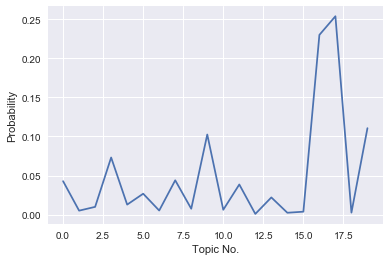

In [407]:
fig, ax = plt.subplots()
plt.plot(normal)
ax.set_xlabel('Topic No.')
ax.set_ylabel('Probability')

In [370]:
list_l = list(l)
list_l.index(max(l))

17

In [415]:
normal[17]

0.25387613062366854

In [406]:
lda.print_topic(14,10)

'0.120*"sushi" + 0.053*"roll" + 0.023*"tuna" + 0.019*"madison" + 0.019*"salmon" + 0.017*"fish" + 0.016*"chef" + 0.015*"japanes" + 0.014*"fresh" + 0.013*"tempura"'

In [578]:
subscores = getsubscore(prefer_added, groupby_rest)

100
200
300
400
500
600
700
800


In [138]:
groupuser_test = test_df.groupby('user_id').size().reset_index(name='counts')
dic = {}
for i in groupuser_test['user_id']:
    l = list(prefer_added['user_id'])
    if i in l:
        ind = l.index(i)
        dic[i] = ind

In [115]:
def add_prefer_to_test(prefer_added, df):
    test_df = df
    d = {}
    for i in test_df['user_id']: 
        if i in dic:
            a = prefer_added.iloc[[dic[i]]]['preference'].values
            d[i] = a
        else:
            d[i] = -1
    
    test_df['preference'] = test_df.apply(lambda x: d[x['user_id']],axis=1)
    return test_df

In [116]:
prefer_added_totest = add_prefer_to_test(prefer_added, test_df)

In [265]:
mean_train_star = train_df['stars'].mean()

In [579]:
prediction = []
expected = []
#user_mean = {}
for i in range(len(prefer_added_totest)):
    row = prefer_added_totest.iloc[i]
    if row['business_id'] in subscores and (row['preference'] != -1):
        '''
        if row['user_id'] not in user_mean:
            user = train_df.loc[train_df['user_id'] == row['user_id']]
            user_mean[row['user_id']] = user['stars'].mean()
            
        ratio = user_mean[row['user_id']]/mean_train_star
        '''
        prediction.append(np.dot(row['preference'][0], subscores[row['business_id']][0]))
        expected.append(row['stars'])

In [449]:
y = np.asarray(prediction)
x = np.asarray(expected)

In [347]:
y.mean()

3.9932067248697662

In [348]:
x.mean()

3.7902876585214971

In [580]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(expected, prediction)
print('MSE: %f' % mse)

MSE: 1.326277


In [581]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(expected, prediction)
print('MAE: %f' % mae)

MAE: 0.903743


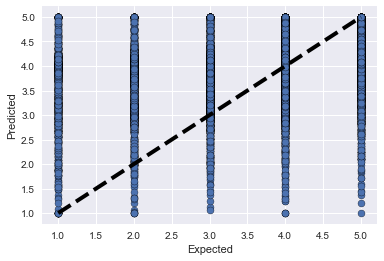

In [43]:
fig, ax = plt.subplots()
y = np.asarray(expected)
ax.scatter(y, prediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Expected')
ax.set_ylabel('Predicted')
plt.show()

In [233]:
fig.savefig("fig")

In [44]:
err = []
for i in range(len(expected)):
    err.append(prediction[i] - expected[i])


(array([   49.,    69.,   196.,   240.,   693.,  1255.,  1725.,  5736.,
         1714.,  2074.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

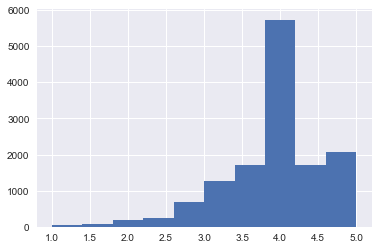

In [46]:
plt.hist(prediction)

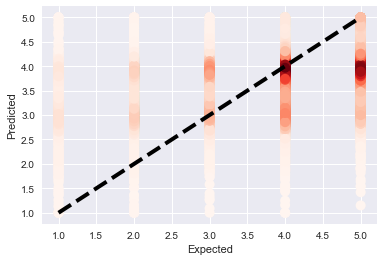

In [582]:
from scipy.stats import gaussian_kde
y = np.asarray(prediction)
x = np.asarray(expected)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='', cmap=plt.cm.Reds)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Expected')
ax.set_ylabel('Predicted')
plt.show()





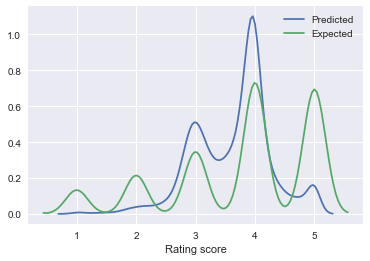

In [583]:
import seaborn as sns
fig, ax = plt.subplots()
# Make default density plot
sns.kdeplot(y, label="Predicted")
sns.kdeplot(x, label="Expected")
ax.legend()
ax.set_xlabel("Rating score")
plt.show()


In [193]:
err = np.asarray(err)

In [584]:
dictofscore = {1:[],2:[],3:[],4:[],5:[]}
for i in range(len(prediction)):
    if expected[i] == 1:
        dictofscore[1].append(prediction[i])
    elif expected[i] == 2:
        dictofscore[2].append(prediction[i])
    elif expected[i] == 3:
        dictofscore[3].append(prediction[i])
    elif expected[i] == 4:
        dictofscore[4].append(prediction[i])
    elif expected[i] == 5:
        dictofscore[5].append(prediction[i])


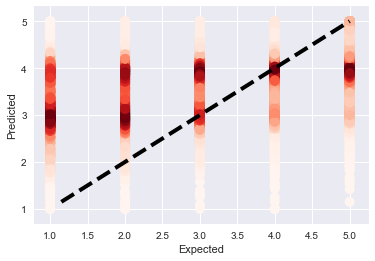

In [585]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots()
for i in range(1,6):
    y = np.asarray(dictofscore[i])
    x = np.full(len(y),i)
    z = gaussian_kde(y)(y)
    ax.scatter(x, y, c=z, s=100, edgecolor='', cmap=plt.cm.Reds)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Expected')
ax.set_ylabel('Predicted')
plt.show()

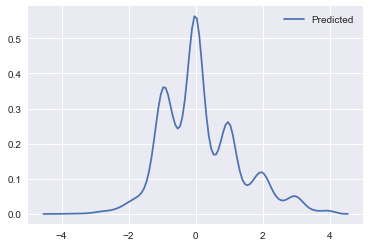

In [499]:
sns.kdeplot(err, label="Predicted")
plt.show()

In [454]:
mseval = [1.374903, 1.352986, 1.327753, 1.302697,1.279420, 1.244384]
x = [0,10,20,50,75,100]
maeval = [0.864887, 0.857414, 0.847373, 0.836233,0.824955, 0.809624]

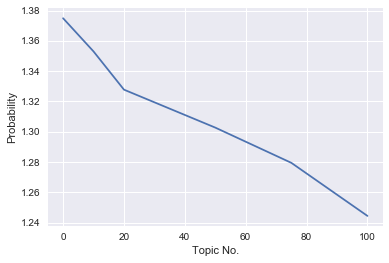

In [455]:
fig, ax = plt.subplots()
ax.plot(x,mseval)
ax.set_xlabel('Topic No.')
ax.set_ylabel('Probability')

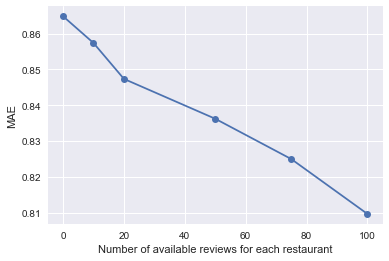

In [466]:
fig, ax = plt.subplots()
ax.plot(x,maeval, linestyle='-',marker='o')
ax.set_ylabel('MAE')
ax.set_xlabel('Number of available reviews for each restaurant')

In [510]:
v = train_df['stars'].values

In [526]:
a = [0,0,0,0,0]
for i in v:
    a[i-1]+=1

In [527]:
a

[3351, 4157, 6262, 13181, 14975]

In [528]:
v.shape

(41926,)

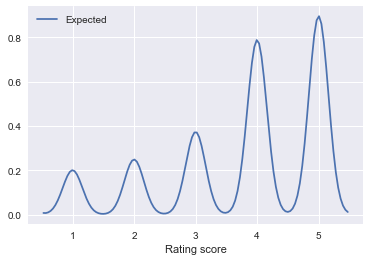

In [519]:
import seaborn as sns
fig, ax = plt.subplots()
# Make default density plot
sns.kdeplot(v, label="Expected")
ax.legend()
ax.set_xlabel("Rating score")
plt.show()

In [61]:
subscores = getsubscore(prefer_added, groupby_rest)

1000


In [62]:
prediction = []
for i in range(len(prefer_added)):
    prediction.append(np.dot(prefer_added.iloc[i]['preference'], subscores[prefer_added.iloc[i]['business_id']]))

In [63]:
expected = prefer_added['stars']

In [64]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(expected.values, prediction)
print('MSE: %f' % mse)

MSE: 1.278005


In [65]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(expected.values, prediction)
print('MAE: %f' % mae)

MAE: 0.788877


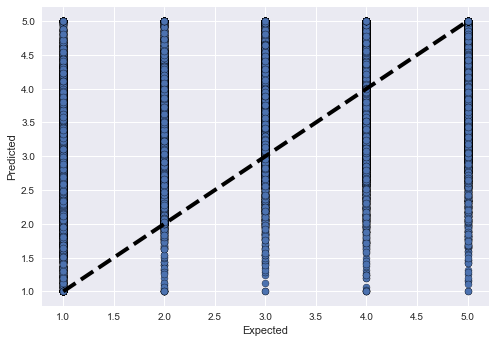

In [70]:
fig, ax = plt.subplots()
y = expected.values
ax.scatter(y, prediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Expected')
ax.set_ylabel('Predicted')
plt.show()

In [53]:
with open("../../../subscores.pickle", "wb") as output_file:
    pickle.dump(subscores, output_file)

In [54]:
with open("../../../prediction1.pickle", "wb") as output_file:
    pickle.dump(prediction, output_file)

In [55]:
with open("../../../expected1.pickle", "wb") as output_file:
    pickle.dump(expected, output_file)

In [109]:
sample = rest_review.sample(50000)

In [110]:
sample_lda = getlda(sample)

In [111]:
groupby_user_sample = sample.groupby('user_id').size().reset_index(name='counts')

In [112]:
perfer_added_to_sample = add_prefer_to_df(sample, sample_lda, groupby_user_sample)

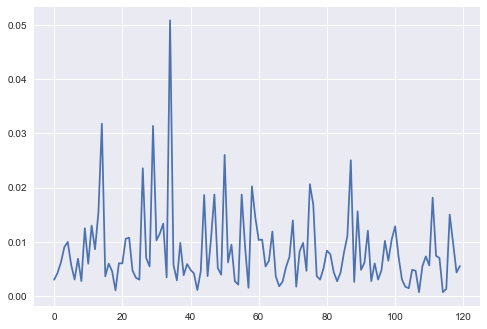

In [113]:
prefer_added_to_sample = perfer_added_to_sample
plt.plot(prefer_added_to_sample['preference'].iloc[1])

In [114]:
l = list(np.empty(NUM_TOPICS))
for i in prefer_added_to_sample['preference']:
    for p in range(len(i)):
        l[p] += i[p]
print (l)

[2.7802895488401917, 9.6353400490516172, 25.121464093995687, 97.211069490654907, 434.45063120261023, 83.741578285352119, 29.378139672045542, 184.51023150307563, 3.0348373250967624, 118.29824446145126, 25.495967957829883, 367.61507821935288, 2669.983196487126, 734.89074866322039, 171.37162825393642, 5.1728461249731224, 5.0704757379597734, 4.6252192853606227, 1.6736573059615674, 76.381329202770033, 4293.7091824121462, 1766.1934381465915, 53.125006821046334, 49.04045288267433, 3244.2370278082813, 5.5830448997977529, 335.17210240298095, 11.55473059439352, 52.563792401066038, 89.083778770760759, 11.167278466644357, 7.5934190187287394, 53.015278998374249, 2.6284203567883395, 4549.970091710954, 172.06708194109933, 9.4379142902649082, 35.095292614957657, 6.9407741365646585, 94.81483965637787, 4.7388212359065394, 54.803352550117083, 6.2560737941102946, 7.4512128318303317, 53.321026778984468, 17.069832744194805, 345.00619461581925, 359.18114953899709, 36.874861329520378, 40.31765358667775, 85.77

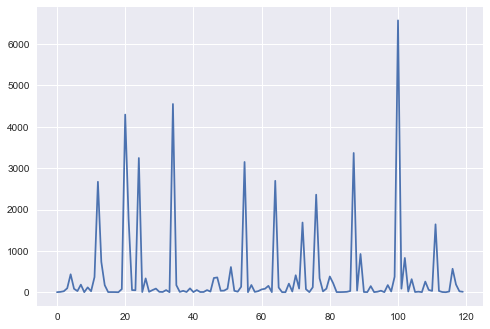

In [115]:
plt.plot(l)

## Future
Evaluating the performance.

Come up with a method that does not set the topics as a whole but one for each user. However, we are struggling to see how to match topics between user and restaurant without manual labelling.